In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch
import torch.nn as nn

from train_evaluate import NMR_prediction
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn
import torch.nn as nn
from dgl import AddSelfLoop
from model_zoo.NMR_gcn import NMR_GCN
from create_graph_data import create_graph
from node_embeddings import create_node_embeddings
from create_adjaency_matrix_from_labeled_pdb import build_adjacency_matrix
from dgl import save_graphs, load_graphs
from tqdm import tqdm

In [2]:
num_test = 300

s = 2

atom_dim = 256 * s

residual_dim = 64 * s

mono_dim = 128 * s

ab_dim = 64
dl_dim = 64
pf_dim = 64

in_size = atom_dim + mono_dim + residual_dim
hidden_size_1 = int(in_size / 2)
hidden_size_2 = int(hidden_size_1 / 2)
hidden_size_3 = 256
hidden_size_4 = 128

num_epoch = 3000
lr = 1e-3
seed=9721

In [3]:
C = create_node_embeddings(data_dir='dataset/Godess_carbon_gnn/Godess_carbon_labeled_pdb/', 
                           out_atom_embed='dataset/Godess_carbon_gnn/embedding/atom_embed.csv',
                           out_residual_embed='dataset/Godess_carbon_gnn/embedding/residual_embed.csv', 
                           out_monosaccharide_embed='dataset/Godess_carbon_gnn/embedding/monosaccharide_embed.csv',
                           seed=seed)

In [4]:
df_atom_embedding, df_residual_embedding, df_monosaccharide_embedding = \
    C.create_all_embeddings(atom_dim=atom_dim, residual_dim=residual_dim, mono_dim=mono_dim)

100%|██████████████████████████████████████| 1995/1995 [00:02<00:00, 829.79it/s]


In [5]:
df_atom_embedding.to_csv(C.out_atom_embed, index=False)
df_residual_embedding.to_csv(C.out_residual_embed, index=False)
df_monosaccharide_embedding.to_csv(C.out_monosaccharide_embed, index=False)

In [6]:
B = build_adjacency_matrix(labeled_pdb_dir='dataset/Godess_carbon_gnn/Godess_carbon_labeled_pdb/',
                           out_adjacency_dir='dataset/Godess_carbon_gnn/directory_graph_connection/',
                           out_interaction_dir='dataset/Godess_carbon_gnn/directory_graph_interaction/')

In [7]:
B.calculate_all_matrix()

100%|███████████████████████████████████████| 1995/1995 [01:34<00:00, 21.11it/s]


In [8]:
Create = create_graph(data_dir='dataset/Godess_carbon_gnn/Godess_carbon_labeled_pdb/', 
                                 adj_dir='dataset/Godess_carbon_gnn/directory_graph_connection/',
                                 interaction_dir='dataset/Godess_carbon_gnn/directory_graph_interaction/', 
                                 atom_embed_dir='dataset/Godess_carbon_gnn/embedding/atom_embed.csv',
                                 residual_embed_dir='dataset/Godess_carbon_gnn/embedding/residual_embed.csv', 
                                 mono_embed_dir='dataset/Godess_carbon_gnn/embedding/monosaccharide_embed.csv', 
                                num_test=num_test, seed=seed)

In [9]:
g, test_index = Create.create_all_graph()

--------------------------loading NMR Graph-------------------------------


100%|███████████████████████████████████████| 1995/1995 [03:01<00:00, 10.97it/s]


In [10]:

save_graphs('dataset/Godess_carbon_gnn/graph_data/data.bin', g, {'feat': g.ndata['feat']})

pd.DataFrame(g.ndata['train_carbon_mask'].cpu().numpy()).\
    to_csv('dataset/Godess_carbon_gnn/graph_data/train_carbon_mask.csv', index = False)

pd.DataFrame(g.ndata['test_carbon_mask'].cpu().numpy()).\
    to_csv('dataset/Godess_carbon_gnn/graph_data/test_carbon_mask.csv', index = False)

pd.DataFrame(g.ndata['shift_value'].cpu().numpy()).\
    to_csv('dataset/Godess_carbon_gnn/graph_data/shift_value.csv', index = False)

pd.DataFrame(test_index).to_csv('dataset/Godess_carbon_gnn/results/test_index_experiment.csv', index=False)


In [11]:
g, features = load_graphs('dataset/Godess_carbon_gnn/graph_data/data.bin')
g = g[0]
# features = features['feat']

In [12]:
# train_carbon_mask = pd.read_csv('dataset/Godess_carbon_gnn/graph_data/train_carbon_mask.csv').to_numpy().reshape(-1)
# train_carbon_mask = torch.tensor(train_carbon_mask)

# test_carbon_mask = pd.read_csv('dataset/Godess_carbon_gnn/graph_data/test_carbon_mask.csv').to_numpy().reshape(-1)
# test_carbon_mask = torch.tensor(test_carbon_mask)

# shift_value = pd.read_csv('dataset/Godess_carbon_gnn/graph_data/shift_value.csv').to_numpy().reshape(-1)
# labels = torch.tensor(shift_value)

In [13]:
g.ndata

{'test_carbon_mask': tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8), 'train_hydrogen_mask': tensor([0, 0, 0,  ..., 0, 1, 0], dtype=torch.uint8), 'test_mask': tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8), 'train_mask': tensor([0, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8), 'Carbon_Hydrogen_mask': tensor([0, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8), 'test_hydrogen_mask': tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8), 'shift_value': tensor([-1.0000, 83.2000, 72.4000,  ..., -1.0000, -1.0000, -1.0000]), 'train_carbon_mask': tensor([0, 1, 1,  ..., 0, 0, 0], dtype=torch.uint8), 'feat': tensor([[ 0.4001, -0.0697, -1.1372,  ..., -0.4001,  1.4121, -1.5322],
        [ 0.5874, -0.7246,  0.1714,  ..., -0.4001,  1.4121, -1.5322],
        [ 0.4849,  1.2883, -0.0431,  ..., -0.4001,  1.4121, -1.5322],
        ...,
        [-1.1697, -1.1278,  0.5255,  ...,  0.7241,  1.4715, -0.4758],
        [ 0.9121,  0.6795,  0.4921,  ...,  0.7241,  1.4715, -0.4758],
        [ 0.5108,  0.1177,  0.1537,

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = g.to(device)

# train_carbon_mask.to(device)
# test_carbon_mask.to(device)
# labels.to(device)
# features.to(device)

features = g.ndata["feat"] + 1
labels = g.ndata["shift_value"]
masks = g.ndata['train_mask'], g.ndata['test_mask']


# masks = g.ndata['train_hydrogen_mask'], g.ndata['test_hydrogen_mask']
masks = g.ndata['train_carbon_mask'], g.ndata['test_carbon_mask']
# masks = train_carbon_mask, test_carbon_mask

print(features.dtype)
print(labels.dtype)

model = NMR_GCN(in_size=in_size, hid_size=[hidden_size_1, hidden_size_2,
                                       hidden_size_3, hidden_size_4], out_size=1).to(device)
# model training

NMR_prediction = NMR_prediction(results_dir='dataset/Godess_carbon_gnn/results/experimental_results_all_hydrogen.csv',
                                model_dir='dataset/Godess_carbon_gnn/results/Model_hydrogen_experiment_training.pt',
                               num_epoch = num_epoch, 
                               lr = lr)


print("Training...")
NMR_prediction.train(g, features, labels, masks, model)

# test the model
print("Testing...")
saved_model = NMR_GCN(in_size=in_size, hid_size=[hidden_size_1, hidden_size_2,
                                                 hidden_size_3, hidden_size_4], out_size=1).to(device)
saved_model.load_state_dict(torch.load(NMR_prediction.model_dir))

acc = NMR_prediction.evaluate(g, features, labels, masks[0], saved_model, print_out=True)
# acc = NMR_prediction.evaluate(g, features, labels, masks[1], saved_model, print_out=True)


print("MSE {:.4f}".format(acc))

torch.float32
torch.float32
Training...


  0%|                                          | 2/3000 [00:00<21:46,  2.30it/s]

8941
48992
Epoch 00000 | Loss 6600.6450 | train_RMSE 76.5748 | test_RMSE 76.8910 
8941
48992
Epoch 00001 | Loss 5864.1890 | train_RMSE 65.9336 | test_RMSE 66.2757 


  0%|                                          | 4/3000 [00:01<11:52,  4.21it/s]

8941
48992
Epoch 00002 | Loss 4349.1919 | train_RMSE 46.6119 | test_RMSE 47.0283 
8941
48992
Epoch 00003 | Loss 2177.1875 | train_RMSE 24.4111 | test_RMSE 24.9824 


  0%|                                          | 6/3000 [00:01<08:56,  5.58it/s]

8941
48992
Epoch 00004 | Loss 617.3105 | train_RMSE 52.6183 | test_RMSE 52.7604 
8941
48992
Epoch 00005 | Loss 2829.8525 | train_RMSE 42.9120 | test_RMSE 43.1190 


  0%|                                          | 8/3000 [00:01<07:44,  6.44it/s]

8941
48992
Epoch 00006 | Loss 1891.9475 | train_RMSE 26.7622 | test_RMSE 27.2101 
8941
48992
Epoch 00007 | Loss 747.6251 | train_RMSE 25.8867 | test_RMSE 26.4573 


  0%|▏                                        | 10/3000 [00:02<07:14,  6.88it/s]

8941
48992
Epoch 00008 | Loss 689.2047 | train_RMSE 32.9261 | test_RMSE 33.4309 
8941
48992
Epoch 00009 | Loss 1100.8419 | train_RMSE 37.4384 | test_RMSE 37.9061 


  0%|▏                                        | 12/3000 [00:02<06:58,  7.14it/s]

8941
48992
Epoch 00010 | Loss 1411.9526 | train_RMSE 38.2938 | test_RMSE 38.7549 
8941
48992
Epoch 00011 | Loss 1475.7524 | train_RMSE 36.0990 | test_RMSE 36.5761 


  0%|▏                                        | 14/3000 [00:02<06:51,  7.25it/s]

8941
48992
Epoch 00012 | Loss 1315.5653 | train_RMSE 31.6695 | test_RMSE 32.1839 
8941
48992
Epoch 00013 | Loss 1018.5098 | train_RMSE 26.5014 | test_RMSE 27.0644 


  1%|▏                                        | 16/3000 [00:02<06:51,  7.25it/s]

8941
48992
Epoch 00014 | Loss 720.6549 | train_RMSE 23.9138 | test_RMSE 24.4702 
8941
48992
Epoch 00015 | Loss 598.6954 | train_RMSE 26.6108 | test_RMSE 27.0537 


  1%|▏                                        | 18/3000 [00:03<06:48,  7.30it/s]

8941
48992
Epoch 00016 | Loss 744.1329 | train_RMSE 30.3812 | test_RMSE 30.7388 
8941
48992
Epoch 00017 | Loss 970.4361 | train_RMSE 30.3502 | test_RMSE 30.7074 


  1%|▎                                        | 20/3000 [00:03<06:47,  7.32it/s]

8941
48992
Epoch 00018 | Loss 961.0797 | train_RMSE 27.0801 | test_RMSE 27.5071 
8941
48992
Epoch 00019 | Loss 772.0220 | train_RMSE 24.1543 | test_RMSE 24.6767 


  1%|▎                                        | 22/3000 [00:03<06:46,  7.33it/s]

8941
48992
Epoch 00020 | Loss 614.9360 | train_RMSE 23.9782 | test_RMSE 24.5478 
8941
48992
Epoch 00021 | Loss 601.0958 | train_RMSE 25.5962 | test_RMSE 26.1615 


  1%|▎                                        | 24/3000 [00:04<06:45,  7.34it/s]

8941
48992
Epoch 00022 | Loss 678.0298 | train_RMSE 27.1151 | test_RMSE 27.6661 
8941
48992
Epoch 00023 | Loss 756.8878 | train_RMSE 27.5486 | test_RMSE 28.0947 


  1%|▎                                        | 26/3000 [00:04<06:44,  7.35it/s]

8941
48992
Epoch 00024 | Loss 779.3408 | train_RMSE 26.7723 | test_RMSE 27.3253 
8941
48992
Epoch 00025 | Loss 736.1393 | train_RMSE 25.2347 | test_RMSE 25.8004 


  1%|▍                                        | 28/3000 [00:04<06:46,  7.31it/s]

8941
48992
Epoch 00026 | Loss 657.2165 | train_RMSE 23.8228 | test_RMSE 24.3915 
8941
48992
Epoch 00027 | Loss 593.2005 | train_RMSE 23.4750 | test_RMSE 24.0189 


  1%|▍                                        | 30/3000 [00:04<06:46,  7.31it/s]

8941
48992
Epoch 00028 | Loss 579.2358 | train_RMSE 24.2712 | test_RMSE 24.7700 
8941
48992
Epoch 00029 | Loss 619.7164 | train_RMSE 25.1542 | test_RMSE 25.6200 


  1%|▍                                        | 32/3000 [00:05<06:45,  7.32it/s]

8941
48992
Epoch 00030 | Loss 667.2182 | train_RMSE 25.1064 | test_RMSE 25.5720 
8941
48992
Epoch 00031 | Loss 663.3179 | train_RMSE 24.2100 | test_RMSE 24.7052 


  1%|▍                                        | 34/3000 [00:05<06:48,  7.27it/s]

8941
48992
Epoch 00032 | Loss 619.3035 | train_RMSE 23.3586 | test_RMSE 23.8930 
8941
48992
Epoch 00033 | Loss 576.2157 | train_RMSE 23.2379 | test_RMSE 23.7979 


  1%|▍                                        | 36/3000 [00:05<06:47,  7.27it/s]

8941
48992
Epoch 00034 | Loss 569.6882 | train_RMSE 23.7074 | test_RMSE 24.2744 
8941
48992
Epoch 00035 | Loss 586.1806 | train_RMSE 24.1882 | test_RMSE 24.7539 


  1%|▌                                        | 38/3000 [00:05<06:45,  7.31it/s]

8941
48992
Epoch 00036 | Loss 608.7809 | train_RMSE 24.2580 | test_RMSE 24.8228 
8941
48992
Epoch 00037 | Loss 612.3581 | train_RMSE 23.8681 | test_RMSE 24.4337 


  1%|▌                                        | 40/3000 [00:06<06:47,  7.27it/s]

8941
48992
Epoch 00038 | Loss 594.6154 | train_RMSE 23.2916 | test_RMSE 23.8556 
8941
48992
Epoch 00039 | Loss 567.6499 | train_RMSE 22.9277 | test_RMSE 23.4812 


  1%|▌                                        | 42/3000 [00:06<06:44,  7.31it/s]

8941
48992
Epoch 00040 | Loss 551.6895 | train_RMSE 22.9779 | test_RMSE 23.5116 
8941
48992
Epoch 00041 | Loss 554.5507 | train_RMSE 23.2429 | test_RMSE 23.7573 


  1%|▌                                        | 44/3000 [00:06<06:42,  7.34it/s]

8941
48992
Epoch 00042 | Loss 568.4259 | train_RMSE 23.3358 | test_RMSE 23.8429 
8941
48992
Epoch 00043 | Loss 574.3349 | train_RMSE 23.1084 | test_RMSE 23.6240 


  2%|▋                                        | 46/3000 [00:07<06:45,  7.28it/s]

8941
48992
Epoch 00044 | Loss 560.8651 | train_RMSE 22.7810 | test_RMSE 23.3139 
8941
48992
Epoch 00045 | Loss 543.3526 | train_RMSE 22.6468 | test_RMSE 23.1953 


  2%|▋                                        | 48/3000 [00:07<06:45,  7.29it/s]

8941
48992
Epoch 00046 | Loss 537.7887 | train_RMSE 22.7487 | test_RMSE 23.3055 
8941
48992
Epoch 00047 | Loss 542.0450 | train_RMSE 22.9041 | test_RMSE 23.4634 


  2%|▋                                        | 50/3000 [00:07<06:43,  7.32it/s]

8941
48992
Epoch 00048 | Loss 547.9955 | train_RMSE 22.9167 | test_RMSE 23.4758 
8941
48992
Epoch 00049 | Loss 545.0958 | train_RMSE 22.7433 | test_RMSE 23.3005 


  2%|▋                                        | 52/3000 [00:07<06:46,  7.26it/s]

8941
48992
Epoch 00050 | Loss 538.6154 | train_RMSE 22.5038 | test_RMSE 23.0561 
8941
48992
Epoch 00051 | Loss 529.5118 | train_RMSE 22.3620 | test_RMSE 22.9047 


  2%|▋                                        | 54/3000 [00:08<06:45,  7.27it/s]

8941
48992
Epoch 00052 | Loss 526.0613 | train_RMSE 22.3705 | test_RMSE 22.9012 
8941
48992
Epoch 00053 | Loss 526.9369 | train_RMSE 22.4196 | test_RMSE 22.9414 


  2%|▊                                        | 56/3000 [00:08<06:42,  7.32it/s]

8941
48992
Epoch 00054 | Loss 529.1331 | train_RMSE 22.3763 | test_RMSE 22.8969 
8941
48992
Epoch 00055 | Loss 527.6578 | train_RMSE 22.2386 | test_RMSE 22.7653 


  2%|▊                                        | 58/3000 [00:08<06:44,  7.27it/s]

8941
48992
Epoch 00056 | Loss 519.8198 | train_RMSE 22.1180 | test_RMSE 22.6535 
8941
48992
Epoch 00057 | Loss 513.3256 | train_RMSE 22.0922 | test_RMSE 22.6347 


  2%|▊                                        | 60/3000 [00:08<06:48,  7.20it/s]

8941
48992
Epoch 00058 | Loss 511.3640 | train_RMSE 22.1228 | test_RMSE 22.6686 
8941
48992
Epoch 00059 | Loss 511.1721 | train_RMSE 22.1143 | test_RMSE 22.6604 


  2%|▊                                        | 62/3000 [00:09<06:45,  7.24it/s]

8941
48992
Epoch 00060 | Loss 509.5607 | train_RMSE 22.0252 | test_RMSE 22.5690 
8941
48992
Epoch 00061 | Loss 505.9840 | train_RMSE 21.8967 | test_RMSE 22.4359 


  2%|▊                                        | 64/3000 [00:09<06:45,  7.24it/s]

8941
48992
Epoch 00062 | Loss 501.9799 | train_RMSE 21.8037 | test_RMSE 22.3357 
8941
48992
Epoch 00063 | Loss 498.4467 | train_RMSE 21.7699 | test_RMSE 22.2940 


  2%|▉                                        | 66/3000 [00:09<06:44,  7.25it/s]

8941
48992
Epoch 00064 | Loss 496.9606 | train_RMSE 21.7468 | test_RMSE 22.2657 
8941
48992
Epoch 00065 | Loss 496.4239 | train_RMSE 21.6834 | test_RMSE 22.2017 


  2%|▉                                        | 68/3000 [00:10<06:44,  7.24it/s]

8941
48992
Epoch 00066 | Loss 493.5124 | train_RMSE 21.5937 | test_RMSE 22.1153 
8941
48992
Epoch 00067 | Loss 486.9268 | train_RMSE 21.5271 | test_RMSE 22.0531 


  2%|▉                                        | 70/3000 [00:10<06:43,  7.26it/s]

8941
48992
Epoch 00068 | Loss 485.0448 | train_RMSE 21.4999 | test_RMSE 22.0288 
8941
48992
Epoch 00069 | Loss 484.1588 | train_RMSE 21.4737 | test_RMSE 22.0030 


  2%|▉                                        | 72/3000 [00:10<06:43,  7.26it/s]

8941
48992
Epoch 00070 | Loss 481.1693 | train_RMSE 21.4111 | test_RMSE 21.9384 
8941
48992
Epoch 00071 | Loss 480.1076 | train_RMSE 21.3187 | test_RMSE 21.8420 


  2%|█                                        | 74/3000 [00:10<06:42,  7.26it/s]

8941
48992
Epoch 00072 | Loss 474.1638 | train_RMSE 21.2330 | test_RMSE 21.7507 
8941
48992
Epoch 00073 | Loss 472.0355 | train_RMSE 21.1721 | test_RMSE 21.6837 


  3%|█                                        | 76/3000 [00:11<06:41,  7.28it/s]

8941
48992
Epoch 00074 | Loss 469.7957 | train_RMSE 21.1210 | test_RMSE 21.6279 
8941
48992
Epoch 00075 | Loss 468.3186 | train_RMSE 21.0551 | test_RMSE 21.5603 


  3%|█                                        | 78/3000 [00:11<06:41,  7.29it/s]

8941
48992
Epoch 00076 | Loss 464.6705 | train_RMSE 20.9794 | test_RMSE 21.4852 
8941
48992
Epoch 00077 | Loss 459.3713 | train_RMSE 20.9160 | test_RMSE 21.4230 


  3%|█                                        | 80/3000 [00:11<06:42,  7.25it/s]

8941
48992
Epoch 00078 | Loss 458.4830 | train_RMSE 20.8668 | test_RMSE 21.3739 
8941
48992
Epoch 00079 | Loss 456.7433 | train_RMSE 20.8107 | test_RMSE 21.3161 


  3%|█                                        | 82/3000 [00:11<06:42,  7.25it/s]

8941
48992
Epoch 00080 | Loss 453.0395 | train_RMSE 20.7343 | test_RMSE 21.2361 
8941
48992
Epoch 00081 | Loss 450.7825 | train_RMSE 20.6497 | test_RMSE 21.1465 


  3%|█▏                                       | 84/3000 [00:12<06:41,  7.26it/s]

8941
48992
Epoch 00082 | Loss 445.6200 | train_RMSE 20.5738 | test_RMSE 21.0648 
8941
48992
Epoch 00083 | Loss 443.3476 | train_RMSE 20.5062 | test_RMSE 20.9921 


  3%|█▏                                       | 86/3000 [00:12<06:40,  7.27it/s]

8941
48992
Epoch 00084 | Loss 441.1221 | train_RMSE 20.4343 | test_RMSE 20.9168 
8941
48992
Epoch 00085 | Loss 439.1438 | train_RMSE 20.3579 | test_RMSE 20.8386 


  3%|█▏                                       | 88/3000 [00:12<06:40,  7.27it/s]

8941
48992
Epoch 00086 | Loss 434.4043 | train_RMSE 20.2880 | test_RMSE 20.7675 
8941
48992
Epoch 00087 | Loss 433.3302 | train_RMSE 20.2243 | test_RMSE 20.7016 


  3%|█▏                                       | 90/3000 [00:13<06:40,  7.26it/s]

8941
48992
Epoch 00088 | Loss 428.9982 | train_RMSE 20.1512 | test_RMSE 20.6246 
8941
48992
Epoch 00089 | Loss 425.6783 | train_RMSE 20.0660 | test_RMSE 20.5340 


  3%|█▎                                       | 92/3000 [00:13<06:40,  7.26it/s]

8941
48992
Epoch 00090 | Loss 423.2029 | train_RMSE 19.9813 | test_RMSE 20.4429 
8941
48992
Epoch 00091 | Loss 419.5380 | train_RMSE 19.9032 | test_RMSE 20.3587 


  3%|█▎                                       | 94/3000 [00:13<06:40,  7.26it/s]

8941
48992
Epoch 00092 | Loss 416.8960 | train_RMSE 19.8246 | test_RMSE 20.2752 
8941
48992
Epoch 00093 | Loss 411.4298 | train_RMSE 19.7441 | test_RMSE 20.1912 


  3%|█▎                                       | 96/3000 [00:13<06:39,  7.27it/s]

8941
48992
Epoch 00094 | Loss 410.6470 | train_RMSE 19.6684 | test_RMSE 20.1119 
8941
48992
Epoch 00095 | Loss 404.8701 | train_RMSE 19.5909 | test_RMSE 20.0295 


  3%|█▎                                       | 98/3000 [00:14<06:37,  7.30it/s]

8941
48992
Epoch 00096 | Loss 406.0178 | train_RMSE 19.5062 | test_RMSE 19.9388 
8941
48992
Epoch 00097 | Loss 399.4915 | train_RMSE 19.4197 | test_RMSE 19.8455 


  3%|█▎                                      | 100/3000 [00:14<06:37,  7.29it/s]

8941
48992
Epoch 00098 | Loss 397.7416 | train_RMSE 19.3346 | test_RMSE 19.7539 
8941
48992
Epoch 00099 | Loss 393.7053 | train_RMSE 19.2491 | test_RMSE 19.6630 


  3%|█▎                                      | 102/3000 [00:14<06:37,  7.28it/s]

8941
48992
Epoch 00100 | Loss 388.8916 | train_RMSE 19.1661 | test_RMSE 19.5745 
8941
48992
Epoch 00101 | Loss 387.3207 | train_RMSE 19.0802 | test_RMSE 19.4824 


  3%|█▍                                      | 104/3000 [00:15<06:38,  7.27it/s]

8941
48992
Epoch 00102 | Loss 383.2984 | train_RMSE 18.9921 | test_RMSE 19.3875 
8941
48992
Epoch 00103 | Loss 380.6266 | train_RMSE 18.9060 | test_RMSE 19.2951 


  4%|█▍                                      | 106/3000 [00:15<06:38,  7.26it/s]

8941
48992
Epoch 00104 | Loss 378.7943 | train_RMSE 18.8199 | test_RMSE 19.2031 
8941
48992
Epoch 00105 | Loss 374.3316 | train_RMSE 18.7341 | test_RMSE 19.1116 


  4%|█▍                                      | 108/3000 [00:15<06:38,  7.26it/s]

8941
48992
Epoch 00106 | Loss 371.5260 | train_RMSE 18.6456 | test_RMSE 19.0171 
8941
48992
Epoch 00107 | Loss 368.4524 | train_RMSE 18.5534 | test_RMSE 18.9185 


  4%|█▍                                      | 110/3000 [00:15<06:43,  7.16it/s]

8941
48992
Epoch 00108 | Loss 364.0990 | train_RMSE 18.4621 | test_RMSE 18.8212 
8941
48992
Epoch 00109 | Loss 361.6476 | train_RMSE 18.3711 | test_RMSE 18.7250 


  4%|█▍                                      | 112/3000 [00:16<06:39,  7.22it/s]

8941
48992
Epoch 00110 | Loss 357.6789 | train_RMSE 18.2805 | test_RMSE 18.6291 
8941
48992
Epoch 00111 | Loss 355.4638 | train_RMSE 18.1907 | test_RMSE 18.5342 


  4%|█▌                                      | 114/3000 [00:16<06:37,  7.27it/s]

8941
48992
Epoch 00112 | Loss 352.0895 | train_RMSE 18.1022 | test_RMSE 18.4410 
8941
48992
Epoch 00113 | Loss 348.9452 | train_RMSE 18.0137 | test_RMSE 18.3486 


  4%|█▌                                      | 116/3000 [00:16<06:37,  7.26it/s]

8941
48992
Epoch 00114 | Loss 345.3188 | train_RMSE 17.9264 | test_RMSE 18.2572 
8941
48992
Epoch 00115 | Loss 342.8063 | train_RMSE 17.8391 | test_RMSE 18.1665 


  4%|█▌                                      | 118/3000 [00:16<06:37,  7.25it/s]

8941
48992
Epoch 00116 | Loss 338.6939 | train_RMSE 17.7515 | test_RMSE 18.0755 
8941
48992
Epoch 00117 | Loss 336.3302 | train_RMSE 17.6634 | test_RMSE 17.9846 


  4%|█▌                                      | 120/3000 [00:17<06:36,  7.26it/s]

8941
48992
Epoch 00118 | Loss 332.5943 | train_RMSE 17.5756 | test_RMSE 17.8941 
8941
48992
Epoch 00119 | Loss 330.0715 | train_RMSE 17.4877 | test_RMSE 17.8041 


  4%|█▋                                      | 122/3000 [00:17<06:35,  7.27it/s]

8941
48992
Epoch 00120 | Loss 326.6003 | train_RMSE 17.3997 | test_RMSE 17.7140 
8941
48992
Epoch 00121 | Loss 325.2012 | train_RMSE 17.3125 | test_RMSE 17.6250 


  4%|█▋                                      | 124/3000 [00:17<06:35,  7.27it/s]

8941
48992
Epoch 00122 | Loss 321.7547 | train_RMSE 17.2239 | test_RMSE 17.5342 
8941
48992
Epoch 00123 | Loss 317.5566 | train_RMSE 17.1346 | test_RMSE 17.4424 


  4%|█▋                                      | 126/3000 [00:18<06:36,  7.26it/s]

8941
48992
Epoch 00124 | Loss 313.8563 | train_RMSE 17.0446 | test_RMSE 17.3494 
8941
48992
Epoch 00125 | Loss 310.5771 | train_RMSE 16.9529 | test_RMSE 17.2535 


  4%|█▋                                      | 128/3000 [00:18<06:35,  7.26it/s]

8941
48992
Epoch 00126 | Loss 308.4340 | train_RMSE 16.8619 | test_RMSE 17.1579 
8941
48992
Epoch 00127 | Loss 306.5865 | train_RMSE 16.7749 | test_RMSE 17.0658 


  4%|█▋                                      | 130/3000 [00:18<06:34,  7.27it/s]

8941
48992
Epoch 00128 | Loss 302.6342 | train_RMSE 16.6910 | test_RMSE 16.9776 
8941
48992
Epoch 00129 | Loss 300.5435 | train_RMSE 16.6058 | test_RMSE 16.8859 


  4%|█▊                                      | 132/3000 [00:18<06:33,  7.28it/s]

8941
48992
Epoch 00130 | Loss 296.6000 | train_RMSE 16.5251 | test_RMSE 16.7993 
8941
48992
Epoch 00131 | Loss 293.5753 | train_RMSE 16.4600 | test_RMSE 16.7298 


  4%|█▊                                      | 134/3000 [00:19<06:34,  7.26it/s]

8941
48992
Epoch 00132 | Loss 292.5286 | train_RMSE 16.3975 | test_RMSE 16.6551 
8941
48992
Epoch 00133 | Loss 289.0942 | train_RMSE 16.3259 | test_RMSE 16.5809 


  5%|█▊                                      | 136/3000 [00:19<06:34,  7.27it/s]

8941
48992
Epoch 00134 | Loss 287.0675 | train_RMSE 16.2385 | test_RMSE 16.4800 
8941
48992
Epoch 00135 | Loss 285.1921 | train_RMSE 16.1673 | test_RMSE 16.4013 


  5%|█▊                                      | 138/3000 [00:19<06:34,  7.25it/s]

8941
48992
Epoch 00136 | Loss 282.8036 | train_RMSE 16.1085 | test_RMSE 16.3338 
8941
48992
Epoch 00137 | Loss 280.2449 | train_RMSE 16.0487 | test_RMSE 16.2610 


  5%|█▊                                      | 140/3000 [00:19<06:32,  7.28it/s]

8941
48992
Epoch 00138 | Loss 279.0016 | train_RMSE 15.9976 | test_RMSE 16.2031 
8941
48992
Epoch 00139 | Loss 275.8501 | train_RMSE 15.9383 | test_RMSE 16.1302 


  5%|█▉                                      | 142/3000 [00:20<06:33,  7.26it/s]

8941
48992
Epoch 00140 | Loss 275.3436 | train_RMSE 15.8895 | test_RMSE 16.0744 
8941
48992
Epoch 00141 | Loss 274.8050 | train_RMSE 15.8272 | test_RMSE 16.0007 


  5%|█▉                                      | 144/3000 [00:20<06:33,  7.25it/s]

8941
48992
Epoch 00142 | Loss 271.3142 | train_RMSE 15.7764 | test_RMSE 15.9400 
8941
48992
Epoch 00143 | Loss 270.6833 | train_RMSE 15.7269 | test_RMSE 15.8794 


  5%|█▉                                      | 146/3000 [00:20<06:33,  7.26it/s]

8941
48992
Epoch 00144 | Loss 269.1687 | train_RMSE 15.6806 | test_RMSE 15.8217 
8941
48992
Epoch 00145 | Loss 266.5880 | train_RMSE 15.6594 | test_RMSE 15.7898 


  5%|█▉                                      | 148/3000 [00:21<06:29,  7.32it/s]

8941
48992
Epoch 00146 | Loss 265.4078 | train_RMSE 15.6564 | test_RMSE 15.7773 
8941
48992
Epoch 00147 | Loss 267.4214 | train_RMSE 15.7484 | test_RMSE 15.8608 


  5%|██                                      | 150/3000 [00:21<06:27,  7.36it/s]

8941
48992
Epoch 00148 | Loss 270.3222 | train_RMSE 15.8343 | test_RMSE 15.9438 
8941
48992
Epoch 00149 | Loss 271.3914 | train_RMSE 15.7959 | test_RMSE 15.8965 


  5%|██                                      | 152/3000 [00:21<06:28,  7.34it/s]

8941
48992
Epoch 00150 | Loss 268.2017 | train_RMSE 15.5207 | test_RMSE 15.6208 
8941
48992
Epoch 00151 | Loss 261.7146 | train_RMSE 15.4820 | test_RMSE 15.5752 


  5%|██                                      | 154/3000 [00:21<06:26,  7.37it/s]

8941
48992
Epoch 00152 | Loss 262.0103 | train_RMSE 15.6474 | test_RMSE 15.7282 
8941
48992
Epoch 00153 | Loss 264.0414 | train_RMSE 15.5539 | test_RMSE 15.6280 


  5%|██                                      | 156/3000 [00:22<06:28,  7.32it/s]

8941
48992
Epoch 00154 | Loss 263.8865 | train_RMSE 15.3973 | test_RMSE 15.4593 
8941
48992
Epoch 00155 | Loss 257.0217 | train_RMSE 15.3622 | test_RMSE 15.4149 


  5%|██                                      | 158/3000 [00:22<06:25,  7.37it/s]

8941
48992
Epoch 00156 | Loss 258.1993 | train_RMSE 15.4404 | test_RMSE 15.4819 
8941
48992
Epoch 00157 | Loss 259.1674 | train_RMSE 15.4505 | test_RMSE 15.4901 


  5%|██▏                                     | 160/3000 [00:22<06:25,  7.38it/s]

8941
48992
Epoch 00158 | Loss 257.1440 | train_RMSE 15.2915 | test_RMSE 15.3207 
8941
48992
Epoch 00159 | Loss 257.7747 | train_RMSE 15.2542 | test_RMSE 15.2803 


  5%|██▏                                     | 162/3000 [00:22<06:25,  7.35it/s]

8941
48992
Epoch 00160 | Loss 253.7121 | train_RMSE 15.3422 | test_RMSE 15.3673 
8941
48992
Epoch 00161 | Loss 254.2673 | train_RMSE 15.3340 | test_RMSE 15.3541 


  5%|██▏                                     | 164/3000 [00:23<06:27,  7.32it/s]

8941
48992
Epoch 00162 | Loss 256.6284 | train_RMSE 15.2762 | test_RMSE 15.2931 
8941
48992
Epoch 00163 | Loss 251.3183 | train_RMSE 15.2124 | test_RMSE 15.2232 


  6%|██▏                                     | 166/3000 [00:23<06:25,  7.35it/s]

8941
48992
Epoch 00164 | Loss 251.4332 | train_RMSE 15.2359 | test_RMSE 15.2391 
8941
48992
Epoch 00165 | Loss 254.0496 | train_RMSE 15.2688 | test_RMSE 15.2679 


  6%|██▏                                     | 168/3000 [00:23<06:24,  7.37it/s]

8941
48992
Epoch 00166 | Loss 252.6846 | train_RMSE 15.1803 | test_RMSE 15.1690 
8941
48992
Epoch 00167 | Loss 252.1887 | train_RMSE 15.1430 | test_RMSE 15.1270 


  6%|██▎                                     | 170/3000 [00:24<06:25,  7.34it/s]

8941
48992
Epoch 00168 | Loss 248.6845 | train_RMSE 15.1773 | test_RMSE 15.1580 
8941
48992
Epoch 00169 | Loss 251.6501 | train_RMSE 15.1928 | test_RMSE 15.1638 


  6%|██▎                                     | 172/3000 [00:24<06:24,  7.36it/s]

8941
48992
Epoch 00170 | Loss 251.4887 | train_RMSE 15.1914 | test_RMSE 15.1641 
8941
48992
Epoch 00171 | Loss 251.2643 | train_RMSE 15.1079 | test_RMSE 15.0740 


  6%|██▎                                     | 174/3000 [00:24<06:26,  7.31it/s]

8941
48992
Epoch 00172 | Loss 247.8883 | train_RMSE 15.0977 | test_RMSE 15.0603 
8941
48992
Epoch 00173 | Loss 247.4390 | train_RMSE 15.1292 | test_RMSE 15.0885 


  6%|██▎                                     | 176/3000 [00:24<06:24,  7.34it/s]

8941
48992
Epoch 00174 | Loss 249.1166 | train_RMSE 15.1081 | test_RMSE 15.0595 
8941
48992
Epoch 00175 | Loss 251.1401 | train_RMSE 15.1078 | test_RMSE 15.0555 


  6%|██▎                                     | 178/3000 [00:25<06:23,  7.36it/s]

8941
48992
Epoch 00176 | Loss 248.2246 | train_RMSE 15.0591 | test_RMSE 14.9984 
8941
48992
Epoch 00177 | Loss 248.1227 | train_RMSE 15.0423 | test_RMSE 14.9755 


  6%|██▍                                     | 180/3000 [00:25<06:25,  7.31it/s]

8941
48992
Epoch 00178 | Loss 246.8733 | train_RMSE 15.0382 | test_RMSE 14.9654 
8941
48992
Epoch 00179 | Loss 245.1936 | train_RMSE 15.0236 | test_RMSE 14.9438 


  6%|██▍                                     | 182/3000 [00:25<06:23,  7.35it/s]

8941
48992
Epoch 00180 | Loss 245.5401 | train_RMSE 15.0266 | test_RMSE 14.9427 
8941
48992
Epoch 00181 | Loss 247.0322 | train_RMSE 15.0074 | test_RMSE 14.9183 


  6%|██▍                                     | 184/3000 [00:25<06:36,  7.11it/s]

8941
48992
Epoch 00182 | Loss 245.1142 | train_RMSE 15.0084 | test_RMSE 14.9166 
8941
48992
Epoch 00183 | Loss 244.4412 | train_RMSE 14.9892 | test_RMSE 14.8927 


  6%|██▍                                     | 186/3000 [00:26<06:32,  7.17it/s]

8941
48992
Epoch 00184 | Loss 244.3063 | train_RMSE 14.9844 | test_RMSE 14.8832 
8941
48992
Epoch 00185 | Loss 243.1106 | train_RMSE 14.9697 | test_RMSE 14.8631 


  6%|██▌                                     | 188/3000 [00:26<06:27,  7.25it/s]

8941
48992
Epoch 00186 | Loss 242.9654 | train_RMSE 14.9608 | test_RMSE 14.8490 
8941
48992
Epoch 00187 | Loss 243.7749 | train_RMSE 14.9665 | test_RMSE 14.8498 


  6%|██▌                                     | 190/3000 [00:26<06:24,  7.31it/s]

8941
48992
Epoch 00188 | Loss 243.3898 | train_RMSE 14.9562 | test_RMSE 14.8339 
8941
48992
Epoch 00189 | Loss 243.3553 | train_RMSE 14.9995 | test_RMSE 14.8755 


  6%|██▌                                     | 192/3000 [00:27<06:22,  7.34it/s]

8941
48992
Epoch 00190 | Loss 245.7367 | train_RMSE 15.0068 | test_RMSE 14.8781 
8941
48992
Epoch 00191 | Loss 245.5472 | train_RMSE 15.0908 | test_RMSE 14.9654 


  6%|██▌                                     | 194/3000 [00:27<06:21,  7.35it/s]

8941
48992
Epoch 00192 | Loss 244.3430 | train_RMSE 15.0867 | test_RMSE 14.9567 
8941
48992
Epoch 00193 | Loss 248.0162 | train_RMSE 15.1387 | test_RMSE 15.0118 


  7%|██▌                                     | 196/3000 [00:27<06:21,  7.35it/s]

8941
48992
Epoch 00194 | Loss 247.2761 | train_RMSE 15.0229 | test_RMSE 14.8879 
8941
48992
Epoch 00195 | Loss 247.2676 | train_RMSE 14.9644 | test_RMSE 14.8278 


  7%|██▋                                     | 198/3000 [00:27<06:23,  7.31it/s]

8941
48992
Epoch 00196 | Loss 245.5201 | train_RMSE 14.8855 | test_RMSE 14.7405 
8941
48992
Epoch 00197 | Loss 241.2117 | train_RMSE 14.8725 | test_RMSE 14.7213 


  7%|██▋                                     | 200/3000 [00:28<06:23,  7.31it/s]

8941
48992
Epoch 00198 | Loss 241.1526 | train_RMSE 14.9128 | test_RMSE 14.7602 
8941
48992
Epoch 00199 | Loss 241.8956 | train_RMSE 14.9603 | test_RMSE 14.8005 


  7%|██▋                                     | 202/3000 [00:28<06:21,  7.34it/s]

8941
48992
Epoch 00200 | Loss 242.5793 | train_RMSE 15.0810 | test_RMSE 14.9317 
8941
48992
Epoch 00201 | Loss 246.5833 | train_RMSE 15.1082 | test_RMSE 14.9536 


  7%|██▋                                     | 204/3000 [00:28<06:20,  7.35it/s]

8941
48992
Epoch 00202 | Loss 247.5676 | train_RMSE 15.1515 | test_RMSE 15.0059 
8941
48992
Epoch 00203 | Loss 247.8446 | train_RMSE 14.9422 | test_RMSE 14.7879 


  7%|██▋                                     | 206/3000 [00:28<06:21,  7.32it/s]

8941
48992
Epoch 00204 | Loss 244.0269 | train_RMSE 14.8566 | test_RMSE 14.6977 
8941
48992
Epoch 00205 | Loss 239.0699 | train_RMSE 14.8931 | test_RMSE 14.7295 


  7%|██▊                                     | 208/3000 [00:29<06:20,  7.35it/s]

8941
48992
Epoch 00206 | Loss 240.7811 | train_RMSE 14.9485 | test_RMSE 14.7706 
8941
48992
Epoch 00207 | Loss 243.7902 | train_RMSE 15.0470 | test_RMSE 14.8813 


  7%|██▊                                     | 210/3000 [00:29<06:19,  7.35it/s]

8941
48992
Epoch 00208 | Loss 245.3486 | train_RMSE 14.9965 | test_RMSE 14.8107 
8941
48992
Epoch 00209 | Loss 244.3150 | train_RMSE 14.9398 | test_RMSE 14.7664 


  7%|██▊                                     | 212/3000 [00:29<06:19,  7.36it/s]

8941
48992
Epoch 00210 | Loss 243.5066 | train_RMSE 14.8180 | test_RMSE 14.6373 
8941
48992
Epoch 00211 | Loss 239.6440 | train_RMSE 14.8079 | test_RMSE 14.6276 


  7%|██▊                                     | 214/3000 [00:30<06:18,  7.35it/s]

8941
48992
Epoch 00212 | Loss 240.1910 | train_RMSE 14.8791 | test_RMSE 14.6991 
8941
48992
Epoch 00213 | Loss 240.1537 | train_RMSE 14.8990 | test_RMSE 14.7087 


  7%|██▉                                     | 216/3000 [00:30<06:18,  7.36it/s]

8941
48992
Epoch 00214 | Loss 241.4239 | train_RMSE 14.9578 | test_RMSE 14.7706 
8941
48992
Epoch 00215 | Loss 242.4005 | train_RMSE 14.8733 | test_RMSE 14.6702 


  7%|██▉                                     | 218/3000 [00:30<06:18,  7.35it/s]

8941
48992
Epoch 00216 | Loss 242.5452 | train_RMSE 14.8203 | test_RMSE 14.6214 
8941
48992
Epoch 00217 | Loss 241.2503 | train_RMSE 14.7557 | test_RMSE 14.5495 


  7%|██▉                                     | 220/3000 [00:30<06:18,  7.34it/s]

8941
48992
Epoch 00218 | Loss 236.8566 | train_RMSE 14.7454 | test_RMSE 14.5390 
8941
48992
Epoch 00219 | Loss 237.6203 | train_RMSE 14.7705 | test_RMSE 14.5647 


  7%|██▉                                     | 222/3000 [00:31<06:20,  7.31it/s]

8941
48992
Epoch 00220 | Loss 237.7871 | train_RMSE 14.7740 | test_RMSE 14.5616 
8941
48992
Epoch 00221 | Loss 236.8117 | train_RMSE 14.7896 | test_RMSE 14.5788 


  7%|██▉                                     | 224/3000 [00:31<06:18,  7.33it/s]

8941
48992
Epoch 00222 | Loss 237.9597 | train_RMSE 14.7404 | test_RMSE 14.5205 
8941
48992
Epoch 00223 | Loss 238.5255 | train_RMSE 14.7278 | test_RMSE 14.5074 


  8%|███                                     | 226/3000 [00:31<06:18,  7.32it/s]

8941
48992
Epoch 00224 | Loss 236.7277 | train_RMSE 14.7039 | test_RMSE 14.4786 
8941
48992
Epoch 00225 | Loss 237.8820 | train_RMSE 14.6978 | test_RMSE 14.4696 


  8%|███                                     | 228/3000 [00:31<06:18,  7.33it/s]

8941
48992
Epoch 00226 | Loss 235.1665 | train_RMSE 14.7023 | test_RMSE 14.4723 
8941
48992
Epoch 00227 | Loss 236.0347 | train_RMSE 14.6930 | test_RMSE 14.4591 


  8%|███                                     | 230/3000 [00:32<06:17,  7.34it/s]

8941
48992
Epoch 00228 | Loss 236.6046 | train_RMSE 14.7130 | test_RMSE 14.4788 
8941
48992
Epoch 00229 | Loss 235.2402 | train_RMSE 14.7172 | test_RMSE 14.4790 


  8%|███                                     | 232/3000 [00:32<06:16,  7.35it/s]

8941
48992
Epoch 00230 | Loss 237.6592 | train_RMSE 14.7713 | test_RMSE 14.5352 
8941
48992
Epoch 00231 | Loss 238.1698 | train_RMSE 14.7646 | test_RMSE 14.5246 


  8%|███                                     | 234/3000 [00:32<06:15,  7.36it/s]

8941
48992
Epoch 00232 | Loss 239.0271 | train_RMSE 14.8363 | test_RMSE 14.5992 
8941
48992
Epoch 00233 | Loss 239.0200 | train_RMSE 14.8384 | test_RMSE 14.5977 


  8%|███▏                                    | 236/3000 [00:33<06:15,  7.35it/s]

8941
48992
Epoch 00234 | Loss 240.5995 | train_RMSE 14.9161 | test_RMSE 14.6799 
8941
48992
Epoch 00235 | Loss 240.5918 | train_RMSE 14.8685 | test_RMSE 14.6264 


  8%|███▏                                    | 238/3000 [00:33<06:15,  7.36it/s]

8941
48992
Epoch 00236 | Loss 243.1839 | train_RMSE 14.8836 | test_RMSE 14.6448 
8941
48992
Epoch 00237 | Loss 240.3818 | train_RMSE 14.7919 | test_RMSE 14.5441 


  8%|███▏                                    | 240/3000 [00:33<06:15,  7.36it/s]

8941
48992
Epoch 00238 | Loss 238.0976 | train_RMSE 14.7518 | test_RMSE 14.5063 
8941
48992
Epoch 00239 | Loss 236.8909 | train_RMSE 14.6499 | test_RMSE 14.3958 


  8%|███▏                                    | 242/3000 [00:33<06:18,  7.28it/s]

8941
48992
Epoch 00240 | Loss 234.6037 | train_RMSE 14.6256 | test_RMSE 14.3710 
8941
48992
Epoch 00241 | Loss 233.9581 | train_RMSE 14.6146 | test_RMSE 14.3577 


  8%|███▎                                    | 244/3000 [00:34<06:18,  7.27it/s]

8941
48992
Epoch 00242 | Loss 234.5264 | train_RMSE 14.6169 | test_RMSE 14.3572 
8941
48992
Epoch 00243 | Loss 232.3165 | train_RMSE 14.6577 | test_RMSE 14.4024 


  8%|███▎                                    | 246/3000 [00:34<06:16,  7.32it/s]

8941
48992
Epoch 00244 | Loss 234.1363 | train_RMSE 14.6618 | test_RMSE 14.4014 
8941
48992
Epoch 00245 | Loss 235.7770 | train_RMSE 14.6988 | test_RMSE 14.4430 


  8%|███▎                                    | 248/3000 [00:34<06:14,  7.34it/s]

8941
48992
Epoch 00246 | Loss 235.4885 | train_RMSE 14.6627 | test_RMSE 14.4009 
8941
48992
Epoch 00247 | Loss 235.6813 | train_RMSE 14.6766 | test_RMSE 14.4166 


  8%|███▎                                    | 250/3000 [00:34<06:14,  7.35it/s]

8941
48992
Epoch 00248 | Loss 234.6765 | train_RMSE 14.6481 | test_RMSE 14.3804 
8941
48992
Epoch 00249 | Loss 237.2102 | train_RMSE 14.6795 | test_RMSE 14.4166 


  8%|███▎                                    | 252/3000 [00:35<06:14,  7.34it/s]

8941
48992
Epoch 00250 | Loss 233.9871 | train_RMSE 14.6625 | test_RMSE 14.3900 
8941
48992
Epoch 00251 | Loss 236.3022 | train_RMSE 14.7297 | test_RMSE 14.4665 


  8%|███▍                                    | 254/3000 [00:35<06:13,  7.35it/s]

8941
48992
Epoch 00252 | Loss 236.4294 | train_RMSE 14.7417 | test_RMSE 14.4710 
8941
48992
Epoch 00253 | Loss 239.2585 | train_RMSE 14.8176 | test_RMSE 14.5552 


  9%|███▍                                    | 256/3000 [00:35<06:22,  7.17it/s]

8941
48992
Epoch 00254 | Loss 238.4690 | train_RMSE 14.7737 | test_RMSE 14.5035 
8941
48992
Epoch 00255 | Loss 237.4377 | train_RMSE 14.7528 | test_RMSE 14.4851 


  9%|███▍                                    | 258/3000 [00:36<06:17,  7.26it/s]

8941
48992
Epoch 00256 | Loss 236.9349 | train_RMSE 14.6357 | test_RMSE 14.3557 
8941
48992
Epoch 00257 | Loss 234.5880 | train_RMSE 14.6025 | test_RMSE 14.3244 


  9%|███▍                                    | 260/3000 [00:36<06:14,  7.32it/s]

8941
48992
Epoch 00258 | Loss 233.4077 | train_RMSE 14.5543 | test_RMSE 14.2672 
8941
48992
Epoch 00259 | Loss 232.9350 | train_RMSE 14.5522 | test_RMSE 14.2680 


  9%|███▍                                    | 262/3000 [00:36<06:17,  7.26it/s]

8941
48992
Epoch 00260 | Loss 232.2809 | train_RMSE 14.5293 | test_RMSE 14.2397 
8941
48992
Epoch 00261 | Loss 232.2692 | train_RMSE 14.5310 | test_RMSE 14.2431 


  9%|███▌                                    | 264/3000 [00:36<06:16,  7.26it/s]

8941
48992
Epoch 00262 | Loss 232.6725 | train_RMSE 14.5133 | test_RMSE 14.2220 
8941
48992
Epoch 00263 | Loss 230.0186 | train_RMSE 14.5072 | test_RMSE 14.2143 


  9%|███▌                                    | 266/3000 [00:37<06:13,  7.32it/s]

8941
48992
Epoch 00264 | Loss 231.3511 | train_RMSE 14.4972 | test_RMSE 14.2015 
8941
48992
Epoch 00265 | Loss 230.5448 | train_RMSE 14.4924 | test_RMSE 14.1953 


  9%|███▌                                    | 268/3000 [00:37<06:13,  7.31it/s]

8941
48992
Epoch 00266 | Loss 228.5479 | train_RMSE 14.4909 | test_RMSE 14.1927 
8941
48992
Epoch 00267 | Loss 232.1658 | train_RMSE 14.4895 | test_RMSE 14.1899 


  9%|███▌                                    | 270/3000 [00:37<06:12,  7.33it/s]

8941
48992
Epoch 00268 | Loss 230.5600 | train_RMSE 14.5014 | test_RMSE 14.2026 
8941
48992
Epoch 00269 | Loss 231.0302 | train_RMSE 14.4851 | test_RMSE 14.1832 


  9%|███▋                                    | 272/3000 [00:37<06:11,  7.34it/s]

8941
48992
Epoch 00270 | Loss 229.3928 | train_RMSE 14.4821 | test_RMSE 14.1789 
8941
48992
Epoch 00271 | Loss 230.3683 | train_RMSE 14.4753 | test_RMSE 14.1688 


  9%|███▋                                    | 274/3000 [00:38<06:11,  7.34it/s]

8941
48992
Epoch 00272 | Loss 230.6128 | train_RMSE 14.4989 | test_RMSE 14.1943 
8941
48992
Epoch 00273 | Loss 230.8241 | train_RMSE 14.5380 | test_RMSE 14.2335 


  9%|███▋                                    | 276/3000 [00:38<06:11,  7.34it/s]

8941
48992
Epoch 00274 | Loss 231.4302 | train_RMSE 14.6928 | test_RMSE 14.3957 
8941
48992
Epoch 00275 | Loss 236.4722 | train_RMSE 14.9508 | test_RMSE 14.6670 


  9%|███▋                                    | 278/3000 [00:38<06:10,  7.35it/s]

8941
48992
Epoch 00276 | Loss 243.2344 | train_RMSE 15.5420 | test_RMSE 15.2772 
8941
48992
Epoch 00277 | Loss 261.0250 | train_RMSE 16.0714 | test_RMSE 15.8516 


  9%|███▋                                    | 280/3000 [00:39<06:10,  7.35it/s]

8941
48992
Epoch 00278 | Loss 279.2381 | train_RMSE 16.2525 | test_RMSE 15.9990 
8941
48992
Epoch 00279 | Loss 280.9234 | train_RMSE 14.9955 | test_RMSE 14.7360 


  9%|███▊                                    | 282/3000 [00:39<06:10,  7.34it/s]

8941
48992
Epoch 00280 | Loss 245.6299 | train_RMSE 14.5507 | test_RMSE 14.2589 
8941
48992
Epoch 00281 | Loss 233.2236 | train_RMSE 15.4394 | test_RMSE 15.2133 


  9%|███▊                                    | 284/3000 [00:39<06:09,  7.34it/s]

8941
48992
Epoch 00282 | Loss 257.9529 | train_RMSE 15.7451 | test_RMSE 15.4661 
8941
48992
Epoch 00283 | Loss 269.3021 | train_RMSE 15.0242 | test_RMSE 14.7812 


 10%|███▊                                    | 286/3000 [00:39<06:10,  7.33it/s]

8941
48992
Epoch 00284 | Loss 245.5756 | train_RMSE 14.5567 | test_RMSE 14.2800 
8941
48992
Epoch 00285 | Loss 229.9175 | train_RMSE 15.2293 | test_RMSE 14.9595 


 10%|███▊                                    | 288/3000 [00:40<06:09,  7.34it/s]

8941
48992
Epoch 00286 | Loss 253.8902 | train_RMSE 15.2095 | test_RMSE 14.9735 
8941
48992
Epoch 00287 | Loss 249.0541 | train_RMSE 14.5060 | test_RMSE 14.2270 


 10%|███▊                                    | 290/3000 [00:40<06:09,  7.33it/s]

8941
48992
Epoch 00288 | Loss 228.7412 | train_RMSE 14.9217 | test_RMSE 14.6390 
8941
48992
Epoch 00289 | Loss 241.9194 | train_RMSE 15.1251 | test_RMSE 14.9025 


 10%|███▉                                    | 292/3000 [00:40<06:08,  7.34it/s]

8941
48992
Epoch 00290 | Loss 249.0681 | train_RMSE 14.5274 | test_RMSE 14.2436 
8941
48992
Epoch 00291 | Loss 231.2009 | train_RMSE 14.6753 | test_RMSE 14.3963 


 10%|███▉                                    | 294/3000 [00:40<06:08,  7.35it/s]

8941
48992
Epoch 00292 | Loss 236.5409 | train_RMSE 14.9419 | test_RMSE 14.6877 
8941
48992
Epoch 00293 | Loss 241.8964 | train_RMSE 14.4993 | test_RMSE 14.2139 


 10%|███▉                                    | 296/3000 [00:41<06:07,  7.35it/s]

8941
48992
Epoch 00294 | Loss 230.0138 | train_RMSE 14.6061 | test_RMSE 14.3133 
8941
48992
Epoch 00295 | Loss 232.6843 | train_RMSE 14.7815 | test_RMSE 14.5219 


 10%|███▉                                    | 298/3000 [00:41<06:07,  7.35it/s]

8941
48992
Epoch 00296 | Loss 239.4216 | train_RMSE 14.4756 | test_RMSE 14.1761 
8941
48992
Epoch 00297 | Loss 230.4533 | train_RMSE 14.5075 | test_RMSE 14.2085 


 10%|████                                    | 300/3000 [00:41<06:07,  7.34it/s]

8941
48992
Epoch 00298 | Loss 232.4945 | train_RMSE 14.7036 | test_RMSE 14.4192 
8941
48992
Epoch 00299 | Loss 235.6743 | train_RMSE 14.4693 | test_RMSE 14.1668 


 10%|████                                    | 302/3000 [00:42<06:07,  7.34it/s]

8941
48992
Epoch 00300 | Loss 231.3146 | train_RMSE 14.4463 | test_RMSE 14.1368 
8941
48992
Epoch 00301 | Loss 229.9225 | train_RMSE 14.5870 | test_RMSE 14.2877 


 10%|████                                    | 304/3000 [00:42<06:07,  7.34it/s]

8941
48992
Epoch 00302 | Loss 231.9419 | train_RMSE 14.4541 | test_RMSE 14.1335 
8941
48992
Epoch 00303 | Loss 231.4223 | train_RMSE 14.3981 | test_RMSE 14.0759 


 10%|████                                    | 306/3000 [00:42<06:08,  7.31it/s]

8941
48992
Epoch 00304 | Loss 228.5308 | train_RMSE 14.5302 | test_RMSE 14.2167 
8941
48992
Epoch 00305 | Loss 231.8673 | train_RMSE 14.4664 | test_RMSE 14.1447 


 10%|████                                    | 308/3000 [00:42<06:07,  7.32it/s]

8941
48992
Epoch 00306 | Loss 229.8577 | train_RMSE 14.3985 | test_RMSE 14.0725 
8941
48992
Epoch 00307 | Loss 228.5979 | train_RMSE 14.4759 | test_RMSE 14.1515 


 10%|████▏                                   | 310/3000 [00:43<06:06,  7.33it/s]

8941
48992
Epoch 00308 | Loss 230.8383 | train_RMSE 14.4757 | test_RMSE 14.1417 
8941
48992
Epoch 00309 | Loss 232.5402 | train_RMSE 14.4073 | test_RMSE 14.0756 


 10%|████▏                                   | 312/3000 [00:43<06:09,  7.28it/s]

8941
48992
Epoch 00310 | Loss 228.8259 | train_RMSE 14.3737 | test_RMSE 14.0373 
8941
48992
Epoch 00311 | Loss 226.4394 | train_RMSE 14.4150 | test_RMSE 14.0772 


 10%|████▏                                   | 314/3000 [00:43<06:07,  7.31it/s]

8941
48992
Epoch 00312 | Loss 228.5052 | train_RMSE 14.4451 | test_RMSE 14.1123 
8941
48992
Epoch 00313 | Loss 228.3136 | train_RMSE 14.3731 | test_RMSE 14.0345 


 11%|████▏                                   | 316/3000 [00:43<06:06,  7.32it/s]

8941
48992
Epoch 00314 | Loss 227.2085 | train_RMSE 14.3839 | test_RMSE 14.0439 
8941
48992
Epoch 00315 | Loss 227.7218 | train_RMSE 14.4306 | test_RMSE 14.0945 


 11%|████▏                                   | 318/3000 [00:44<06:05,  7.33it/s]

8941
48992
Epoch 00316 | Loss 227.9293 | train_RMSE 14.3779 | test_RMSE 14.0325 
8941
48992
Epoch 00317 | Loss 227.7689 | train_RMSE 14.3471 | test_RMSE 14.0018 


 11%|████▎                                   | 320/3000 [00:44<06:07,  7.30it/s]

8941
48992
Epoch 00318 | Loss 225.9890 | train_RMSE 14.3777 | test_RMSE 14.0362 
8941
48992
Epoch 00319 | Loss 227.2774 | train_RMSE 14.3761 | test_RMSE 14.0320 


 11%|████▎                                   | 322/3000 [00:44<06:06,  7.31it/s]

8941
48992
Epoch 00320 | Loss 227.7020 | train_RMSE 14.3722 | test_RMSE 14.0307 
8941
48992
Epoch 00321 | Loss 226.9916 | train_RMSE 14.3563 | test_RMSE 14.0134 


 11%|████▎                                   | 324/3000 [00:45<06:06,  7.31it/s]

8941
48992
Epoch 00322 | Loss 225.9339 | train_RMSE 14.3552 | test_RMSE 14.0088 
8941
48992
Epoch 00323 | Loss 226.8412 | train_RMSE 14.3780 | test_RMSE 14.0372 


 11%|████▎                                   | 326/3000 [00:45<06:05,  7.31it/s]

8941
48992
Epoch 00324 | Loss 228.7267 | train_RMSE 14.3476 | test_RMSE 13.9990 
8941
48992
Epoch 00325 | Loss 227.7185 | train_RMSE 14.3365 | test_RMSE 13.9914 


 11%|████▎                                   | 328/3000 [00:45<06:06,  7.30it/s]

8941
48992
Epoch 00326 | Loss 225.5893 | train_RMSE 14.3528 | test_RMSE 14.0099 
8941
48992
Epoch 00327 | Loss 227.5092 | train_RMSE 14.3491 | test_RMSE 14.0050 


 11%|████▍                                   | 330/3000 [00:45<06:11,  7.19it/s]

8941
48992
Epoch 00328 | Loss 225.2804 | train_RMSE 14.3464 | test_RMSE 14.0029 
8941
48992
Epoch 00329 | Loss 226.1770 | train_RMSE 14.3276 | test_RMSE 13.9815 


 11%|████▍                                   | 332/3000 [00:46<06:07,  7.26it/s]

8941
48992
Epoch 00330 | Loss 224.0238 | train_RMSE 14.3218 | test_RMSE 13.9738 
8941
48992
Epoch 00331 | Loss 226.4259 | train_RMSE 14.3428 | test_RMSE 13.9974 


 11%|████▍                                   | 334/3000 [00:46<06:04,  7.30it/s]

8941
48992
Epoch 00332 | Loss 227.9685 | train_RMSE 14.3480 | test_RMSE 13.9999 
8941
48992
Epoch 00333 | Loss 228.2616 | train_RMSE 14.3719 | test_RMSE 14.0267 


 11%|████▍                                   | 336/3000 [00:46<06:03,  7.32it/s]

8941
48992
Epoch 00334 | Loss 227.4009 | train_RMSE 14.3344 | test_RMSE 13.9870 
8941
48992
Epoch 00335 | Loss 225.6504 | train_RMSE 14.3139 | test_RMSE 13.9636 


 11%|████▌                                   | 338/3000 [00:47<06:03,  7.32it/s]

8941
48992
Epoch 00336 | Loss 225.7820 | train_RMSE 14.3246 | test_RMSE 13.9746 
8941
48992
Epoch 00337 | Loss 224.3361 | train_RMSE 14.3365 | test_RMSE 13.9813 


 11%|████▌                                   | 340/3000 [00:47<06:03,  7.32it/s]

8941
48992
Epoch 00338 | Loss 227.0186 | train_RMSE 14.4198 | test_RMSE 14.0780 
8941
48992
Epoch 00339 | Loss 229.1286 | train_RMSE 14.4070 | test_RMSE 14.0589 


 11%|████▌                                   | 342/3000 [00:47<06:03,  7.32it/s]

8941
48992
Epoch 00340 | Loss 229.4283 | train_RMSE 14.3865 | test_RMSE 14.0410 
8941
48992
Epoch 00341 | Loss 228.1506 | train_RMSE 14.3118 | test_RMSE 13.9620 


 11%|████▌                                   | 344/3000 [00:47<06:02,  7.34it/s]

8941
48992
Epoch 00342 | Loss 224.2564 | train_RMSE 14.3044 | test_RMSE 13.9505 
8941
48992
Epoch 00343 | Loss 224.7944 | train_RMSE 14.3540 | test_RMSE 14.0065 


 12%|████▌                                   | 346/3000 [00:48<06:01,  7.34it/s]

8941
48992
Epoch 00344 | Loss 226.9216 | train_RMSE 14.3375 | test_RMSE 13.9785 
8941
48992
Epoch 00345 | Loss 225.8652 | train_RMSE 14.3366 | test_RMSE 13.9867 


 12%|████▋                                   | 348/3000 [00:48<06:03,  7.29it/s]

8941
48992
Epoch 00346 | Loss 225.7348 | train_RMSE 14.2910 | test_RMSE 13.9358 
8941
48992
Epoch 00347 | Loss 223.4929 | train_RMSE 14.2938 | test_RMSE 13.9400 


 12%|████▋                                   | 350/3000 [00:48<06:01,  7.33it/s]

8941
48992
Epoch 00348 | Loss 224.6914 | train_RMSE 14.3457 | test_RMSE 13.9962 
8941
48992
Epoch 00349 | Loss 226.5440 | train_RMSE 14.3494 | test_RMSE 13.9949 


 12%|████▋                                   | 352/3000 [00:48<06:01,  7.33it/s]

8941
48992
Epoch 00350 | Loss 227.3733 | train_RMSE 14.3809 | test_RMSE 14.0348 
8941
48992
Epoch 00351 | Loss 227.6810 | train_RMSE 14.3314 | test_RMSE 13.9742 


 12%|████▋                                   | 354/3000 [00:49<06:01,  7.33it/s]

8941
48992
Epoch 00352 | Loss 225.0070 | train_RMSE 14.3036 | test_RMSE 13.9497 
8941
48992
Epoch 00353 | Loss 224.7791 | train_RMSE 14.2658 | test_RMSE 13.9071 


 12%|████▋                                   | 356/3000 [00:49<06:00,  7.33it/s]

8941
48992
Epoch 00354 | Loss 223.9881 | train_RMSE 14.2757 | test_RMSE 13.9155 
8941
48992
Epoch 00355 | Loss 225.4988 | train_RMSE 14.3194 | test_RMSE 13.9645 


 12%|████▊                                   | 358/3000 [00:49<06:00,  7.33it/s]

8941
48992
Epoch 00356 | Loss 225.2270 | train_RMSE 14.2960 | test_RMSE 13.9340 
8941
48992
Epoch 00357 | Loss 225.9025 | train_RMSE 14.2853 | test_RMSE 13.9280 


 12%|████▊                                   | 360/3000 [00:50<06:00,  7.33it/s]

8941
48992
Epoch 00358 | Loss 224.3317 | train_RMSE 14.2539 | test_RMSE 13.8939 
8941
48992
Epoch 00359 | Loss 224.3125 | train_RMSE 14.2499 | test_RMSE 13.8915 


 12%|████▊                                   | 362/3000 [00:50<06:01,  7.31it/s]

8941
48992
Epoch 00360 | Loss 222.3939 | train_RMSE 14.2614 | test_RMSE 13.9040 
8941
48992
Epoch 00361 | Loss 224.3002 | train_RMSE 14.2745 | test_RMSE 13.9154 


 12%|████▊                                   | 364/3000 [00:50<06:00,  7.32it/s]

8941
48992
Epoch 00362 | Loss 225.6483 | train_RMSE 14.3620 | test_RMSE 14.0095 
8941
48992
Epoch 00363 | Loss 225.5798 | train_RMSE 14.4018 | test_RMSE 14.0456 


 12%|████▉                                   | 366/3000 [00:50<05:59,  7.32it/s]

8941
48992
Epoch 00364 | Loss 228.5567 | train_RMSE 14.4679 | test_RMSE 14.1170 
8941
48992
Epoch 00365 | Loss 229.2762 | train_RMSE 14.3517 | test_RMSE 13.9899 


 12%|████▉                                   | 368/3000 [00:51<05:58,  7.33it/s]

8941
48992
Epoch 00366 | Loss 227.9283 | train_RMSE 14.3042 | test_RMSE 13.9423 
8941
48992
Epoch 00367 | Loss 224.9666 | train_RMSE 14.2216 | test_RMSE 13.8521 


 12%|████▉                                   | 370/3000 [00:51<05:58,  7.33it/s]

8941
48992
Epoch 00368 | Loss 222.9916 | train_RMSE 14.2472 | test_RMSE 13.8774 
8941
48992
Epoch 00369 | Loss 223.4813 | train_RMSE 14.4690 | test_RMSE 14.1235 


 12%|████▉                                   | 372/3000 [00:51<05:58,  7.33it/s]

8941
48992
Epoch 00370 | Loss 228.4133 | train_RMSE 14.7328 | test_RMSE 14.3909 
8941
48992
Epoch 00371 | Loss 238.7306 | train_RMSE 15.0040 | test_RMSE 14.6802 


 12%|████▉                                   | 374/3000 [00:51<05:57,  7.34it/s]

8941
48992
Epoch 00372 | Loss 245.1846 | train_RMSE 14.7209 | test_RMSE 14.3909 
8941
48992
Epoch 00373 | Loss 238.7169 | train_RMSE 14.3855 | test_RMSE 14.0328 


 13%|█████                                   | 376/3000 [00:52<05:57,  7.33it/s]

8941
48992
Epoch 00374 | Loss 226.9883 | train_RMSE 14.2319 | test_RMSE 13.8703 
8941
48992
Epoch 00375 | Loss 223.4673 | train_RMSE 14.4081 | test_RMSE 14.0396 


 13%|█████                                   | 378/3000 [00:52<05:57,  7.33it/s]

8941
48992
Epoch 00376 | Loss 229.4258 | train_RMSE 14.6723 | test_RMSE 14.3551 
8941
48992
Epoch 00377 | Loss 234.3188 | train_RMSE 14.5348 | test_RMSE 14.1863 


 13%|█████                                   | 380/3000 [00:52<05:57,  7.32it/s]

8941
48992
Epoch 00378 | Loss 232.3965 | train_RMSE 14.3356 | test_RMSE 13.9896 
8941
48992
Epoch 00379 | Loss 224.2204 | train_RMSE 14.2875 | test_RMSE 13.9420 


 13%|█████                                   | 382/3000 [00:53<05:57,  7.32it/s]

8941
48992
Epoch 00380 | Loss 223.8105 | train_RMSE 14.3911 | test_RMSE 14.0434 
8941
48992
Epoch 00381 | Loss 228.4151 | train_RMSE 14.4982 | test_RMSE 14.1758 


 13%|█████                                   | 384/3000 [00:53<05:56,  7.33it/s]

8941
48992
Epoch 00382 | Loss 232.3366 | train_RMSE 14.3366 | test_RMSE 13.9811 
8941
48992
Epoch 00383 | Loss 226.8415 | train_RMSE 14.2271 | test_RMSE 13.8789 


 13%|█████▏                                  | 386/3000 [00:53<05:56,  7.33it/s]

8941
48992
Epoch 00384 | Loss 222.6465 | train_RMSE 14.2393 | test_RMSE 13.8905 
8941
48992
Epoch 00385 | Loss 223.4604 | train_RMSE 14.3265 | test_RMSE 13.9790 


 13%|█████▏                                  | 388/3000 [00:53<05:56,  7.33it/s]

8941
48992
Epoch 00386 | Loss 225.9236 | train_RMSE 14.4033 | test_RMSE 14.0604 
8941
48992
Epoch 00387 | Loss 226.4601 | train_RMSE 14.2529 | test_RMSE 13.8919 


 13%|█████▏                                  | 390/3000 [00:54<05:57,  7.29it/s]

8941
48992
Epoch 00388 | Loss 225.9450 | train_RMSE 14.1846 | test_RMSE 13.8235 
8941
48992
Epoch 00389 | Loss 221.8543 | train_RMSE 14.2078 | test_RMSE 13.8499 


 13%|█████▏                                  | 392/3000 [00:54<05:57,  7.30it/s]

8941
48992
Epoch 00390 | Loss 221.6126 | train_RMSE 14.2404 | test_RMSE 13.8803 
8941
48992
Epoch 00391 | Loss 222.9078 | train_RMSE 14.2628 | test_RMSE 13.9104 


 13%|█████▎                                  | 394/3000 [00:54<05:56,  7.31it/s]

8941
48992
Epoch 00392 | Loss 224.3699 | train_RMSE 14.1956 | test_RMSE 13.8380 
8941
48992
Epoch 00393 | Loss 222.7642 | train_RMSE 14.1741 | test_RMSE 13.8161 


 13%|█████▎                                  | 396/3000 [00:54<05:58,  7.26it/s]

8941
48992
Epoch 00394 | Loss 220.5314 | train_RMSE 14.1927 | test_RMSE 13.8370 
8941
48992
Epoch 00395 | Loss 220.1203 | train_RMSE 14.2015 | test_RMSE 13.8392 


 13%|█████▎                                  | 398/3000 [00:55<05:56,  7.30it/s]

8941
48992
Epoch 00396 | Loss 222.5618 | train_RMSE 14.2266 | test_RMSE 13.8716 
8941
48992
Epoch 00397 | Loss 223.7684 | train_RMSE 14.1908 | test_RMSE 13.8271 


 13%|█████▎                                  | 400/3000 [00:55<05:55,  7.32it/s]

8941
48992
Epoch 00398 | Loss 221.7613 | train_RMSE 14.1773 | test_RMSE 13.8144 
8941
48992
Epoch 00399 | Loss 221.0391 | train_RMSE 14.1533 | test_RMSE 13.7862 


 13%|█████▎                                  | 402/3000 [00:55<05:55,  7.31it/s]

8941
48992
Epoch 00400 | Loss 220.6265 | train_RMSE 14.1564 | test_RMSE 13.7859 
8941
48992
Epoch 00401 | Loss 222.6297 | train_RMSE 14.1904 | test_RMSE 13.8260 


 13%|█████▍                                  | 404/3000 [00:56<05:54,  7.33it/s]

8941
48992
Epoch 00402 | Loss 221.2822 | train_RMSE 14.1993 | test_RMSE 13.8308 
8941
48992
Epoch 00403 | Loss 223.7475 | train_RMSE 14.2083 | test_RMSE 13.8463 


 14%|█████▍                                  | 406/3000 [00:56<05:54,  7.32it/s]

8941
48992
Epoch 00404 | Loss 221.9306 | train_RMSE 14.1576 | test_RMSE 13.7910 
8941
48992
Epoch 00405 | Loss 222.0628 | train_RMSE 14.1419 | test_RMSE 13.7763 


 14%|█████▍                                  | 408/3000 [00:56<05:54,  7.32it/s]

8941
48992
Epoch 00406 | Loss 220.3251 | train_RMSE 14.1586 | test_RMSE 13.7956 
8941
48992
Epoch 00407 | Loss 221.4768 | train_RMSE 14.1837 | test_RMSE 13.8163 


 14%|█████▍                                  | 410/3000 [00:56<06:05,  7.08it/s]

8941
48992
Epoch 00408 | Loss 223.8496 | train_RMSE 14.2619 | test_RMSE 13.9062 
8941
48992
Epoch 00409 | Loss 225.8726 | train_RMSE 14.2916 | test_RMSE 13.9282 


 14%|█████▍                                  | 412/3000 [00:57<05:58,  7.22it/s]

8941
48992
Epoch 00410 | Loss 224.6646 | train_RMSE 14.3130 | test_RMSE 13.9563 
8941
48992
Epoch 00411 | Loss 226.9849 | train_RMSE 14.2123 | test_RMSE 13.8462 


 14%|█████▌                                  | 414/3000 [00:57<05:55,  7.27it/s]

8941
48992
Epoch 00412 | Loss 221.4895 | train_RMSE 14.1597 | test_RMSE 13.7966 
8941
48992
Epoch 00413 | Loss 222.4181 | train_RMSE 14.1171 | test_RMSE 13.7522 


 14%|█████▌                                  | 416/3000 [00:57<05:54,  7.29it/s]

8941
48992
Epoch 00414 | Loss 222.2315 | train_RMSE 14.1359 | test_RMSE 13.7715 
8941
48992
Epoch 00415 | Loss 220.9265 | train_RMSE 14.1852 | test_RMSE 13.8317 


 14%|█████▌                                  | 418/3000 [00:57<05:53,  7.30it/s]

8941
48992
Epoch 00416 | Loss 221.7087 | train_RMSE 14.1740 | test_RMSE 13.8172 
8941
48992
Epoch 00417 | Loss 222.0554 | train_RMSE 14.1849 | test_RMSE 13.8309 


 14%|█████▌                                  | 420/3000 [00:58<05:52,  7.31it/s]

8941
48992
Epoch 00418 | Loss 221.5919 | train_RMSE 14.1403 | test_RMSE 13.7791 
8941
48992
Epoch 00419 | Loss 221.1456 | train_RMSE 14.1222 | test_RMSE 13.7613 


 14%|█████▋                                  | 422/3000 [00:58<05:54,  7.27it/s]

8941
48992
Epoch 00420 | Loss 221.4259 | train_RMSE 14.1054 | test_RMSE 13.7397 
8941
48992
Epoch 00421 | Loss 218.3724 | train_RMSE 14.1098 | test_RMSE 13.7439 


 14%|█████▋                                  | 424/3000 [00:58<05:53,  7.29it/s]

8941
48992
Epoch 00422 | Loss 220.9379 | train_RMSE 14.1443 | test_RMSE 13.7826 
8941
48992
Epoch 00423 | Loss 220.2589 | train_RMSE 14.1738 | test_RMSE 13.8128 


 14%|█████▋                                  | 426/3000 [00:59<05:51,  7.31it/s]

8941
48992
Epoch 00424 | Loss 221.1341 | train_RMSE 14.2555 | test_RMSE 13.9022 
8941
48992
Epoch 00425 | Loss 222.9632 | train_RMSE 14.2667 | test_RMSE 13.9078 


 14%|█████▋                                  | 428/3000 [00:59<05:52,  7.29it/s]

8941
48992
Epoch 00426 | Loss 226.9929 | train_RMSE 14.3670 | test_RMSE 14.0227 
8941
48992
Epoch 00427 | Loss 228.1692 | train_RMSE 14.3802 | test_RMSE 14.0268 


 14%|█████▋                                  | 430/3000 [00:59<05:51,  7.31it/s]

8941
48992
Epoch 00428 | Loss 229.3821 | train_RMSE 14.5096 | test_RMSE 14.1689 
8941
48992
Epoch 00429 | Loss 229.6253 | train_RMSE 14.3999 | test_RMSE 14.0453 


 14%|█████▊                                  | 432/3000 [00:59<05:51,  7.32it/s]

8941
48992
Epoch 00430 | Loss 229.0139 | train_RMSE 14.3305 | test_RMSE 13.9857 
8941
48992
Epoch 00431 | Loss 226.1944 | train_RMSE 14.1628 | test_RMSE 13.7966 


 14%|█████▊                                  | 434/3000 [01:00<05:50,  7.33it/s]

8941
48992
Epoch 00432 | Loss 222.6505 | train_RMSE 14.0975 | test_RMSE 13.7381 
8941
48992
Epoch 00433 | Loss 221.6419 | train_RMSE 14.1162 | test_RMSE 13.7619 


 15%|█████▊                                  | 436/3000 [01:00<05:50,  7.32it/s]

8941
48992
Epoch 00434 | Loss 218.9988 | train_RMSE 14.1520 | test_RMSE 13.7935 
8941
48992
Epoch 00435 | Loss 222.4969 | train_RMSE 14.2301 | test_RMSE 13.8886 


 15%|█████▊                                  | 438/3000 [01:00<05:49,  7.32it/s]

8941
48992
Epoch 00436 | Loss 222.3541 | train_RMSE 14.2077 | test_RMSE 13.8539 
8941
48992
Epoch 00437 | Loss 223.3041 | train_RMSE 14.1932 | test_RMSE 13.8476 


 15%|█████▊                                  | 440/3000 [01:00<05:49,  7.33it/s]

8941
48992
Epoch 00438 | Loss 221.1989 | train_RMSE 14.1113 | test_RMSE 13.7525 
8941
48992
Epoch 00439 | Loss 220.2628 | train_RMSE 14.0883 | test_RMSE 13.7304 


 15%|█████▉                                  | 442/3000 [01:01<05:49,  7.33it/s]

8941
48992
Epoch 00440 | Loss 221.5477 | train_RMSE 14.0836 | test_RMSE 13.7241 
8941
48992
Epoch 00441 | Loss 219.3079 | train_RMSE 14.1043 | test_RMSE 13.7429 


 15%|█████▉                                  | 444/3000 [01:01<05:49,  7.30it/s]

8941
48992
Epoch 00442 | Loss 219.3785 | train_RMSE 14.1644 | test_RMSE 13.8120 
8941
48992
Epoch 00443 | Loss 221.3401 | train_RMSE 14.1524 | test_RMSE 13.7942 


 15%|█████▉                                  | 446/3000 [01:01<05:49,  7.32it/s]

8941
48992
Epoch 00444 | Loss 221.1318 | train_RMSE 14.1380 | test_RMSE 13.7859 
8941
48992
Epoch 00445 | Loss 219.9129 | train_RMSE 14.0896 | test_RMSE 13.7299 


 15%|█████▉                                  | 448/3000 [01:02<05:48,  7.32it/s]

8941
48992
Epoch 00446 | Loss 220.5600 | train_RMSE 14.0739 | test_RMSE 13.7177 
8941
48992
Epoch 00447 | Loss 219.4570 | train_RMSE 14.0684 | test_RMSE 13.7114 


 15%|██████                                  | 450/3000 [01:02<05:48,  7.32it/s]

8941
48992
Epoch 00448 | Loss 219.5721 | train_RMSE 14.0732 | test_RMSE 13.7140 
8941
48992
Epoch 00449 | Loss 220.1002 | train_RMSE 14.1008 | test_RMSE 13.7466 


 15%|██████                                  | 452/3000 [01:02<05:49,  7.30it/s]

8941
48992
Epoch 00450 | Loss 220.2197 | train_RMSE 14.1029 | test_RMSE 13.7421 
8941
48992
Epoch 00451 | Loss 219.5804 | train_RMSE 14.1358 | test_RMSE 13.7822 


 15%|██████                                  | 454/3000 [01:02<05:49,  7.29it/s]

8941
48992
Epoch 00452 | Loss 220.2368 | train_RMSE 14.1172 | test_RMSE 13.7553 
8941
48992
Epoch 00453 | Loss 221.3106 | train_RMSE 14.1722 | test_RMSE 13.8218 


 15%|██████                                  | 456/3000 [01:03<05:48,  7.31it/s]

8941
48992
Epoch 00454 | Loss 220.8108 | train_RMSE 14.1700 | test_RMSE 13.8103 
8941
48992
Epoch 00455 | Loss 221.9033 | train_RMSE 14.2510 | test_RMSE 13.9057 


 15%|██████                                  | 458/3000 [01:03<05:47,  7.32it/s]

8941
48992
Epoch 00456 | Loss 223.2737 | train_RMSE 14.2267 | test_RMSE 13.8723 
8941
48992
Epoch 00457 | Loss 224.4080 | train_RMSE 14.2414 | test_RMSE 13.8963 


 15%|██████▏                                 | 460/3000 [01:03<05:46,  7.33it/s]

8941
48992
Epoch 00458 | Loss 223.9462 | train_RMSE 14.1590 | test_RMSE 13.8010 
8941
48992
Epoch 00459 | Loss 222.0779 | train_RMSE 14.1516 | test_RMSE 13.8045 


 15%|██████▏                                 | 462/3000 [01:03<05:46,  7.33it/s]

8941
48992
Epoch 00460 | Loss 221.7921 | train_RMSE 14.1153 | test_RMSE 13.7571 
8941
48992
Epoch 00461 | Loss 221.8896 | train_RMSE 14.1228 | test_RMSE 13.7730 


 15%|██████▏                                 | 464/3000 [01:04<05:45,  7.33it/s]

8941
48992
Epoch 00462 | Loss 220.9478 | train_RMSE 14.0675 | test_RMSE 13.7110 
8941
48992
Epoch 00463 | Loss 219.0747 | train_RMSE 14.0461 | test_RMSE 13.6909 


 16%|██████▏                                 | 466/3000 [01:04<05:47,  7.30it/s]

8941
48992
Epoch 00464 | Loss 217.8698 | train_RMSE 14.0430 | test_RMSE 13.6884 
8941
48992
Epoch 00465 | Loss 218.5323 | train_RMSE 14.0672 | test_RMSE 13.7089 


 16%|██████▏                                 | 468/3000 [01:04<05:46,  7.31it/s]

8941
48992
Epoch 00466 | Loss 220.0627 | train_RMSE 14.1599 | test_RMSE 13.8146 
8941
48992
Epoch 00467 | Loss 220.2482 | train_RMSE 14.1945 | test_RMSE 13.8420 


 16%|██████▎                                 | 470/3000 [01:05<05:45,  7.32it/s]

8941
48992
Epoch 00468 | Loss 223.7637 | train_RMSE 14.3094 | test_RMSE 13.9708 
8941
48992
Epoch 00469 | Loss 224.5515 | train_RMSE 14.3110 | test_RMSE 13.9608 


 16%|██████▎                                 | 472/3000 [01:05<05:45,  7.32it/s]

8941
48992
Epoch 00470 | Loss 226.7753 | train_RMSE 14.4231 | test_RMSE 14.0948 
8941
48992
Epoch 00471 | Loss 229.2524 | train_RMSE 14.3807 | test_RMSE 14.0309 


 16%|██████▎                                 | 474/3000 [01:05<05:44,  7.33it/s]

8941
48992
Epoch 00472 | Loss 228.3923 | train_RMSE 14.4068 | test_RMSE 14.0765 
8941
48992
Epoch 00473 | Loss 228.8196 | train_RMSE 14.2587 | test_RMSE 13.9095 


 16%|██████▎                                 | 476/3000 [01:05<05:44,  7.32it/s]

8941
48992
Epoch 00474 | Loss 224.9001 | train_RMSE 14.1590 | test_RMSE 13.8168 
8941
48992
Epoch 00475 | Loss 221.6812 | train_RMSE 14.0408 | test_RMSE 13.6893 


 16%|██████▎                                 | 478/3000 [01:06<05:47,  7.27it/s]

8941
48992
Epoch 00476 | Loss 218.9002 | train_RMSE 14.0298 | test_RMSE 13.6778 
8941
48992
Epoch 00477 | Loss 217.6247 | train_RMSE 14.1156 | test_RMSE 13.7757 


 16%|██████▍                                 | 480/3000 [01:06<05:45,  7.29it/s]

8941
48992
Epoch 00478 | Loss 220.3290 | train_RMSE 14.1977 | test_RMSE 13.8469 
8941
48992
Epoch 00479 | Loss 222.9765 | train_RMSE 14.3029 | test_RMSE 13.9669 


 16%|██████▍                                 | 482/3000 [01:06<05:45,  7.28it/s]

8941
48992
Epoch 00480 | Loss 223.9951 | train_RMSE 14.1932 | test_RMSE 13.8434 
8941
48992
Epoch 00481 | Loss 222.6474 | train_RMSE 14.1223 | test_RMSE 13.7766 


 16%|██████▍                                 | 484/3000 [01:06<05:45,  7.28it/s]

8941
48992
Epoch 00482 | Loss 219.8526 | train_RMSE 14.0346 | test_RMSE 13.6786 
8941
48992
Epoch 00483 | Loss 219.5142 | train_RMSE 14.0119 | test_RMSE 13.6577 


 16%|██████▍                                 | 486/3000 [01:07<05:45,  7.27it/s]

8941
48992
Epoch 00484 | Loss 216.8794 | train_RMSE 14.0521 | test_RMSE 13.7058 
8941
48992
Epoch 00485 | Loss 218.6440 | train_RMSE 14.0765 | test_RMSE 13.7238 


 16%|██████▌                                 | 488/3000 [01:07<05:44,  7.28it/s]

8941
48992
Epoch 00486 | Loss 219.3930 | train_RMSE 14.1604 | test_RMSE 13.8213 
8941
48992
Epoch 00487 | Loss 221.7643 | train_RMSE 14.1342 | test_RMSE 13.7848 


 16%|██████▌                                 | 490/3000 [01:07<05:44,  7.29it/s]

8941
48992
Epoch 00488 | Loss 222.0380 | train_RMSE 14.1346 | test_RMSE 13.7932 
8941
48992
Epoch 00489 | Loss 220.2613 | train_RMSE 14.0521 | test_RMSE 13.6970 


 16%|██████▌                                 | 492/3000 [01:08<05:46,  7.23it/s]

8941
48992
Epoch 00490 | Loss 219.1947 | train_RMSE 14.0225 | test_RMSE 13.6725 
8941
48992
Epoch 00491 | Loss 216.1275 | train_RMSE 14.0050 | test_RMSE 13.6507 


 16%|██████▌                                 | 494/3000 [01:08<05:43,  7.29it/s]

8941
48992
Epoch 00492 | Loss 217.3808 | train_RMSE 14.0096 | test_RMSE 13.6550 
8941
48992
Epoch 00493 | Loss 217.1646 | train_RMSE 14.0297 | test_RMSE 13.6815 


 17%|██████▌                                 | 496/3000 [01:08<05:43,  7.30it/s]

8941
48992
Epoch 00494 | Loss 218.2975 | train_RMSE 14.0252 | test_RMSE 13.6722 
8941
48992
Epoch 00495 | Loss 217.7502 | train_RMSE 14.0332 | test_RMSE 13.6877 


 17%|██████▋                                 | 498/3000 [01:08<05:42,  7.31it/s]

8941
48992
Epoch 00496 | Loss 218.3226 | train_RMSE 14.0089 | test_RMSE 13.6567 
8941
48992
Epoch 00497 | Loss 216.5762 | train_RMSE 14.0043 | test_RMSE 13.6549 


 17%|██████▋                                 | 500/3000 [01:09<05:44,  7.27it/s]

8941
48992
Epoch 00498 | Loss 216.4045 | train_RMSE 13.9934 | test_RMSE 13.6400 
8941
48992
Epoch 00499 | Loss 216.1056 | train_RMSE 13.9914 | test_RMSE 13.6373 


 17%|██████▋                                 | 502/3000 [01:09<05:42,  7.30it/s]

8941
48992
Epoch 00500 | Loss 217.3731 | train_RMSE 13.9948 | test_RMSE 13.6411 
8941
48992
Epoch 00501 | Loss 217.9091 | train_RMSE 13.9932 | test_RMSE 13.6366 


 17%|██████▋                                 | 504/3000 [01:09<05:42,  7.30it/s]

8941
48992
Epoch 00502 | Loss 218.4301 | train_RMSE 14.0026 | test_RMSE 13.6493 
8941
48992
Epoch 00503 | Loss 216.2448 | train_RMSE 13.9962 | test_RMSE 13.6390 


 17%|██████▋                                 | 506/3000 [01:10<05:41,  7.30it/s]

8941
48992
Epoch 00504 | Loss 218.5765 | train_RMSE 14.0182 | test_RMSE 13.6676 
8941
48992
Epoch 00505 | Loss 218.6245 | train_RMSE 14.0165 | test_RMSE 13.6603 


 17%|██████▊                                 | 508/3000 [01:10<05:41,  7.30it/s]

8941
48992
Epoch 00506 | Loss 217.2985 | train_RMSE 14.0727 | test_RMSE 13.7270 
8941
48992
Epoch 00507 | Loss 219.0295 | train_RMSE 14.1156 | test_RMSE 13.7597 


 17%|██████▊                                 | 510/3000 [01:10<05:41,  7.30it/s]

8941
48992
Epoch 00508 | Loss 218.6584 | train_RMSE 14.3041 | test_RMSE 13.9757 
8941
48992
Epoch 00509 | Loss 225.2599 | train_RMSE 14.5545 | test_RMSE 14.2095 


 17%|██████▊                                 | 512/3000 [01:10<05:40,  7.30it/s]

8941
48992
Epoch 00510 | Loss 233.8984 | train_RMSE 15.2448 | test_RMSE 14.9509 
8941
48992
Epoch 00511 | Loss 251.5981 | train_RMSE 15.5252 | test_RMSE 15.2154 


 17%|██████▊                                 | 514/3000 [01:11<05:40,  7.31it/s]

8941
48992
Epoch 00512 | Loss 262.7496 | train_RMSE 15.8305 | test_RMSE 15.5451 
8941
48992
Epoch 00513 | Loss 267.4267 | train_RMSE 14.6677 | test_RMSE 14.3325 


 17%|██████▉                                 | 516/3000 [01:11<05:42,  7.26it/s]

8941
48992
Epoch 00514 | Loss 237.8556 | train_RMSE 14.0143 | test_RMSE 13.6757 
8941
48992
Epoch 00515 | Loss 215.8134 | train_RMSE 14.3047 | test_RMSE 14.0112 


 17%|██████▉                                 | 518/3000 [01:11<05:40,  7.28it/s]

8941
48992
Epoch 00516 | Loss 225.9614 | train_RMSE 14.8297 | test_RMSE 14.5007 
8941
48992
Epoch 00517 | Loss 241.2565 | train_RMSE 14.9849 | test_RMSE 14.7038 


 17%|██████▉                                 | 520/3000 [01:11<05:39,  7.30it/s]

8941
48992
Epoch 00518 | Loss 243.3956 | train_RMSE 14.1797 | test_RMSE 13.8521 
8941
48992
Epoch 00519 | Loss 220.0513 | train_RMSE 14.1631 | test_RMSE 13.8321 


 17%|██████▉                                 | 522/3000 [01:12<05:38,  7.31it/s]

8941
48992
Epoch 00520 | Loss 220.1100 | train_RMSE 14.6696 | test_RMSE 14.3940 
8941
48992
Epoch 00521 | Loss 236.7291 | train_RMSE 14.4225 | test_RMSE 14.0872 


 17%|██████▉                                 | 524/3000 [01:12<05:38,  7.30it/s]

8941
48992
Epoch 00522 | Loss 228.8811 | train_RMSE 14.0529 | test_RMSE 13.7320 
8941
48992
Epoch 00523 | Loss 218.6676 | train_RMSE 14.1928 | test_RMSE 13.8831 


 18%|███████                                 | 526/3000 [01:12<05:39,  7.29it/s]

8941
48992
Epoch 00524 | Loss 220.8420 | train_RMSE 14.3939 | test_RMSE 14.0602 
8941
48992
Epoch 00525 | Loss 228.9594 | train_RMSE 14.2524 | test_RMSE 13.9427 


 18%|███████                                 | 528/3000 [01:13<05:38,  7.30it/s]

8941
48992
Epoch 00526 | Loss 224.3635 | train_RMSE 14.0195 | test_RMSE 13.6891 
8941
48992
Epoch 00527 | Loss 217.1273 | train_RMSE 14.1945 | test_RMSE 13.8520 


 18%|███████                                 | 530/3000 [01:13<05:38,  7.30it/s]

8941
48992
Epoch 00528 | Loss 223.7993 | train_RMSE 14.3501 | test_RMSE 14.0550 
8941
48992
Epoch 00529 | Loss 226.2094 | train_RMSE 14.0869 | test_RMSE 13.7455 


 18%|███████                                 | 532/3000 [01:13<05:38,  7.30it/s]

8941
48992
Epoch 00530 | Loss 220.3859 | train_RMSE 14.0317 | test_RMSE 13.6926 
8941
48992
Epoch 00531 | Loss 216.5905 | train_RMSE 14.2134 | test_RMSE 13.8923 


 18%|███████                                 | 534/3000 [01:13<05:37,  7.30it/s]

8941
48992
Epoch 00532 | Loss 221.8375 | train_RMSE 14.0794 | test_RMSE 13.7344 
8941
48992
Epoch 00533 | Loss 218.6113 | train_RMSE 13.9688 | test_RMSE 13.6317 


 18%|███████▏                                | 536/3000 [01:14<05:37,  7.30it/s]

8941
48992
Epoch 00534 | Loss 217.5246 | train_RMSE 14.0355 | test_RMSE 13.7076 
8941
48992
Epoch 00535 | Loss 218.2752 | train_RMSE 14.0988 | test_RMSE 13.7520 


 18%|███████▏                                | 538/3000 [01:14<05:37,  7.31it/s]

8941
48992
Epoch 00536 | Loss 220.6316 | train_RMSE 14.0920 | test_RMSE 13.7571 
8941
48992
Epoch 00537 | Loss 219.2838 | train_RMSE 13.9839 | test_RMSE 13.6395 


 18%|███████▏                                | 540/3000 [01:14<05:37,  7.29it/s]

8941
48992
Epoch 00538 | Loss 216.9638 | train_RMSE 14.0113 | test_RMSE 13.6627 
8941
48992
Epoch 00539 | Loss 216.5818 | train_RMSE 14.0834 | test_RMSE 13.7583 


 18%|███████▏                                | 542/3000 [01:14<05:36,  7.31it/s]

8941
48992
Epoch 00540 | Loss 219.0457 | train_RMSE 14.0063 | test_RMSE 13.6567 
8941
48992
Epoch 00541 | Loss 218.7785 | train_RMSE 13.9631 | test_RMSE 13.6191 


 18%|███████▎                                | 544/3000 [01:15<05:36,  7.30it/s]

8941
48992
Epoch 00542 | Loss 216.5949 | train_RMSE 14.0208 | test_RMSE 13.6825 
8941
48992
Epoch 00543 | Loss 217.2590 | train_RMSE 14.0305 | test_RMSE 13.6826 


 18%|███████▎                                | 546/3000 [01:15<05:36,  7.30it/s]

8941
48992
Epoch 00544 | Loss 218.9202 | train_RMSE 14.0119 | test_RMSE 13.6772 
8941
48992
Epoch 00545 | Loss 218.5297 | train_RMSE 13.9397 | test_RMSE 13.5951 


 18%|███████▎                                | 548/3000 [01:15<05:36,  7.28it/s]

8941
48992
Epoch 00546 | Loss 214.6399 | train_RMSE 13.9670 | test_RMSE 13.6212 
8941
48992
Epoch 00547 | Loss 215.9715 | train_RMSE 14.0451 | test_RMSE 13.7111 


 18%|███████▎                                | 550/3000 [01:16<05:35,  7.30it/s]

8941
48992
Epoch 00548 | Loss 218.6588 | train_RMSE 13.9918 | test_RMSE 13.6484 
8941
48992
Epoch 00549 | Loss 216.6311 | train_RMSE 13.9538 | test_RMSE 13.6154 


 18%|███████▎                                | 552/3000 [01:16<05:35,  7.30it/s]

8941
48992
Epoch 00550 | Loss 216.4533 | train_RMSE 13.9386 | test_RMSE 13.5995 
8941
48992
Epoch 00551 | Loss 215.9175 | train_RMSE 13.9410 | test_RMSE 13.5972 


 18%|███████▍                                | 554/3000 [01:16<05:35,  7.30it/s]

8941
48992
Epoch 00552 | Loss 216.0981 | train_RMSE 13.9618 | test_RMSE 13.6257 
8941
48992
Epoch 00553 | Loss 217.0166 | train_RMSE 13.9509 | test_RMSE 13.6072 


 19%|███████▍                                | 556/3000 [01:16<05:34,  7.31it/s]

8941
48992
Epoch 00554 | Loss 215.7436 | train_RMSE 13.9561 | test_RMSE 13.6159 
8941
48992
Epoch 00555 | Loss 215.1402 | train_RMSE 13.9402 | test_RMSE 13.5995 


 19%|███████▍                                | 558/3000 [01:17<05:34,  7.30it/s]

8941
48992
Epoch 00556 | Loss 215.5165 | train_RMSE 13.9251 | test_RMSE 13.5838 
8941
48992
Epoch 00557 | Loss 214.9996 | train_RMSE 13.9335 | test_RMSE 13.5990 


 19%|███████▍                                | 560/3000 [01:17<05:36,  7.25it/s]

8941
48992
Epoch 00558 | Loss 215.0683 | train_RMSE 13.9257 | test_RMSE 13.5859 
8941
48992
Epoch 00559 | Loss 214.3875 | train_RMSE 13.9467 | test_RMSE 13.6102 


 19%|███████▍                                | 562/3000 [01:17<05:36,  7.24it/s]

8941
48992
Epoch 00560 | Loss 215.2380 | train_RMSE 13.9408 | test_RMSE 13.5999 
8941
48992
Epoch 00561 | Loss 214.3128 | train_RMSE 13.9349 | test_RMSE 13.5957 


 19%|███████▌                                | 564/3000 [01:17<05:34,  7.27it/s]

8941
48992
Epoch 00562 | Loss 215.0124 | train_RMSE 13.9138 | test_RMSE 13.5708 
8941
48992
Epoch 00563 | Loss 214.8322 | train_RMSE 13.9133 | test_RMSE 13.5716 


 19%|███████▌                                | 566/3000 [01:18<05:34,  7.28it/s]

8941
48992
Epoch 00564 | Loss 215.7564 | train_RMSE 13.9139 | test_RMSE 13.5711 
8941
48992
Epoch 00565 | Loss 215.0261 | train_RMSE 13.9239 | test_RMSE 13.5832 


 19%|███████▌                                | 568/3000 [01:18<05:35,  7.26it/s]

8941
48992
Epoch 00566 | Loss 213.4866 | train_RMSE 13.9203 | test_RMSE 13.5814 
8941
48992
Epoch 00567 | Loss 214.0896 | train_RMSE 13.9277 | test_RMSE 13.5915 


 19%|███████▌                                | 570/3000 [01:18<05:34,  7.26it/s]

8941
48992
Epoch 00568 | Loss 213.3585 | train_RMSE 13.9515 | test_RMSE 13.6115 
8941
48992
Epoch 00569 | Loss 215.6946 | train_RMSE 14.1642 | test_RMSE 13.8478 


 19%|███████▋                                | 572/3000 [01:19<05:33,  7.28it/s]

8941
48992
Epoch 00570 | Loss 220.8467 | train_RMSE 14.3669 | test_RMSE 14.0312 
8941
48992
Epoch 00571 | Loss 229.1685 | train_RMSE 14.6758 | test_RMSE 14.3692 


 19%|███████▋                                | 574/3000 [01:19<05:32,  7.29it/s]

8941
48992
Epoch 00572 | Loss 234.4899 | train_RMSE 14.3817 | test_RMSE 14.0429 
8941
48992
Epoch 00573 | Loss 228.5346 | train_RMSE 14.0995 | test_RMSE 13.7734 


 19%|███████▋                                | 576/3000 [01:19<05:34,  7.24it/s]

8941
48992
Epoch 00574 | Loss 219.1144 | train_RMSE 13.8925 | test_RMSE 13.5544 
8941
48992
Epoch 00575 | Loss 212.8722 | train_RMSE 14.0519 | test_RMSE 13.7101 


 19%|███████▋                                | 578/3000 [01:19<05:33,  7.27it/s]

8941
48992
Epoch 00576 | Loss 219.8118 | train_RMSE 14.4238 | test_RMSE 14.1325 
8941
48992
Epoch 00577 | Loss 227.3281 | train_RMSE 14.3693 | test_RMSE 14.0388 


 19%|███████▋                                | 580/3000 [01:20<05:32,  7.29it/s]

8941
48992
Epoch 00578 | Loss 228.6907 | train_RMSE 14.1893 | test_RMSE 13.8657 
8941
48992
Epoch 00579 | Loss 220.8419 | train_RMSE 13.9412 | test_RMSE 13.6083 


 19%|███████▊                                | 582/3000 [01:20<05:31,  7.29it/s]

8941
48992
Epoch 00580 | Loss 214.2033 | train_RMSE 14.0260 | test_RMSE 13.6871 
8941
48992
Epoch 00581 | Loss 219.3266 | train_RMSE 14.3348 | test_RMSE 14.0562 


 19%|███████▊                                | 584/3000 [01:20<05:32,  7.28it/s]

8941
48992
Epoch 00582 | Loss 226.3470 | train_RMSE 14.2441 | test_RMSE 13.9134 
8941
48992
Epoch 00583 | Loss 224.4402 | train_RMSE 14.1402 | test_RMSE 13.8225 


 20%|███████▊                                | 586/3000 [01:20<05:31,  7.28it/s]

8941
48992
Epoch 00584 | Loss 218.0453 | train_RMSE 13.9900 | test_RMSE 13.6663 
8941
48992
Epoch 00585 | Loss 214.8333 | train_RMSE 14.0908 | test_RMSE 13.7618 


 20%|███████▊                                | 588/3000 [01:21<05:30,  7.29it/s]

8941
48992
Epoch 00586 | Loss 220.9476 | train_RMSE 14.2872 | test_RMSE 13.9968 
8941
48992
Epoch 00587 | Loss 225.5446 | train_RMSE 14.0842 | test_RMSE 13.7494 


 20%|███████▊                                | 590/3000 [01:21<05:30,  7.29it/s]

8941
48992
Epoch 00588 | Loss 221.0904 | train_RMSE 13.9370 | test_RMSE 13.6148 
8941
48992
Epoch 00589 | Loss 216.0072 | train_RMSE 13.9634 | test_RMSE 13.6387 


 20%|███████▉                                | 592/3000 [01:21<05:30,  7.29it/s]

8941
48992
Epoch 00590 | Loss 215.4716 | train_RMSE 14.0907 | test_RMSE 13.7561 
8941
48992
Epoch 00591 | Loss 219.7191 | train_RMSE 14.0968 | test_RMSE 13.7819 


 20%|███████▉                                | 594/3000 [01:22<05:30,  7.29it/s]

8941
48992
Epoch 00592 | Loss 219.0072 | train_RMSE 13.9100 | test_RMSE 13.5771 
8941
48992
Epoch 00593 | Loss 213.4052 | train_RMSE 13.8926 | test_RMSE 13.5612 


 20%|███████▉                                | 596/3000 [01:22<05:29,  7.30it/s]

8941
48992
Epoch 00594 | Loss 214.5103 | train_RMSE 14.0091 | test_RMSE 13.6960 
8941
48992
Epoch 00595 | Loss 218.1343 | train_RMSE 13.9956 | test_RMSE 13.6639 


 20%|███████▉                                | 598/3000 [01:22<05:29,  7.30it/s]

8941
48992
Epoch 00596 | Loss 216.9294 | train_RMSE 13.9390 | test_RMSE 13.6146 
8941
48992
Epoch 00597 | Loss 213.4321 | train_RMSE 13.9012 | test_RMSE 13.5738 


 20%|████████                                | 600/3000 [01:22<05:29,  7.29it/s]

8941
48992
Epoch 00598 | Loss 213.1089 | train_RMSE 13.9353 | test_RMSE 13.5973 
8941
48992
Epoch 00599 | Loss 214.4969 | train_RMSE 13.9799 | test_RMSE 13.6603 


 20%|████████                                | 602/3000 [01:23<05:28,  7.29it/s]

8941
48992
Epoch 00600 | Loss 215.7896 | train_RMSE 13.8968 | test_RMSE 13.5588 
8941
48992
Epoch 00601 | Loss 213.4763 | train_RMSE 13.8817 | test_RMSE 13.5479 


 20%|████████                                | 604/3000 [01:23<05:28,  7.29it/s]

8941
48992
Epoch 00602 | Loss 213.4127 | train_RMSE 13.9238 | test_RMSE 13.5976 
8941
48992
Epoch 00603 | Loss 215.1261 | train_RMSE 13.9016 | test_RMSE 13.5671 


 20%|████████                                | 606/3000 [01:23<05:28,  7.28it/s]

8941
48992
Epoch 00604 | Loss 215.1945 | train_RMSE 13.8936 | test_RMSE 13.5704 
8941
48992
Epoch 00605 | Loss 213.9528 | train_RMSE 13.8563 | test_RMSE 13.5250 


 20%|████████                                | 608/3000 [01:24<05:31,  7.22it/s]

8941
48992
Epoch 00606 | Loss 212.7864 | train_RMSE 13.8655 | test_RMSE 13.5325 
8941
48992
Epoch 00607 | Loss 211.6878 | train_RMSE 13.9071 | test_RMSE 13.5813 


 20%|████████▏                               | 610/3000 [01:24<05:28,  7.27it/s]

8941
48992
Epoch 00608 | Loss 215.0640 | train_RMSE 13.8808 | test_RMSE 13.5467 
8941
48992
Epoch 00609 | Loss 213.1815 | train_RMSE 13.8714 | test_RMSE 13.5439 


 20%|████████▏                               | 612/3000 [01:24<05:27,  7.29it/s]

8941
48992
Epoch 00610 | Loss 214.8737 | train_RMSE 13.8470 | test_RMSE 13.5168 
8941
48992
Epoch 00611 | Loss 212.7051 | train_RMSE 13.8607 | test_RMSE 13.5306 


 20%|████████▏                               | 614/3000 [01:24<05:27,  7.29it/s]

8941
48992
Epoch 00612 | Loss 215.1991 | train_RMSE 13.9163 | test_RMSE 13.5956 
8941
48992
Epoch 00613 | Loss 214.7764 | train_RMSE 13.8920 | test_RMSE 13.5628 


 21%|████████▏                               | 616/3000 [01:25<05:27,  7.28it/s]

8941
48992
Epoch 00614 | Loss 212.8343 | train_RMSE 13.8674 | test_RMSE 13.5415 
8941
48992
Epoch 00615 | Loss 212.9455 | train_RMSE 13.8487 | test_RMSE 13.5186 


 21%|████████▏                               | 618/3000 [01:25<05:27,  7.28it/s]

8941
48992
Epoch 00616 | Loss 213.0852 | train_RMSE 13.8644 | test_RMSE 13.5285 
8941
48992
Epoch 00617 | Loss 212.6964 | train_RMSE 13.8944 | test_RMSE 13.5658 


 21%|████████▎                               | 620/3000 [01:25<05:26,  7.29it/s]

8941
48992
Epoch 00618 | Loss 213.1228 | train_RMSE 13.8628 | test_RMSE 13.5252 
8941
48992
Epoch 00619 | Loss 213.5126 | train_RMSE 13.8576 | test_RMSE 13.5294 


 21%|████████▎                               | 622/3000 [01:25<05:26,  7.28it/s]

8941
48992
Epoch 00620 | Loss 211.9692 | train_RMSE 13.8398 | test_RMSE 13.5078 
8941
48992
Epoch 00621 | Loss 214.1068 | train_RMSE 13.8416 | test_RMSE 13.5133 


 21%|████████▎                               | 624/3000 [01:26<05:31,  7.16it/s]

8941
48992
Epoch 00622 | Loss 212.9548 | train_RMSE 13.8420 | test_RMSE 13.5153 
8941
48992
Epoch 00623 | Loss 212.8262 | train_RMSE 13.8335 | test_RMSE 13.5038 


 21%|████████▎                               | 626/3000 [01:26<05:28,  7.24it/s]

8941
48992
Epoch 00624 | Loss 213.2853 | train_RMSE 13.8365 | test_RMSE 13.5085 
8941
48992
Epoch 00625 | Loss 212.3429 | train_RMSE 13.8317 | test_RMSE 13.4975 


 21%|████████▎                               | 628/3000 [01:26<05:28,  7.23it/s]

8941
48992
Epoch 00626 | Loss 210.5984 | train_RMSE 13.8354 | test_RMSE 13.5042 
8941
48992
Epoch 00627 | Loss 211.8244 | train_RMSE 13.8223 | test_RMSE 13.4909 


 21%|████████▍                               | 630/3000 [01:27<05:26,  7.26it/s]

8941
48992
Epoch 00628 | Loss 211.0683 | train_RMSE 13.8215 | test_RMSE 13.4923 
8941
48992
Epoch 00629 | Loss 214.6413 | train_RMSE 13.8315 | test_RMSE 13.5067 


 21%|████████▍                               | 632/3000 [01:27<05:25,  7.27it/s]

8941
48992
Epoch 00630 | Loss 211.5432 | train_RMSE 13.8271 | test_RMSE 13.5005 
8941
48992
Epoch 00631 | Loss 212.3097 | train_RMSE 13.8299 | test_RMSE 13.5054 


 21%|████████▍                               | 634/3000 [01:27<05:25,  7.26it/s]

8941
48992
Epoch 00632 | Loss 212.2523 | train_RMSE 13.8191 | test_RMSE 13.4894 
8941
48992
Epoch 00633 | Loss 212.6590 | train_RMSE 13.8267 | test_RMSE 13.4988 


 21%|████████▍                               | 636/3000 [01:27<05:25,  7.27it/s]

8941
48992
Epoch 00634 | Loss 213.2155 | train_RMSE 13.8202 | test_RMSE 13.4884 
8941
48992
Epoch 00635 | Loss 213.2051 | train_RMSE 13.8313 | test_RMSE 13.5062 


 21%|████████▌                               | 638/3000 [01:28<05:24,  7.28it/s]

8941
48992
Epoch 00636 | Loss 211.0979 | train_RMSE 13.8243 | test_RMSE 13.4965 
8941
48992
Epoch 00637 | Loss 214.1133 | train_RMSE 13.8321 | test_RMSE 13.5119 


 21%|████████▌                               | 640/3000 [01:28<05:24,  7.27it/s]

8941
48992
Epoch 00638 | Loss 211.7190 | train_RMSE 13.8075 | test_RMSE 13.4838 
8941
48992
Epoch 00639 | Loss 213.3024 | train_RMSE 13.8056 | test_RMSE 13.4827 


 21%|████████▌                               | 642/3000 [01:28<05:24,  7.28it/s]

8941
48992
Epoch 00640 | Loss 211.2147 | train_RMSE 13.8176 | test_RMSE 13.4946 
8941
48992
Epoch 00641 | Loss 212.3373 | train_RMSE 13.8194 | test_RMSE 13.4918 


 21%|████████▌                               | 644/3000 [01:28<05:23,  7.28it/s]

8941
48992
Epoch 00642 | Loss 212.0716 | train_RMSE 13.8462 | test_RMSE 13.5241 
8941
48992
Epoch 00643 | Loss 212.7961 | train_RMSE 13.8268 | test_RMSE 13.4980 


 22%|████████▌                               | 646/3000 [01:29<05:23,  7.27it/s]

8941
48992
Epoch 00644 | Loss 213.4835 | train_RMSE 13.8344 | test_RMSE 13.5147 
8941
48992
Epoch 00645 | Loss 212.6054 | train_RMSE 13.8137 | test_RMSE 13.4888 


 22%|████████▋                               | 648/3000 [01:29<05:23,  7.27it/s]

8941
48992
Epoch 00646 | Loss 212.6052 | train_RMSE 13.8183 | test_RMSE 13.4980 
8941
48992
Epoch 00647 | Loss 212.0673 | train_RMSE 13.7981 | test_RMSE 13.4759 


 22%|████████▋                               | 650/3000 [01:29<05:23,  7.27it/s]

8941
48992
Epoch 00648 | Loss 213.2000 | train_RMSE 13.7934 | test_RMSE 13.4724 
8941
48992
Epoch 00649 | Loss 210.9206 | train_RMSE 13.7955 | test_RMSE 13.4745 


 22%|████████▋                               | 652/3000 [01:30<05:23,  7.26it/s]

8941
48992
Epoch 00650 | Loss 210.5679 | train_RMSE 13.7967 | test_RMSE 13.4736 
8941
48992
Epoch 00651 | Loss 212.1552 | train_RMSE 13.8060 | test_RMSE 13.4860 


 22%|████████▋                               | 654/3000 [01:30<05:22,  7.27it/s]

8941
48992
Epoch 00652 | Loss 211.3556 | train_RMSE 13.8056 | test_RMSE 13.4829 
8941
48992
Epoch 00653 | Loss 212.3750 | train_RMSE 13.8345 | test_RMSE 13.5205 


 22%|████████▋                               | 656/3000 [01:30<05:21,  7.28it/s]

8941
48992
Epoch 00654 | Loss 211.9005 | train_RMSE 13.8206 | test_RMSE 13.4997 
8941
48992
Epoch 00655 | Loss 211.1667 | train_RMSE 13.8555 | test_RMSE 13.5447 


 22%|████████▊                               | 658/3000 [01:30<05:21,  7.28it/s]

8941
48992
Epoch 00656 | Loss 213.1741 | train_RMSE 13.8418 | test_RMSE 13.5192 
8941
48992
Epoch 00657 | Loss 213.4978 | train_RMSE 13.8820 | test_RMSE 13.5700 


 22%|████████▊                               | 660/3000 [01:31<05:21,  7.27it/s]

8941
48992
Epoch 00658 | Loss 214.7913 | train_RMSE 13.8569 | test_RMSE 13.5328 
8941
48992
Epoch 00659 | Loss 214.8420 | train_RMSE 13.8819 | test_RMSE 13.5723 


 22%|████████▊                               | 662/3000 [01:31<05:21,  7.28it/s]

8941
48992
Epoch 00660 | Loss 213.7128 | train_RMSE 13.8364 | test_RMSE 13.5159 
8941
48992
Epoch 00661 | Loss 213.1842 | train_RMSE 13.8636 | test_RMSE 13.5562 


 22%|████████▊                               | 664/3000 [01:31<05:20,  7.28it/s]

8941
48992
Epoch 00662 | Loss 211.7703 | train_RMSE 13.8450 | test_RMSE 13.5257 
8941
48992
Epoch 00663 | Loss 213.8969 | train_RMSE 13.8790 | test_RMSE 13.5702 


 22%|████████▉                               | 666/3000 [01:31<05:20,  7.28it/s]

8941
48992
Epoch 00664 | Loss 213.1081 | train_RMSE 13.8027 | test_RMSE 13.4839 
8941
48992
Epoch 00665 | Loss 211.1921 | train_RMSE 13.7922 | test_RMSE 13.4792 


 22%|████████▉                               | 668/3000 [01:32<05:20,  7.28it/s]

8941
48992
Epoch 00666 | Loss 212.0800 | train_RMSE 13.7706 | test_RMSE 13.4557 
8941
48992
Epoch 00667 | Loss 211.3988 | train_RMSE 13.7812 | test_RMSE 13.4692 


 22%|████████▉                               | 670/3000 [01:32<05:20,  7.28it/s]

8941
48992
Epoch 00668 | Loss 211.1157 | train_RMSE 13.8097 | test_RMSE 13.5016 
8941
48992
Epoch 00669 | Loss 212.5194 | train_RMSE 13.8163 | test_RMSE 13.5027 


 22%|████████▉                               | 672/3000 [01:32<05:20,  7.27it/s]

8941
48992
Epoch 00670 | Loss 210.3068 | train_RMSE 13.8390 | test_RMSE 13.5335 
8941
48992
Epoch 00671 | Loss 212.2323 | train_RMSE 13.8098 | test_RMSE 13.4916 


 22%|████████▉                               | 674/3000 [01:33<05:20,  7.27it/s]

8941
48992
Epoch 00672 | Loss 212.9984 | train_RMSE 13.8293 | test_RMSE 13.5217 
8941
48992
Epoch 00673 | Loss 211.4878 | train_RMSE 13.7993 | test_RMSE 13.4831 


 23%|█████████                               | 676/3000 [01:33<05:19,  7.27it/s]

8941
48992
Epoch 00674 | Loss 212.7909 | train_RMSE 13.8086 | test_RMSE 13.5010 
8941
48992
Epoch 00675 | Loss 211.2622 | train_RMSE 13.7762 | test_RMSE 13.4627 


 23%|█████████                               | 678/3000 [01:33<05:21,  7.23it/s]

8941
48992
Epoch 00676 | Loss 210.8081 | train_RMSE 13.7711 | test_RMSE 13.4613 
8941
48992
Epoch 00677 | Loss 210.2413 | train_RMSE 13.7585 | test_RMSE 13.4466 


 23%|█████████                               | 680/3000 [01:33<05:19,  7.26it/s]

8941
48992
Epoch 00678 | Loss 211.0257 | train_RMSE 13.7615 | test_RMSE 13.4517 
8941
48992
Epoch 00679 | Loss 212.0304 | train_RMSE 13.7674 | test_RMSE 13.4577 


 23%|█████████                               | 682/3000 [01:34<05:19,  7.27it/s]

8941
48992
Epoch 00680 | Loss 211.6733 | train_RMSE 13.7766 | test_RMSE 13.4701 
8941
48992
Epoch 00681 | Loss 210.5065 | train_RMSE 13.7641 | test_RMSE 13.4542 


 23%|█████████                               | 684/3000 [01:34<05:18,  7.27it/s]

8941
48992
Epoch 00682 | Loss 211.0679 | train_RMSE 13.7685 | test_RMSE 13.4622 
8941
48992
Epoch 00683 | Loss 211.4179 | train_RMSE 13.7593 | test_RMSE 13.4479 


 23%|█████████▏                              | 686/3000 [01:34<05:18,  7.27it/s]

8941
48992
Epoch 00684 | Loss 211.2400 | train_RMSE 13.7870 | test_RMSE 13.4806 
8941
48992
Epoch 00685 | Loss 210.9390 | train_RMSE 13.7830 | test_RMSE 13.4691 


 23%|█████████▏                              | 688/3000 [01:35<05:17,  7.28it/s]

8941
48992
Epoch 00686 | Loss 211.8086 | train_RMSE 13.8323 | test_RMSE 13.5315 
8941
48992
Epoch 00687 | Loss 213.2811 | train_RMSE 13.8254 | test_RMSE 13.5135 


 23%|█████████▏                              | 690/3000 [01:35<05:17,  7.27it/s]

8941
48992
Epoch 00688 | Loss 214.5405 | train_RMSE 13.9091 | test_RMSE 13.6187 
8941
48992
Epoch 00689 | Loss 214.5757 | train_RMSE 13.9281 | test_RMSE 13.6196 


 23%|█████████▏                              | 692/3000 [01:35<05:17,  7.27it/s]

8941
48992
Epoch 00690 | Loss 217.5405 | train_RMSE 14.1602 | test_RMSE 13.8807 
8941
48992
Epoch 00691 | Loss 221.5083 | train_RMSE 14.3794 | test_RMSE 14.0746 


 23%|█████████▎                              | 694/3000 [01:35<05:17,  7.27it/s]

8941
48992
Epoch 00692 | Loss 228.9406 | train_RMSE 14.9650 | test_RMSE 14.7160 
8941
48992
Epoch 00693 | Loss 243.5438 | train_RMSE 15.0208 | test_RMSE 14.7305 


 23%|█████████▎                              | 696/3000 [01:36<05:17,  7.27it/s]

8941
48992
Epoch 00694 | Loss 249.1134 | train_RMSE 15.2648 | test_RMSE 15.0279 
8941
48992
Epoch 00695 | Loss 251.4601 | train_RMSE 14.4388 | test_RMSE 14.1488 


 23%|█████████▎                              | 698/3000 [01:36<05:16,  7.27it/s]

8941
48992
Epoch 00696 | Loss 231.7824 | train_RMSE 13.9357 | test_RMSE 13.6607 
8941
48992
Epoch 00697 | Loss 215.0277 | train_RMSE 13.7986 | test_RMSE 13.5154 


 23%|█████████▎                              | 700/3000 [01:36<05:16,  7.27it/s]

8941
48992
Epoch 00698 | Loss 212.1777 | train_RMSE 14.1011 | test_RMSE 13.8094 
8941
48992
Epoch 00699 | Loss 219.9717 | train_RMSE 14.4408 | test_RMSE 14.1936 


 23%|█████████▎                              | 702/3000 [01:36<05:16,  7.27it/s]

8941
48992
Epoch 00700 | Loss 228.3837 | train_RMSE 14.0802 | test_RMSE 13.7882 
8941
48992
Epoch 00701 | Loss 221.3682 | train_RMSE 13.8346 | test_RMSE 13.5531 


 23%|█████████▍                              | 704/3000 [01:37<05:15,  7.27it/s]

8941
48992
Epoch 00702 | Loss 211.6326 | train_RMSE 13.8725 | test_RMSE 13.5979 
8941
48992
Epoch 00703 | Loss 212.5721 | train_RMSE 14.0215 | test_RMSE 13.7206 


 24%|█████████▍                              | 706/3000 [01:37<05:15,  7.27it/s]

8941
48992
Epoch 00704 | Loss 219.9493 | train_RMSE 14.1398 | test_RMSE 13.8839 
8941
48992
Epoch 00705 | Loss 220.6411 | train_RMSE 13.9079 | test_RMSE 13.6073 


 24%|█████████▍                              | 708/3000 [01:37<05:14,  7.28it/s]

8941
48992
Epoch 00706 | Loss 215.1124 | train_RMSE 13.8263 | test_RMSE 13.5318 
8941
48992
Epoch 00707 | Loss 211.7593 | train_RMSE 13.9465 | test_RMSE 13.6655 


 24%|█████████▍                              | 710/3000 [01:38<05:14,  7.28it/s]

8941
48992
Epoch 00708 | Loss 214.4877 | train_RMSE 13.9382 | test_RMSE 13.6351 
8941
48992
Epoch 00709 | Loss 217.1398 | train_RMSE 13.9210 | test_RMSE 13.6481 


 24%|█████████▍                              | 712/3000 [01:38<05:14,  7.27it/s]

8941
48992
Epoch 00710 | Loss 213.0477 | train_RMSE 13.7696 | test_RMSE 13.4712 
8941
48992
Epoch 00711 | Loss 212.6860 | train_RMSE 13.7822 | test_RMSE 13.4846 


 24%|█████████▌                              | 714/3000 [01:38<05:14,  7.28it/s]

8941
48992
Epoch 00712 | Loss 210.3064 | train_RMSE 13.8577 | test_RMSE 13.5669 
8941
48992
Epoch 00713 | Loss 212.0581 | train_RMSE 13.8284 | test_RMSE 13.5274 


 24%|█████████▌                              | 716/3000 [01:38<05:16,  7.21it/s]

8941
48992
Epoch 00714 | Loss 213.4010 | train_RMSE 13.8030 | test_RMSE 13.5170 
8941
48992
Epoch 00715 | Loss 209.9323 | train_RMSE 13.7316 | test_RMSE 13.4355 


 24%|█████████▌                              | 718/3000 [01:39<05:14,  7.25it/s]

8941
48992
Epoch 00716 | Loss 210.6541 | train_RMSE 13.7423 | test_RMSE 13.4459 
8941
48992
Epoch 00717 | Loss 210.3476 | train_RMSE 13.8214 | test_RMSE 13.5322 


 24%|█████████▌                              | 720/3000 [01:39<05:13,  7.26it/s]

8941
48992
Epoch 00718 | Loss 212.2234 | train_RMSE 13.8154 | test_RMSE 13.5156 
8941
48992
Epoch 00719 | Loss 213.1188 | train_RMSE 13.7920 | test_RMSE 13.5023 


 24%|█████████▋                              | 722/3000 [01:39<05:13,  7.26it/s]

8941
48992
Epoch 00720 | Loss 210.3508 | train_RMSE 13.7258 | test_RMSE 13.4271 
8941
48992
Epoch 00721 | Loss 210.5545 | train_RMSE 13.7251 | test_RMSE 13.4265 


 24%|█████████▋                              | 724/3000 [01:39<05:13,  7.25it/s]

8941
48992
Epoch 00722 | Loss 209.7257 | train_RMSE 13.7744 | test_RMSE 13.4836 
8941
48992
Epoch 00723 | Loss 210.5625 | train_RMSE 13.7785 | test_RMSE 13.4773 


 24%|█████████▋                              | 726/3000 [01:40<05:13,  7.25it/s]

8941
48992
Epoch 00724 | Loss 211.5992 | train_RMSE 13.7851 | test_RMSE 13.4957 
8941
48992
Epoch 00725 | Loss 211.4306 | train_RMSE 13.7313 | test_RMSE 13.4356 


 24%|█████████▋                              | 728/3000 [01:40<05:14,  7.23it/s]

8941
48992
Epoch 00726 | Loss 209.4357 | train_RMSE 13.7181 | test_RMSE 13.4264 
8941
48992
Epoch 00727 | Loss 210.4699 | train_RMSE 13.7586 | test_RMSE 13.4766 


 24%|█████████▋                              | 730/3000 [01:40<05:12,  7.26it/s]

8941
48992
Epoch 00728 | Loss 210.3441 | train_RMSE 13.7809 | test_RMSE 13.4859 
8941
48992
Epoch 00729 | Loss 211.6418 | train_RMSE 13.8086 | test_RMSE 13.5283 


 24%|█████████▊                              | 732/3000 [01:41<05:12,  7.26it/s]

8941
48992
Epoch 00730 | Loss 210.5152 | train_RMSE 13.7489 | test_RMSE 13.4555 
8941
48992
Epoch 00731 | Loss 210.4550 | train_RMSE 13.7259 | test_RMSE 13.4391 


 24%|█████████▊                              | 734/3000 [01:41<05:11,  7.27it/s]

8941
48992
Epoch 00732 | Loss 210.1983 | train_RMSE 13.7126 | test_RMSE 13.4244 
8941
48992
Epoch 00733 | Loss 209.9956 | train_RMSE 13.7155 | test_RMSE 13.4252 


 25%|█████████▊                              | 736/3000 [01:41<05:12,  7.24it/s]

8941
48992
Epoch 00734 | Loss 208.2888 | train_RMSE 13.7376 | test_RMSE 13.4550 
8941
48992
Epoch 00735 | Loss 209.6302 | train_RMSE 13.7219 | test_RMSE 13.4346 


 25%|█████████▊                              | 738/3000 [01:41<05:11,  7.25it/s]

8941
48992
Epoch 00736 | Loss 209.9364 | train_RMSE 13.7153 | test_RMSE 13.4316 
8941
48992
Epoch 00737 | Loss 208.9347 | train_RMSE 13.7072 | test_RMSE 13.4205 


 25%|█████████▊                              | 740/3000 [01:42<05:11,  7.26it/s]

8941
48992
Epoch 00738 | Loss 209.2363 | train_RMSE 13.7037 | test_RMSE 13.4157 
8941
48992
Epoch 00739 | Loss 210.0475 | train_RMSE 13.7075 | test_RMSE 13.4197 


 25%|█████████▉                              | 742/3000 [01:42<05:10,  7.27it/s]

8941
48992
Epoch 00740 | Loss 209.4946 | train_RMSE 13.7071 | test_RMSE 13.4199 
8941
48992
Epoch 00741 | Loss 208.3311 | train_RMSE 13.7079 | test_RMSE 13.4209 


 25%|█████████▉                              | 744/3000 [01:42<05:10,  7.27it/s]

8941
48992
Epoch 00742 | Loss 210.1736 | train_RMSE 13.7084 | test_RMSE 13.4225 
8941
48992
Epoch 00743 | Loss 208.4515 | train_RMSE 13.7012 | test_RMSE 13.4141 


 25%|█████████▉                              | 746/3000 [01:43<05:10,  7.26it/s]

8941
48992
Epoch 00744 | Loss 210.0305 | train_RMSE 13.6977 | test_RMSE 13.4086 
8941
48992
Epoch 00745 | Loss 208.4494 | train_RMSE 13.7043 | test_RMSE 13.4190 


 25%|█████████▉                              | 748/3000 [01:43<05:09,  7.27it/s]

8941
48992
Epoch 00746 | Loss 210.6601 | train_RMSE 13.7022 | test_RMSE 13.4157 
8941
48992
Epoch 00747 | Loss 208.3723 | train_RMSE 13.7040 | test_RMSE 13.4203 


 25%|██████████                              | 750/3000 [01:43<05:09,  7.26it/s]

8941
48992
Epoch 00748 | Loss 209.2465 | train_RMSE 13.7005 | test_RMSE 13.4169 
8941
48992
Epoch 00749 | Loss 208.4925 | train_RMSE 13.6970 | test_RMSE 13.4117 


 25%|██████████                              | 752/3000 [01:43<05:09,  7.27it/s]

8941
48992
Epoch 00750 | Loss 210.0979 | train_RMSE 13.7009 | test_RMSE 13.4187 
8941
48992
Epoch 00751 | Loss 208.9024 | train_RMSE 13.6990 | test_RMSE 13.4147 


 25%|██████████                              | 754/3000 [01:44<05:09,  7.25it/s]

8941
48992
Epoch 00752 | Loss 208.0282 | train_RMSE 13.7178 | test_RMSE 13.4388 
8941
48992
Epoch 00753 | Loss 208.2368 | train_RMSE 13.7264 | test_RMSE 13.4421 


 25%|██████████                              | 756/3000 [01:44<05:09,  7.25it/s]

8941
48992
Epoch 00754 | Loss 210.1451 | train_RMSE 13.8042 | test_RMSE 13.5345 
8941
48992
Epoch 00755 | Loss 211.3445 | train_RMSE 13.8062 | test_RMSE 13.5218 


 25%|██████████                              | 758/3000 [01:44<05:08,  7.26it/s]

8941
48992
Epoch 00756 | Loss 213.5849 | train_RMSE 13.8839 | test_RMSE 13.6199 
8941
48992
Epoch 00757 | Loss 214.1001 | train_RMSE 13.8283 | test_RMSE 13.5417 


 25%|██████████▏                             | 760/3000 [01:44<05:08,  7.26it/s]

8941
48992
Epoch 00758 | Loss 213.0348 | train_RMSE 13.8371 | test_RMSE 13.5701 
8941
48992
Epoch 00759 | Loss 212.4113 | train_RMSE 13.7546 | test_RMSE 13.4711 


 25%|██████████▏                             | 762/3000 [01:45<05:07,  7.27it/s]

8941
48992
Epoch 00760 | Loss 211.5449 | train_RMSE 13.7285 | test_RMSE 13.4581 
8941
48992
Epoch 00761 | Loss 208.3767 | train_RMSE 13.6870 | test_RMSE 13.4092 


 25%|██████████▏                             | 764/3000 [01:45<05:07,  7.26it/s]

8941
48992
Epoch 00762 | Loss 208.3164 | train_RMSE 13.6843 | test_RMSE 13.4091 
8941
48992
Epoch 00763 | Loss 208.9696 | train_RMSE 13.6905 | test_RMSE 13.4152 


 26%|██████████▏                             | 766/3000 [01:45<05:07,  7.26it/s]

8941
48992
Epoch 00764 | Loss 209.5644 | train_RMSE 13.6935 | test_RMSE 13.4130 
8941
48992
Epoch 00765 | Loss 208.4236 | train_RMSE 13.7109 | test_RMSE 13.4395 


 26%|██████████▏                             | 768/3000 [01:46<05:07,  7.27it/s]

8941
48992
Epoch 00766 | Loss 208.7198 | train_RMSE 13.7009 | test_RMSE 13.4218 
8941
48992
Epoch 00767 | Loss 208.6444 | train_RMSE 13.7234 | test_RMSE 13.4555 


 26%|██████████▎                             | 770/3000 [01:46<05:06,  7.27it/s]

8941
48992
Epoch 00768 | Loss 209.3913 | train_RMSE 13.6956 | test_RMSE 13.4186 
8941
48992
Epoch 00769 | Loss 209.1766 | train_RMSE 13.6959 | test_RMSE 13.4263 


 26%|██████████▎                             | 772/3000 [01:46<05:06,  7.27it/s]

8941
48992
Epoch 00770 | Loss 210.1344 | train_RMSE 13.6795 | test_RMSE 13.4064 
8941
48992
Epoch 00771 | Loss 208.6567 | train_RMSE 13.6764 | test_RMSE 13.4038 


 26%|██████████▎                             | 774/3000 [01:46<05:08,  7.23it/s]

8941
48992
Epoch 00772 | Loss 208.8839 | train_RMSE 13.6829 | test_RMSE 13.4123 
8941
48992
Epoch 00773 | Loss 207.4704 | train_RMSE 13.6776 | test_RMSE 13.4029 


 26%|██████████▎                             | 776/3000 [01:47<05:07,  7.24it/s]

8941
48992
Epoch 00774 | Loss 207.9377 | train_RMSE 13.7024 | test_RMSE 13.4349 
8941
48992
Epoch 00775 | Loss 209.3110 | train_RMSE 13.7147 | test_RMSE 13.4378 


 26%|██████████▎                             | 778/3000 [01:47<05:06,  7.25it/s]

8941
48992
Epoch 00776 | Loss 210.0902 | train_RMSE 13.7976 | test_RMSE 13.5379 
8941
48992
Epoch 00777 | Loss 209.7229 | train_RMSE 13.8124 | test_RMSE 13.5351 


 26%|██████████▍                             | 780/3000 [01:47<05:05,  7.26it/s]

8941
48992
Epoch 00778 | Loss 211.0296 | train_RMSE 13.9424 | test_RMSE 13.6907 
8941
48992
Epoch 00779 | Loss 216.2505 | train_RMSE 13.9497 | test_RMSE 13.6732 


 26%|██████████▍                             | 782/3000 [01:47<05:05,  7.26it/s]

8941
48992
Epoch 00780 | Loss 216.6091 | train_RMSE 14.0715 | test_RMSE 13.8272 
8941
48992
Epoch 00781 | Loss 218.1321 | train_RMSE 14.0107 | test_RMSE 13.7389 


 26%|██████████▍                             | 784/3000 [01:48<05:04,  7.27it/s]

8941
48992
Epoch 00782 | Loss 218.6021 | train_RMSE 14.0740 | test_RMSE 13.8355 
8941
48992
Epoch 00783 | Loss 217.4971 | train_RMSE 13.8794 | test_RMSE 13.6118 


 26%|██████████▍                             | 786/3000 [01:48<05:04,  7.26it/s]

8941
48992
Epoch 00784 | Loss 214.0999 | train_RMSE 13.7921 | test_RMSE 13.5435 
8941
48992
Epoch 00785 | Loss 212.8832 | train_RMSE 13.6762 | test_RMSE 13.4111 


 26%|██████████▌                             | 788/3000 [01:48<05:04,  7.26it/s]

8941
48992
Epoch 00786 | Loss 209.9249 | train_RMSE 13.6784 | test_RMSE 13.4125 
8941
48992
Epoch 00787 | Loss 208.6954 | train_RMSE 13.7891 | test_RMSE 13.5405 


 26%|██████████▌                             | 790/3000 [01:49<05:03,  7.28it/s]

8941
48992
Epoch 00788 | Loss 211.4780 | train_RMSE 13.8612 | test_RMSE 13.5930 
8941
48992
Epoch 00789 | Loss 213.5603 | train_RMSE 13.9895 | test_RMSE 13.7556 


 26%|██████████▌                             | 792/3000 [01:49<05:03,  7.27it/s]

8941
48992
Epoch 00790 | Loss 216.1067 | train_RMSE 13.8814 | test_RMSE 13.6141 
8941
48992
Epoch 00791 | Loss 214.5839 | train_RMSE 13.8373 | test_RMSE 13.5915 


 26%|██████████▌                             | 794/3000 [01:49<05:03,  7.28it/s]

8941
48992
Epoch 00792 | Loss 212.0325 | train_RMSE 13.7110 | test_RMSE 13.4414 
8941
48992
Epoch 00793 | Loss 208.7926 | train_RMSE 13.6715 | test_RMSE 13.4104 


 27%|██████████▌                             | 796/3000 [01:49<05:03,  7.26it/s]

8941
48992
Epoch 00794 | Loss 208.0119 | train_RMSE 13.6652 | test_RMSE 13.4049 
8941
48992
Epoch 00795 | Loss 208.8683 | train_RMSE 13.6957 | test_RMSE 13.4282 


 27%|██████████▋                             | 798/3000 [01:50<05:03,  7.26it/s]

8941
48992
Epoch 00796 | Loss 209.4830 | train_RMSE 13.7741 | test_RMSE 13.5246 
8941
48992
Epoch 00797 | Loss 209.9146 | train_RMSE 13.7542 | test_RMSE 13.4844 


 27%|██████████▋                             | 800/3000 [01:50<05:03,  7.25it/s]

8941
48992
Epoch 00798 | Loss 209.7488 | train_RMSE 13.7988 | test_RMSE 13.5507 
8941
48992
Epoch 00799 | Loss 210.9126 | train_RMSE 13.7324 | test_RMSE 13.4620 


 27%|██████████▋                             | 802/3000 [01:50<05:02,  7.26it/s]

8941
48992
Epoch 00800 | Loss 209.4951 | train_RMSE 13.7033 | test_RMSE 13.4487 
8941
48992
Epoch 00801 | Loss 208.0305 | train_RMSE 13.6577 | test_RMSE 13.3928 


 27%|██████████▋                             | 804/3000 [01:50<05:02,  7.26it/s]

8941
48992
Epoch 00802 | Loss 207.6540 | train_RMSE 13.6549 | test_RMSE 13.3952 
8941
48992
Epoch 00803 | Loss 207.7434 | train_RMSE 13.6594 | test_RMSE 13.4024 


 27%|██████████▋                             | 806/3000 [01:51<05:02,  7.24it/s]

8941
48992
Epoch 00804 | Loss 207.1198 | train_RMSE 13.6566 | test_RMSE 13.3925 
8941
48992
Epoch 00805 | Loss 207.7047 | train_RMSE 13.6796 | test_RMSE 13.4228 


 27%|██████████▊                             | 808/3000 [01:51<05:01,  7.26it/s]

8941
48992
Epoch 00806 | Loss 208.6610 | train_RMSE 13.6774 | test_RMSE 13.4096 
8941
48992
Epoch 00807 | Loss 209.9129 | train_RMSE 13.7113 | test_RMSE 13.4576 


 27%|██████████▊                             | 810/3000 [01:51<05:01,  7.26it/s]

8941
48992
Epoch 00808 | Loss 209.0526 | train_RMSE 13.6806 | test_RMSE 13.4151 
8941
48992
Epoch 00809 | Loss 208.0147 | train_RMSE 13.6822 | test_RMSE 13.4271 


 27%|██████████▊                             | 812/3000 [01:52<05:01,  7.25it/s]

8941
48992
Epoch 00810 | Loss 207.8536 | train_RMSE 13.6445 | test_RMSE 13.3806 
8941
48992
Epoch 00811 | Loss 209.1659 | train_RMSE 13.6403 | test_RMSE 13.3789 


 27%|██████████▊                             | 814/3000 [01:52<05:03,  7.19it/s]

8941
48992
Epoch 00812 | Loss 207.1183 | train_RMSE 13.6407 | test_RMSE 13.3780 
8941
48992
Epoch 00813 | Loss 207.0082 | train_RMSE 13.6447 | test_RMSE 13.3776 


 27%|██████████▉                             | 816/3000 [01:52<05:01,  7.24it/s]

8941
48992
Epoch 00814 | Loss 208.9043 | train_RMSE 13.6766 | test_RMSE 13.4207 
8941
48992
Epoch 00815 | Loss 208.1785 | train_RMSE 13.6682 | test_RMSE 13.4012 


 27%|██████████▉                             | 818/3000 [01:52<05:00,  7.27it/s]

8941
48992
Epoch 00816 | Loss 208.5856 | train_RMSE 13.7379 | test_RMSE 13.4906 
8941
48992
Epoch 00817 | Loss 209.4023 | train_RMSE 13.7923 | test_RMSE 13.5220 


 27%|██████████▉                             | 820/3000 [01:53<05:00,  7.26it/s]

8941
48992
Epoch 00818 | Loss 211.5573 | train_RMSE 14.0099 | test_RMSE 13.7785 
8941
48992
Epoch 00819 | Loss 214.2871 | train_RMSE 14.0440 | test_RMSE 13.7812 


 27%|██████████▉                             | 822/3000 [01:53<05:00,  7.26it/s]

8941
48992
Epoch 00820 | Loss 219.7829 | train_RMSE 14.2460 | test_RMSE 14.0333 
8941
48992
Epoch 00821 | Loss 223.0458 | train_RMSE 14.0398 | test_RMSE 13.7821 


 27%|██████████▉                             | 824/3000 [01:53<04:59,  7.26it/s]

8941
48992
Epoch 00822 | Loss 219.2172 | train_RMSE 13.9187 | test_RMSE 13.6975 
8941
48992
Epoch 00823 | Loss 213.7636 | train_RMSE 13.6721 | test_RMSE 13.4236 


 28%|███████████                             | 826/3000 [01:54<04:59,  7.26it/s]

8941
48992
Epoch 00824 | Loss 208.0528 | train_RMSE 13.6272 | test_RMSE 13.3821 
8941
48992
Epoch 00825 | Loss 207.6629 | train_RMSE 13.7851 | test_RMSE 13.5546 


 28%|███████████                             | 828/3000 [01:54<04:58,  7.27it/s]

8941
48992
Epoch 00826 | Loss 209.7251 | train_RMSE 13.9125 | test_RMSE 13.6465 
8941
48992
Epoch 00827 | Loss 215.3222 | train_RMSE 14.0363 | test_RMSE 13.8100 


 28%|███████████                             | 830/3000 [01:54<04:58,  7.26it/s]

8941
48992
Epoch 00828 | Loss 217.3464 | train_RMSE 13.8461 | test_RMSE 13.5823 
8941
48992
Epoch 00829 | Loss 212.5753 | train_RMSE 13.7189 | test_RMSE 13.4808 


 28%|███████████                             | 832/3000 [01:54<04:58,  7.26it/s]

8941
48992
Epoch 00830 | Loss 208.5097 | train_RMSE 13.6069 | test_RMSE 13.3534 
8941
48992
Epoch 00831 | Loss 207.7874 | train_RMSE 13.6187 | test_RMSE 13.3615 


 28%|███████████                             | 834/3000 [01:55<04:59,  7.24it/s]

8941
48992
Epoch 00832 | Loss 206.2843 | train_RMSE 13.7111 | test_RMSE 13.4721 
8941
48992
Epoch 00833 | Loss 208.6394 | train_RMSE 13.7350 | test_RMSE 13.4764 


 28%|███████████▏                            | 836/3000 [01:55<04:58,  7.25it/s]

8941
48992
Epoch 00834 | Loss 209.6086 | train_RMSE 13.7533 | test_RMSE 13.5291 
8941
48992
Epoch 00835 | Loss 209.9503 | train_RMSE 13.6752 | test_RMSE 13.4352 


 28%|███████████▏                            | 838/3000 [01:55<04:59,  7.21it/s]

8941
48992
Epoch 00836 | Loss 207.6444 | train_RMSE 13.6386 | test_RMSE 13.4163 
8941
48992
Epoch 00837 | Loss 206.0257 | train_RMSE 13.6048 | test_RMSE 13.3774 


 28%|███████████▏                            | 840/3000 [01:55<04:59,  7.22it/s]

8941
48992
Epoch 00838 | Loss 205.4086 | train_RMSE 13.6228 | test_RMSE 13.3861 
8941
48992
Epoch 00839 | Loss 206.3683 | train_RMSE 13.6977 | test_RMSE 13.4755 


 28%|███████████▏                            | 842/3000 [01:56<04:58,  7.24it/s]

8941
48992
Epoch 00840 | Loss 208.3600 | train_RMSE 13.6752 | test_RMSE 13.4317 
8941
48992
Epoch 00841 | Loss 208.4724 | train_RMSE 13.6726 | test_RMSE 13.4536 


 28%|███████████▎                            | 844/3000 [01:56<04:57,  7.24it/s]

8941
48992
Epoch 00842 | Loss 208.1073 | train_RMSE 13.6077 | test_RMSE 13.3779 
8941
48992
Epoch 00843 | Loss 207.2709 | train_RMSE 13.5898 | test_RMSE 13.3653 


 28%|███████████▎                            | 846/3000 [01:56<04:57,  7.25it/s]

8941
48992
Epoch 00844 | Loss 205.6335 | train_RMSE 13.6031 | test_RMSE 13.3804 
8941
48992
Epoch 00845 | Loss 206.4606 | train_RMSE 13.6109 | test_RMSE 13.3747 


 28%|███████████▎                            | 848/3000 [01:57<04:56,  7.25it/s]

8941
48992
Epoch 00846 | Loss 206.2469 | train_RMSE 13.6635 | test_RMSE 13.4460 
8941
48992
Epoch 00847 | Loss 206.4473 | train_RMSE 13.6340 | test_RMSE 13.4005 


 28%|███████████▎                            | 850/3000 [01:57<04:56,  7.26it/s]

8941
48992
Epoch 00848 | Loss 206.7314 | train_RMSE 13.6096 | test_RMSE 13.3950 
8941
48992
Epoch 00849 | Loss 206.3177 | train_RMSE 13.5797 | test_RMSE 13.3592 


 28%|███████████▎                            | 852/3000 [01:57<04:57,  7.21it/s]

8941
48992
Epoch 00850 | Loss 206.0157 | train_RMSE 13.5769 | test_RMSE 13.3548 
8941
48992
Epoch 00851 | Loss 204.8652 | train_RMSE 13.5964 | test_RMSE 13.3794 


 28%|███████████▍                            | 854/3000 [01:57<04:56,  7.24it/s]

8941
48992
Epoch 00852 | Loss 204.9671 | train_RMSE 13.6008 | test_RMSE 13.3760 
8941
48992
Epoch 00853 | Loss 206.0104 | train_RMSE 13.6594 | test_RMSE 13.4564 


 29%|███████████▍                            | 856/3000 [01:58<04:55,  7.25it/s]

8941
48992
Epoch 00854 | Loss 207.8591 | train_RMSE 13.6240 | test_RMSE 13.4053 
8941
48992
Epoch 00855 | Loss 206.4824 | train_RMSE 13.6158 | test_RMSE 13.4154 


 29%|███████████▍                            | 858/3000 [01:58<04:55,  7.26it/s]

8941
48992
Epoch 00856 | Loss 205.4624 | train_RMSE 13.5793 | test_RMSE 13.3680 
8941
48992
Epoch 00857 | Loss 205.0823 | train_RMSE 13.5749 | test_RMSE 13.3648 


 29%|███████████▍                            | 860/3000 [01:58<04:54,  7.27it/s]

8941
48992
Epoch 00858 | Loss 205.2052 | train_RMSE 13.5831 | test_RMSE 13.3758 
8941
48992
Epoch 00859 | Loss 205.5216 | train_RMSE 13.5708 | test_RMSE 13.3576 


 29%|███████████▍                            | 862/3000 [01:59<04:57,  7.20it/s]

8941
48992
Epoch 00860 | Loss 204.5082 | train_RMSE 13.5831 | test_RMSE 13.3797 
8941
48992
Epoch 00861 | Loss 204.0774 | train_RMSE 13.5641 | test_RMSE 13.3550 


 29%|███████████▌                            | 864/3000 [01:59<04:55,  7.23it/s]

8941
48992
Epoch 00862 | Loss 205.0720 | train_RMSE 13.5696 | test_RMSE 13.3661 
8941
48992
Epoch 00863 | Loss 204.6717 | train_RMSE 13.5599 | test_RMSE 13.3515 


 29%|███████████▌                            | 866/3000 [01:59<04:55,  7.22it/s]

8941
48992
Epoch 00864 | Loss 203.2802 | train_RMSE 13.5727 | test_RMSE 13.3704 
8941
48992
Epoch 00865 | Loss 204.6019 | train_RMSE 13.5796 | test_RMSE 13.3707 


 29%|███████████▌                            | 868/3000 [01:59<04:54,  7.24it/s]

8941
48992
Epoch 00866 | Loss 205.4001 | train_RMSE 13.6220 | test_RMSE 13.4261 
8941
48992
Epoch 00867 | Loss 205.3790 | train_RMSE 13.6142 | test_RMSE 13.4040 


 29%|███████████▌                            | 870/3000 [02:00<04:54,  7.24it/s]

8941
48992
Epoch 00868 | Loss 207.2715 | train_RMSE 13.6658 | test_RMSE 13.4803 
8941
48992
Epoch 00869 | Loss 206.5111 | train_RMSE 13.6228 | test_RMSE 13.4160 


 29%|███████████▋                            | 872/3000 [02:00<04:53,  7.26it/s]

8941
48992
Epoch 00870 | Loss 206.9360 | train_RMSE 13.6231 | test_RMSE 13.4323 
8941
48992
Epoch 00871 | Loss 207.6987 | train_RMSE 13.5626 | test_RMSE 13.3568 


 29%|███████████▋                            | 874/3000 [02:00<04:53,  7.25it/s]

8941
48992
Epoch 00872 | Loss 205.0837 | train_RMSE 13.5538 | test_RMSE 13.3566 
8941
48992
Epoch 00873 | Loss 203.7735 | train_RMSE 13.5502 | test_RMSE 13.3554 


 29%|███████████▋                            | 876/3000 [02:00<04:52,  7.26it/s]

8941
48992
Epoch 00874 | Loss 204.8116 | train_RMSE 13.5717 | test_RMSE 13.3738 
8941
48992
Epoch 00875 | Loss 204.8506 | train_RMSE 13.6407 | test_RMSE 13.4592 


 29%|███████████▋                            | 878/3000 [02:01<04:52,  7.25it/s]

8941
48992
Epoch 00876 | Loss 204.8134 | train_RMSE 13.6195 | test_RMSE 13.4132 
8941
48992
Epoch 00877 | Loss 207.6578 | train_RMSE 13.6494 | test_RMSE 13.4713 


 29%|███████████▋                            | 880/3000 [02:01<04:52,  7.25it/s]

8941
48992
Epoch 00878 | Loss 205.8742 | train_RMSE 13.6118 | test_RMSE 13.4084 
8941
48992
Epoch 00879 | Loss 206.8803 | train_RMSE 13.6269 | test_RMSE 13.4465 


 29%|███████████▊                            | 882/3000 [02:01<04:51,  7.27it/s]

8941
48992
Epoch 00880 | Loss 204.3912 | train_RMSE 13.5628 | test_RMSE 13.3687 
8941
48992
Epoch 00881 | Loss 204.7415 | train_RMSE 13.5454 | test_RMSE 13.3593 


 29%|███████████▊                            | 884/3000 [02:02<04:51,  7.26it/s]

8941
48992
Epoch 00882 | Loss 204.5214 | train_RMSE 13.5790 | test_RMSE 13.3978 
8941
48992
Epoch 00883 | Loss 205.6242 | train_RMSE 13.6380 | test_RMSE 13.4337 


 30%|███████████▊                            | 886/3000 [02:02<04:51,  7.25it/s]

8941
48992
Epoch 00884 | Loss 206.2382 | train_RMSE 13.7862 | test_RMSE 13.6144 
8941
48992
Epoch 00885 | Loss 209.2994 | train_RMSE 13.7583 | test_RMSE 13.5598 


 30%|███████████▊                            | 888/3000 [02:02<04:51,  7.25it/s]

8941
48992
Epoch 00886 | Loss 208.8191 | train_RMSE 13.7868 | test_RMSE 13.6260 
8941
48992
Epoch 00887 | Loss 209.1790 | train_RMSE 13.6432 | test_RMSE 13.4493 


 30%|███████████▊                            | 890/3000 [02:02<04:50,  7.26it/s]

8941
48992
Epoch 00888 | Loss 207.2899 | train_RMSE 13.6056 | test_RMSE 13.4314 
8941
48992
Epoch 00889 | Loss 205.5727 | train_RMSE 13.5504 | test_RMSE 13.3668 


 30%|███████████▉                            | 892/3000 [02:03<04:50,  7.26it/s]

8941
48992
Epoch 00890 | Loss 203.5268 | train_RMSE 13.5415 | test_RMSE 13.3599 
8941
48992
Epoch 00891 | Loss 204.2975 | train_RMSE 13.5663 | test_RMSE 13.3901 


 30%|███████████▉                            | 894/3000 [02:03<04:50,  7.25it/s]

8941
48992
Epoch 00892 | Loss 205.0650 | train_RMSE 13.5797 | test_RMSE 13.3902 
8941
48992
Epoch 00893 | Loss 206.3531 | train_RMSE 13.6288 | test_RMSE 13.4574 


 30%|███████████▉                            | 896/3000 [02:03<04:50,  7.25it/s]

8941
48992
Epoch 00894 | Loss 205.4021 | train_RMSE 13.5888 | test_RMSE 13.4009 
8941
48992
Epoch 00895 | Loss 205.5270 | train_RMSE 13.5771 | test_RMSE 13.4020 


 30%|███████████▉                            | 898/3000 [02:03<04:49,  7.25it/s]

8941
48992
Epoch 00896 | Loss 204.7388 | train_RMSE 13.5323 | test_RMSE 13.3432 
8941
48992
Epoch 00897 | Loss 204.5367 | train_RMSE 13.5264 | test_RMSE 13.3432 


 30%|████████████                            | 900/3000 [02:04<04:49,  7.26it/s]

8941
48992
Epoch 00898 | Loss 203.6421 | train_RMSE 13.5538 | test_RMSE 13.3749 
8941
48992
Epoch 00899 | Loss 204.6198 | train_RMSE 13.5801 | test_RMSE 13.3893 


 30%|████████████                            | 902/3000 [02:04<04:49,  7.25it/s]

8941
48992
Epoch 00900 | Loss 205.1395 | train_RMSE 13.6730 | test_RMSE 13.5013 
8941
48992
Epoch 00901 | Loss 206.0435 | train_RMSE 13.6931 | test_RMSE 13.4970 


 30%|████████████                            | 904/3000 [02:04<04:48,  7.26it/s]

8941
48992
Epoch 00902 | Loss 209.0815 | train_RMSE 13.8044 | test_RMSE 13.6442 
8941
48992
Epoch 00903 | Loss 210.6279 | train_RMSE 13.7603 | test_RMSE 13.5664 


 30%|████████████                            | 906/3000 [02:05<04:48,  7.25it/s]

8941
48992
Epoch 00904 | Loss 210.1330 | train_RMSE 13.7552 | test_RMSE 13.5924 
8941
48992
Epoch 00905 | Loss 211.8790 | train_RMSE 13.6053 | test_RMSE 13.4204 


 30%|████████████                            | 908/3000 [02:05<04:48,  7.26it/s]

8941
48992
Epoch 00906 | Loss 205.5557 | train_RMSE 13.5501 | test_RMSE 13.3788 
8941
48992
Epoch 00907 | Loss 204.4008 | train_RMSE 13.5239 | test_RMSE 13.3470 


 30%|████████████▏                           | 910/3000 [02:05<04:47,  7.26it/s]

8941
48992
Epoch 00908 | Loss 203.5890 | train_RMSE 13.5472 | test_RMSE 13.3617 
8941
48992
Epoch 00909 | Loss 204.3804 | train_RMSE 13.6185 | test_RMSE 13.4484 


 30%|████████████▏                           | 912/3000 [02:05<04:48,  7.25it/s]

8941
48992
Epoch 00910 | Loss 205.9391 | train_RMSE 13.6124 | test_RMSE 13.4233 
8941
48992
Epoch 00911 | Loss 206.8013 | train_RMSE 13.6717 | test_RMSE 13.5134 


 30%|████████████▏                           | 914/3000 [02:06<04:47,  7.25it/s]

8941
48992
Epoch 00912 | Loss 205.9412 | train_RMSE 13.6163 | test_RMSE 13.4341 
8941
48992
Epoch 00913 | Loss 206.3962 | train_RMSE 13.5986 | test_RMSE 13.4351 


 31%|████████████▏                           | 916/3000 [02:06<04:49,  7.21it/s]

8941
48992
Epoch 00914 | Loss 205.4019 | train_RMSE 13.5324 | test_RMSE 13.3542 
8941
48992
Epoch 00915 | Loss 202.6684 | train_RMSE 13.5147 | test_RMSE 13.3395 


 31%|████████████▏                           | 918/3000 [02:06<04:47,  7.24it/s]

8941
48992
Epoch 00916 | Loss 203.8062 | train_RMSE 13.5315 | test_RMSE 13.3611 
8941
48992
Epoch 00917 | Loss 203.3210 | train_RMSE 13.5531 | test_RMSE 13.3729 


 31%|████████████▎                           | 920/3000 [02:07<04:46,  7.25it/s]

8941
48992
Epoch 00918 | Loss 204.8250 | train_RMSE 13.6018 | test_RMSE 13.4356 
8941
48992
Epoch 00919 | Loss 204.0421 | train_RMSE 13.5692 | test_RMSE 13.3875 


 31%|████████████▎                           | 922/3000 [02:07<04:46,  7.25it/s]

8941
48992
Epoch 00920 | Loss 205.7632 | train_RMSE 13.5974 | test_RMSE 13.4345 
8941
48992
Epoch 00921 | Loss 204.6948 | train_RMSE 13.5761 | test_RMSE 13.3976 


 31%|████████████▎                           | 924/3000 [02:07<04:46,  7.26it/s]

8941
48992
Epoch 00922 | Loss 206.9279 | train_RMSE 13.6031 | test_RMSE 13.4410 
8941
48992
Epoch 00923 | Loss 206.3651 | train_RMSE 13.5551 | test_RMSE 13.3781 


 31%|████████████▎                           | 926/3000 [02:07<04:46,  7.23it/s]

8941
48992
Epoch 00924 | Loss 202.9567 | train_RMSE 13.5400 | test_RMSE 13.3716 
8941
48992
Epoch 00925 | Loss 203.6523 | train_RMSE 13.5104 | test_RMSE 13.3344 


 31%|████████████▎                           | 928/3000 [02:08<04:46,  7.22it/s]

8941
48992
Epoch 00926 | Loss 201.6242 | train_RMSE 13.5113 | test_RMSE 13.3371 
8941
48992
Epoch 00927 | Loss 204.3698 | train_RMSE 13.5260 | test_RMSE 13.3542 


 31%|████████████▍                           | 930/3000 [02:08<04:46,  7.23it/s]

8941
48992
Epoch 00928 | Loss 203.2334 | train_RMSE 13.5162 | test_RMSE 13.3432 
8941
48992
Epoch 00929 | Loss 203.3088 | train_RMSE 13.5171 | test_RMSE 13.3471 


 31%|████████████▍                           | 932/3000 [02:08<04:45,  7.25it/s]

8941
48992
Epoch 00930 | Loss 202.2211 | train_RMSE 13.5114 | test_RMSE 13.3353 
8941
48992
Epoch 00931 | Loss 203.5833 | train_RMSE 13.5216 | test_RMSE 13.3459 


 31%|████████████▍                           | 934/3000 [02:08<04:45,  7.24it/s]

8941
48992
Epoch 00932 | Loss 203.1051 | train_RMSE 13.5121 | test_RMSE 13.3319 
8941
48992
Epoch 00933 | Loss 202.4165 | train_RMSE 13.5195 | test_RMSE 13.3488 


 31%|████████████▍                           | 936/3000 [02:09<04:45,  7.24it/s]

8941
48992
Epoch 00934 | Loss 203.8238 | train_RMSE 13.5235 | test_RMSE 13.3499 
8941
48992
Epoch 00935 | Loss 202.6103 | train_RMSE 13.5584 | test_RMSE 13.3943 


 31%|████████████▌                           | 938/3000 [02:09<04:44,  7.25it/s]

8941
48992
Epoch 00936 | Loss 203.1998 | train_RMSE 13.5462 | test_RMSE 13.3690 
8941
48992
Epoch 00937 | Loss 204.3383 | train_RMSE 13.6199 | test_RMSE 13.4620 


 31%|████████████▌                           | 940/3000 [02:09<04:44,  7.24it/s]

8941
48992
Epoch 00938 | Loss 205.0241 | train_RMSE 13.6590 | test_RMSE 13.4774 
8941
48992
Epoch 00939 | Loss 207.2298 | train_RMSE 13.8255 | test_RMSE 13.6804 


 31%|████████████▌                           | 942/3000 [02:10<04:43,  7.25it/s]

8941
48992
Epoch 00940 | Loss 211.8420 | train_RMSE 13.8417 | test_RMSE 13.6651 
8941
48992
Epoch 00941 | Loss 213.4551 | train_RMSE 14.0279 | test_RMSE 13.8965 


 31%|████████████▌                           | 944/3000 [02:10<04:43,  7.26it/s]

8941
48992
Epoch 00942 | Loss 216.2519 | train_RMSE 13.9446 | test_RMSE 13.7710 
8941
48992
Epoch 00943 | Loss 215.4334 | train_RMSE 13.9582 | test_RMSE 13.8234 


 32%|████████████▌                           | 946/3000 [02:10<04:43,  7.25it/s]

8941
48992
Epoch 00944 | Loss 214.3185 | train_RMSE 13.7291 | test_RMSE 13.5551 
8941
48992
Epoch 00945 | Loss 209.7991 | train_RMSE 13.6203 | test_RMSE 13.4692 


 32%|████████████▋                           | 948/3000 [02:10<04:43,  7.24it/s]

8941
48992
Epoch 00946 | Loss 204.4613 | train_RMSE 13.5087 | test_RMSE 13.3435 
8941
48992
Epoch 00947 | Loss 203.3269 | train_RMSE 13.5219 | test_RMSE 13.3559 


 32%|████████████▋                           | 950/3000 [02:11<04:43,  7.24it/s]

8941
48992
Epoch 00948 | Loss 202.3147 | train_RMSE 13.6202 | test_RMSE 13.4701 
8941
48992
Epoch 00949 | Loss 204.4762 | train_RMSE 13.5866 | test_RMSE 13.4157 


 32%|████████████▋                           | 952/3000 [02:11<04:42,  7.24it/s]

8941
48992
Epoch 00950 | Loss 205.3428 | train_RMSE 13.5842 | test_RMSE 13.4350 
8941
48992
Epoch 00951 | Loss 205.4486 | train_RMSE 13.5277 | test_RMSE 13.3633 


 32%|████████████▋                           | 954/3000 [02:11<04:42,  7.25it/s]

8941
48992
Epoch 00952 | Loss 202.9872 | train_RMSE 13.5158 | test_RMSE 13.3582 
8941
48992
Epoch 00953 | Loss 202.4740 | train_RMSE 13.5196 | test_RMSE 13.3617 


 32%|████████████▋                           | 956/3000 [02:11<04:41,  7.25it/s]

8941
48992
Epoch 00954 | Loss 202.6817 | train_RMSE 13.5267 | test_RMSE 13.3578 
8941
48992
Epoch 00955 | Loss 204.5050 | train_RMSE 13.5777 | test_RMSE 13.4209 


 32%|████████████▊                           | 958/3000 [02:12<04:41,  7.25it/s]

8941
48992
Epoch 00956 | Loss 205.1252 | train_RMSE 13.5575 | test_RMSE 13.3820 
8941
48992
Epoch 00957 | Loss 203.8530 | train_RMSE 13.5558 | test_RMSE 13.3987 


 32%|████████████▊                           | 960/3000 [02:12<04:41,  7.25it/s]

8941
48992
Epoch 00958 | Loss 205.2058 | train_RMSE 13.5008 | test_RMSE 13.3370 
8941
48992
Epoch 00959 | Loss 203.1438 | train_RMSE 13.4931 | test_RMSE 13.3311 


 32%|████████████▊                           | 962/3000 [02:12<04:41,  7.25it/s]

8941
48992
Epoch 00960 | Loss 202.7740 | train_RMSE 13.5322 | test_RMSE 13.3759 
8941
48992
Epoch 00961 | Loss 202.6638 | train_RMSE 13.5513 | test_RMSE 13.3782 


 32%|████████████▊                           | 964/3000 [02:13<04:40,  7.26it/s]

8941
48992
Epoch 00962 | Loss 204.6100 | train_RMSE 13.6176 | test_RMSE 13.4642 
8941
48992
Epoch 00963 | Loss 206.1728 | train_RMSE 13.5825 | test_RMSE 13.4117 


 32%|████████████▉                           | 966/3000 [02:13<04:40,  7.25it/s]

8941
48992
Epoch 00964 | Loss 205.3204 | train_RMSE 13.5910 | test_RMSE 13.4377 
8941
48992
Epoch 00965 | Loss 204.9793 | train_RMSE 13.5252 | test_RMSE 13.3531 


 32%|████████████▉                           | 968/3000 [02:13<04:40,  7.25it/s]

8941
48992
Epoch 00966 | Loss 204.7402 | train_RMSE 13.5196 | test_RMSE 13.3567 
8941
48992
Epoch 00967 | Loss 203.0365 | train_RMSE 13.4925 | test_RMSE 13.3214 


 32%|████████████▉                           | 970/3000 [02:13<04:39,  7.25it/s]

8941
48992
Epoch 00968 | Loss 203.8036 | train_RMSE 13.4983 | test_RMSE 13.3313 
8941
48992
Epoch 00969 | Loss 201.7848 | train_RMSE 13.5148 | test_RMSE 13.3535 


 32%|████████████▉                           | 972/3000 [02:14<04:39,  7.25it/s]

8941
48992
Epoch 00970 | Loss 203.2962 | train_RMSE 13.5071 | test_RMSE 13.3380 
8941
48992
Epoch 00971 | Loss 203.8747 | train_RMSE 13.5231 | test_RMSE 13.3601 


 32%|████████████▉                           | 974/3000 [02:14<04:39,  7.25it/s]

8941
48992
Epoch 00972 | Loss 204.1683 | train_RMSE 13.5178 | test_RMSE 13.3409 
8941
48992
Epoch 00973 | Loss 202.7149 | train_RMSE 13.5258 | test_RMSE 13.3660 


 33%|█████████████                           | 976/3000 [02:14<04:39,  7.24it/s]

8941
48992
Epoch 00974 | Loss 202.4460 | train_RMSE 13.4936 | test_RMSE 13.3301 
8941
48992
Epoch 00975 | Loss 202.1908 | train_RMSE 13.4974 | test_RMSE 13.3396 


 33%|█████████████                           | 978/3000 [02:15<04:39,  7.24it/s]

8941
48992
Epoch 00976 | Loss 203.3587 | train_RMSE 13.5130 | test_RMSE 13.3550 
8941
48992
Epoch 00977 | Loss 202.1329 | train_RMSE 13.5088 | test_RMSE 13.3382 


 33%|█████████████                           | 980/3000 [02:15<04:38,  7.25it/s]

8941
48992
Epoch 00978 | Loss 203.4133 | train_RMSE 13.5446 | test_RMSE 13.3862 
8941
48992
Epoch 00979 | Loss 203.7052 | train_RMSE 13.5308 | test_RMSE 13.3598 


 33%|█████████████                           | 982/3000 [02:15<04:38,  7.24it/s]

8941
48992
Epoch 00980 | Loss 205.4797 | train_RMSE 13.5915 | test_RMSE 13.4454 
8941
48992
Epoch 00981 | Loss 203.3681 | train_RMSE 13.5929 | test_RMSE 13.4300 


 33%|█████████████                           | 984/3000 [02:15<04:38,  7.25it/s]

8941
48992
Epoch 00982 | Loss 205.6660 | train_RMSE 13.6196 | test_RMSE 13.4719 
8941
48992
Epoch 00983 | Loss 205.1139 | train_RMSE 13.5538 | test_RMSE 13.3793 


 33%|█████████████▏                          | 986/3000 [02:16<04:37,  7.25it/s]

8941
48992
Epoch 00984 | Loss 203.7231 | train_RMSE 13.5399 | test_RMSE 13.3849 
8941
48992
Epoch 00985 | Loss 203.6708 | train_RMSE 13.5069 | test_RMSE 13.3452 


 33%|█████████████▏                          | 988/3000 [02:16<04:37,  7.25it/s]

8941
48992
Epoch 00986 | Loss 202.0197 | train_RMSE 13.5026 | test_RMSE 13.3471 
8941
48992
Epoch 00987 | Loss 203.5649 | train_RMSE 13.4920 | test_RMSE 13.3338 


 33%|█████████████▏                          | 990/3000 [02:16<04:39,  7.20it/s]

8941
48992
Epoch 00988 | Loss 202.3888 | train_RMSE 13.4940 | test_RMSE 13.3260 
8941
48992
Epoch 00989 | Loss 201.4724 | train_RMSE 13.5462 | test_RMSE 13.3924 


 33%|█████████████▏                          | 992/3000 [02:16<04:37,  7.23it/s]

8941
48992
Epoch 00990 | Loss 203.8307 | train_RMSE 13.5515 | test_RMSE 13.3832 
8941
48992
Epoch 00991 | Loss 204.7531 | train_RMSE 13.6297 | test_RMSE 13.4844 


 33%|█████████████▎                          | 994/3000 [02:17<04:37,  7.24it/s]

8941
48992
Epoch 00992 | Loss 205.3953 | train_RMSE 13.5974 | test_RMSE 13.4312 
8941
48992
Epoch 00993 | Loss 205.6627 | train_RMSE 13.5968 | test_RMSE 13.4498 


 33%|█████████████▎                          | 996/3000 [02:17<04:36,  7.25it/s]

8941
48992
Epoch 00994 | Loss 204.7131 | train_RMSE 13.5253 | test_RMSE 13.3563 
8941
48992
Epoch 00995 | Loss 204.9577 | train_RMSE 13.5175 | test_RMSE 13.3658 


 33%|█████████████▎                          | 998/3000 [02:17<04:36,  7.25it/s]

8941
48992
Epoch 00996 | Loss 202.0393 | train_RMSE 13.4908 | test_RMSE 13.3315 
8941
48992
Epoch 00997 | Loss 202.2726 | train_RMSE 13.4946 | test_RMSE 13.3451 


 33%|█████████████                          | 1000/3000 [02:18<04:37,  7.21it/s]

8941
48992
Epoch 00998 | Loss 202.8495 | train_RMSE 13.4799 | test_RMSE 13.3269 
8941
48992
Epoch 00999 | Loss 201.4693 | train_RMSE 13.4757 | test_RMSE 13.3203 


 33%|█████████████                          | 1002/3000 [02:18<04:36,  7.23it/s]

8941
48992
Epoch 01000 | Loss 203.2773 | train_RMSE 13.4866 | test_RMSE 13.3308 
8941
48992
Epoch 01001 | Loss 201.8730 | train_RMSE 13.4847 | test_RMSE 13.3280 


 33%|█████████████                          | 1004/3000 [02:18<04:37,  7.20it/s]

8941
48992
Epoch 01002 | Loss 202.0760 | train_RMSE 13.4800 | test_RMSE 13.3281 
8941
48992
Epoch 01003 | Loss 201.0784 | train_RMSE 13.4747 | test_RMSE 13.3201 


 34%|█████████████                          | 1006/3000 [02:18<04:35,  7.24it/s]

8941
48992
Epoch 01004 | Loss 201.6913 | train_RMSE 13.5298 | test_RMSE 13.3902 
8941
48992
Epoch 01005 | Loss 202.2930 | train_RMSE 13.5727 | test_RMSE 13.4166 


 34%|█████████████                          | 1008/3000 [02:19<04:34,  7.25it/s]

8941
48992
Epoch 01006 | Loss 205.1553 | train_RMSE 13.8321 | test_RMSE 13.7119 
8941
48992
Epoch 01007 | Loss 210.6566 | train_RMSE 14.1148 | test_RMSE 13.9546 


 34%|█████████████▏                         | 1010/3000 [02:19<04:34,  7.24it/s]

8941
48992
Epoch 01008 | Loss 219.3997 | train_RMSE 15.0458 | test_RMSE 14.9730 
8941
48992
Epoch 01009 | Loss 246.1502 | train_RMSE 15.4478 | test_RMSE 15.3273 


 34%|█████████████▏                         | 1012/3000 [02:19<04:34,  7.25it/s]

8941
48992
Epoch 01010 | Loss 260.2452 | train_RMSE 16.0102 | test_RMSE 15.9325 
8941
48992
Epoch 01011 | Loss 271.5019 | train_RMSE 14.1174 | test_RMSE 13.9805 


 34%|█████████████▏                         | 1014/3000 [02:19<04:34,  7.25it/s]

8941
48992
Epoch 01012 | Loss 219.4025 | train_RMSE 13.6142 | test_RMSE 13.4890 
8941
48992
Epoch 01013 | Loss 206.7297 | train_RMSE 13.8145 | test_RMSE 13.7016 


 34%|█████████████▏                         | 1016/3000 [02:20<04:33,  7.25it/s]

8941
48992
Epoch 01014 | Loss 210.2764 | train_RMSE 14.0953 | test_RMSE 13.9617 
8941
48992
Epoch 01015 | Loss 218.3325 | train_RMSE 14.0538 | test_RMSE 13.9641 


 34%|█████████████▏                         | 1018/3000 [02:20<04:32,  7.26it/s]

8941
48992
Epoch 01016 | Loss 213.4301 | train_RMSE 13.7359 | test_RMSE 13.6409 
8941
48992
Epoch 01017 | Loss 206.2616 | train_RMSE 13.6296 | test_RMSE 13.5143 


 34%|█████████████▎                         | 1020/3000 [02:20<04:33,  7.25it/s]

8941
48992
Epoch 01018 | Loss 206.8980 | train_RMSE 14.0172 | test_RMSE 13.9272 
8941
48992
Epoch 01019 | Loss 218.1475 | train_RMSE 14.2185 | test_RMSE 14.0136 


 34%|█████████████▎                         | 1022/3000 [02:21<04:32,  7.25it/s]

8941
48992
Epoch 01020 | Loss 225.1198 | train_RMSE 14.4153 | test_RMSE 14.3508 
8941
48992
Epoch 01021 | Loss 225.6133 | train_RMSE 13.9455 | test_RMSE 13.8536 


 34%|█████████████▎                         | 1024/3000 [02:21<04:32,  7.25it/s]

8941
48992
Epoch 01022 | Loss 212.5651 | train_RMSE 13.8435 | test_RMSE 13.7430 
8941
48992
Epoch 01023 | Loss 211.5602 | train_RMSE 14.0992 | test_RMSE 14.0112 


 34%|█████████████▎                         | 1026/3000 [02:21<04:32,  7.24it/s]

8941
48992
Epoch 01024 | Loss 215.8575 | train_RMSE 13.9908 | test_RMSE 13.7859 
8941
48992
Epoch 01025 | Loss 216.3261 | train_RMSE 13.7967 | test_RMSE 13.6693 


 34%|█████████████▎                         | 1028/3000 [02:21<04:31,  7.25it/s]

8941
48992
Epoch 01026 | Loss 209.4808 | train_RMSE 13.5441 | test_RMSE 13.4056 
8941
48992
Epoch 01027 | Loss 204.8564 | train_RMSE 13.6418 | test_RMSE 13.5073 


 34%|█████████████▍                         | 1030/3000 [02:22<04:31,  7.25it/s]

8941
48992
Epoch 01028 | Loss 206.6412 | train_RMSE 13.8714 | test_RMSE 13.7658 
8941
48992
Epoch 01029 | Loss 211.2921 | train_RMSE 13.6461 | test_RMSE 13.5046 


 34%|█████████████▍                         | 1032/3000 [02:22<04:31,  7.24it/s]

8941
48992
Epoch 01030 | Loss 206.8284 | train_RMSE 13.5612 | test_RMSE 13.4038 
8941
48992
Epoch 01031 | Loss 203.8942 | train_RMSE 13.7114 | test_RMSE 13.5673 


 34%|█████████████▍                         | 1034/3000 [02:22<04:31,  7.24it/s]

8941
48992
Epoch 01032 | Loss 208.3140 | train_RMSE 13.6210 | test_RMSE 13.4411 
8941
48992
Epoch 01033 | Loss 208.1515 | train_RMSE 13.5417 | test_RMSE 13.3896 


 35%|█████████████▍                         | 1036/3000 [02:23<04:31,  7.25it/s]

8941
48992
Epoch 01034 | Loss 204.2330 | train_RMSE 13.5482 | test_RMSE 13.3961 
8941
48992
Epoch 01035 | Loss 202.0576 | train_RMSE 13.6186 | test_RMSE 13.4499 


 35%|█████████████▍                         | 1038/3000 [02:23<04:30,  7.25it/s]

8941
48992
Epoch 01036 | Loss 205.7108 | train_RMSE 13.6514 | test_RMSE 13.5033 
8941
48992
Epoch 01037 | Loss 205.9553 | train_RMSE 13.5194 | test_RMSE 13.3575 


 35%|█████████████▌                         | 1040/3000 [02:23<04:30,  7.24it/s]

8941
48992
Epoch 01038 | Loss 204.2114 | train_RMSE 13.4944 | test_RMSE 13.3323 
8941
48992
Epoch 01039 | Loss 203.1928 | train_RMSE 13.5828 | test_RMSE 13.4570 


 35%|█████████████▌                         | 1042/3000 [02:23<04:30,  7.24it/s]

8941
48992
Epoch 01040 | Loss 204.8788 | train_RMSE 13.5225 | test_RMSE 13.3668 
8941
48992
Epoch 01041 | Loss 205.3749 | train_RMSE 13.5047 | test_RMSE 13.3579 


 35%|█████████████▌                         | 1044/3000 [02:24<04:30,  7.24it/s]

8941
48992
Epoch 01042 | Loss 202.5635 | train_RMSE 13.5481 | test_RMSE 13.3996 
8941
48992
Epoch 01043 | Loss 203.7961 | train_RMSE 13.5497 | test_RMSE 13.3878 


 35%|█████████████▌                         | 1046/3000 [02:24<04:29,  7.24it/s]

8941
48992
Epoch 01044 | Loss 204.8659 | train_RMSE 13.5295 | test_RMSE 13.3878 
8941
48992
Epoch 01045 | Loss 203.5563 | train_RMSE 13.4805 | test_RMSE 13.3328 


 35%|█████████████▌                         | 1048/3000 [02:24<04:29,  7.25it/s]

8941
48992
Epoch 01046 | Loss 202.2258 | train_RMSE 13.4949 | test_RMSE 13.3425 
8941
48992
Epoch 01047 | Loss 202.8379 | train_RMSE 13.5555 | test_RMSE 13.4247 


 35%|█████████████▋                         | 1050/3000 [02:24<04:29,  7.24it/s]

8941
48992
Epoch 01048 | Loss 202.9866 | train_RMSE 13.5082 | test_RMSE 13.3632 
8941
48992
Epoch 01049 | Loss 202.9993 | train_RMSE 13.5015 | test_RMSE 13.3630 


 35%|█████████████▋                         | 1052/3000 [02:25<04:28,  7.24it/s]

8941
48992
Epoch 01050 | Loss 202.5146 | train_RMSE 13.5341 | test_RMSE 13.4075 
8941
48992
Epoch 01051 | Loss 204.2484 | train_RMSE 13.5064 | test_RMSE 13.3628 


 35%|█████████████▋                         | 1054/3000 [02:25<04:28,  7.25it/s]

8941
48992
Epoch 01052 | Loss 201.7386 | train_RMSE 13.4923 | test_RMSE 13.3571 
8941
48992
Epoch 01053 | Loss 201.9579 | train_RMSE 13.4762 | test_RMSE 13.3320 


 35%|█████████████▋                         | 1056/3000 [02:25<04:29,  7.22it/s]

8941
48992
Epoch 01054 | Loss 200.5962 | train_RMSE 13.4958 | test_RMSE 13.3448 
8941
48992
Epoch 01055 | Loss 203.3522 | train_RMSE 13.5218 | test_RMSE 13.3807 


 35%|█████████████▊                         | 1058/3000 [02:26<04:28,  7.23it/s]

8941
48992
Epoch 01056 | Loss 202.9680 | train_RMSE 13.4809 | test_RMSE 13.3337 
8941
48992
Epoch 01057 | Loss 201.4171 | train_RMSE 13.4687 | test_RMSE 13.3259 


 35%|█████████████▊                         | 1060/3000 [02:26<04:27,  7.25it/s]

8941
48992
Epoch 01058 | Loss 200.7617 | train_RMSE 13.4789 | test_RMSE 13.3388 
8941
48992
Epoch 01059 | Loss 202.6983 | train_RMSE 13.4813 | test_RMSE 13.3305 


 35%|█████████████▊                         | 1062/3000 [02:26<04:27,  7.24it/s]

8941
48992
Epoch 01060 | Loss 201.8107 | train_RMSE 13.5004 | test_RMSE 13.3554 
8941
48992
Epoch 01061 | Loss 201.5727 | train_RMSE 13.4768 | test_RMSE 13.3284 


 35%|█████████████▊                         | 1064/3000 [02:26<04:27,  7.25it/s]

8941
48992
Epoch 01062 | Loss 202.1769 | train_RMSE 13.4679 | test_RMSE 13.3197 
8941
48992
Epoch 01063 | Loss 203.1783 | train_RMSE 13.4859 | test_RMSE 13.3493 


 36%|█████████████▊                         | 1066/3000 [02:27<04:26,  7.25it/s]

8941
48992
Epoch 01064 | Loss 202.0251 | train_RMSE 13.4686 | test_RMSE 13.3220 
8941
48992
Epoch 01065 | Loss 201.4141 | train_RMSE 13.4734 | test_RMSE 13.3291 


 36%|█████████████▉                         | 1068/3000 [02:27<04:26,  7.24it/s]

8941
48992
Epoch 01066 | Loss 201.4077 | train_RMSE 13.4893 | test_RMSE 13.3498 
8941
48992
Epoch 01067 | Loss 201.8345 | train_RMSE 13.4764 | test_RMSE 13.3349 


 36%|█████████████▉                         | 1070/3000 [02:27<04:26,  7.24it/s]

8941
48992
Epoch 01068 | Loss 201.5712 | train_RMSE 13.4852 | test_RMSE 13.3535 
8941
48992
Epoch 01069 | Loss 202.0517 | train_RMSE 13.4640 | test_RMSE 13.3199 


 36%|█████████████▉                         | 1072/3000 [02:27<04:26,  7.24it/s]

8941
48992
Epoch 01070 | Loss 202.4097 | train_RMSE 13.4666 | test_RMSE 13.3257 
8941
48992
Epoch 01071 | Loss 202.5726 | train_RMSE 13.4857 | test_RMSE 13.3459 


 36%|█████████████▉                         | 1074/3000 [02:28<04:25,  7.24it/s]

8941
48992
Epoch 01072 | Loss 202.0465 | train_RMSE 13.4897 | test_RMSE 13.3435 
8941
48992
Epoch 01073 | Loss 203.3280 | train_RMSE 13.5034 | test_RMSE 13.3729 


 36%|█████████████▉                         | 1076/3000 [02:28<04:25,  7.24it/s]

8941
48992
Epoch 01074 | Loss 202.1539 | train_RMSE 13.4657 | test_RMSE 13.3271 
8941
48992
Epoch 01075 | Loss 202.4016 | train_RMSE 13.4576 | test_RMSE 13.3237 


 36%|██████████████                         | 1078/3000 [02:28<04:26,  7.22it/s]

8941
48992
Epoch 01076 | Loss 199.5903 | train_RMSE 13.4701 | test_RMSE 13.3379 
8941
48992
Epoch 01077 | Loss 201.3600 | train_RMSE 13.4709 | test_RMSE 13.3305 


 36%|██████████████                         | 1080/3000 [02:29<04:25,  7.23it/s]

8941
48992
Epoch 01078 | Loss 201.8897 | train_RMSE 13.4854 | test_RMSE 13.3569 
8941
48992
Epoch 01079 | Loss 201.7566 | train_RMSE 13.4618 | test_RMSE 13.3267 


 36%|██████████████                         | 1082/3000 [02:29<04:24,  7.24it/s]

8941
48992
Epoch 01080 | Loss 201.0045 | train_RMSE 13.4571 | test_RMSE 13.3264 
8941
48992
Epoch 01081 | Loss 201.0505 | train_RMSE 13.4685 | test_RMSE 13.3402 


 36%|██████████████                         | 1084/3000 [02:29<04:24,  7.23it/s]

8941
48992
Epoch 01082 | Loss 201.8150 | train_RMSE 13.4686 | test_RMSE 13.3310 
8941
48992
Epoch 01083 | Loss 202.6660 | train_RMSE 13.4934 | test_RMSE 13.3671 


 36%|██████████████                         | 1086/3000 [02:29<04:24,  7.23it/s]

8941
48992
Epoch 01084 | Loss 200.9118 | train_RMSE 13.4569 | test_RMSE 13.3210 
8941
48992
Epoch 01085 | Loss 200.8224 | train_RMSE 13.4597 | test_RMSE 13.3212 


 36%|██████████████▏                        | 1088/3000 [02:30<04:24,  7.23it/s]

8941
48992
Epoch 01086 | Loss 201.1414 | train_RMSE 13.4895 | test_RMSE 13.3561 
8941
48992
Epoch 01087 | Loss 201.7708 | train_RMSE 13.4808 | test_RMSE 13.3353 


 36%|██████████████▏                        | 1090/3000 [02:30<04:23,  7.24it/s]

8941
48992
Epoch 01088 | Loss 201.6765 | train_RMSE 13.4902 | test_RMSE 13.3570 
8941
48992
Epoch 01089 | Loss 201.2700 | train_RMSE 13.4620 | test_RMSE 13.3204 


 36%|██████████████▏                        | 1092/3000 [02:30<04:23,  7.24it/s]

8941
48992
Epoch 01090 | Loss 201.2740 | train_RMSE 13.4569 | test_RMSE 13.3238 
8941
48992
Epoch 01091 | Loss 201.0298 | train_RMSE 13.4497 | test_RMSE 13.3154 


 36%|██████████████▏                        | 1094/3000 [02:31<04:22,  7.25it/s]

8941
48992
Epoch 01092 | Loss 199.8901 | train_RMSE 13.4503 | test_RMSE 13.3158 
8941
48992
Epoch 01093 | Loss 200.3507 | train_RMSE 13.4671 | test_RMSE 13.3363 


 37%|██████████████▏                        | 1096/3000 [02:31<04:22,  7.24it/s]

8941
48992
Epoch 01094 | Loss 200.7329 | train_RMSE 13.4630 | test_RMSE 13.3219 
8941
48992
Epoch 01095 | Loss 201.1649 | train_RMSE 13.4912 | test_RMSE 13.3633 


 37%|██████████████▎                        | 1098/3000 [02:31<04:22,  7.24it/s]

8941
48992
Epoch 01096 | Loss 201.6013 | train_RMSE 13.4570 | test_RMSE 13.3176 
8941
48992
Epoch 01097 | Loss 202.2616 | train_RMSE 13.4528 | test_RMSE 13.3168 


 37%|██████████████▎                        | 1100/3000 [02:31<04:22,  7.24it/s]

8941
48992
Epoch 01098 | Loss 200.3888 | train_RMSE 13.4486 | test_RMSE 13.3102 
8941
48992
Epoch 01099 | Loss 201.5616 | train_RMSE 13.4562 | test_RMSE 13.3147 


 37%|██████████████▎                        | 1102/3000 [02:32<04:21,  7.25it/s]

8941
48992
Epoch 01100 | Loss 201.8358 | train_RMSE 13.4812 | test_RMSE 13.3529 
8941
48992
Epoch 01101 | Loss 202.0853 | train_RMSE 13.4628 | test_RMSE 13.3268 


 37%|██████████████▎                        | 1104/3000 [02:32<04:21,  7.25it/s]

8941
48992
Epoch 01102 | Loss 200.9589 | train_RMSE 13.4645 | test_RMSE 13.3412 
8941
48992
Epoch 01103 | Loss 200.8956 | train_RMSE 13.4447 | test_RMSE 13.3133 


 37%|██████████████▍                        | 1106/3000 [02:32<04:21,  7.24it/s]

8941
48992
Epoch 01104 | Loss 200.4856 | train_RMSE 13.4483 | test_RMSE 13.3205 
8941
48992
Epoch 01105 | Loss 200.8994 | train_RMSE 13.4586 | test_RMSE 13.3389 


 37%|██████████████▍                        | 1108/3000 [02:32<04:21,  7.24it/s]

8941
48992
Epoch 01106 | Loss 201.4340 | train_RMSE 13.4587 | test_RMSE 13.3298 
8941
48992
Epoch 01107 | Loss 201.9299 | train_RMSE 13.4858 | test_RMSE 13.3679 


 37%|██████████████▍                        | 1110/3000 [02:33<04:20,  7.25it/s]

8941
48992
Epoch 01108 | Loss 203.5671 | train_RMSE 13.4682 | test_RMSE 13.3316 
8941
48992
Epoch 01109 | Loss 200.7987 | train_RMSE 13.4752 | test_RMSE 13.3480 


 37%|██████████████▍                        | 1112/3000 [02:33<04:21,  7.23it/s]

8941
48992
Epoch 01110 | Loss 199.4254 | train_RMSE 13.4419 | test_RMSE 13.3100 
8941
48992
Epoch 01111 | Loss 199.8588 | train_RMSE 13.4345 | test_RMSE 13.3088 


 37%|██████████████▍                        | 1114/3000 [02:33<04:20,  7.25it/s]

8941
48992
Epoch 01112 | Loss 200.2154 | train_RMSE 13.4464 | test_RMSE 13.3281 
8941
48992
Epoch 01113 | Loss 199.9756 | train_RMSE 13.4455 | test_RMSE 13.3207 


 37%|██████████████▌                        | 1116/3000 [02:34<04:19,  7.25it/s]

8941
48992
Epoch 01114 | Loss 202.0531 | train_RMSE 13.4669 | test_RMSE 13.3516 
8941
48992
Epoch 01115 | Loss 200.3679 | train_RMSE 13.4511 | test_RMSE 13.3242 


 37%|██████████████▌                        | 1118/3000 [02:34<04:20,  7.24it/s]

8941
48992
Epoch 01116 | Loss 201.1718 | train_RMSE 13.4489 | test_RMSE 13.3282 
8941
48992
Epoch 01117 | Loss 200.0335 | train_RMSE 13.4343 | test_RMSE 13.3110 


 37%|██████████████▌                        | 1120/3000 [02:34<04:19,  7.24it/s]

8941
48992
Epoch 01118 | Loss 201.0690 | train_RMSE 13.4404 | test_RMSE 13.3235 
8941
48992
Epoch 01119 | Loss 200.6088 | train_RMSE 13.4451 | test_RMSE 13.3314 


 37%|██████████████▌                        | 1122/3000 [02:34<04:19,  7.25it/s]

8941
48992
Epoch 01120 | Loss 199.5965 | train_RMSE 13.4388 | test_RMSE 13.3249 
8941
48992
Epoch 01121 | Loss 200.3485 | train_RMSE 13.4392 | test_RMSE 13.3265 


 37%|██████████████▌                        | 1124/3000 [02:35<04:18,  7.25it/s]

8941
48992
Epoch 01122 | Loss 199.8293 | train_RMSE 13.4324 | test_RMSE 13.3149 
8941
48992
Epoch 01123 | Loss 200.2780 | train_RMSE 13.4399 | test_RMSE 13.3226 


 38%|██████████████▋                        | 1126/3000 [02:35<04:18,  7.26it/s]

8941
48992
Epoch 01124 | Loss 201.1093 | train_RMSE 13.4373 | test_RMSE 13.3184 
8941
48992
Epoch 01125 | Loss 202.0934 | train_RMSE 13.4438 | test_RMSE 13.3276 


 38%|██████████████▋                        | 1128/3000 [02:35<04:19,  7.22it/s]

8941
48992
Epoch 01126 | Loss 198.6214 | train_RMSE 13.4517 | test_RMSE 13.3408 
8941
48992
Epoch 01127 | Loss 199.8471 | train_RMSE 13.4356 | test_RMSE 13.3220 


 38%|██████████████▋                        | 1130/3000 [02:36<04:18,  7.23it/s]

8941
48992
Epoch 01128 | Loss 200.4171 | train_RMSE 13.4374 | test_RMSE 13.3302 
8941
48992
Epoch 01129 | Loss 200.0780 | train_RMSE 13.4286 | test_RMSE 13.3182 


 38%|██████████████▋                        | 1132/3000 [02:36<04:18,  7.24it/s]

8941
48992
Epoch 01130 | Loss 200.3947 | train_RMSE 13.4381 | test_RMSE 13.3327 
8941
48992
Epoch 01131 | Loss 199.7979 | train_RMSE 13.4335 | test_RMSE 13.3189 


 38%|██████████████▋                        | 1134/3000 [02:36<04:17,  7.24it/s]

8941
48992
Epoch 01132 | Loss 200.1600 | train_RMSE 13.4376 | test_RMSE 13.3197 
8941
48992
Epoch 01133 | Loss 199.8657 | train_RMSE 13.4337 | test_RMSE 13.3101 


 38%|██████████████▊                        | 1136/3000 [02:36<04:17,  7.25it/s]

8941
48992
Epoch 01134 | Loss 200.7186 | train_RMSE 13.4351 | test_RMSE 13.3129 
8941
48992
Epoch 01135 | Loss 199.8423 | train_RMSE 13.4298 | test_RMSE 13.3103 


 38%|██████████████▊                        | 1138/3000 [02:37<04:17,  7.24it/s]

8941
48992
Epoch 01136 | Loss 200.6270 | train_RMSE 13.4249 | test_RMSE 13.3094 
8941
48992
Epoch 01137 | Loss 199.3685 | train_RMSE 13.4366 | test_RMSE 13.3283 


 38%|██████████████▊                        | 1140/3000 [02:37<04:16,  7.24it/s]

8941
48992
Epoch 01138 | Loss 199.7490 | train_RMSE 13.4363 | test_RMSE 13.3241 
8941
48992
Epoch 01139 | Loss 199.7310 | train_RMSE 13.4495 | test_RMSE 13.3401 


 38%|██████████████▊                        | 1142/3000 [02:37<04:16,  7.25it/s]

8941
48992
Epoch 01140 | Loss 200.8863 | train_RMSE 13.4479 | test_RMSE 13.3261 
8941
48992
Epoch 01141 | Loss 202.3980 | train_RMSE 13.4932 | test_RMSE 13.3886 


 38%|██████████████▊                        | 1144/3000 [02:37<04:15,  7.26it/s]

8941
48992
Epoch 01142 | Loss 199.8698 | train_RMSE 13.4999 | test_RMSE 13.3840 
8941
48992
Epoch 01143 | Loss 202.6810 | train_RMSE 13.5781 | test_RMSE 13.4824 


 38%|██████████████▉                        | 1146/3000 [02:38<04:15,  7.26it/s]

8941
48992
Epoch 01144 | Loss 203.6339 | train_RMSE 13.5411 | test_RMSE 13.4169 
8941
48992
Epoch 01145 | Loss 203.6904 | train_RMSE 13.5651 | test_RMSE 13.4674 


 38%|██████████████▉                        | 1148/3000 [02:38<04:15,  7.25it/s]

8941
48992
Epoch 01146 | Loss 203.6413 | train_RMSE 13.4886 | test_RMSE 13.3728 
8941
48992
Epoch 01147 | Loss 201.7117 | train_RMSE 13.4859 | test_RMSE 13.3975 


 38%|██████████████▉                        | 1150/3000 [02:38<04:15,  7.25it/s]

8941
48992
Epoch 01148 | Loss 201.9539 | train_RMSE 13.4343 | test_RMSE 13.3338 
8941
48992
Epoch 01149 | Loss 200.0332 | train_RMSE 13.4248 | test_RMSE 13.3236 


 38%|██████████████▉                        | 1152/3000 [02:39<04:15,  7.23it/s]

8941
48992
Epoch 01150 | Loss 198.5393 | train_RMSE 13.4384 | test_RMSE 13.3348 
8941
48992
Epoch 01151 | Loss 199.2041 | train_RMSE 13.4437 | test_RMSE 13.3317 


 38%|███████████████                        | 1154/3000 [02:39<04:14,  7.24it/s]

8941
48992
Epoch 01152 | Loss 200.9066 | train_RMSE 13.5067 | test_RMSE 13.4241 
8941
48992
Epoch 01153 | Loss 202.4123 | train_RMSE 13.5001 | test_RMSE 13.3955 


 39%|███████████████                        | 1156/3000 [02:39<04:14,  7.24it/s]

8941
48992
Epoch 01154 | Loss 201.9378 | train_RMSE 13.5120 | test_RMSE 13.4178 
8941
48992
Epoch 01155 | Loss 200.8474 | train_RMSE 13.4734 | test_RMSE 13.3454 


 39%|███████████████                        | 1158/3000 [02:39<04:14,  7.25it/s]

8941
48992
Epoch 01156 | Loss 202.4911 | train_RMSE 13.4734 | test_RMSE 13.3647 
8941
48992
Epoch 01157 | Loss 201.1064 | train_RMSE 13.4286 | test_RMSE 13.3160 


 39%|███████████████                        | 1160/3000 [02:40<04:13,  7.25it/s]

8941
48992
Epoch 01158 | Loss 200.1087 | train_RMSE 13.4284 | test_RMSE 13.3270 
8941
48992
Epoch 01159 | Loss 199.8377 | train_RMSE 13.4409 | test_RMSE 13.3453 


 39%|███████████████                        | 1162/3000 [02:40<04:13,  7.26it/s]

8941
48992
Epoch 01160 | Loss 201.5651 | train_RMSE 13.4395 | test_RMSE 13.3290 
8941
48992
Epoch 01161 | Loss 201.5764 | train_RMSE 13.4581 | test_RMSE 13.3633 


 39%|███████████████▏                       | 1164/3000 [02:40<04:13,  7.25it/s]

8941
48992
Epoch 01162 | Loss 201.2393 | train_RMSE 13.4280 | test_RMSE 13.3241 
8941
48992
Epoch 01163 | Loss 199.8164 | train_RMSE 13.4427 | test_RMSE 13.3584 


 39%|███████████████▏                       | 1166/3000 [02:40<04:13,  7.25it/s]

8941
48992
Epoch 01164 | Loss 201.2632 | train_RMSE 13.4339 | test_RMSE 13.3381 
8941
48992
Epoch 01165 | Loss 200.9798 | train_RMSE 13.4570 | test_RMSE 13.3687 


 39%|███████████████▏                       | 1168/3000 [02:41<04:12,  7.26it/s]

8941
48992
Epoch 01166 | Loss 199.9465 | train_RMSE 13.4273 | test_RMSE 13.3251 
8941
48992
Epoch 01167 | Loss 200.6320 | train_RMSE 13.4275 | test_RMSE 13.3377 


 39%|███████████████▏                       | 1170/3000 [02:41<04:12,  7.25it/s]

8941
48992
Epoch 01168 | Loss 199.4808 | train_RMSE 13.4138 | test_RMSE 13.3217 
8941
48992
Epoch 01169 | Loss 199.2446 | train_RMSE 13.4212 | test_RMSE 13.3362 


 39%|███████████████▏                       | 1172/3000 [02:41<04:12,  7.25it/s]

8941
48992
Epoch 01170 | Loss 200.6853 | train_RMSE 13.4199 | test_RMSE 13.3354 
8941
48992
Epoch 01171 | Loss 199.1281 | train_RMSE 13.4192 | test_RMSE 13.3378 


 39%|███████████████▎                       | 1174/3000 [02:42<04:13,  7.22it/s]

8941
48992
Epoch 01172 | Loss 197.7856 | train_RMSE 13.4075 | test_RMSE 13.3235 
8941
48992
Epoch 01173 | Loss 198.7992 | train_RMSE 13.4124 | test_RMSE 13.3294 


 39%|███████████████▎                       | 1176/3000 [02:42<04:12,  7.23it/s]

8941
48992
Epoch 01174 | Loss 200.1252 | train_RMSE 13.4120 | test_RMSE 13.3227 
8941
48992
Epoch 01175 | Loss 199.2872 | train_RMSE 13.4192 | test_RMSE 13.3290 


 39%|███████████████▎                       | 1178/3000 [02:42<04:12,  7.23it/s]

8941
48992
Epoch 01176 | Loss 200.8217 | train_RMSE 13.4229 | test_RMSE 13.3394 
8941
48992
Epoch 01177 | Loss 199.3142 | train_RMSE 13.4153 | test_RMSE 13.3324 


 39%|███████████████▎                       | 1180/3000 [02:42<04:11,  7.24it/s]

8941
48992
Epoch 01178 | Loss 200.6478 | train_RMSE 13.4559 | test_RMSE 13.3875 
8941
48992
Epoch 01179 | Loss 199.2832 | train_RMSE 13.4614 | test_RMSE 13.3749 


 39%|███████████████▎                       | 1182/3000 [02:43<04:10,  7.25it/s]

8941
48992
Epoch 01180 | Loss 201.3596 | train_RMSE 13.5605 | test_RMSE 13.4931 
8941
48992
Epoch 01181 | Loss 202.8098 | train_RMSE 13.5527 | test_RMSE 13.4559 


 39%|███████████████▍                       | 1184/3000 [02:43<04:10,  7.24it/s]

8941
48992
Epoch 01182 | Loss 203.5744 | train_RMSE 13.6821 | test_RMSE 13.6214 
8941
48992
Epoch 01183 | Loss 206.3363 | train_RMSE 13.7321 | test_RMSE 13.6296 


 40%|███████████████▍                       | 1186/3000 [02:43<04:10,  7.24it/s]

8941
48992
Epoch 01184 | Loss 208.1485 | train_RMSE 14.0138 | test_RMSE 13.9632 
8941
48992
Epoch 01185 | Loss 213.2204 | train_RMSE 13.9803 | test_RMSE 13.8737 


 40%|███████████████▍                       | 1188/3000 [02:44<04:10,  7.24it/s]

8941
48992
Epoch 01186 | Loss 216.7766 | train_RMSE 14.1689 | test_RMSE 14.1333 
8941
48992
Epoch 01187 | Loss 219.0423 | train_RMSE 13.8555 | test_RMSE 13.7718 


 40%|███████████████▍                       | 1190/3000 [02:44<04:09,  7.25it/s]

8941
48992
Epoch 01188 | Loss 213.4841 | train_RMSE 13.6494 | test_RMSE 13.5947 
8941
48992
Epoch 01189 | Loss 203.9650 | train_RMSE 13.4334 | test_RMSE 13.3336 


 40%|███████████████▍                       | 1192/3000 [02:44<04:09,  7.23it/s]

8941
48992
Epoch 01190 | Loss 199.4394 | train_RMSE 13.4459 | test_RMSE 13.3509 
8941
48992
Epoch 01191 | Loss 200.4859 | train_RMSE 13.6321 | test_RMSE 13.5801 


 40%|███████████████▌                       | 1194/3000 [02:44<04:09,  7.23it/s]

8941
48992
Epoch 01192 | Loss 204.2250 | train_RMSE 13.6918 | test_RMSE 13.6170 
8941
48992
Epoch 01193 | Loss 207.0305 | train_RMSE 13.7185 | test_RMSE 13.6749 


 40%|███████████████▌                       | 1196/3000 [02:45<04:09,  7.23it/s]

8941
48992
Epoch 01194 | Loss 206.8098 | train_RMSE 13.5286 | test_RMSE 13.4413 
8941
48992
Epoch 01195 | Loss 203.6692 | train_RMSE 13.4547 | test_RMSE 13.3894 


 40%|███████████████▌                       | 1198/3000 [02:45<04:08,  7.25it/s]

8941
48992
Epoch 01196 | Loss 199.7311 | train_RMSE 13.4136 | test_RMSE 13.3411 
8941
48992
Epoch 01197 | Loss 199.4487 | train_RMSE 13.4544 | test_RMSE 13.3711 


 40%|███████████████▌                       | 1200/3000 [02:45<04:08,  7.24it/s]

8941
48992
Epoch 01198 | Loss 199.9051 | train_RMSE 13.5573 | test_RMSE 13.4981 
8941
48992
Epoch 01199 | Loss 202.7848 | train_RMSE 13.5371 | test_RMSE 13.4439 


 40%|███████████████▋                       | 1202/3000 [02:45<04:08,  7.24it/s]

8941
48992
Epoch 01200 | Loss 203.1143 | train_RMSE 13.5592 | test_RMSE 13.5079 
8941
48992
Epoch 01201 | Loss 201.8533 | train_RMSE 13.4505 | test_RMSE 13.3747 


 40%|███████████████▋                       | 1204/3000 [02:46<04:08,  7.24it/s]

8941
48992
Epoch 01202 | Loss 201.4356 | train_RMSE 13.4223 | test_RMSE 13.3598 
8941
48992
Epoch 01203 | Loss 199.4413 | train_RMSE 13.4278 | test_RMSE 13.3626 


 40%|███████████████▋                       | 1206/3000 [02:46<04:07,  7.24it/s]

8941
48992
Epoch 01204 | Loss 199.0570 | train_RMSE 13.4599 | test_RMSE 13.3711 
8941
48992
Epoch 01205 | Loss 200.5658 | train_RMSE 13.5382 | test_RMSE 13.4778 


 40%|███████████████▋                       | 1208/3000 [02:46<04:07,  7.24it/s]

8941
48992
Epoch 01206 | Loss 202.0521 | train_RMSE 13.4859 | test_RMSE 13.3951 
8941
48992
Epoch 01207 | Loss 200.9688 | train_RMSE 13.4630 | test_RMSE 13.3924 


 40%|███████████████▋                       | 1210/3000 [02:47<04:07,  7.25it/s]

8941
48992
Epoch 01208 | Loss 198.7932 | train_RMSE 13.4040 | test_RMSE 13.3268 
8941
48992
Epoch 01209 | Loss 200.1115 | train_RMSE 13.3986 | test_RMSE 13.3244 


 40%|███████████████▊                       | 1212/3000 [02:47<04:06,  7.25it/s]

8941
48992
Epoch 01210 | Loss 199.2832 | train_RMSE 13.4395 | test_RMSE 13.3809 
8941
48992
Epoch 01211 | Loss 199.4283 | train_RMSE 13.4445 | test_RMSE 13.3687 


 40%|███████████████▊                       | 1214/3000 [02:47<04:06,  7.25it/s]

8941
48992
Epoch 01212 | Loss 201.7463 | train_RMSE 13.4896 | test_RMSE 13.4293 
8941
48992
Epoch 01213 | Loss 201.1628 | train_RMSE 13.4267 | test_RMSE 13.3468 


 41%|███████████████▊                       | 1216/3000 [02:47<04:06,  7.24it/s]

8941
48992
Epoch 01214 | Loss 201.5755 | train_RMSE 13.4148 | test_RMSE 13.3473 
8941
48992
Epoch 01215 | Loss 198.4779 | train_RMSE 13.3952 | test_RMSE 13.3276 


 41%|███████████████▊                       | 1218/3000 [02:48<04:06,  7.23it/s]

8941
48992
Epoch 01216 | Loss 199.1990 | train_RMSE 13.4022 | test_RMSE 13.3361 
8941
48992
Epoch 01217 | Loss 199.9457 | train_RMSE 13.4437 | test_RMSE 13.3880 


 41%|███████████████▊                       | 1220/3000 [02:48<04:05,  7.24it/s]

8941
48992
Epoch 01218 | Loss 200.2005 | train_RMSE 13.4260 | test_RMSE 13.3497 
8941
48992
Epoch 01219 | Loss 199.1306 | train_RMSE 13.4455 | test_RMSE 13.3824 


 41%|███████████████▉                       | 1222/3000 [02:48<04:05,  7.25it/s]

8941
48992
Epoch 01220 | Loss 201.5046 | train_RMSE 13.4166 | test_RMSE 13.3404 
8941
48992
Epoch 01221 | Loss 201.2046 | train_RMSE 13.4325 | test_RMSE 13.3730 


 41%|███████████████▉                       | 1224/3000 [02:48<04:05,  7.25it/s]

8941
48992
Epoch 01222 | Loss 200.3867 | train_RMSE 13.4054 | test_RMSE 13.3382 
8941
48992
Epoch 01223 | Loss 199.0237 | train_RMSE 13.3947 | test_RMSE 13.3334 


 41%|███████████████▉                       | 1226/3000 [02:49<04:05,  7.24it/s]

8941
48992
Epoch 01224 | Loss 199.2779 | train_RMSE 13.3952 | test_RMSE 13.3370 
8941
48992
Epoch 01225 | Loss 200.9624 | train_RMSE 13.3954 | test_RMSE 13.3307 


 41%|███████████████▉                       | 1228/3000 [02:49<04:04,  7.23it/s]

8941
48992
Epoch 01226 | Loss 200.3531 | train_RMSE 13.4351 | test_RMSE 13.3826 
8941
48992
Epoch 01227 | Loss 200.5244 | train_RMSE 13.4324 | test_RMSE 13.3698 


 41%|███████████████▉                       | 1230/3000 [02:49<04:04,  7.24it/s]

8941
48992
Epoch 01228 | Loss 199.6719 | train_RMSE 13.4508 | test_RMSE 13.3981 
8941
48992
Epoch 01229 | Loss 199.3951 | train_RMSE 13.4280 | test_RMSE 13.3534 


 41%|████████████████                       | 1232/3000 [02:50<04:04,  7.24it/s]

8941
48992
Epoch 01230 | Loss 201.3377 | train_RMSE 13.4597 | test_RMSE 13.4013 
8941
48992
Epoch 01231 | Loss 201.5026 | train_RMSE 13.4304 | test_RMSE 13.3558 


 41%|████████████████                       | 1234/3000 [02:50<04:03,  7.25it/s]

8941
48992
Epoch 01232 | Loss 199.0813 | train_RMSE 13.4409 | test_RMSE 13.3903 
8941
48992
Epoch 01233 | Loss 200.7527 | train_RMSE 13.3981 | test_RMSE 13.3406 


 41%|████████████████                       | 1236/3000 [02:50<04:03,  7.23it/s]

8941
48992
Epoch 01234 | Loss 199.6163 | train_RMSE 13.3883 | test_RMSE 13.3331 
8941
48992
Epoch 01235 | Loss 198.0372 | train_RMSE 13.3878 | test_RMSE 13.3279 


 41%|████████████████                       | 1238/3000 [02:50<04:04,  7.22it/s]

8941
48992
Epoch 01236 | Loss 198.0901 | train_RMSE 13.3999 | test_RMSE 13.3322 
8941
48992
Epoch 01237 | Loss 199.5275 | train_RMSE 13.4443 | test_RMSE 13.3997 


 41%|████████████████                       | 1240/3000 [02:51<04:03,  7.23it/s]

8941
48992
Epoch 01238 | Loss 198.8191 | train_RMSE 13.4408 | test_RMSE 13.3859 
8941
48992
Epoch 01239 | Loss 199.1016 | train_RMSE 13.4813 | test_RMSE 13.4408 


 41%|████████████████▏                      | 1242/3000 [02:51<04:03,  7.23it/s]

8941
48992
Epoch 01240 | Loss 200.3035 | train_RMSE 13.4619 | test_RMSE 13.3893 
8941
48992
Epoch 01241 | Loss 200.1603 | train_RMSE 13.4973 | test_RMSE 13.4446 


 41%|████████████████▏                      | 1244/3000 [02:51<04:02,  7.23it/s]

8941
48992
Epoch 01242 | Loss 199.1041 | train_RMSE 13.4514 | test_RMSE 13.3806 
8941
48992
Epoch 01243 | Loss 202.0446 | train_RMSE 13.4716 | test_RMSE 13.4274 


 42%|████████████████▏                      | 1246/3000 [02:52<04:02,  7.24it/s]

8941
48992
Epoch 01244 | Loss 199.6965 | train_RMSE 13.4120 | test_RMSE 13.3513 
8941
48992
Epoch 01245 | Loss 199.3494 | train_RMSE 13.3910 | test_RMSE 13.3389 


 42%|████████████████▏                      | 1248/3000 [02:52<04:01,  7.24it/s]

8941
48992
Epoch 01246 | Loss 200.3725 | train_RMSE 13.3917 | test_RMSE 13.3352 
8941
48992
Epoch 01247 | Loss 198.6657 | train_RMSE 13.3929 | test_RMSE 13.3345 


 42%|████████████████▎                      | 1250/3000 [02:52<04:02,  7.22it/s]

8941
48992
Epoch 01248 | Loss 198.7647 | train_RMSE 13.4233 | test_RMSE 13.3798 
8941
48992
Epoch 01249 | Loss 199.3311 | train_RMSE 13.4146 | test_RMSE 13.3568 


 42%|████████████████▎                      | 1252/3000 [02:52<04:02,  7.22it/s]

8941
48992
Epoch 01250 | Loss 200.2946 | train_RMSE 13.4699 | test_RMSE 13.4258 
8941
48992
Epoch 01251 | Loss 200.0864 | train_RMSE 13.4580 | test_RMSE 13.3902 


 42%|████████████████▎                      | 1254/3000 [02:53<04:01,  7.22it/s]

8941
48992
Epoch 01252 | Loss 200.3982 | train_RMSE 13.5124 | test_RMSE 13.4683 
8941
48992
Epoch 01253 | Loss 202.1770 | train_RMSE 13.4738 | test_RMSE 13.4101 


 42%|████████████████▎                      | 1256/3000 [02:53<04:01,  7.24it/s]

8941
48992
Epoch 01254 | Loss 201.2036 | train_RMSE 13.4932 | test_RMSE 13.4529 
8941
48992
Epoch 01255 | Loss 201.1685 | train_RMSE 13.4147 | test_RMSE 13.3537 


 42%|████████████████▎                      | 1258/3000 [02:53<04:01,  7.22it/s]

8941
48992
Epoch 01256 | Loss 200.1964 | train_RMSE 13.4111 | test_RMSE 13.3667 
8941
48992
Epoch 01257 | Loss 199.2915 | train_RMSE 13.3914 | test_RMSE 13.3368 


 42%|████████████████▍                      | 1260/3000 [02:53<04:02,  7.19it/s]

8941
48992
Epoch 01258 | Loss 197.7304 | train_RMSE 13.3845 | test_RMSE 13.3400 
8941
48992
Epoch 01259 | Loss 198.7130 | train_RMSE 13.3995 | test_RMSE 13.3657 


 42%|████████████████▍                      | 1262/3000 [02:54<04:00,  7.22it/s]

8941
48992
Epoch 01260 | Loss 197.7397 | train_RMSE 13.3967 | test_RMSE 13.3548 
8941
48992
Epoch 01261 | Loss 199.2046 | train_RMSE 13.4566 | test_RMSE 13.4281 


 42%|████████████████▍                      | 1264/3000 [02:54<04:00,  7.23it/s]

8941
48992
Epoch 01262 | Loss 199.9193 | train_RMSE 13.4682 | test_RMSE 13.4186 
8941
48992
Epoch 01263 | Loss 202.0847 | train_RMSE 13.5444 | test_RMSE 13.5042 


 42%|████████████████▍                      | 1266/3000 [02:54<03:59,  7.23it/s]

8941
48992
Epoch 01264 | Loss 202.1229 | train_RMSE 13.5317 | test_RMSE 13.4561 
8941
48992
Epoch 01265 | Loss 202.5963 | train_RMSE 13.5699 | test_RMSE 13.5312 


 42%|████████████████▍                      | 1268/3000 [02:55<03:59,  7.22it/s]

8941
48992
Epoch 01266 | Loss 203.3075 | train_RMSE 13.4858 | test_RMSE 13.4324 
8941
48992
Epoch 01267 | Loss 201.8259 | train_RMSE 13.5378 | test_RMSE 13.5205 


 42%|████████████████▌                      | 1270/3000 [02:55<03:59,  7.22it/s]

8941
48992
Epoch 01268 | Loss 201.8067 | train_RMSE 13.4652 | test_RMSE 13.4174 
8941
48992
Epoch 01269 | Loss 200.0699 | train_RMSE 13.4585 | test_RMSE 13.4258 


 42%|████████████████▌                      | 1272/3000 [02:55<03:59,  7.21it/s]

8941
48992
Epoch 01270 | Loss 200.1571 | train_RMSE 13.4034 | test_RMSE 13.3493 
8941
48992
Epoch 01271 | Loss 199.8875 | train_RMSE 13.3981 | test_RMSE 13.3662 


 42%|████████████████▌                      | 1274/3000 [02:55<03:58,  7.24it/s]

8941
48992
Epoch 01272 | Loss 197.9650 | train_RMSE 13.3782 | test_RMSE 13.3463 
8941
48992
Epoch 01273 | Loss 199.3009 | train_RMSE 13.3732 | test_RMSE 13.3446 


 43%|████████████████▌                      | 1276/3000 [02:56<03:59,  7.19it/s]

8941
48992
Epoch 01274 | Loss 197.8584 | train_RMSE 13.3822 | test_RMSE 13.3551 
8941
48992
Epoch 01275 | Loss 197.4528 | train_RMSE 13.3729 | test_RMSE 13.3420 


 43%|████████████████▌                      | 1278/3000 [02:56<03:59,  7.20it/s]

8941
48992
Epoch 01276 | Loss 196.4732 | train_RMSE 13.3713 | test_RMSE 13.3451 
8941
48992
Epoch 01277 | Loss 197.0280 | train_RMSE 13.3740 | test_RMSE 13.3484 


 43%|████████████████▋                      | 1280/3000 [02:56<03:58,  7.22it/s]

8941
48992
Epoch 01278 | Loss 197.2737 | train_RMSE 13.3746 | test_RMSE 13.3405 
8941
48992
Epoch 01279 | Loss 198.2947 | train_RMSE 13.3860 | test_RMSE 13.3529 


 43%|████████████████▋                      | 1282/3000 [02:57<03:57,  7.23it/s]

8941
48992
Epoch 01280 | Loss 199.4168 | train_RMSE 13.3675 | test_RMSE 13.3353 
8941
48992
Epoch 01281 | Loss 199.1218 | train_RMSE 13.3824 | test_RMSE 13.3667 


 43%|████████████████▋                      | 1284/3000 [02:57<03:57,  7.23it/s]

8941
48992
Epoch 01282 | Loss 198.0040 | train_RMSE 13.3730 | test_RMSE 13.3505 
8941
48992
Epoch 01283 | Loss 198.0170 | train_RMSE 13.3922 | test_RMSE 13.3706 


 43%|████████████████▋                      | 1286/3000 [02:57<03:57,  7.23it/s]

8941
48992
Epoch 01284 | Loss 197.9956 | train_RMSE 13.3869 | test_RMSE 13.3503 
8941
48992
Epoch 01285 | Loss 198.9054 | train_RMSE 13.4065 | test_RMSE 13.3900 


 43%|████████████████▋                      | 1288/3000 [02:57<03:56,  7.23it/s]

8941
48992
Epoch 01286 | Loss 199.6117 | train_RMSE 13.3979 | test_RMSE 13.3772 
8941
48992
Epoch 01287 | Loss 198.9499 | train_RMSE 13.4244 | test_RMSE 13.4143 


 43%|████████████████▊                      | 1290/3000 [02:58<03:56,  7.23it/s]

8941
48992
Epoch 01288 | Loss 198.7067 | train_RMSE 13.4228 | test_RMSE 13.3893 
8941
48992
Epoch 01289 | Loss 201.7410 | train_RMSE 13.4953 | test_RMSE 13.4923 


 43%|████████████████▊                      | 1292/3000 [02:58<03:56,  7.21it/s]

8941
48992
Epoch 01290 | Loss 199.8514 | train_RMSE 13.4855 | test_RMSE 13.4585 
8941
48992
Epoch 01291 | Loss 202.2099 | train_RMSE 13.5777 | test_RMSE 13.5746 


 43%|████████████████▊                      | 1294/3000 [02:58<03:56,  7.22it/s]

8941
48992
Epoch 01292 | Loss 203.6863 | train_RMSE 13.5747 | test_RMSE 13.5293 
8941
48992
Epoch 01293 | Loss 204.3262 | train_RMSE 13.7903 | test_RMSE 13.7947 


 43%|████████████████▊                      | 1296/3000 [02:58<03:55,  7.23it/s]

8941
48992
Epoch 01294 | Loss 207.5387 | train_RMSE 13.7075 | test_RMSE 13.6786 
8941
48992
Epoch 01295 | Loss 208.9615 | train_RMSE 13.8192 | test_RMSE 13.8361 


 43%|████████████████▊                      | 1298/3000 [02:59<03:55,  7.24it/s]

8941
48992
Epoch 01296 | Loss 210.5149 | train_RMSE 13.6981 | test_RMSE 13.6610 
8941
48992
Epoch 01297 | Loss 208.5902 | train_RMSE 13.7059 | test_RMSE 13.7132 


 43%|████████████████▉                      | 1300/3000 [02:59<03:54,  7.24it/s]

8941
48992
Epoch 01298 | Loss 206.2244 | train_RMSE 13.4946 | test_RMSE 13.4650 
8941
48992
Epoch 01299 | Loss 202.0208 | train_RMSE 13.3998 | test_RMSE 13.4055 


 43%|████████████████▉                      | 1302/3000 [02:59<03:54,  7.24it/s]

8941
48992
Epoch 01300 | Loss 199.2579 | train_RMSE 13.3635 | test_RMSE 13.3723 
8941
48992
Epoch 01301 | Loss 198.4010 | train_RMSE 13.4052 | test_RMSE 13.4010 


 43%|████████████████▉                      | 1304/3000 [03:00<03:54,  7.24it/s]

8941
48992
Epoch 01302 | Loss 199.6535 | train_RMSE 13.5503 | test_RMSE 13.5531 
8941
48992
Epoch 01303 | Loss 201.4573 | train_RMSE 13.5709 | test_RMSE 13.5344 


 44%|████████████████▉                      | 1306/3000 [03:00<03:54,  7.24it/s]

8941
48992
Epoch 01304 | Loss 203.7307 | train_RMSE 13.6476 | test_RMSE 13.6521 
8941
48992
Epoch 01305 | Loss 204.7204 | train_RMSE 13.5132 | test_RMSE 13.5007 


 44%|█████████████████                      | 1308/3000 [03:00<03:53,  7.24it/s]

8941
48992
Epoch 01306 | Loss 203.3544 | train_RMSE 13.4641 | test_RMSE 13.4696 
8941
48992
Epoch 01307 | Loss 200.0572 | train_RMSE 13.3794 | test_RMSE 13.3541 


 44%|█████████████████                      | 1310/3000 [03:00<03:53,  7.23it/s]

8941
48992
Epoch 01308 | Loss 200.3288 | train_RMSE 13.3634 | test_RMSE 13.3520 
8941
48992
Epoch 01309 | Loss 198.7208 | train_RMSE 13.3684 | test_RMSE 13.3671 


 44%|█████████████████                      | 1312/3000 [03:01<03:53,  7.24it/s]

8941
48992
Epoch 01310 | Loss 198.0460 | train_RMSE 13.3736 | test_RMSE 13.3595 
8941
48992
Epoch 01311 | Loss 197.4017 | train_RMSE 13.4381 | test_RMSE 13.4262 


 44%|█████████████████                      | 1314/3000 [03:01<03:52,  7.24it/s]

8941
48992
Epoch 01312 | Loss 199.8883 | train_RMSE 13.4464 | test_RMSE 13.4054 
8941
48992
Epoch 01313 | Loss 199.7844 | train_RMSE 13.5098 | test_RMSE 13.5089 


 44%|█████████████████                      | 1316/3000 [03:01<03:52,  7.23it/s]

8941
48992
Epoch 01314 | Loss 201.5057 | train_RMSE 13.4226 | test_RMSE 13.4176 
8941
48992
Epoch 01315 | Loss 200.7862 | train_RMSE 13.4068 | test_RMSE 13.4131 


 44%|█████████████████▏                     | 1318/3000 [03:01<03:52,  7.23it/s]

8941
48992
Epoch 01316 | Loss 199.9011 | train_RMSE 13.3610 | test_RMSE 13.3430 
8941
48992
Epoch 01317 | Loss 199.1938 | train_RMSE 13.3689 | test_RMSE 13.3505 


 44%|█████████████████▏                     | 1320/3000 [03:02<03:52,  7.22it/s]

8941
48992
Epoch 01318 | Loss 198.3536 | train_RMSE 13.3691 | test_RMSE 13.3485 
8941
48992
Epoch 01319 | Loss 198.4903 | train_RMSE 13.3589 | test_RMSE 13.3478 


 44%|█████████████████▏                     | 1322/3000 [03:02<03:52,  7.23it/s]

8941
48992
Epoch 01320 | Loss 197.2115 | train_RMSE 13.3581 | test_RMSE 13.3622 
8941
48992
Epoch 01321 | Loss 196.9598 | train_RMSE 13.3473 | test_RMSE 13.3461 


 44%|█████████████████▏                     | 1324/3000 [03:02<03:51,  7.23it/s]

8941
48992
Epoch 01322 | Loss 198.7300 | train_RMSE 13.3780 | test_RMSE 13.3790 
8941
48992
Epoch 01323 | Loss 197.1219 | train_RMSE 13.3578 | test_RMSE 13.3497 


 44%|█████████████████▏                     | 1326/3000 [03:03<03:51,  7.24it/s]

8941
48992
Epoch 01324 | Loss 196.6298 | train_RMSE 13.3782 | test_RMSE 13.3800 
8941
48992
Epoch 01325 | Loss 197.9155 | train_RMSE 13.3649 | test_RMSE 13.3574 


 44%|█████████████████▎                     | 1328/3000 [03:03<03:51,  7.23it/s]

8941
48992
Epoch 01326 | Loss 197.1906 | train_RMSE 13.3646 | test_RMSE 13.3686 
8941
48992
Epoch 01327 | Loss 197.6795 | train_RMSE 13.3468 | test_RMSE 13.3490 


 44%|█████████████████▎                     | 1330/3000 [03:03<03:51,  7.22it/s]

8941
48992
Epoch 01328 | Loss 197.0601 | train_RMSE 13.3435 | test_RMSE 13.3498 
8941
48992
Epoch 01329 | Loss 198.1410 | train_RMSE 13.3550 | test_RMSE 13.3693 


 44%|█████████████████▎                     | 1332/3000 [03:03<03:51,  7.20it/s]

8941
48992
Epoch 01330 | Loss 196.1343 | train_RMSE 13.3557 | test_RMSE 13.3552 
8941
48992
Epoch 01331 | Loss 198.3849 | train_RMSE 13.3766 | test_RMSE 13.3748 


 44%|█████████████████▎                     | 1334/3000 [03:04<03:50,  7.22it/s]

8941
48992
Epoch 01332 | Loss 197.8111 | train_RMSE 13.3627 | test_RMSE 13.3461 
8941
48992
Epoch 01333 | Loss 197.8445 | train_RMSE 13.3795 | test_RMSE 13.3804 


 45%|█████████████████▎                     | 1336/3000 [03:04<03:50,  7.23it/s]

8941
48992
Epoch 01334 | Loss 196.5522 | train_RMSE 13.3610 | test_RMSE 13.3562 
8941
48992
Epoch 01335 | Loss 197.4852 | train_RMSE 13.4024 | test_RMSE 13.4207 


 45%|█████████████████▍                     | 1338/3000 [03:04<03:49,  7.23it/s]

8941
48992
Epoch 01336 | Loss 199.3861 | train_RMSE 13.3888 | test_RMSE 13.3858 
8941
48992
Epoch 01337 | Loss 198.8605 | train_RMSE 13.4054 | test_RMSE 13.4186 


 45%|█████████████████▍                     | 1340/3000 [03:05<03:49,  7.23it/s]

8941
48992
Epoch 01338 | Loss 197.7658 | train_RMSE 13.3730 | test_RMSE 13.3622 
8941
48992
Epoch 01339 | Loss 198.2590 | train_RMSE 13.3829 | test_RMSE 13.3879 


 45%|█████████████████▍                     | 1342/3000 [03:05<03:49,  7.23it/s]

8941
48992
Epoch 01340 | Loss 198.2857 | train_RMSE 13.3672 | test_RMSE 13.3586 
8941
48992
Epoch 01341 | Loss 198.5050 | train_RMSE 13.3822 | test_RMSE 13.3873 


 45%|█████████████████▍                     | 1344/3000 [03:05<03:50,  7.20it/s]

8941
48992
Epoch 01342 | Loss 195.7322 | train_RMSE 13.3662 | test_RMSE 13.3527 
8941
48992
Epoch 01343 | Loss 197.8915 | train_RMSE 13.3877 | test_RMSE 13.3925 


 45%|█████████████████▍                     | 1346/3000 [03:05<03:49,  7.21it/s]

8941
48992
Epoch 01344 | Loss 199.0938 | train_RMSE 13.3503 | test_RMSE 13.3538 
8941
48992
Epoch 01345 | Loss 196.6277 | train_RMSE 13.3496 | test_RMSE 13.3633 


 45%|█████████████████▌                     | 1348/3000 [03:06<03:48,  7.22it/s]

8941
48992
Epoch 01346 | Loss 196.7211 | train_RMSE 13.3335 | test_RMSE 13.3467 
8941
48992
Epoch 01347 | Loss 198.1454 | train_RMSE 13.3414 | test_RMSE 13.3524 


 45%|█████████████████▌                     | 1350/3000 [03:06<03:48,  7.23it/s]

8941
48992
Epoch 01348 | Loss 196.7994 | train_RMSE 13.3455 | test_RMSE 13.3320 
8941
48992
Epoch 01349 | Loss 196.5663 | train_RMSE 13.3472 | test_RMSE 13.3268 


 45%|█████████████████▌                     | 1352/3000 [03:06<03:48,  7.23it/s]

8941
48992
Epoch 01350 | Loss 195.8479 | train_RMSE 13.3455 | test_RMSE 13.3327 
8941
48992
Epoch 01351 | Loss 196.3588 | train_RMSE 13.3348 | test_RMSE 13.3375 


 45%|█████████████████▌                     | 1354/3000 [03:06<03:47,  7.24it/s]

8941
48992
Epoch 01352 | Loss 196.8850 | train_RMSE 13.3628 | test_RMSE 13.3902 
8941
48992
Epoch 01353 | Loss 197.3050 | train_RMSE 13.3552 | test_RMSE 13.3614 


 45%|█████████████████▋                     | 1356/3000 [03:07<03:47,  7.23it/s]

8941
48992
Epoch 01354 | Loss 198.1819 | train_RMSE 13.3751 | test_RMSE 13.3776 
8941
48992
Epoch 01355 | Loss 197.1868 | train_RMSE 13.3641 | test_RMSE 13.3486 


 45%|█████████████████▋                     | 1358/3000 [03:07<03:47,  7.22it/s]

8941
48992
Epoch 01356 | Loss 196.4750 | train_RMSE 13.3903 | test_RMSE 13.4072 
8941
48992
Epoch 01357 | Loss 198.3839 | train_RMSE 13.3545 | test_RMSE 13.3719 


 45%|█████████████████▋                     | 1360/3000 [03:07<03:47,  7.22it/s]

8941
48992
Epoch 01358 | Loss 197.6865 | train_RMSE 13.3563 | test_RMSE 13.3951 
8941
48992
Epoch 01359 | Loss 197.1453 | train_RMSE 13.3324 | test_RMSE 13.3556 


 45%|█████████████████▋                     | 1362/3000 [03:08<03:46,  7.22it/s]

8941
48992
Epoch 01360 | Loss 197.2622 | train_RMSE 13.3539 | test_RMSE 13.3737 
8941
48992
Epoch 01361 | Loss 196.5828 | train_RMSE 13.3653 | test_RMSE 13.3592 


 45%|█████████████████▋                     | 1364/3000 [03:08<03:46,  7.23it/s]

8941
48992
Epoch 01362 | Loss 199.0068 | train_RMSE 13.4322 | test_RMSE 13.4370 
8941
48992
Epoch 01363 | Loss 199.2521 | train_RMSE 13.4412 | test_RMSE 13.4344 


 46%|█████████████████▊                     | 1366/3000 [03:08<03:45,  7.24it/s]

8941
48992
Epoch 01364 | Loss 199.9097 | train_RMSE 13.5714 | test_RMSE 13.6160 
8941
48992
Epoch 01365 | Loss 202.1016 | train_RMSE 13.6478 | test_RMSE 13.6596 


 46%|█████████████████▊                     | 1368/3000 [03:08<03:45,  7.23it/s]

8941
48992
Epoch 01366 | Loss 205.9864 | train_RMSE 13.9421 | test_RMSE 13.9963 
8941
48992
Epoch 01367 | Loss 211.8627 | train_RMSE 13.9658 | test_RMSE 13.9431 


 46%|█████████████████▊                     | 1370/3000 [03:09<03:45,  7.23it/s]

8941
48992
Epoch 01368 | Loss 216.7653 | train_RMSE 14.1700 | test_RMSE 14.2337 
8941
48992
Epoch 01369 | Loss 218.9976 | train_RMSE 13.8568 | test_RMSE 13.8651 


 46%|█████████████████▊                     | 1372/3000 [03:09<03:45,  7.23it/s]

8941
48992
Epoch 01370 | Loss 212.7140 | train_RMSE 13.7043 | test_RMSE 13.7585 
8941
48992
Epoch 01371 | Loss 205.7008 | train_RMSE 13.4063 | test_RMSE 13.4300 


 46%|█████████████████▊                     | 1374/3000 [03:09<03:44,  7.23it/s]

8941
48992
Epoch 01372 | Loss 199.0430 | train_RMSE 13.3298 | test_RMSE 13.3646 
8941
48992
Epoch 01373 | Loss 197.3608 | train_RMSE 13.4342 | test_RMSE 13.4737 


 46%|█████████████████▉                     | 1376/3000 [03:10<03:44,  7.23it/s]

8941
48992
Epoch 01374 | Loss 199.5233 | train_RMSE 13.5296 | test_RMSE 13.5433 
8941
48992
Epoch 01375 | Loss 203.3990 | train_RMSE 13.6422 | test_RMSE 13.7063 


 46%|█████████████████▉                     | 1378/3000 [03:10<03:44,  7.24it/s]

8941
48992
Epoch 01376 | Loss 204.9579 | train_RMSE 13.4867 | test_RMSE 13.5185 
8941
48992
Epoch 01377 | Loss 202.2385 | train_RMSE 13.4164 | test_RMSE 13.4590 


 46%|█████████████████▉                     | 1380/3000 [03:10<03:43,  7.24it/s]

8941
48992
Epoch 01378 | Loss 198.7620 | train_RMSE 13.3371 | test_RMSE 13.3434 
8941
48992
Epoch 01379 | Loss 197.2870 | train_RMSE 13.3501 | test_RMSE 13.3487 


 46%|█████████████████▉                     | 1382/3000 [03:10<03:43,  7.23it/s]

8941
48992
Epoch 01380 | Loss 196.8975 | train_RMSE 13.4304 | test_RMSE 13.4626 
8941
48992
Epoch 01381 | Loss 198.9916 | train_RMSE 13.4378 | test_RMSE 13.4579 


 46%|█████████████████▉                     | 1384/3000 [03:11<03:43,  7.23it/s]

8941
48992
Epoch 01382 | Loss 200.3440 | train_RMSE 13.5053 | test_RMSE 13.5718 
8941
48992
Epoch 01383 | Loss 201.4030 | train_RMSE 13.4025 | test_RMSE 13.4480 


 46%|██████████████████                     | 1386/3000 [03:11<03:43,  7.23it/s]

8941
48992
Epoch 01384 | Loss 198.6303 | train_RMSE 13.3678 | test_RMSE 13.4177 
8941
48992
Epoch 01385 | Loss 196.5207 | train_RMSE 13.3224 | test_RMSE 13.3522 


 46%|██████████████████                     | 1388/3000 [03:11<03:44,  7.18it/s]

8941
48992
Epoch 01386 | Loss 196.1012 | train_RMSE 13.3323 | test_RMSE 13.3568 
8941
48992
Epoch 01387 | Loss 195.5568 | train_RMSE 13.3792 | test_RMSE 13.4261 


 46%|██████████████████                     | 1390/3000 [03:11<03:42,  7.22it/s]

8941
48992
Epoch 01388 | Loss 199.2219 | train_RMSE 13.3630 | test_RMSE 13.3933 
8941
48992
Epoch 01389 | Loss 198.1060 | train_RMSE 13.3709 | test_RMSE 13.4119 


 46%|██████████████████                     | 1392/3000 [03:12<03:42,  7.23it/s]

8941
48992
Epoch 01390 | Loss 197.1616 | train_RMSE 13.3203 | test_RMSE 13.3515 
8941
48992
Epoch 01391 | Loss 196.0941 | train_RMSE 13.3199 | test_RMSE 13.3603 


 46%|██████████████████                     | 1394/3000 [03:12<03:43,  7.20it/s]

8941
48992
Epoch 01392 | Loss 195.1800 | train_RMSE 13.3433 | test_RMSE 13.4048 
8941
48992
Epoch 01393 | Loss 197.8767 | train_RMSE 13.3482 | test_RMSE 13.3892 


 47%|██████████████████▏                    | 1396/3000 [03:12<03:42,  7.21it/s]

8941
48992
Epoch 01394 | Loss 198.0632 | train_RMSE 13.3976 | test_RMSE 13.4335 
8941
48992
Epoch 01395 | Loss 197.2455 | train_RMSE 13.3637 | test_RMSE 13.3707 


 47%|██████████████████▏                    | 1398/3000 [03:13<03:41,  7.23it/s]

8941
48992
Epoch 01396 | Loss 197.0853 | train_RMSE 13.3725 | test_RMSE 13.4121 
8941
48992
Epoch 01397 | Loss 198.0099 | train_RMSE 13.3349 | test_RMSE 13.3689 


 47%|██████████████████▏                    | 1400/3000 [03:13<03:41,  7.23it/s]

8941
48992
Epoch 01398 | Loss 197.1459 | train_RMSE 13.3446 | test_RMSE 13.3934 
8941
48992
Epoch 01399 | Loss 195.6351 | train_RMSE 13.3165 | test_RMSE 13.3476 


 47%|██████████████████▏                    | 1402/3000 [03:13<03:41,  7.23it/s]

8941
48992
Epoch 01400 | Loss 195.2756 | train_RMSE 13.3124 | test_RMSE 13.3525 
8941
48992
Epoch 01401 | Loss 196.2421 | train_RMSE 13.3377 | test_RMSE 13.3794 


 47%|██████████████████▎                    | 1404/3000 [03:13<03:40,  7.23it/s]

8941
48992
Epoch 01402 | Loss 198.1528 | train_RMSE 13.3414 | test_RMSE 13.3690 
8941
48992
Epoch 01403 | Loss 197.0462 | train_RMSE 13.3594 | test_RMSE 13.4059 


 47%|██████████████████▎                    | 1406/3000 [03:14<03:40,  7.23it/s]

8941
48992
Epoch 01404 | Loss 196.3505 | train_RMSE 13.3219 | test_RMSE 13.3611 
8941
48992
Epoch 01405 | Loss 197.0095 | train_RMSE 13.3186 | test_RMSE 13.3545 


 47%|██████████████████▎                    | 1408/3000 [03:14<03:40,  7.23it/s]

8941
48992
Epoch 01406 | Loss 196.6110 | train_RMSE 13.3058 | test_RMSE 13.3334 
8941
48992
Epoch 01407 | Loss 195.2811 | train_RMSE 13.3175 | test_RMSE 13.3593 


 47%|██████████████████▎                    | 1410/3000 [03:14<03:39,  7.23it/s]

8941
48992
Epoch 01408 | Loss 195.9908 | train_RMSE 13.3268 | test_RMSE 13.3768 
8941
48992
Epoch 01409 | Loss 196.0391 | train_RMSE 13.3222 | test_RMSE 13.3611 


 47%|██████████████████▎                    | 1412/3000 [03:15<03:39,  7.23it/s]

8941
48992
Epoch 01410 | Loss 197.9052 | train_RMSE 13.3491 | test_RMSE 13.4054 
8941
48992
Epoch 01411 | Loss 197.3860 | train_RMSE 13.3457 | test_RMSE 13.3917 


 47%|██████████████████▍                    | 1414/3000 [03:15<03:39,  7.23it/s]

8941
48992
Epoch 01412 | Loss 196.1732 | train_RMSE 13.3811 | test_RMSE 13.4419 
8941
48992
Epoch 01413 | Loss 198.4763 | train_RMSE 13.3622 | test_RMSE 13.3950 


 47%|██████████████████▍                    | 1416/3000 [03:15<03:39,  7.22it/s]

8941
48992
Epoch 01414 | Loss 195.4084 | train_RMSE 13.3825 | test_RMSE 13.4352 
8941
48992
Epoch 01415 | Loss 196.3541 | train_RMSE 13.3548 | test_RMSE 13.3969 


 47%|██████████████████▍                    | 1418/3000 [03:15<03:39,  7.22it/s]

8941
48992
Epoch 01416 | Loss 197.4440 | train_RMSE 13.3868 | test_RMSE 13.4663 
8941
48992
Epoch 01417 | Loss 197.8229 | train_RMSE 13.3463 | test_RMSE 13.4112 


 47%|██████████████████▍                    | 1420/3000 [03:16<03:38,  7.23it/s]

8941
48992
Epoch 01418 | Loss 199.4626 | train_RMSE 13.3605 | test_RMSE 13.4275 
8941
48992
Epoch 01419 | Loss 197.8922 | train_RMSE 13.3319 | test_RMSE 13.3612 


 47%|██████████████████▍                    | 1422/3000 [03:16<03:38,  7.22it/s]

8941
48992
Epoch 01420 | Loss 195.9442 | train_RMSE 13.3359 | test_RMSE 13.3781 
8941
48992
Epoch 01421 | Loss 196.7755 | train_RMSE 13.3104 | test_RMSE 13.3597 


 47%|██████████████████▌                    | 1424/3000 [03:16<03:38,  7.23it/s]

8941
48992
Epoch 01422 | Loss 196.2175 | train_RMSE 13.3062 | test_RMSE 13.3579 
8941
48992
Epoch 01423 | Loss 196.0646 | train_RMSE 13.3642 | test_RMSE 13.4286 


 48%|██████████████████▌                    | 1426/3000 [03:16<03:37,  7.23it/s]

8941
48992
Epoch 01424 | Loss 198.3851 | train_RMSE 13.4010 | test_RMSE 13.4400 
8941
48992
Epoch 01425 | Loss 198.5353 | train_RMSE 13.5704 | test_RMSE 13.6481 


 48%|██████████████████▌                    | 1428/3000 [03:17<03:37,  7.23it/s]

8941
48992
Epoch 01426 | Loss 202.0357 | train_RMSE 13.6519 | test_RMSE 13.6849 
8941
48992
Epoch 01427 | Loss 205.6090 | train_RMSE 13.9080 | test_RMSE 13.9922 


 48%|██████████████████▌                    | 1430/3000 [03:17<03:36,  7.24it/s]

8941
48992
Epoch 01428 | Loss 210.9594 | train_RMSE 13.9262 | test_RMSE 13.9229 
8941
48992
Epoch 01429 | Loss 213.8813 | train_RMSE 14.0987 | test_RMSE 14.2048 


 48%|██████████████████▌                    | 1432/3000 [03:17<03:36,  7.23it/s]

8941
48992
Epoch 01430 | Loss 217.2574 | train_RMSE 13.8257 | test_RMSE 13.8953 
8941
48992
Epoch 01431 | Loss 212.6921 | train_RMSE 13.5654 | test_RMSE 13.6123 


 48%|██████████████████▋                    | 1434/3000 [03:18<03:36,  7.23it/s]

8941
48992
Epoch 01432 | Loss 202.9245 | train_RMSE 13.5283 | test_RMSE 13.4885 
8941
48992
Epoch 01433 | Loss 202.0849 | train_RMSE 13.4922 | test_RMSE 13.5164 


 48%|██████████████████▋                    | 1436/3000 [03:18<03:36,  7.24it/s]

8941
48992
Epoch 01434 | Loss 199.5357 | train_RMSE 13.5136 | test_RMSE 13.5275 
8941
48992
Epoch 01435 | Loss 202.4768 | train_RMSE 13.4329 | test_RMSE 13.4888 


 48%|██████████████████▋                    | 1438/3000 [03:18<03:36,  7.23it/s]

8941
48992
Epoch 01436 | Loss 198.8549 | train_RMSE 13.3118 | test_RMSE 13.3727 
8941
48992
Epoch 01437 | Loss 196.1701 | train_RMSE 13.3583 | test_RMSE 13.4089 


 48%|██████████████████▋                    | 1440/3000 [03:18<03:35,  7.23it/s]

8941
48992
Epoch 01438 | Loss 199.0506 | train_RMSE 13.4074 | test_RMSE 13.4751 
8941
48992
Epoch 01439 | Loss 199.6650 | train_RMSE 13.4656 | test_RMSE 13.5004 


 48%|██████████████████▋                    | 1442/3000 [03:19<03:35,  7.24it/s]

8941
48992
Epoch 01440 | Loss 200.7888 | train_RMSE 13.5259 | test_RMSE 13.5785 
8941
48992
Epoch 01441 | Loss 201.6464 | train_RMSE 13.4323 | test_RMSE 13.4244 


 48%|██████████████████▊                    | 1444/3000 [03:19<03:35,  7.23it/s]

8941
48992
Epoch 01442 | Loss 198.2159 | train_RMSE 13.3837 | test_RMSE 13.4141 
8941
48992
Epoch 01443 | Loss 198.2358 | train_RMSE 13.3139 | test_RMSE 13.3649 


 48%|██████████████████▊                    | 1446/3000 [03:19<03:35,  7.22it/s]

8941
48992
Epoch 01444 | Loss 197.3701 | train_RMSE 13.3211 | test_RMSE 13.4010 
8941
48992
Epoch 01445 | Loss 196.1815 | train_RMSE 13.4324 | test_RMSE 13.5375 


 48%|██████████████████▊                    | 1448/3000 [03:19<03:34,  7.23it/s]

8941
48992
Epoch 01446 | Loss 197.7703 | train_RMSE 13.4367 | test_RMSE 13.4906 
8941
48992
Epoch 01447 | Loss 199.9442 | train_RMSE 13.4731 | test_RMSE 13.5235 


 48%|██████████████████▊                    | 1450/3000 [03:20<03:34,  7.23it/s]

8941
48992
Epoch 01448 | Loss 198.4689 | train_RMSE 13.3658 | test_RMSE 13.3625 
8941
48992
Epoch 01449 | Loss 198.4585 | train_RMSE 13.3544 | test_RMSE 13.3745 


 48%|██████████████████▉                    | 1452/3000 [03:20<03:33,  7.24it/s]

8941
48992
Epoch 01450 | Loss 198.3574 | train_RMSE 13.3281 | test_RMSE 13.3582 
8941
48992
Epoch 01451 | Loss 195.2632 | train_RMSE 13.3436 | test_RMSE 13.3945 


 48%|██████████████████▉                    | 1454/3000 [03:20<03:33,  7.24it/s]

8941
48992
Epoch 01452 | Loss 196.1922 | train_RMSE 13.3680 | test_RMSE 13.4480 
8941
48992
Epoch 01453 | Loss 196.7227 | train_RMSE 13.3149 | test_RMSE 13.3799 


 49%|██████████████████▉                    | 1456/3000 [03:21<03:33,  7.23it/s]

8941
48992
Epoch 01454 | Loss 196.8851 | train_RMSE 13.3861 | test_RMSE 13.4566 
8941
48992
Epoch 01455 | Loss 199.0129 | train_RMSE 13.3891 | test_RMSE 13.4424 


 49%|██████████████████▉                    | 1458/3000 [03:21<03:33,  7.23it/s]

8941
48992
Epoch 01456 | Loss 197.7655 | train_RMSE 13.4790 | test_RMSE 13.5614 
8941
48992
Epoch 01457 | Loss 200.2237 | train_RMSE 13.3483 | test_RMSE 13.3983 


 49%|██████████████████▉                    | 1460/3000 [03:21<03:33,  7.23it/s]

8941
48992
Epoch 01458 | Loss 196.9506 | train_RMSE 13.2934 | test_RMSE 13.3572 
8941
48992
Epoch 01459 | Loss 196.5039 | train_RMSE 13.3131 | test_RMSE 13.3902 


 49%|███████████████████                    | 1462/3000 [03:21<03:32,  7.23it/s]

8941
48992
Epoch 01460 | Loss 196.0509 | train_RMSE 13.3131 | test_RMSE 13.3906 
8941
48992
Epoch 01461 | Loss 196.5398 | train_RMSE 13.3770 | test_RMSE 13.4721 


 49%|███████████████████                    | 1464/3000 [03:22<03:32,  7.23it/s]

8941
48992
Epoch 01462 | Loss 197.4257 | train_RMSE 13.3525 | test_RMSE 13.4160 
8941
48992
Epoch 01463 | Loss 196.7577 | train_RMSE 13.3481 | test_RMSE 13.4252 


 49%|███████████████████                    | 1466/3000 [03:22<03:31,  7.24it/s]

8941
48992
Epoch 01464 | Loss 197.9853 | train_RMSE 13.3092 | test_RMSE 13.3539 
8941
48992
Epoch 01465 | Loss 195.2839 | train_RMSE 13.2974 | test_RMSE 13.3628 


 49%|███████████████████                    | 1468/3000 [03:22<03:31,  7.23it/s]

8941
48992
Epoch 01466 | Loss 195.2332 | train_RMSE 13.2951 | test_RMSE 13.3616 
8941
48992
Epoch 01467 | Loss 195.3215 | train_RMSE 13.2961 | test_RMSE 13.3665 


 49%|███████████████████                    | 1470/3000 [03:23<03:32,  7.20it/s]

8941
48992
Epoch 01468 | Loss 192.7575 | train_RMSE 13.3138 | test_RMSE 13.4089 
8941
48992
Epoch 01469 | Loss 197.1458 | train_RMSE 13.3035 | test_RMSE 13.3848 


 49%|███████████████████▏                   | 1472/3000 [03:23<03:31,  7.21it/s]

8941
48992
Epoch 01470 | Loss 195.1074 | train_RMSE 13.3159 | test_RMSE 13.4020 
8941
48992
Epoch 01471 | Loss 195.8464 | train_RMSE 13.2938 | test_RMSE 13.3559 


 49%|███████████████████▏                   | 1474/3000 [03:23<03:31,  7.22it/s]

8941
48992
Epoch 01472 | Loss 195.1584 | train_RMSE 13.2979 | test_RMSE 13.3547 
8941
48992
Epoch 01473 | Loss 195.4996 | train_RMSE 13.3014 | test_RMSE 13.3598 


 49%|███████████████████▏                   | 1476/3000 [03:23<03:30,  7.23it/s]

8941
48992
Epoch 01474 | Loss 196.6906 | train_RMSE 13.2906 | test_RMSE 13.3408 
8941
48992
Epoch 01475 | Loss 197.0394 | train_RMSE 13.3094 | test_RMSE 13.3799 


 49%|███████████████████▏                   | 1478/3000 [03:24<03:30,  7.23it/s]

8941
48992
Epoch 01476 | Loss 195.1714 | train_RMSE 13.3005 | test_RMSE 13.3616 
8941
48992
Epoch 01477 | Loss 197.3313 | train_RMSE 13.3299 | test_RMSE 13.4095 


 49%|███████████████████▏                   | 1480/3000 [03:24<03:30,  7.23it/s]

8941
48992
Epoch 01478 | Loss 196.3893 | train_RMSE 13.3058 | test_RMSE 13.3733 
8941
48992
Epoch 01479 | Loss 195.8661 | train_RMSE 13.3111 | test_RMSE 13.4074 


 49%|███████████████████▎                   | 1482/3000 [03:24<03:30,  7.23it/s]

8941
48992
Epoch 01480 | Loss 196.5952 | train_RMSE 13.2893 | test_RMSE 13.3777 
8941
48992
Epoch 01481 | Loss 195.0971 | train_RMSE 13.2921 | test_RMSE 13.3696 


 49%|███████████████████▎                   | 1484/3000 [03:24<03:29,  7.23it/s]

8941
48992
Epoch 01482 | Loss 195.1140 | train_RMSE 13.2827 | test_RMSE 13.3418 
8941
48992
Epoch 01483 | Loss 196.1367 | train_RMSE 13.2802 | test_RMSE 13.3368 


 50%|███████████████████▎                   | 1486/3000 [03:25<03:29,  7.22it/s]

8941
48992
Epoch 01484 | Loss 193.9181 | train_RMSE 13.3024 | test_RMSE 13.3726 
8941
48992
Epoch 01485 | Loss 194.0587 | train_RMSE 13.3069 | test_RMSE 13.3568 


 50%|███████████████████▎                   | 1488/3000 [03:25<03:29,  7.23it/s]

8941
48992
Epoch 01486 | Loss 196.6365 | train_RMSE 13.3533 | test_RMSE 13.4319 
8941
48992
Epoch 01487 | Loss 196.1574 | train_RMSE 13.3220 | test_RMSE 13.3891 


 50%|███████████████████▎                   | 1490/3000 [03:25<03:28,  7.23it/s]

8941
48992
Epoch 01488 | Loss 196.6512 | train_RMSE 13.3478 | test_RMSE 13.4483 
8941
48992
Epoch 01489 | Loss 196.7324 | train_RMSE 13.3282 | test_RMSE 13.4083 


 50%|███████████████████▍                   | 1492/3000 [03:26<03:28,  7.23it/s]

8941
48992
Epoch 01490 | Loss 197.0362 | train_RMSE 13.3498 | test_RMSE 13.4491 
8941
48992
Epoch 01491 | Loss 196.8655 | train_RMSE 13.3183 | test_RMSE 13.3817 


 50%|███████████████████▍                   | 1494/3000 [03:26<03:28,  7.24it/s]

8941
48992
Epoch 01492 | Loss 195.5217 | train_RMSE 13.3150 | test_RMSE 13.4018 
8941
48992
Epoch 01493 | Loss 196.0719 | train_RMSE 13.2938 | test_RMSE 13.3624 


 50%|███████████████████▍                   | 1496/3000 [03:26<03:28,  7.23it/s]

8941
48992
Epoch 01494 | Loss 194.4796 | train_RMSE 13.2908 | test_RMSE 13.3627 
8941
48992
Epoch 01495 | Loss 195.5891 | train_RMSE 13.2769 | test_RMSE 13.3379 


 50%|███████████████████▍                   | 1498/3000 [03:26<03:27,  7.23it/s]

8941
48992
Epoch 01496 | Loss 195.4300 | train_RMSE 13.2752 | test_RMSE 13.3486 
8941
48992
Epoch 01497 | Loss 194.4210 | train_RMSE 13.2808 | test_RMSE 13.3730 


 50%|███████████████████▌                   | 1500/3000 [03:27<03:27,  7.23it/s]

8941
48992
Epoch 01498 | Loss 194.6644 | train_RMSE 13.2898 | test_RMSE 13.3877 
8941
48992
Epoch 01499 | Loss 196.7186 | train_RMSE 13.3357 | test_RMSE 13.4445 


 50%|███████████████████▌                   | 1502/3000 [03:27<03:27,  7.23it/s]

8941
48992
Epoch 01500 | Loss 195.9521 | train_RMSE 13.3235 | test_RMSE 13.3922 
8941
48992
Epoch 01501 | Loss 195.8328 | train_RMSE 13.3445 | test_RMSE 13.4341 


 50%|███████████████████▌                   | 1504/3000 [03:27<03:26,  7.23it/s]

8941
48992
Epoch 01502 | Loss 195.5503 | train_RMSE 13.3020 | test_RMSE 13.3893 
8941
48992
Epoch 01503 | Loss 196.2576 | train_RMSE 13.3361 | test_RMSE 13.4357 


 50%|███████████████████▌                   | 1506/3000 [03:28<03:26,  7.24it/s]

8941
48992
Epoch 01504 | Loss 195.8820 | train_RMSE 13.3217 | test_RMSE 13.3746 
8941
48992
Epoch 01505 | Loss 195.2254 | train_RMSE 13.3610 | test_RMSE 13.4127 


 50%|███████████████████▌                   | 1508/3000 [03:28<03:26,  7.23it/s]

8941
48992
Epoch 01506 | Loss 197.0278 | train_RMSE 13.3289 | test_RMSE 13.3492 
8941
48992
Epoch 01507 | Loss 197.4326 | train_RMSE 13.3393 | test_RMSE 13.3984 


 50%|███████████████████▋                   | 1510/3000 [03:28<03:26,  7.23it/s]

8941
48992
Epoch 01508 | Loss 197.3976 | train_RMSE 13.3056 | test_RMSE 13.3761 
8941
48992
Epoch 01509 | Loss 195.7647 | train_RMSE 13.3521 | test_RMSE 13.4662 


 50%|███████████████████▋                   | 1512/3000 [03:28<03:25,  7.23it/s]

8941
48992
Epoch 01510 | Loss 196.2722 | train_RMSE 13.3380 | test_RMSE 13.4254 
8941
48992
Epoch 01511 | Loss 196.5694 | train_RMSE 13.4089 | test_RMSE 13.5032 


 50%|███████████████████▋                   | 1514/3000 [03:29<03:25,  7.23it/s]

8941
48992
Epoch 01512 | Loss 198.4322 | train_RMSE 13.3954 | test_RMSE 13.4422 
8941
48992
Epoch 01513 | Loss 199.2309 | train_RMSE 13.4802 | test_RMSE 13.5823 


 51%|███████████████████▋                   | 1516/3000 [03:29<03:25,  7.23it/s]

8941
48992
Epoch 01514 | Loss 199.7520 | train_RMSE 13.4552 | test_RMSE 13.5216 
8941
48992
Epoch 01515 | Loss 200.9868 | train_RMSE 13.5039 | test_RMSE 13.6118 


 51%|███████████████████▋                   | 1518/3000 [03:29<03:24,  7.24it/s]

8941
48992
Epoch 01516 | Loss 200.7317 | train_RMSE 13.3949 | test_RMSE 13.4581 
8941
48992
Epoch 01517 | Loss 198.2887 | train_RMSE 13.3767 | test_RMSE 13.4690 


 51%|███████████████████▊                   | 1520/3000 [03:29<03:24,  7.23it/s]

8941
48992
Epoch 01518 | Loss 197.5511 | train_RMSE 13.3114 | test_RMSE 13.3932 
8941
48992
Epoch 01519 | Loss 195.7124 | train_RMSE 13.2993 | test_RMSE 13.4239 


 51%|███████████████████▊                   | 1522/3000 [03:30<03:24,  7.23it/s]

8941
48992
Epoch 01520 | Loss 194.8035 | train_RMSE 13.2641 | test_RMSE 13.3928 
8941
48992
Epoch 01521 | Loss 194.6198 | train_RMSE 13.2572 | test_RMSE 13.3838 


 51%|███████████████████▊                   | 1524/3000 [03:30<03:24,  7.23it/s]

8941
48992
Epoch 01522 | Loss 195.3801 | train_RMSE 13.2655 | test_RMSE 13.3680 
8941
48992
Epoch 01523 | Loss 194.2033 | train_RMSE 13.2749 | test_RMSE 13.3477 


 51%|███████████████████▊                   | 1526/3000 [03:30<03:23,  7.23it/s]

8941
48992
Epoch 01524 | Loss 194.5890 | train_RMSE 13.2807 | test_RMSE 13.3653 
8941
48992
Epoch 01525 | Loss 195.9364 | train_RMSE 13.2648 | test_RMSE 13.3564 


 51%|███████████████████▊                   | 1528/3000 [03:31<03:23,  7.22it/s]

8941
48992
Epoch 01526 | Loss 194.8327 | train_RMSE 13.2666 | test_RMSE 13.3886 
8941
48992
Epoch 01527 | Loss 194.2009 | train_RMSE 13.2570 | test_RMSE 13.3850 


 51%|███████████████████▉                   | 1530/3000 [03:31<03:24,  7.20it/s]

8941
48992
Epoch 01528 | Loss 195.4082 | train_RMSE 13.2705 | test_RMSE 13.3932 
8941
48992
Epoch 01529 | Loss 191.7311 | train_RMSE 13.2647 | test_RMSE 13.3712 


 51%|███████████████████▉                   | 1532/3000 [03:31<03:23,  7.21it/s]

8941
48992
Epoch 01530 | Loss 194.2123 | train_RMSE 13.2546 | test_RMSE 13.3497 
8941
48992
Epoch 01531 | Loss 194.5584 | train_RMSE 13.2586 | test_RMSE 13.3579 


 51%|███████████████████▉                   | 1534/3000 [03:31<03:22,  7.22it/s]

8941
48992
Epoch 01532 | Loss 194.2926 | train_RMSE 13.2606 | test_RMSE 13.3537 
8941
48992
Epoch 01533 | Loss 195.9990 | train_RMSE 13.3012 | test_RMSE 13.4224 


 51%|███████████████████▉                   | 1536/3000 [03:32<03:22,  7.22it/s]

8941
48992
Epoch 01534 | Loss 195.7804 | train_RMSE 13.3083 | test_RMSE 13.4143 
8941
48992
Epoch 01535 | Loss 196.3738 | train_RMSE 13.4020 | test_RMSE 13.5293 


 51%|███████████████████▉                   | 1538/3000 [03:32<03:22,  7.23it/s]

8941
48992
Epoch 01536 | Loss 198.4946 | train_RMSE 13.4506 | test_RMSE 13.5249 
8941
48992
Epoch 01537 | Loss 199.1355 | train_RMSE 13.6909 | test_RMSE 13.8392 


 51%|████████████████████                   | 1540/3000 [03:32<03:22,  7.23it/s]

8941
48992
Epoch 01538 | Loss 206.4280 | train_RMSE 13.8324 | test_RMSE 13.9258 
8941
48992
Epoch 01539 | Loss 209.7610 | train_RMSE 14.1766 | test_RMSE 14.3439 


 51%|████████████████████                   | 1542/3000 [03:32<03:21,  7.23it/s]

8941
48992
Epoch 01540 | Loss 217.5769 | train_RMSE 13.9483 | test_RMSE 14.0100 
8941
48992
Epoch 01541 | Loss 214.3023 | train_RMSE 13.9319 | test_RMSE 14.0854 


 51%|████████████████████                   | 1544/3000 [03:33<03:21,  7.24it/s]

8941
48992
Epoch 01542 | Loss 211.9286 | train_RMSE 13.5155 | test_RMSE 13.6073 
8941
48992
Epoch 01543 | Loss 202.5900 | train_RMSE 13.3132 | test_RMSE 13.4498 


 52%|████████████████████                   | 1546/3000 [03:33<03:21,  7.23it/s]

8941
48992
Epoch 01544 | Loss 196.1737 | train_RMSE 13.2581 | test_RMSE 13.3999 
8941
48992
Epoch 01545 | Loss 194.4389 | train_RMSE 13.3428 | test_RMSE 13.4667 


 52%|████████████████████                   | 1548/3000 [03:33<03:21,  7.22it/s]

8941
48992
Epoch 01546 | Loss 196.2534 | train_RMSE 13.5548 | test_RMSE 13.7267 
8941
48992
Epoch 01547 | Loss 199.5475 | train_RMSE 13.5143 | test_RMSE 13.6371 


 52%|████████████████████▏                  | 1550/3000 [03:34<03:20,  7.23it/s]

8941
48992
Epoch 01548 | Loss 202.2719 | train_RMSE 13.4575 | test_RMSE 13.6165 
8941
48992
Epoch 01549 | Loss 198.3240 | train_RMSE 13.2649 | test_RMSE 13.3829 


 52%|████████████████████▏                  | 1552/3000 [03:34<03:20,  7.23it/s]

8941
48992
Epoch 01550 | Loss 194.2841 | train_RMSE 13.2435 | test_RMSE 13.3678 
8941
48992
Epoch 01551 | Loss 194.1610 | train_RMSE 13.3273 | test_RMSE 13.4882 


 52%|████████████████████▏                  | 1554/3000 [03:34<03:20,  7.23it/s]

8941
48992
Epoch 01552 | Loss 196.9136 | train_RMSE 13.3803 | test_RMSE 13.5210 
8941
48992
Epoch 01553 | Loss 195.9687 | train_RMSE 13.4137 | test_RMSE 13.5884 


 52%|████████████████████▏                  | 1556/3000 [03:34<03:19,  7.22it/s]

8941
48992
Epoch 01554 | Loss 198.9961 | train_RMSE 13.3004 | test_RMSE 13.4150 
8941
48992
Epoch 01555 | Loss 195.0165 | train_RMSE 13.2683 | test_RMSE 13.4010 


 52%|████████████████████▎                  | 1558/3000 [03:35<03:19,  7.24it/s]

8941
48992
Epoch 01556 | Loss 195.0887 | train_RMSE 13.2537 | test_RMSE 13.3938 
8941
48992
Epoch 01557 | Loss 195.6423 | train_RMSE 13.2546 | test_RMSE 13.4046 


 52%|████████████████████▎                  | 1560/3000 [03:35<03:19,  7.23it/s]

8941
48992
Epoch 01558 | Loss 194.5723 | train_RMSE 13.3032 | test_RMSE 13.4890 
8941
48992
Epoch 01559 | Loss 197.9795 | train_RMSE 13.2683 | test_RMSE 13.4158 


 52%|████████████████████▎                  | 1562/3000 [03:35<03:18,  7.23it/s]

8941
48992
Epoch 01560 | Loss 196.1398 | train_RMSE 13.3045 | test_RMSE 13.4328 
8941
48992
Epoch 01561 | Loss 196.4629 | train_RMSE 13.2845 | test_RMSE 13.3753 


 52%|████████████████████▎                  | 1564/3000 [03:36<03:18,  7.23it/s]

8941
48992
Epoch 01562 | Loss 195.0446 | train_RMSE 13.2865 | test_RMSE 13.4041 
8941
48992
Epoch 01563 | Loss 194.6890 | train_RMSE 13.2470 | test_RMSE 13.3962 


 52%|████████████████████▎                  | 1566/3000 [03:36<03:18,  7.23it/s]

8941
48992
Epoch 01564 | Loss 193.5876 | train_RMSE 13.2284 | test_RMSE 13.4041 
8941
48992
Epoch 01565 | Loss 194.5834 | train_RMSE 13.2532 | test_RMSE 13.4279 


 52%|████████████████████▍                  | 1568/3000 [03:36<03:18,  7.23it/s]

8941
48992
Epoch 01566 | Loss 195.3228 | train_RMSE 13.2812 | test_RMSE 13.4265 
8941
48992
Epoch 01567 | Loss 196.2176 | train_RMSE 13.3506 | test_RMSE 13.5172 


 52%|████████████████████▍                  | 1570/3000 [03:36<03:17,  7.24it/s]

8941
48992
Epoch 01568 | Loss 197.2513 | train_RMSE 13.3060 | test_RMSE 13.4508 
8941
48992
Epoch 01569 | Loss 193.9777 | train_RMSE 13.3238 | test_RMSE 13.5175 


 52%|████████████████████▍                  | 1572/3000 [03:37<03:17,  7.24it/s]

8941
48992
Epoch 01570 | Loss 196.9518 | train_RMSE 13.2686 | test_RMSE 13.4223 
8941
48992
Epoch 01571 | Loss 195.8970 | train_RMSE 13.2827 | test_RMSE 13.4351 


 52%|████████████████████▍                  | 1574/3000 [03:37<03:17,  7.22it/s]

8941
48992
Epoch 01572 | Loss 196.0988 | train_RMSE 13.2550 | test_RMSE 13.3840 
8941
48992
Epoch 01573 | Loss 194.8478 | train_RMSE 13.2372 | test_RMSE 13.3696 


 53%|████████████████████▍                  | 1576/3000 [03:37<03:17,  7.22it/s]

8941
48992
Epoch 01574 | Loss 193.6396 | train_RMSE 13.2686 | test_RMSE 13.4201 
8941
48992
Epoch 01575 | Loss 194.9333 | train_RMSE 13.3343 | test_RMSE 13.4773 


 53%|████████████████████▌                  | 1578/3000 [03:37<03:16,  7.23it/s]

8941
48992
Epoch 01576 | Loss 197.9424 | train_RMSE 13.5417 | test_RMSE 13.7584 
8941
48992
Epoch 01577 | Loss 200.9126 | train_RMSE 13.5129 | test_RMSE 13.6733 


 53%|████████████████████▌                  | 1580/3000 [03:38<03:16,  7.23it/s]

8941
48992
Epoch 01578 | Loss 200.4211 | train_RMSE 13.4909 | test_RMSE 13.6781 
8941
48992
Epoch 01579 | Loss 200.3660 | train_RMSE 13.3027 | test_RMSE 13.4211 


 53%|████████████████████▌                  | 1582/3000 [03:38<03:15,  7.24it/s]

8941
48992
Epoch 01580 | Loss 196.3708 | train_RMSE 13.2512 | test_RMSE 13.3950 
8941
48992
Epoch 01581 | Loss 193.2946 | train_RMSE 13.2370 | test_RMSE 13.3879 


 53%|████████████████████▌                  | 1584/3000 [03:38<03:15,  7.23it/s]

8941
48992
Epoch 01582 | Loss 193.9380 | train_RMSE 13.2492 | test_RMSE 13.4104 
8941
48992
Epoch 01583 | Loss 194.1637 | train_RMSE 13.2957 | test_RMSE 13.4962 


 53%|████████████████████▌                  | 1586/3000 [03:39<03:15,  7.23it/s]

8941
48992
Epoch 01584 | Loss 194.3935 | train_RMSE 13.2650 | test_RMSE 13.4387 
8941
48992
Epoch 01585 | Loss 196.3881 | train_RMSE 13.2884 | test_RMSE 13.4676 


 53%|████████████████████▋                  | 1588/3000 [03:39<03:15,  7.23it/s]

8941
48992
Epoch 01586 | Loss 194.0122 | train_RMSE 13.2442 | test_RMSE 13.4028 
8941
48992
Epoch 01587 | Loss 194.8154 | train_RMSE 13.2474 | test_RMSE 13.4375 


 53%|████████████████████▋                  | 1590/3000 [03:39<03:15,  7.23it/s]

8941
48992
Epoch 01588 | Loss 194.3153 | train_RMSE 13.2238 | test_RMSE 13.4138 
8941
48992
Epoch 01589 | Loss 194.3029 | train_RMSE 13.2136 | test_RMSE 13.4012 


 53%|████████████████████▋                  | 1592/3000 [03:39<03:14,  7.23it/s]

8941
48992
Epoch 01590 | Loss 193.5548 | train_RMSE 13.2313 | test_RMSE 13.4177 
8941
48992
Epoch 01591 | Loss 193.3655 | train_RMSE 13.2415 | test_RMSE 13.4137 


 53%|████████████████████▋                  | 1594/3000 [03:40<03:14,  7.23it/s]

8941
48992
Epoch 01592 | Loss 194.7497 | train_RMSE 13.3067 | test_RMSE 13.4879 
8941
48992
Epoch 01593 | Loss 195.2275 | train_RMSE 13.2925 | test_RMSE 13.4565 


 53%|████████████████████▋                  | 1596/3000 [03:40<03:14,  7.23it/s]

8941
48992
Epoch 01594 | Loss 194.3537 | train_RMSE 13.3115 | test_RMSE 13.5135 
8941
48992
Epoch 01595 | Loss 195.0926 | train_RMSE 13.2550 | test_RMSE 13.4260 


 53%|████████████████████▊                  | 1598/3000 [03:40<03:13,  7.23it/s]

8941
48992
Epoch 01596 | Loss 195.0229 | train_RMSE 13.2747 | test_RMSE 13.4475 
8941
48992
Epoch 01597 | Loss 193.7626 | train_RMSE 13.2391 | test_RMSE 13.3845 


 53%|████████████████████▊                  | 1600/3000 [03:41<03:13,  7.23it/s]

8941
48992
Epoch 01598 | Loss 194.6091 | train_RMSE 13.2398 | test_RMSE 13.4123 
8941
48992
Epoch 01599 | Loss 194.0008 | train_RMSE 13.2180 | test_RMSE 13.3918 


 53%|████████████████████▊                  | 1602/3000 [03:41<03:13,  7.23it/s]

8941
48992
Epoch 01600 | Loss 193.3737 | train_RMSE 13.2106 | test_RMSE 13.3994 
8941
48992
Epoch 01601 | Loss 193.0568 | train_RMSE 13.2207 | test_RMSE 13.4195 


 53%|████████████████████▊                  | 1604/3000 [03:41<03:13,  7.22it/s]

8941
48992
Epoch 01602 | Loss 192.7661 | train_RMSE 13.2222 | test_RMSE 13.4151 
8941
48992
Epoch 01603 | Loss 194.0960 | train_RMSE 13.2551 | test_RMSE 13.4594 


 54%|████████████████████▉                  | 1606/3000 [03:41<03:12,  7.23it/s]

8941
48992
Epoch 01604 | Loss 194.5274 | train_RMSE 13.2327 | test_RMSE 13.4214 
8941
48992
Epoch 01605 | Loss 194.2741 | train_RMSE 13.2665 | test_RMSE 13.4699 


 54%|████████████████████▉                  | 1608/3000 [03:42<03:12,  7.23it/s]

8941
48992
Epoch 01606 | Loss 193.9532 | train_RMSE 13.2378 | test_RMSE 13.4232 
8941
48992
Epoch 01607 | Loss 195.1381 | train_RMSE 13.2496 | test_RMSE 13.4591 


 54%|████████████████████▉                  | 1610/3000 [03:42<03:12,  7.23it/s]

8941
48992
Epoch 01608 | Loss 194.1732 | train_RMSE 13.2253 | test_RMSE 13.4123 
8941
48992
Epoch 01609 | Loss 193.6284 | train_RMSE 13.2223 | test_RMSE 13.4251 


 54%|████████████████████▉                  | 1612/3000 [03:42<03:12,  7.23it/s]

8941
48992
Epoch 01610 | Loss 192.0116 | train_RMSE 13.2096 | test_RMSE 13.3999 
8941
48992
Epoch 01611 | Loss 193.2790 | train_RMSE 13.2197 | test_RMSE 13.4186 


 54%|████████████████████▉                  | 1614/3000 [03:42<03:11,  7.22it/s]

8941
48992
Epoch 01612 | Loss 192.2935 | train_RMSE 13.2120 | test_RMSE 13.3949 
8941
48992
Epoch 01613 | Loss 193.2226 | train_RMSE 13.2056 | test_RMSE 13.3959 


 54%|█████████████████████                  | 1616/3000 [03:43<03:11,  7.23it/s]

8941
48992
Epoch 01614 | Loss 192.7873 | train_RMSE 13.1954 | test_RMSE 13.3984 
8941
48992
Epoch 01615 | Loss 194.0892 | train_RMSE 13.2028 | test_RMSE 13.4179 


 54%|█████████████████████                  | 1618/3000 [03:43<03:11,  7.23it/s]

8941
48992
Epoch 01616 | Loss 192.3375 | train_RMSE 13.2384 | test_RMSE 13.4413 
8941
48992
Epoch 01617 | Loss 193.9474 | train_RMSE 13.2574 | test_RMSE 13.4096 


 54%|█████████████████████                  | 1620/3000 [03:43<03:10,  7.23it/s]

8941
48992
Epoch 01618 | Loss 194.1405 | train_RMSE 13.3414 | test_RMSE 13.5322 
8941
48992
Epoch 01619 | Loss 196.2465 | train_RMSE 13.3399 | test_RMSE 13.5144 


 54%|█████████████████████                  | 1622/3000 [03:44<03:10,  7.22it/s]

8941
48992
Epoch 01620 | Loss 198.7513 | train_RMSE 13.4834 | test_RMSE 13.7161 
8941
48992
Epoch 01621 | Loss 197.9799 | train_RMSE 13.4646 | test_RMSE 13.6580 


 54%|█████████████████████                  | 1624/3000 [03:44<03:10,  7.22it/s]

8941
48992
Epoch 01622 | Loss 201.6847 | train_RMSE 13.5937 | test_RMSE 13.8164 
8941
48992
Epoch 01623 | Loss 202.2646 | train_RMSE 13.5186 | test_RMSE 13.6465 


 54%|█████████████████████▏                 | 1626/3000 [03:44<03:10,  7.22it/s]

8941
48992
Epoch 01624 | Loss 201.7226 | train_RMSE 13.5706 | test_RMSE 13.7809 
8941
48992
Epoch 01625 | Loss 203.2108 | train_RMSE 13.3858 | test_RMSE 13.5851 


 54%|█████████████████████▏                 | 1628/3000 [03:44<03:09,  7.22it/s]

8941
48992
Epoch 01626 | Loss 196.7534 | train_RMSE 13.3037 | test_RMSE 13.5416 
8941
48992
Epoch 01627 | Loss 195.0674 | train_RMSE 13.2065 | test_RMSE 13.4196 


 54%|█████████████████████▏                 | 1630/3000 [03:45<03:09,  7.22it/s]

8941
48992
Epoch 01628 | Loss 193.1163 | train_RMSE 13.2049 | test_RMSE 13.4175 
8941
48992
Epoch 01629 | Loss 192.3090 | train_RMSE 13.2455 | test_RMSE 13.4491 


 54%|█████████████████████▏                 | 1632/3000 [03:45<03:09,  7.22it/s]

8941
48992
Epoch 01630 | Loss 192.7821 | train_RMSE 13.2651 | test_RMSE 13.4448 
8941
48992
Epoch 01631 | Loss 195.4216 | train_RMSE 13.3166 | test_RMSE 13.5492 


 54%|█████████████████████▏                 | 1634/3000 [03:45<03:09,  7.22it/s]

8941
48992
Epoch 01632 | Loss 195.6951 | train_RMSE 13.2713 | test_RMSE 13.4849 
8941
48992
Epoch 01633 | Loss 193.6492 | train_RMSE 13.2970 | test_RMSE 13.5294 


 55%|█████████████████████▎                 | 1636/3000 [03:46<03:08,  7.23it/s]

8941
48992
Epoch 01634 | Loss 195.0893 | train_RMSE 13.2464 | test_RMSE 13.4435 
8941
48992
Epoch 01635 | Loss 194.5466 | train_RMSE 13.2308 | test_RMSE 13.4347 


 55%|█████████████████████▎                 | 1638/3000 [03:46<03:08,  7.22it/s]

8941
48992
Epoch 01636 | Loss 193.7435 | train_RMSE 13.2015 | test_RMSE 13.4067 
8941
48992
Epoch 01637 | Loss 192.0717 | train_RMSE 13.1999 | test_RMSE 13.4213 


 55%|█████████████████████▎                 | 1640/3000 [03:46<03:09,  7.19it/s]

8941
48992
Epoch 01638 | Loss 191.5871 | train_RMSE 13.2533 | test_RMSE 13.5297 
8941
48992
Epoch 01639 | Loss 194.9249 | train_RMSE 13.2526 | test_RMSE 13.4719 


 55%|█████████████████████▎                 | 1642/3000 [03:46<03:08,  7.21it/s]

8941
48992
Epoch 01640 | Loss 194.9671 | train_RMSE 13.3095 | test_RMSE 13.5312 
8941
48992
Epoch 01641 | Loss 194.3163 | train_RMSE 13.2702 | test_RMSE 13.4537 


 55%|█████████████████████▎                 | 1644/3000 [03:47<03:07,  7.22it/s]

8941
48992
Epoch 01642 | Loss 196.0849 | train_RMSE 13.2858 | test_RMSE 13.5182 
8941
48992
Epoch 01643 | Loss 192.8040 | train_RMSE 13.2522 | test_RMSE 13.4688 


 55%|█████████████████████▍                 | 1646/3000 [03:47<03:07,  7.22it/s]

8941
48992
Epoch 01644 | Loss 194.1479 | train_RMSE 13.2507 | test_RMSE 13.4738 
8941
48992
Epoch 01645 | Loss 193.8788 | train_RMSE 13.2154 | test_RMSE 13.4248 


 55%|█████████████████████▍                 | 1648/3000 [03:47<03:06,  7.23it/s]

8941
48992
Epoch 01646 | Loss 194.2344 | train_RMSE 13.2177 | test_RMSE 13.4575 
8941
48992
Epoch 01647 | Loss 191.5894 | train_RMSE 13.1884 | test_RMSE 13.4449 


 55%|█████████████████████▍                 | 1650/3000 [03:47<03:06,  7.23it/s]

8941
48992
Epoch 01648 | Loss 193.0099 | train_RMSE 13.1892 | test_RMSE 13.4161 
8941
48992
Epoch 01649 | Loss 193.2387 | train_RMSE 13.1929 | test_RMSE 13.3888 


 55%|█████████████████████▍                 | 1652/3000 [03:48<03:06,  7.22it/s]

8941
48992
Epoch 01650 | Loss 192.1390 | train_RMSE 13.1979 | test_RMSE 13.3944 
8941
48992
Epoch 01651 | Loss 192.4041 | train_RMSE 13.1940 | test_RMSE 13.4114 


 55%|█████████████████████▌                 | 1654/3000 [03:48<03:06,  7.23it/s]

8941
48992
Epoch 01652 | Loss 191.7402 | train_RMSE 13.1934 | test_RMSE 13.4384 
8941
48992
Epoch 01653 | Loss 194.3238 | train_RMSE 13.1811 | test_RMSE 13.4175 


 55%|█████████████████████▌                 | 1656/3000 [03:48<03:07,  7.17it/s]

8941
48992
Epoch 01654 | Loss 192.2478 | train_RMSE 13.2028 | test_RMSE 13.4096 
8941
48992
Epoch 01655 | Loss 191.5203 | train_RMSE 13.2018 | test_RMSE 13.4036 


 55%|█████████████████████▌                 | 1658/3000 [03:49<03:06,  7.20it/s]

8941
48992
Epoch 01656 | Loss 191.7907 | train_RMSE 13.2054 | test_RMSE 13.4379 
8941
48992
Epoch 01657 | Loss 193.2678 | train_RMSE 13.1753 | test_RMSE 13.4124 


 55%|█████████████████████▌                 | 1660/3000 [03:49<03:05,  7.22it/s]

8941
48992
Epoch 01658 | Loss 192.1956 | train_RMSE 13.1800 | test_RMSE 13.4265 
8941
48992
Epoch 01659 | Loss 193.2991 | train_RMSE 13.1800 | test_RMSE 13.3964 


 55%|█████████████████████▌                 | 1662/3000 [03:49<03:05,  7.22it/s]

8941
48992
Epoch 01660 | Loss 192.6114 | train_RMSE 13.1966 | test_RMSE 13.4075 
8941
48992
Epoch 01661 | Loss 191.9472 | train_RMSE 13.1869 | test_RMSE 13.4005 


 55%|█████████████████████▋                 | 1664/3000 [03:49<03:04,  7.22it/s]

8941
48992
Epoch 01662 | Loss 193.3400 | train_RMSE 13.1746 | test_RMSE 13.3972 
8941
48992
Epoch 01663 | Loss 191.9896 | train_RMSE 13.1739 | test_RMSE 13.4122 


 56%|█████████████████████▋                 | 1666/3000 [03:50<03:04,  7.23it/s]

8941
48992
Epoch 01664 | Loss 193.2684 | train_RMSE 13.1807 | test_RMSE 13.3955 
8941
48992
Epoch 01665 | Loss 191.8059 | train_RMSE 13.2619 | test_RMSE 13.4790 


 56%|█████████████████████▋                 | 1668/3000 [03:50<03:04,  7.23it/s]

8941
48992
Epoch 01666 | Loss 193.9263 | train_RMSE 13.3267 | test_RMSE 13.5188 
8941
48992
Epoch 01667 | Loss 197.3127 | train_RMSE 13.6989 | test_RMSE 13.9837 


 56%|█████████████████████▋                 | 1670/3000 [03:50<03:04,  7.23it/s]

8941
48992
Epoch 01668 | Loss 204.7578 | train_RMSE 14.0375 | test_RMSE 14.2262 
8941
48992
Epoch 01669 | Loss 218.3049 | train_RMSE 14.9759 | test_RMSE 15.2419 


 56%|█████████████████████▋                 | 1672/3000 [03:50<03:03,  7.22it/s]

8941
48992
Epoch 01670 | Loss 240.0940 | train_RMSE 14.7572 | test_RMSE 14.8998 
8941
48992
Epoch 01671 | Loss 238.7864 | train_RMSE 14.6923 | test_RMSE 14.9726 


 56%|█████████████████████▊                 | 1674/3000 [03:51<03:03,  7.23it/s]

8941
48992
Epoch 01672 | Loss 232.6300 | train_RMSE 13.5341 | test_RMSE 13.7488 
8941
48992
Epoch 01673 | Loss 202.2213 | train_RMSE 13.2244 | test_RMSE 13.4599 


 56%|█████████████████████▊                 | 1676/3000 [03:51<03:02,  7.24it/s]

8941
48992
Epoch 01674 | Loss 192.2961 | train_RMSE 13.6823 | test_RMSE 13.9573 
8941
48992
Epoch 01675 | Loss 205.5361 | train_RMSE 13.8526 | test_RMSE 14.0738 


 56%|█████████████████████▊                 | 1678/3000 [03:51<03:02,  7.23it/s]

8941
48992
Epoch 01676 | Loss 211.6468 | train_RMSE 13.8008 | test_RMSE 14.0625 
8941
48992
Epoch 01677 | Loss 206.6701 | train_RMSE 13.2457 | test_RMSE 13.4611 


 56%|█████████████████████▊                 | 1680/3000 [03:52<03:02,  7.22it/s]

8941
48992
Epoch 01678 | Loss 195.6399 | train_RMSE 13.2967 | test_RMSE 13.5141 
8941
48992
Epoch 01679 | Loss 197.0369 | train_RMSE 13.7042 | test_RMSE 14.0115 


 56%|█████████████████████▊                 | 1682/3000 [03:52<03:02,  7.22it/s]

8941
48992
Epoch 01680 | Loss 205.7692 | train_RMSE 13.6495 | test_RMSE 13.8937 
8941
48992
Epoch 01681 | Loss 206.1092 | train_RMSE 13.4938 | test_RMSE 13.7393 


 56%|█████████████████████▉                 | 1684/3000 [03:52<03:02,  7.22it/s]

8941
48992
Epoch 01682 | Loss 197.8419 | train_RMSE 13.2855 | test_RMSE 13.4748 
8941
48992
Epoch 01683 | Loss 194.1038 | train_RMSE 13.3631 | test_RMSE 13.5172 


 56%|█████████████████████▉                 | 1686/3000 [03:52<03:01,  7.22it/s]

8941
48992
Epoch 01684 | Loss 198.0663 | train_RMSE 13.5314 | test_RMSE 13.7769 
8941
48992
Epoch 01685 | Loss 203.1044 | train_RMSE 13.3486 | test_RMSE 13.5940 


 56%|█████████████████████▉                 | 1688/3000 [03:53<03:01,  7.22it/s]

8941
48992
Epoch 01686 | Loss 197.7064 | train_RMSE 13.3397 | test_RMSE 13.5728 
8941
48992
Epoch 01687 | Loss 196.4498 | train_RMSE 13.3624 | test_RMSE 13.5480 


 56%|█████████████████████▉                 | 1690/3000 [03:53<03:01,  7.23it/s]

8941
48992
Epoch 01688 | Loss 195.5183 | train_RMSE 13.3820 | test_RMSE 13.5174 
8941
48992
Epoch 01689 | Loss 197.9450 | train_RMSE 13.4221 | test_RMSE 13.6212 


 56%|█████████████████████▉                 | 1692/3000 [03:53<03:01,  7.22it/s]

8941
48992
Epoch 01690 | Loss 197.5935 | train_RMSE 13.2626 | test_RMSE 13.4466 
8941
48992
Epoch 01691 | Loss 193.5253 | train_RMSE 13.2021 | test_RMSE 13.4512 


 56%|██████████████████████                 | 1694/3000 [03:54<03:00,  7.22it/s]

8941
48992
Epoch 01692 | Loss 193.1171 | train_RMSE 13.2980 | test_RMSE 13.5488 
8941
48992
Epoch 01693 | Loss 196.1848 | train_RMSE 13.3229 | test_RMSE 13.4955 


 57%|██████████████████████                 | 1696/3000 [03:54<03:00,  7.23it/s]

8941
48992
Epoch 01694 | Loss 194.8635 | train_RMSE 13.2973 | test_RMSE 13.4850 
8941
48992
Epoch 01695 | Loss 194.8003 | train_RMSE 13.2150 | test_RMSE 13.3984 


 57%|██████████████████████                 | 1698/3000 [03:54<03:00,  7.22it/s]

8941
48992
Epoch 01696 | Loss 193.7648 | train_RMSE 13.2190 | test_RMSE 13.4203 
8941
48992
Epoch 01697 | Loss 193.6869 | train_RMSE 13.2719 | test_RMSE 13.5086 


 57%|██████████████████████                 | 1700/3000 [03:54<02:59,  7.22it/s]

8941
48992
Epoch 01698 | Loss 195.2636 | train_RMSE 13.2100 | test_RMSE 13.4357 
8941
48992
Epoch 01699 | Loss 194.0998 | train_RMSE 13.2011 | test_RMSE 13.4340 


 57%|██████████████████████▏                | 1702/3000 [03:55<02:59,  7.22it/s]

8941
48992
Epoch 01700 | Loss 192.9576 | train_RMSE 13.2284 | test_RMSE 13.4608 
8941
48992
Epoch 01701 | Loss 192.4951 | train_RMSE 13.2146 | test_RMSE 13.4278 


 57%|██████████████████████▏                | 1704/3000 [03:55<02:59,  7.23it/s]

8941
48992
Epoch 01702 | Loss 193.0793 | train_RMSE 13.2010 | test_RMSE 13.4522 
8941
48992
Epoch 01703 | Loss 191.6859 | train_RMSE 13.1683 | test_RMSE 13.4385 


 57%|██████████████████████▏                | 1706/3000 [03:55<02:59,  7.21it/s]

8941
48992
Epoch 01704 | Loss 193.9675 | train_RMSE 13.1875 | test_RMSE 13.4005 
8941
48992
Epoch 01705 | Loss 194.2619 | train_RMSE 13.2421 | test_RMSE 13.4422 


 57%|██████████████████████▏                | 1708/3000 [03:55<02:59,  7.22it/s]

8941
48992
Epoch 01706 | Loss 193.6733 | train_RMSE 13.2134 | test_RMSE 13.4096 
8941
48992
Epoch 01707 | Loss 194.1995 | train_RMSE 13.1935 | test_RMSE 13.4384 


 57%|██████████████████████▏                | 1710/3000 [03:56<02:58,  7.22it/s]

8941
48992
Epoch 01708 | Loss 192.9667 | train_RMSE 13.1684 | test_RMSE 13.4352 
8941
48992
Epoch 01709 | Loss 192.8390 | train_RMSE 13.1740 | test_RMSE 13.4535 


 57%|██████████████████████▎                | 1712/3000 [03:56<02:58,  7.22it/s]

8941
48992
Epoch 01710 | Loss 192.9412 | train_RMSE 13.1830 | test_RMSE 13.4423 
8941
48992
Epoch 01711 | Loss 193.0412 | train_RMSE 13.1916 | test_RMSE 13.4232 


 57%|██████████████████████▎                | 1714/3000 [03:56<02:58,  7.21it/s]

8941
48992
Epoch 01712 | Loss 191.7231 | train_RMSE 13.1953 | test_RMSE 13.4527 
8941
48992
Epoch 01713 | Loss 192.6158 | train_RMSE 13.1712 | test_RMSE 13.4727 


 57%|██████████████████████▎                | 1716/3000 [03:57<02:57,  7.22it/s]

8941
48992
Epoch 01714 | Loss 192.3676 | train_RMSE 13.1699 | test_RMSE 13.4519 
8941
48992
Epoch 01715 | Loss 192.6194 | train_RMSE 13.1599 | test_RMSE 13.4220 


 57%|██████████████████████▎                | 1718/3000 [03:57<02:57,  7.24it/s]

8941
48992
Epoch 01716 | Loss 192.8427 | train_RMSE 13.1740 | test_RMSE 13.4479 
8941
48992
Epoch 01717 | Loss 194.7793 | train_RMSE 13.1813 | test_RMSE 13.4119 


 57%|██████████████████████▎                | 1720/3000 [03:57<02:57,  7.22it/s]

8941
48992
Epoch 01718 | Loss 193.2209 | train_RMSE 13.2094 | test_RMSE 13.4449 
8941
48992
Epoch 01719 | Loss 193.3240 | train_RMSE 13.1832 | test_RMSE 13.4423 


 57%|██████████████████████▍                | 1722/3000 [03:57<02:57,  7.22it/s]

8941
48992
Epoch 01720 | Loss 192.2151 | train_RMSE 13.1783 | test_RMSE 13.4628 
8941
48992
Epoch 01721 | Loss 192.3658 | train_RMSE 13.1612 | test_RMSE 13.4203 


 57%|██████████████████████▍                | 1724/3000 [03:58<02:56,  7.22it/s]

8941
48992
Epoch 01722 | Loss 192.4808 | train_RMSE 13.1673 | test_RMSE 13.4520 
8941
48992
Epoch 01723 | Loss 192.6047 | train_RMSE 13.1670 | test_RMSE 13.4413 


 58%|██████████████████████▍                | 1726/3000 [03:58<02:56,  7.21it/s]

8941
48992
Epoch 01724 | Loss 191.5012 | train_RMSE 13.1703 | test_RMSE 13.4366 
8941
48992
Epoch 01725 | Loss 191.6134 | train_RMSE 13.1690 | test_RMSE 13.4227 


 58%|██████████████████████▍                | 1728/3000 [03:58<02:57,  7.18it/s]

8941
48992
Epoch 01726 | Loss 191.8423 | train_RMSE 13.1582 | test_RMSE 13.4307 
8941
48992
Epoch 01727 | Loss 190.4791 | train_RMSE 13.1529 | test_RMSE 13.4422 


 58%|██████████████████████▍                | 1730/3000 [03:59<02:56,  7.21it/s]

8941
48992
Epoch 01728 | Loss 190.5684 | train_RMSE 13.1597 | test_RMSE 13.4574 
8941
48992
Epoch 01729 | Loss 191.8590 | train_RMSE 13.1602 | test_RMSE 13.4390 


 58%|██████████████████████▌                | 1732/3000 [03:59<02:55,  7.21it/s]

8941
48992
Epoch 01730 | Loss 192.1438 | train_RMSE 13.1855 | test_RMSE 13.4305 
8941
48992
Epoch 01731 | Loss 192.2312 | train_RMSE 13.1737 | test_RMSE 13.4071 


 58%|██████████████████████▌                | 1734/3000 [03:59<02:55,  7.22it/s]

8941
48992
Epoch 01732 | Loss 191.4539 | train_RMSE 13.1954 | test_RMSE 13.4966 
8941
48992
Epoch 01733 | Loss 192.0839 | train_RMSE 13.2049 | test_RMSE 13.4779 


 58%|██████████████████████▌                | 1736/3000 [03:59<02:55,  7.22it/s]

8941
48992
Epoch 01734 | Loss 193.4707 | train_RMSE 13.2732 | test_RMSE 13.5448 
8941
48992
Epoch 01735 | Loss 194.3654 | train_RMSE 13.2310 | test_RMSE 13.4588 


 58%|██████████████████████▌                | 1738/3000 [04:00<02:54,  7.22it/s]

8941
48992
Epoch 01736 | Loss 194.0791 | train_RMSE 13.2399 | test_RMSE 13.5181 
8941
48992
Epoch 01737 | Loss 193.2262 | train_RMSE 13.1788 | test_RMSE 13.4202 


 58%|██████████████████████▌                | 1740/3000 [04:00<02:54,  7.22it/s]

8941
48992
Epoch 01738 | Loss 192.5590 | train_RMSE 13.1822 | test_RMSE 13.4185 
8941
48992
Epoch 01739 | Loss 192.2769 | train_RMSE 13.1675 | test_RMSE 13.4322 


 58%|██████████████████████▋                | 1742/3000 [04:00<02:54,  7.22it/s]

8941
48992
Epoch 01740 | Loss 190.6005 | train_RMSE 13.1707 | test_RMSE 13.4444 
8941
48992
Epoch 01741 | Loss 194.4420 | train_RMSE 13.1913 | test_RMSE 13.4650 


 58%|██████████████████████▋                | 1744/3000 [04:00<02:54,  7.20it/s]

8941
48992
Epoch 01742 | Loss 192.2229 | train_RMSE 13.1837 | test_RMSE 13.3992 
8941
48992
Epoch 01743 | Loss 194.8394 | train_RMSE 13.1952 | test_RMSE 13.4298 


 58%|██████████████████████▋                | 1746/3000 [04:01<02:54,  7.20it/s]

8941
48992
Epoch 01744 | Loss 192.6504 | train_RMSE 13.1538 | test_RMSE 13.4002 
8941
48992
Epoch 01745 | Loss 192.9271 | train_RMSE 13.1456 | test_RMSE 13.4399 


 58%|██████████████████████▋                | 1748/3000 [04:01<02:53,  7.20it/s]

8941
48992
Epoch 01746 | Loss 190.1675 | train_RMSE 13.1545 | test_RMSE 13.4691 
8941
48992
Epoch 01747 | Loss 192.3375 | train_RMSE 13.1728 | test_RMSE 13.4505 


 58%|██████████████████████▊                | 1750/3000 [04:01<02:53,  7.21it/s]

8941
48992
Epoch 01748 | Loss 190.6879 | train_RMSE 13.1637 | test_RMSE 13.4458 
8941
48992
Epoch 01749 | Loss 192.8839 | train_RMSE 13.1432 | test_RMSE 13.4317 


 58%|██████████████████████▊                | 1752/3000 [04:02<02:53,  7.21it/s]

8941
48992
Epoch 01750 | Loss 192.7030 | train_RMSE 13.1478 | test_RMSE 13.4529 
8941
48992
Epoch 01751 | Loss 191.2859 | train_RMSE 13.1475 | test_RMSE 13.4594 


 58%|██████████████████████▊                | 1754/3000 [04:02<02:53,  7.20it/s]

8941
48992
Epoch 01752 | Loss 193.2466 | train_RMSE 13.1578 | test_RMSE 13.4561 
8941
48992
Epoch 01753 | Loss 192.1263 | train_RMSE 13.1607 | test_RMSE 13.4389 


 59%|██████████████████████▊                | 1756/3000 [04:02<02:53,  7.15it/s]

8941
48992
Epoch 01754 | Loss 191.0302 | train_RMSE 13.1691 | test_RMSE 13.4773 
8941
48992
Epoch 01755 | Loss 189.6526 | train_RMSE 13.1587 | test_RMSE 13.4896 


 59%|██████████████████████▊                | 1758/3000 [04:02<02:53,  7.18it/s]

8941
48992
Epoch 01756 | Loss 192.3289 | train_RMSE 13.1650 | test_RMSE 13.4716 
8941
48992
Epoch 01757 | Loss 191.2103 | train_RMSE 13.1588 | test_RMSE 13.4204 


 59%|██████████████████████▉                | 1760/3000 [04:03<02:52,  7.21it/s]

8941
48992
Epoch 01758 | Loss 191.8291 | train_RMSE 13.1729 | test_RMSE 13.4653 
8941
48992
Epoch 01759 | Loss 191.2523 | train_RMSE 13.1706 | test_RMSE 13.4511 


 59%|██████████████████████▉                | 1762/3000 [04:03<02:51,  7.21it/s]

8941
48992
Epoch 01760 | Loss 192.0997 | train_RMSE 13.1881 | test_RMSE 13.5072 
8941
48992
Epoch 01761 | Loss 191.5733 | train_RMSE 13.1554 | test_RMSE 13.4724 


 59%|██████████████████████▉                | 1764/3000 [04:03<02:51,  7.21it/s]

8941
48992
Epoch 01762 | Loss 192.1352 | train_RMSE 13.1832 | test_RMSE 13.4761 
8941
48992
Epoch 01763 | Loss 192.7942 | train_RMSE 13.1804 | test_RMSE 13.4114 


 59%|██████████████████████▉                | 1766/3000 [04:04<02:51,  7.21it/s]

8941
48992
Epoch 01764 | Loss 191.4555 | train_RMSE 13.1959 | test_RMSE 13.4586 
8941
48992
Epoch 01765 | Loss 192.2493 | train_RMSE 13.1502 | test_RMSE 13.4272 


 59%|██████████████████████▉                | 1768/3000 [04:04<02:50,  7.21it/s]

8941
48992
Epoch 01766 | Loss 191.7171 | train_RMSE 13.1419 | test_RMSE 13.4666 
8941
48992
Epoch 01767 | Loss 191.4374 | train_RMSE 13.1277 | test_RMSE 13.4445 


 59%|███████████████████████                | 1770/3000 [04:04<02:50,  7.22it/s]

8941
48992
Epoch 01768 | Loss 192.4993 | train_RMSE 13.1513 | test_RMSE 13.4124 
8941
48992
Epoch 01769 | Loss 191.8827 | train_RMSE 13.1680 | test_RMSE 13.4038 


 59%|███████████████████████                | 1772/3000 [04:04<02:50,  7.22it/s]

8941
48992
Epoch 01770 | Loss 192.2769 | train_RMSE 13.1539 | test_RMSE 13.4152 
8941
48992
Epoch 01771 | Loss 191.1741 | train_RMSE 13.1326 | test_RMSE 13.4329 


 59%|███████████████████████                | 1774/3000 [04:05<02:49,  7.21it/s]

8941
48992
Epoch 01772 | Loss 192.7964 | train_RMSE 13.1393 | test_RMSE 13.4539 
8941
48992
Epoch 01773 | Loss 189.8152 | train_RMSE 13.1326 | test_RMSE 13.4311 


 59%|███████████████████████                | 1776/3000 [04:05<02:49,  7.21it/s]

8941
48992
Epoch 01774 | Loss 191.8464 | train_RMSE 13.1498 | test_RMSE 13.4452 
8941
48992
Epoch 01775 | Loss 190.4328 | train_RMSE 13.1363 | test_RMSE 13.4528 


 59%|███████████████████████                | 1778/3000 [04:05<02:50,  7.19it/s]

8941
48992
Epoch 01776 | Loss 189.2123 | train_RMSE 13.1232 | test_RMSE 13.4492 
8941
48992
Epoch 01777 | Loss 191.0588 | train_RMSE 13.1378 | test_RMSE 13.4702 


 59%|███████████████████████▏               | 1780/3000 [04:05<02:49,  7.20it/s]

8941
48992
Epoch 01778 | Loss 192.0682 | train_RMSE 13.1906 | test_RMSE 13.4832 
8941
48992
Epoch 01779 | Loss 192.2849 | train_RMSE 13.5169 | test_RMSE 13.8278 


 59%|███████████████████████▏               | 1782/3000 [04:06<02:48,  7.21it/s]

8941
48992
Epoch 01780 | Loss 199.7148 | train_RMSE 13.8436 | test_RMSE 14.0698 
8941
48992
Epoch 01781 | Loss 211.1545 | train_RMSE 14.5957 | test_RMSE 14.9799 


 59%|███████████████████████▏               | 1784/3000 [04:06<02:48,  7.21it/s]

8941
48992
Epoch 01782 | Loss 229.6026 | train_RMSE 14.2033 | test_RMSE 14.4931 
8941
48992
Epoch 01783 | Loss 221.8004 | train_RMSE 13.8007 | test_RMSE 14.1097 


 60%|███████████████████████▏               | 1786/3000 [04:06<02:48,  7.22it/s]

8941
48992
Epoch 01784 | Loss 209.5754 | train_RMSE 13.3095 | test_RMSE 13.5061 
8941
48992
Epoch 01785 | Loss 195.4379 | train_RMSE 13.2179 | test_RMSE 13.4634 


 60%|███████████████████████▏               | 1788/3000 [04:07<02:47,  7.22it/s]

8941
48992
Epoch 01786 | Loss 192.5442 | train_RMSE 13.3899 | test_RMSE 13.7264 
8941
48992
Epoch 01787 | Loss 198.1623 | train_RMSE 13.3261 | test_RMSE 13.6105 


 60%|███████████████████████▎               | 1790/3000 [04:07<02:47,  7.22it/s]

8941
48992
Epoch 01788 | Loss 196.7034 | train_RMSE 13.2990 | test_RMSE 13.5912 
8941
48992
Epoch 01789 | Loss 194.9373 | train_RMSE 13.2272 | test_RMSE 13.4557 


 60%|███████████████████████▎               | 1792/3000 [04:07<02:47,  7.22it/s]

8941
48992
Epoch 01790 | Loss 194.4025 | train_RMSE 13.2162 | test_RMSE 13.4566 
8941
48992
Epoch 01791 | Loss 192.5343 | train_RMSE 13.2855 | test_RMSE 13.5839 


 60%|███████████████████████▎               | 1794/3000 [04:07<02:47,  7.21it/s]

8941
48992
Epoch 01792 | Loss 194.2444 | train_RMSE 13.1807 | test_RMSE 13.5140 
8941
48992
Epoch 01793 | Loss 192.7269 | train_RMSE 13.1752 | test_RMSE 13.4892 


 60%|███████████████████████▎               | 1796/3000 [04:08<02:47,  7.21it/s]

8941
48992
Epoch 01794 | Loss 192.2761 | train_RMSE 13.1749 | test_RMSE 13.4285 
8941
48992
Epoch 01795 | Loss 192.8032 | train_RMSE 13.1834 | test_RMSE 13.4308 


 60%|███████████████████████▎               | 1798/3000 [04:08<02:46,  7.21it/s]

8941
48992
Epoch 01796 | Loss 190.9506 | train_RMSE 13.2254 | test_RMSE 13.5200 
8941
48992
Epoch 01797 | Loss 192.3159 | train_RMSE 13.1510 | test_RMSE 13.4784 


 60%|███████████████████████▍               | 1800/3000 [04:08<02:46,  7.22it/s]

8941
48992
Epoch 01798 | Loss 191.0298 | train_RMSE 13.1457 | test_RMSE 13.4302 
8941
48992
Epoch 01799 | Loss 190.5431 | train_RMSE 13.1833 | test_RMSE 13.4739 


 60%|███████████████████████▍               | 1802/3000 [04:09<02:46,  7.21it/s]

8941
48992
Epoch 01800 | Loss 191.6763 | train_RMSE 13.1681 | test_RMSE 13.4513 
8941
48992
Epoch 01801 | Loss 192.6574 | train_RMSE 13.1816 | test_RMSE 13.5052 


 60%|███████████████████████▍               | 1804/3000 [04:09<02:45,  7.21it/s]

8941
48992
Epoch 01802 | Loss 192.6898 | train_RMSE 13.1395 | test_RMSE 13.4646 
8941
48992
Epoch 01803 | Loss 191.8209 | train_RMSE 13.1255 | test_RMSE 13.4318 


 60%|███████████████████████▍               | 1806/3000 [04:09<02:45,  7.22it/s]

8941
48992
Epoch 01804 | Loss 191.3660 | train_RMSE 13.1352 | test_RMSE 13.4323 
8941
48992
Epoch 01805 | Loss 191.3936 | train_RMSE 13.1306 | test_RMSE 13.4564 


 60%|███████████████████████▌               | 1808/3000 [04:09<02:45,  7.20it/s]

8941
48992
Epoch 01806 | Loss 190.0927 | train_RMSE 13.1707 | test_RMSE 13.5437 
8941
48992
Epoch 01807 | Loss 190.4453 | train_RMSE 13.1451 | test_RMSE 13.4529 


 60%|███████████████████████▌               | 1810/3000 [04:10<02:45,  7.20it/s]

8941
48992
Epoch 01808 | Loss 190.8400 | train_RMSE 13.1542 | test_RMSE 13.4171 
8941
48992
Epoch 01809 | Loss 190.8676 | train_RMSE 13.1453 | test_RMSE 13.4036 


 60%|███████████████████████▌               | 1812/3000 [04:10<02:44,  7.21it/s]

8941
48992
Epoch 01810 | Loss 190.7413 | train_RMSE 13.1341 | test_RMSE 13.4139 
8941
48992
Epoch 01811 | Loss 191.0764 | train_RMSE 13.1581 | test_RMSE 13.5010 


 60%|███████████████████████▌               | 1814/3000 [04:10<02:44,  7.21it/s]

8941
48992
Epoch 01812 | Loss 190.4929 | train_RMSE 13.1333 | test_RMSE 13.4853 
8941
48992
Epoch 01813 | Loss 190.7118 | train_RMSE 13.1251 | test_RMSE 13.4508 


 61%|███████████████████████▌               | 1816/3000 [04:10<02:44,  7.22it/s]

8941
48992
Epoch 01814 | Loss 189.8686 | train_RMSE 13.1313 | test_RMSE 13.4273 
8941
48992
Epoch 01815 | Loss 191.4426 | train_RMSE 13.1352 | test_RMSE 13.4145 


 61%|███████████████████████▋               | 1818/3000 [04:11<02:43,  7.22it/s]

8941
48992
Epoch 01816 | Loss 191.2316 | train_RMSE 13.1508 | test_RMSE 13.4385 
8941
48992
Epoch 01817 | Loss 191.1394 | train_RMSE 13.1301 | test_RMSE 13.4339 


 61%|███████████████████████▋               | 1820/3000 [04:11<02:43,  7.21it/s]

8941
48992
Epoch 01818 | Loss 191.4495 | train_RMSE 13.1314 | test_RMSE 13.4410 
8941
48992
Epoch 01819 | Loss 190.7377 | train_RMSE 13.1127 | test_RMSE 13.4429 


 61%|███████████████████████▋               | 1822/3000 [04:11<02:43,  7.21it/s]

8941
48992
Epoch 01820 | Loss 191.9218 | train_RMSE 13.1278 | test_RMSE 13.4625 
8941
48992
Epoch 01821 | Loss 190.5516 | train_RMSE 13.1203 | test_RMSE 13.4719 


 61%|███████████████████████▋               | 1824/3000 [04:12<02:42,  7.22it/s]

8941
48992
Epoch 01822 | Loss 191.1679 | train_RMSE 13.1057 | test_RMSE 13.4575 
8941
48992
Epoch 01823 | Loss 190.4014 | train_RMSE 13.1148 | test_RMSE 13.4457 


 61%|███████████████████████▋               | 1826/3000 [04:12<02:42,  7.22it/s]

8941
48992
Epoch 01824 | Loss 189.3644 | train_RMSE 13.1238 | test_RMSE 13.4218 
8941
48992
Epoch 01825 | Loss 191.0756 | train_RMSE 13.1443 | test_RMSE 13.4262 


 61%|███████████████████████▊               | 1828/3000 [04:12<02:42,  7.22it/s]

8941
48992
Epoch 01826 | Loss 192.1977 | train_RMSE 13.1342 | test_RMSE 13.4000 
8941
48992
Epoch 01827 | Loss 190.4731 | train_RMSE 13.1272 | test_RMSE 13.4115 


 61%|███████████████████████▊               | 1830/3000 [04:12<02:41,  7.23it/s]

8941
48992
Epoch 01828 | Loss 189.8790 | train_RMSE 13.1076 | test_RMSE 13.4369 
8941
48992
Epoch 01829 | Loss 190.7092 | train_RMSE 13.1108 | test_RMSE 13.4590 


 61%|███████████████████████▊               | 1832/3000 [04:13<02:41,  7.22it/s]

8941
48992
Epoch 01830 | Loss 189.7822 | train_RMSE 13.1330 | test_RMSE 13.4537 
8941
48992
Epoch 01831 | Loss 191.6701 | train_RMSE 13.1313 | test_RMSE 13.4413 


 61%|███████████████████████▊               | 1834/3000 [04:13<02:41,  7.22it/s]

8941
48992
Epoch 01832 | Loss 189.6806 | train_RMSE 13.1229 | test_RMSE 13.4681 
8941
48992
Epoch 01833 | Loss 191.1825 | train_RMSE 13.1068 | test_RMSE 13.4484 


 61%|███████████████████████▊               | 1836/3000 [04:13<02:41,  7.22it/s]

8941
48992
Epoch 01834 | Loss 190.6549 | train_RMSE 13.1200 | test_RMSE 13.4505 
8941
48992
Epoch 01835 | Loss 189.3262 | train_RMSE 13.1364 | test_RMSE 13.4436 


 61%|███████████████████████▉               | 1838/3000 [04:14<02:41,  7.21it/s]

8941
48992
Epoch 01836 | Loss 191.2031 | train_RMSE 13.1161 | test_RMSE 13.4369 
8941
48992
Epoch 01837 | Loss 192.1372 | train_RMSE 13.1175 | test_RMSE 13.4832 


 61%|███████████████████████▉               | 1840/3000 [04:14<02:40,  7.22it/s]

8941
48992
Epoch 01838 | Loss 191.1405 | train_RMSE 13.1102 | test_RMSE 13.4482 
8941
48992
Epoch 01839 | Loss 191.5087 | train_RMSE 13.1407 | test_RMSE 13.4577 


 61%|███████████████████████▉               | 1842/3000 [04:14<02:40,  7.21it/s]

8941
48992
Epoch 01840 | Loss 190.9293 | train_RMSE 13.1234 | test_RMSE 13.4419 
8941
48992
Epoch 01841 | Loss 190.4350 | train_RMSE 13.1029 | test_RMSE 13.4661 


 61%|███████████████████████▉               | 1844/3000 [04:14<02:40,  7.22it/s]

8941
48992
Epoch 01842 | Loss 190.6090 | train_RMSE 13.1061 | test_RMSE 13.4469 
8941
48992
Epoch 01843 | Loss 189.4439 | train_RMSE 13.1539 | test_RMSE 13.4898 


 62%|███████████████████████▉               | 1846/3000 [04:15<02:39,  7.22it/s]

8941
48992
Epoch 01844 | Loss 190.8025 | train_RMSE 13.1750 | test_RMSE 13.4731 
8941
48992
Epoch 01845 | Loss 192.1620 | train_RMSE 13.2421 | test_RMSE 13.5663 


 62%|████████████████████████               | 1848/3000 [04:15<02:39,  7.21it/s]

8941
48992
Epoch 01846 | Loss 191.4371 | train_RMSE 13.1812 | test_RMSE 13.4854 
8941
48992
Epoch 01847 | Loss 192.5149 | train_RMSE 13.1717 | test_RMSE 13.5523 


 62%|████████████████████████               | 1850/3000 [04:15<02:39,  7.22it/s]

8941
48992
Epoch 01848 | Loss 190.9520 | train_RMSE 13.1163 | test_RMSE 13.4671 
8941
48992
Epoch 01849 | Loss 190.8128 | train_RMSE 13.1160 | test_RMSE 13.4682 


 62%|████████████████████████               | 1852/3000 [04:15<02:40,  7.17it/s]

8941
48992
Epoch 01850 | Loss 189.8361 | train_RMSE 13.1153 | test_RMSE 13.4489 
8941
48992
Epoch 01851 | Loss 189.1593 | train_RMSE 13.1216 | test_RMSE 13.4343 


 62%|████████████████████████               | 1854/3000 [04:16<02:39,  7.20it/s]

8941
48992
Epoch 01852 | Loss 190.4299 | train_RMSE 13.1866 | test_RMSE 13.5462 
8941
48992
Epoch 01853 | Loss 193.7153 | train_RMSE 13.2259 | test_RMSE 13.5208 


 62%|████████████████████████▏              | 1856/3000 [04:16<02:38,  7.22it/s]

8941
48992
Epoch 01854 | Loss 193.6474 | train_RMSE 13.3763 | test_RMSE 13.7401 
8941
48992
Epoch 01855 | Loss 196.4641 | train_RMSE 13.3720 | test_RMSE 13.6988 


 62%|████████████████████████▏              | 1858/3000 [04:16<02:38,  7.21it/s]

8941
48992
Epoch 01856 | Loss 197.5525 | train_RMSE 13.4607 | test_RMSE 13.8539 
8941
48992
Epoch 01857 | Loss 199.0611 | train_RMSE 13.3120 | test_RMSE 13.6064 


 62%|████████████████████████▏              | 1860/3000 [04:17<02:37,  7.22it/s]

8941
48992
Epoch 01858 | Loss 196.6465 | train_RMSE 13.2946 | test_RMSE 13.6164 
8941
48992
Epoch 01859 | Loss 195.2290 | train_RMSE 13.1729 | test_RMSE 13.4722 


 62%|████████████████████████▏              | 1862/3000 [04:17<02:37,  7.22it/s]

8941
48992
Epoch 01860 | Loss 190.4538 | train_RMSE 13.1284 | test_RMSE 13.5035 
8941
48992
Epoch 01861 | Loss 189.6994 | train_RMSE 13.0980 | test_RMSE 13.5064 


 62%|████████████████████████▏              | 1864/3000 [04:17<02:37,  7.22it/s]

8941
48992
Epoch 01862 | Loss 191.2834 | train_RMSE 13.1174 | test_RMSE 13.4159 
8941
48992
Epoch 01863 | Loss 190.2724 | train_RMSE 13.1588 | test_RMSE 13.4455 


 62%|████████████████████████▎              | 1866/3000 [04:17<02:37,  7.21it/s]

8941
48992
Epoch 01864 | Loss 191.4265 | train_RMSE 13.1338 | test_RMSE 13.4279 
8941
48992
Epoch 01865 | Loss 190.4933 | train_RMSE 13.1285 | test_RMSE 13.4770 


 62%|████████████████████████▎              | 1868/3000 [04:18<02:36,  7.22it/s]

8941
48992
Epoch 01866 | Loss 190.3817 | train_RMSE 13.0941 | test_RMSE 13.4479 
8941
48992
Epoch 01867 | Loss 189.2323 | train_RMSE 13.1144 | test_RMSE 13.4215 


 62%|████████████████████████▎              | 1870/3000 [04:18<02:36,  7.22it/s]

8941
48992
Epoch 01868 | Loss 190.9128 | train_RMSE 13.1147 | test_RMSE 13.4305 
8941
48992
Epoch 01869 | Loss 190.1723 | train_RMSE 13.1153 | test_RMSE 13.4539 


 62%|████████████████████████▎              | 1872/3000 [04:18<02:36,  7.22it/s]

8941
48992
Epoch 01870 | Loss 191.7037 | train_RMSE 13.1089 | test_RMSE 13.4937 
8941
48992
Epoch 01871 | Loss 190.3916 | train_RMSE 13.0999 | test_RMSE 13.4677 


 62%|████████████████████████▎              | 1874/3000 [04:18<02:35,  7.23it/s]

8941
48992
Epoch 01872 | Loss 190.6467 | train_RMSE 13.1117 | test_RMSE 13.4938 
8941
48992
Epoch 01873 | Loss 190.7111 | train_RMSE 13.1049 | test_RMSE 13.4464 


 63%|████████████████████████▍              | 1876/3000 [04:19<02:35,  7.23it/s]

8941
48992
Epoch 01874 | Loss 190.6283 | train_RMSE 13.1451 | test_RMSE 13.5041 
8941
48992
Epoch 01875 | Loss 191.3544 | train_RMSE 13.1145 | test_RMSE 13.4479 


 63%|████████████████████████▍              | 1878/3000 [04:19<02:35,  7.22it/s]

8941
48992
Epoch 01876 | Loss 191.0962 | train_RMSE 13.1228 | test_RMSE 13.4746 
8941
48992
Epoch 01877 | Loss 191.1978 | train_RMSE 13.1091 | test_RMSE 13.4393 


 63%|████████████████████████▍              | 1880/3000 [04:19<02:35,  7.22it/s]

8941
48992
Epoch 01878 | Loss 190.4035 | train_RMSE 13.1151 | test_RMSE 13.4738 
8941
48992
Epoch 01879 | Loss 190.6420 | train_RMSE 13.0979 | test_RMSE 13.4535 


 63%|████████████████████████▍              | 1882/3000 [04:20<02:34,  7.21it/s]

8941
48992
Epoch 01880 | Loss 190.5714 | train_RMSE 13.1047 | test_RMSE 13.4666 
8941
48992
Epoch 01881 | Loss 189.3492 | train_RMSE 13.0948 | test_RMSE 13.4524 


 63%|████████████████████████▍              | 1884/3000 [04:20<02:34,  7.22it/s]

8941
48992
Epoch 01882 | Loss 189.4509 | train_RMSE 13.0997 | test_RMSE 13.4897 
8941
48992
Epoch 01883 | Loss 189.6542 | train_RMSE 13.0858 | test_RMSE 13.4540 


 63%|████████████████████████▌              | 1886/3000 [04:20<02:34,  7.22it/s]

8941
48992
Epoch 01884 | Loss 189.8440 | train_RMSE 13.1134 | test_RMSE 13.4579 
8941
48992
Epoch 01885 | Loss 189.5953 | train_RMSE 13.0989 | test_RMSE 13.4461 


 63%|████████████████████████▌              | 1888/3000 [04:20<02:34,  7.20it/s]

8941
48992
Epoch 01886 | Loss 187.4864 | train_RMSE 13.0908 | test_RMSE 13.5003 
8941
48992
Epoch 01887 | Loss 188.8818 | train_RMSE 13.0896 | test_RMSE 13.4914 


 63%|████████████████████████▌              | 1890/3000 [04:21<02:33,  7.22it/s]

8941
48992
Epoch 01888 | Loss 189.2762 | train_RMSE 13.1151 | test_RMSE 13.4920 
8941
48992
Epoch 01889 | Loss 190.6204 | train_RMSE 13.1222 | test_RMSE 13.4652 


 63%|████████████████████████▌              | 1892/3000 [04:21<02:33,  7.22it/s]

8941
48992
Epoch 01890 | Loss 191.8403 | train_RMSE 13.1678 | test_RMSE 13.5633 
8941
48992
Epoch 01891 | Loss 189.9564 | train_RMSE 13.1734 | test_RMSE 13.5411 


 63%|████████████████████████▌              | 1894/3000 [04:21<02:33,  7.21it/s]

8941
48992
Epoch 01892 | Loss 191.6864 | train_RMSE 13.2846 | test_RMSE 13.7011 
8941
48992
Epoch 01893 | Loss 195.5372 | train_RMSE 13.2681 | test_RMSE 13.5854 


 63%|████████████████████████▋              | 1896/3000 [04:22<02:32,  7.22it/s]

8941
48992
Epoch 01894 | Loss 195.2306 | train_RMSE 13.3617 | test_RMSE 13.7058 
8941
48992
Epoch 01895 | Loss 196.2297 | train_RMSE 13.3258 | test_RMSE 13.5966 


 63%|████████████████████████▋              | 1898/3000 [04:22<02:32,  7.22it/s]

8941
48992
Epoch 01896 | Loss 196.8449 | train_RMSE 13.3981 | test_RMSE 13.7897 
8941
48992
Epoch 01897 | Loss 197.1899 | train_RMSE 13.3339 | test_RMSE 13.7041 


 63%|████████████████████████▋              | 1900/3000 [04:22<02:32,  7.22it/s]

8941
48992
Epoch 01898 | Loss 196.8718 | train_RMSE 13.3261 | test_RMSE 13.7149 
8941
48992
Epoch 01899 | Loss 194.3188 | train_RMSE 13.2232 | test_RMSE 13.5167 


 63%|████████████████████████▋              | 1902/3000 [04:22<02:32,  7.22it/s]

8941
48992
Epoch 01900 | Loss 193.7783 | train_RMSE 13.2216 | test_RMSE 13.5430 
8941
48992
Epoch 01901 | Loss 193.1729 | train_RMSE 13.1296 | test_RMSE 13.4606 


 63%|████████████████████████▊              | 1904/3000 [04:23<02:31,  7.23it/s]

8941
48992
Epoch 01902 | Loss 190.6656 | train_RMSE 13.0747 | test_RMSE 13.4983 
8941
48992
Epoch 01903 | Loss 191.7867 | train_RMSE 13.0870 | test_RMSE 13.4956 


 64%|████████████████████████▊              | 1906/3000 [04:23<02:31,  7.22it/s]

8941
48992
Epoch 01904 | Loss 189.5405 | train_RMSE 13.1125 | test_RMSE 13.4765 
8941
48992
Epoch 01905 | Loss 192.8840 | train_RMSE 13.1992 | test_RMSE 13.5711 


 64%|████████████████████████▊              | 1908/3000 [04:23<02:31,  7.22it/s]

8941
48992
Epoch 01906 | Loss 192.6011 | train_RMSE 13.1658 | test_RMSE 13.5111 
8941
48992
Epoch 01907 | Loss 192.4740 | train_RMSE 13.1770 | test_RMSE 13.5777 


 64%|████████████████████████▊              | 1910/3000 [04:23<02:31,  7.22it/s]

8941
48992
Epoch 01908 | Loss 191.5491 | train_RMSE 13.1699 | test_RMSE 13.4900 
8941
48992
Epoch 01909 | Loss 193.2070 | train_RMSE 13.2746 | test_RMSE 13.6013 


 64%|████████████████████████▊              | 1912/3000 [04:24<02:30,  7.21it/s]

8941
48992
Epoch 01910 | Loss 194.1992 | train_RMSE 13.2895 | test_RMSE 13.5856 
8941
48992
Epoch 01911 | Loss 195.8593 | train_RMSE 13.2153 | test_RMSE 13.6535 


 64%|████████████████████████▉              | 1914/3000 [04:24<02:30,  7.22it/s]

8941
48992
Epoch 01912 | Loss 192.2117 | train_RMSE 13.1612 | test_RMSE 13.5789 
8941
48992
Epoch 01913 | Loss 191.6195 | train_RMSE 13.1556 | test_RMSE 13.5640 


 64%|████████████████████████▉              | 1916/3000 [04:24<02:29,  7.23it/s]

8941
48992
Epoch 01914 | Loss 190.9041 | train_RMSE 13.1943 | test_RMSE 13.5109 
8941
48992
Epoch 01915 | Loss 192.3342 | train_RMSE 13.1550 | test_RMSE 13.4809 


 64%|████████████████████████▉              | 1918/3000 [04:25<02:29,  7.23it/s]

8941
48992
Epoch 01916 | Loss 189.3968 | train_RMSE 13.1416 | test_RMSE 13.4663 
8941
48992
Epoch 01917 | Loss 192.9451 | train_RMSE 13.1045 | test_RMSE 13.4521 


 64%|████████████████████████▉              | 1920/3000 [04:25<02:29,  7.22it/s]

8941
48992
Epoch 01918 | Loss 189.9088 | train_RMSE 13.1318 | test_RMSE 13.4950 
8941
48992
Epoch 01919 | Loss 189.7428 | train_RMSE 13.1223 | test_RMSE 13.5549 


 64%|████████████████████████▉              | 1922/3000 [04:25<02:29,  7.22it/s]

8941
48992
Epoch 01920 | Loss 189.3746 | train_RMSE 13.0978 | test_RMSE 13.5087 
8941
48992
Epoch 01921 | Loss 191.0862 | train_RMSE 13.1259 | test_RMSE 13.4787 


 64%|█████████████████████████              | 1924/3000 [04:25<02:29,  7.21it/s]

8941
48992
Epoch 01922 | Loss 189.9155 | train_RMSE 13.1136 | test_RMSE 13.4206 
8941
48992
Epoch 01923 | Loss 189.0007 | train_RMSE 13.1317 | test_RMSE 13.4976 


 64%|█████████████████████████              | 1926/3000 [04:26<02:28,  7.22it/s]

8941
48992
Epoch 01924 | Loss 191.8949 | train_RMSE 13.0945 | test_RMSE 13.4932 
8941
48992
Epoch 01925 | Loss 189.7584 | train_RMSE 13.0983 | test_RMSE 13.5257 


 64%|█████████████████████████              | 1928/3000 [04:26<02:28,  7.23it/s]

8941
48992
Epoch 01926 | Loss 190.6496 | train_RMSE 13.0959 | test_RMSE 13.4600 
8941
48992
Epoch 01927 | Loss 190.2636 | train_RMSE 13.1108 | test_RMSE 13.4830 


 64%|█████████████████████████              | 1930/3000 [04:26<02:27,  7.23it/s]

8941
48992
Epoch 01928 | Loss 189.1659 | train_RMSE 13.0876 | test_RMSE 13.4598 
8941
48992
Epoch 01929 | Loss 188.3604 | train_RMSE 13.0899 | test_RMSE 13.5421 


 64%|█████████████████████████              | 1932/3000 [04:27<02:27,  7.23it/s]

8941
48992
Epoch 01930 | Loss 191.0936 | train_RMSE 13.0629 | test_RMSE 13.5013 
8941
48992
Epoch 01931 | Loss 188.7226 | train_RMSE 13.0725 | test_RMSE 13.4825 


 64%|█████████████████████████▏             | 1934/3000 [04:27<02:27,  7.22it/s]

8941
48992
Epoch 01932 | Loss 188.0712 | train_RMSE 13.0677 | test_RMSE 13.4496 
8941
48992
Epoch 01933 | Loss 190.0989 | train_RMSE 13.0730 | test_RMSE 13.4636 


 65%|█████████████████████████▏             | 1936/3000 [04:27<02:27,  7.22it/s]

8941
48992
Epoch 01934 | Loss 187.7292 | train_RMSE 13.0853 | test_RMSE 13.4700 
8941
48992
Epoch 01935 | Loss 188.9176 | train_RMSE 13.0699 | test_RMSE 13.4475 


 65%|█████████████████████████▏             | 1938/3000 [04:27<02:26,  7.23it/s]

8941
48992
Epoch 01936 | Loss 189.1397 | train_RMSE 13.1114 | test_RMSE 13.5133 
8941
48992
Epoch 01937 | Loss 189.2454 | train_RMSE 13.1470 | test_RMSE 13.5021 


 65%|█████████████████████████▏             | 1940/3000 [04:28<02:26,  7.23it/s]

8941
48992
Epoch 01938 | Loss 193.2272 | train_RMSE 13.3082 | test_RMSE 13.7325 
8941
48992
Epoch 01939 | Loss 193.7600 | train_RMSE 13.4293 | test_RMSE 13.7730 


 65%|█████████████████████████▏             | 1942/3000 [04:28<02:26,  7.23it/s]

8941
48992
Epoch 01940 | Loss 200.1432 | train_RMSE 13.7698 | test_RMSE 14.2122 
8941
48992
Epoch 01941 | Loss 207.2572 | train_RMSE 13.7282 | test_RMSE 14.0523 


 65%|█████████████████████████▎             | 1944/3000 [04:28<02:26,  7.23it/s]

8941
48992
Epoch 01942 | Loss 207.5633 | train_RMSE 13.9078 | test_RMSE 14.3776 
8941
48992
Epoch 01943 | Loss 210.8255 | train_RMSE 13.6036 | test_RMSE 13.9732 


 65%|█████████████████████████▎             | 1946/3000 [04:28<02:25,  7.23it/s]

8941
48992
Epoch 01944 | Loss 205.1174 | train_RMSE 13.4345 | test_RMSE 13.8686 
8941
48992
Epoch 01945 | Loss 197.5384 | train_RMSE 13.1335 | test_RMSE 13.4941 


 65%|█████████████████████████▎             | 1948/3000 [04:29<02:25,  7.22it/s]

8941
48992
Epoch 01946 | Loss 191.4684 | train_RMSE 13.0957 | test_RMSE 13.4812 
8941
48992
Epoch 01947 | Loss 189.8249 | train_RMSE 13.1824 | test_RMSE 13.6159 


 65%|█████████████████████████▎             | 1950/3000 [04:29<02:25,  7.23it/s]

8941
48992
Epoch 01948 | Loss 190.5623 | train_RMSE 13.1840 | test_RMSE 13.6491 
8941
48992
Epoch 01949 | Loss 193.3629 | train_RMSE 13.2392 | test_RMSE 13.7129 


 65%|█████████████████████████▍             | 1952/3000 [04:29<02:24,  7.23it/s]

8941
48992
Epoch 01950 | Loss 194.0156 | train_RMSE 13.1459 | test_RMSE 13.4957 
8941
48992
Epoch 01951 | Loss 192.4737 | train_RMSE 13.1637 | test_RMSE 13.5074 


 65%|█████████████████████████▍             | 1954/3000 [04:30<02:24,  7.23it/s]

8941
48992
Epoch 01952 | Loss 190.4502 | train_RMSE 13.1006 | test_RMSE 13.5065 
8941
48992
Epoch 01953 | Loss 189.6483 | train_RMSE 13.0701 | test_RMSE 13.5254 


 65%|█████████████████████████▍             | 1956/3000 [04:30<02:24,  7.23it/s]

8941
48992
Epoch 01954 | Loss 189.5747 | train_RMSE 13.0884 | test_RMSE 13.5178 
8941
48992
Epoch 01955 | Loss 190.4056 | train_RMSE 13.0890 | test_RMSE 13.4636 


 65%|█████████████████████████▍             | 1958/3000 [04:30<02:24,  7.23it/s]

8941
48992
Epoch 01956 | Loss 190.0047 | train_RMSE 13.1129 | test_RMSE 13.5038 
8941
48992
Epoch 01957 | Loss 188.6970 | train_RMSE 13.0655 | test_RMSE 13.4623 


 65%|█████████████████████████▍             | 1960/3000 [04:30<02:24,  7.21it/s]

8941
48992
Epoch 01958 | Loss 189.7231 | train_RMSE 13.0862 | test_RMSE 13.5339 
8941
48992
Epoch 01959 | Loss 191.1358 | train_RMSE 13.1075 | test_RMSE 13.4617 


 65%|█████████████████████████▌             | 1962/3000 [04:31<02:23,  7.21it/s]

8941
48992
Epoch 01960 | Loss 189.2996 | train_RMSE 13.1329 | test_RMSE 13.4392 
8941
48992
Epoch 01961 | Loss 190.1445 | train_RMSE 13.1593 | test_RMSE 13.5164 


 65%|█████████████████████████▌             | 1964/3000 [04:31<02:23,  7.22it/s]

8941
48992
Epoch 01962 | Loss 190.7754 | train_RMSE 13.1258 | test_RMSE 13.4729 
8941
48992
Epoch 01963 | Loss 190.9170 | train_RMSE 13.1455 | test_RMSE 13.5592 


 66%|█████████████████████████▌             | 1966/3000 [04:31<02:23,  7.22it/s]

8941
48992
Epoch 01964 | Loss 190.8046 | train_RMSE 13.0986 | test_RMSE 13.4970 
8941
48992
Epoch 01965 | Loss 190.6126 | train_RMSE 13.0893 | test_RMSE 13.4709 


 66%|█████████████████████████▌             | 1968/3000 [04:32<02:22,  7.23it/s]

8941
48992
Epoch 01966 | Loss 189.4399 | train_RMSE 13.0652 | test_RMSE 13.4209 
8941
48992
Epoch 01967 | Loss 188.5819 | train_RMSE 13.0633 | test_RMSE 13.4398 


 66%|█████████████████████████▌             | 1970/3000 [04:32<02:22,  7.23it/s]

8941
48992
Epoch 01968 | Loss 188.4713 | train_RMSE 13.0972 | test_RMSE 13.5267 
8941
48992
Epoch 01969 | Loss 189.5914 | train_RMSE 13.0764 | test_RMSE 13.5028 


 66%|█████████████████████████▋             | 1972/3000 [04:32<02:22,  7.23it/s]

8941
48992
Epoch 01970 | Loss 189.3027 | train_RMSE 13.1170 | test_RMSE 13.5728 
8941
48992
Epoch 01971 | Loss 191.9134 | train_RMSE 13.1225 | test_RMSE 13.4900 


 66%|█████████████████████████▋             | 1974/3000 [04:32<02:22,  7.22it/s]

8941
48992
Epoch 01972 | Loss 190.0942 | train_RMSE 13.1466 | test_RMSE 13.5261 
8941
48992
Epoch 01973 | Loss 191.8360 | train_RMSE 13.0857 | test_RMSE 13.4344 


 66%|█████████████████████████▋             | 1976/3000 [04:33<02:21,  7.22it/s]

8941
48992
Epoch 01974 | Loss 190.3231 | train_RMSE 13.0814 | test_RMSE 13.4708 
8941
48992
Epoch 01975 | Loss 189.2157 | train_RMSE 13.0461 | test_RMSE 13.4436 


 66%|█████████████████████████▋             | 1978/3000 [04:33<02:21,  7.22it/s]

8941
48992
Epoch 01976 | Loss 189.2836 | train_RMSE 13.0433 | test_RMSE 13.4470 
8941
48992
Epoch 01977 | Loss 189.1452 | train_RMSE 13.0497 | test_RMSE 13.4376 


 66%|█████████████████████████▋             | 1980/3000 [04:33<02:21,  7.22it/s]

8941
48992
Epoch 01978 | Loss 189.7941 | train_RMSE 13.0629 | test_RMSE 13.4266 
8941
48992
Epoch 01979 | Loss 188.4885 | train_RMSE 13.0732 | test_RMSE 13.4543 


 66%|█████████████████████████▊             | 1982/3000 [04:33<02:21,  7.18it/s]

8941
48992
Epoch 01980 | Loss 188.8412 | train_RMSE 13.0453 | test_RMSE 13.4580 
8941
48992
Epoch 01981 | Loss 187.0318 | train_RMSE 13.0474 | test_RMSE 13.5250 


 66%|█████████████████████████▊             | 1984/3000 [04:34<02:20,  7.21it/s]

8941
48992
Epoch 01982 | Loss 187.2386 | train_RMSE 13.0387 | test_RMSE 13.5075 
8941
48992
Epoch 01983 | Loss 188.9743 | train_RMSE 13.0861 | test_RMSE 13.5466 


 66%|█████████████████████████▊             | 1986/3000 [04:34<02:20,  7.22it/s]

8941
48992
Epoch 01984 | Loss 188.5998 | train_RMSE 13.0961 | test_RMSE 13.4759 
8941
48992
Epoch 01985 | Loss 189.0998 | train_RMSE 13.1313 | test_RMSE 13.5344 


 66%|█████████████████████████▊             | 1988/3000 [04:34<02:20,  7.22it/s]

8941
48992
Epoch 01986 | Loss 189.9951 | train_RMSE 13.0975 | test_RMSE 13.4689 
8941
48992
Epoch 01987 | Loss 191.3528 | train_RMSE 13.1361 | test_RMSE 13.5564 


 66%|█████████████████████████▊             | 1990/3000 [04:35<02:19,  7.22it/s]

8941
48992
Epoch 01988 | Loss 190.0926 | train_RMSE 13.0953 | test_RMSE 13.5144 
8941
48992
Epoch 01989 | Loss 189.0013 | train_RMSE 13.0885 | test_RMSE 13.5663 


 66%|█████████████████████████▉             | 1992/3000 [04:35<02:19,  7.23it/s]

8941
48992
Epoch 01990 | Loss 189.0385 | train_RMSE 13.0492 | test_RMSE 13.5055 
8941
48992
Epoch 01991 | Loss 188.4233 | train_RMSE 13.0660 | test_RMSE 13.4948 


 66%|█████████████████████████▉             | 1994/3000 [04:35<02:19,  7.22it/s]

8941
48992
Epoch 01992 | Loss 187.6266 | train_RMSE 13.0673 | test_RMSE 13.4510 
8941
48992
Epoch 01993 | Loss 187.9969 | train_RMSE 13.0458 | test_RMSE 13.4400 


 67%|█████████████████████████▉             | 1996/3000 [04:35<02:19,  7.20it/s]

8941
48992
Epoch 01994 | Loss 186.1100 | train_RMSE 13.0399 | test_RMSE 13.4327 
8941
48992
Epoch 01995 | Loss 187.6558 | train_RMSE 13.0365 | test_RMSE 13.4501 


 67%|█████████████████████████▉             | 1998/3000 [04:36<02:18,  7.22it/s]

8941
48992
Epoch 01996 | Loss 189.3935 | train_RMSE 13.0803 | test_RMSE 13.4837 
8941
48992
Epoch 01997 | Loss 189.1101 | train_RMSE 13.1359 | test_RMSE 13.5509 


 67%|██████████████████████████             | 2000/3000 [04:36<02:18,  7.22it/s]

8941
48992
Epoch 01998 | Loss 188.2951 | train_RMSE 13.1414 | test_RMSE 13.5233 
8941
48992
Epoch 01999 | Loss 190.6975 | train_RMSE 13.2175 | test_RMSE 13.6934 


 67%|██████████████████████████             | 2002/3000 [04:36<02:18,  7.22it/s]

8941
48992
Epoch 02000 | Loss 191.4725 | train_RMSE 13.2373 | test_RMSE 13.6638 
8941
48992
Epoch 02001 | Loss 193.7350 | train_RMSE 13.3415 | test_RMSE 13.8124 


 67%|██████████████████████████             | 2004/3000 [04:37<02:18,  7.21it/s]

8941
48992
Epoch 02002 | Loss 195.8757 | train_RMSE 13.3767 | test_RMSE 13.7244 
8941
48992
Epoch 02003 | Loss 195.3844 | train_RMSE 13.6423 | test_RMSE 14.0898 


 67%|██████████████████████████             | 2006/3000 [04:37<02:17,  7.22it/s]

8941
48992
Epoch 02004 | Loss 202.1918 | train_RMSE 13.5637 | test_RMSE 13.9212 
8941
48992
Epoch 02005 | Loss 201.7715 | train_RMSE 13.5596 | test_RMSE 14.0621 


 67%|██████████████████████████             | 2008/3000 [04:37<02:17,  7.22it/s]

8941
48992
Epoch 02006 | Loss 201.2156 | train_RMSE 13.3541 | test_RMSE 13.7718 
8941
48992
Epoch 02007 | Loss 196.4788 | train_RMSE 13.3675 | test_RMSE 13.8575 


 67%|██████████████████████████▏            | 2010/3000 [04:37<02:16,  7.23it/s]

8941
48992
Epoch 02008 | Loss 196.3552 | train_RMSE 13.2644 | test_RMSE 13.6348 
8941
48992
Epoch 02009 | Loss 191.9212 | train_RMSE 13.0662 | test_RMSE 13.4064 


 67%|██████████████████████████▏            | 2012/3000 [04:38<02:16,  7.23it/s]

8941
48992
Epoch 02010 | Loss 188.1005 | train_RMSE 13.1503 | test_RMSE 13.4921 
8941
48992
Epoch 02011 | Loss 191.5927 | train_RMSE 13.0445 | test_RMSE 13.4406 


 67%|██████████████████████████▏            | 2014/3000 [04:38<02:16,  7.23it/s]

8941
48992
Epoch 02012 | Loss 189.2312 | train_RMSE 13.1977 | test_RMSE 13.6054 
8941
48992
Epoch 02013 | Loss 192.1392 | train_RMSE 13.1504 | test_RMSE 13.5348 


 67%|██████████████████████████▏            | 2016/3000 [04:38<02:16,  7.23it/s]

8941
48992
Epoch 02014 | Loss 188.2096 | train_RMSE 13.0578 | test_RMSE 13.4225 
8941
48992
Epoch 02015 | Loss 189.7362 | train_RMSE 13.1318 | test_RMSE 13.5335 


 67%|██████████████████████████▏            | 2018/3000 [04:38<02:16,  7.21it/s]

8941
48992
Epoch 02016 | Loss 191.1012 | train_RMSE 13.0783 | test_RMSE 13.4513 
8941
48992
Epoch 02017 | Loss 189.4489 | train_RMSE 13.1505 | test_RMSE 13.5710 


 67%|██████████████████████████▎            | 2020/3000 [04:39<02:16,  7.20it/s]

8941
48992
Epoch 02018 | Loss 189.8750 | train_RMSE 13.1736 | test_RMSE 13.5816 
8941
48992
Epoch 02019 | Loss 191.4656 | train_RMSE 13.1035 | test_RMSE 13.5169 


 67%|██████████████████████████▎            | 2022/3000 [04:39<02:15,  7.22it/s]

8941
48992
Epoch 02020 | Loss 189.1044 | train_RMSE 13.0961 | test_RMSE 13.4786 
8941
48992
Epoch 02021 | Loss 189.5945 | train_RMSE 13.0767 | test_RMSE 13.5118 


 67%|██████████████████████████▎            | 2024/3000 [04:39<02:15,  7.22it/s]

8941
48992
Epoch 02022 | Loss 189.9446 | train_RMSE 13.0817 | test_RMSE 13.4999 
8941
48992
Epoch 02023 | Loss 190.9066 | train_RMSE 13.1388 | test_RMSE 13.5721 


 68%|██████████████████████████▎            | 2026/3000 [04:40<02:14,  7.22it/s]

8941
48992
Epoch 02024 | Loss 189.7233 | train_RMSE 13.0842 | test_RMSE 13.4547 
8941
48992
Epoch 02025 | Loss 189.1023 | train_RMSE 13.0646 | test_RMSE 13.4849 


 68%|██████████████████████████▎            | 2028/3000 [04:40<02:14,  7.22it/s]

8941
48992
Epoch 02026 | Loss 189.3598 | train_RMSE 13.0271 | test_RMSE 13.4654 
8941
48992
Epoch 02027 | Loss 187.9350 | train_RMSE 13.0444 | test_RMSE 13.5140 


 68%|██████████████████████████▍            | 2030/3000 [04:40<02:14,  7.23it/s]

8941
48992
Epoch 02028 | Loss 186.9277 | train_RMSE 13.0503 | test_RMSE 13.5194 
8941
48992
Epoch 02029 | Loss 186.6636 | train_RMSE 13.0415 | test_RMSE 13.4735 


 68%|██████████████████████████▍            | 2032/3000 [04:40<02:13,  7.22it/s]

8941
48992
Epoch 02030 | Loss 187.4783 | train_RMSE 13.0525 | test_RMSE 13.4644 
8941
48992
Epoch 02031 | Loss 188.6128 | train_RMSE 13.0353 | test_RMSE 13.4296 


 68%|██████████████████████████▍            | 2034/3000 [04:41<02:13,  7.21it/s]

8941
48992
Epoch 02032 | Loss 186.9008 | train_RMSE 13.0454 | test_RMSE 13.4848 
8941
48992
Epoch 02033 | Loss 187.4685 | train_RMSE 13.0599 | test_RMSE 13.5961 


 68%|██████████████████████████▍            | 2036/3000 [04:41<02:16,  7.08it/s]

8941
48992
Epoch 02034 | Loss 188.9718 | train_RMSE 13.0320 | test_RMSE 13.5232 
8941
48992
Epoch 02035 | Loss 185.6257 | train_RMSE 13.0755 | test_RMSE 13.5689 


 68%|██████████████████████████▍            | 2038/3000 [04:41<02:14,  7.16it/s]

8941
48992
Epoch 02036 | Loss 189.4390 | train_RMSE 13.0511 | test_RMSE 13.4499 
8941
48992
Epoch 02037 | Loss 189.2240 | train_RMSE 13.0706 | test_RMSE 13.4455 


 68%|██████████████████████████▌            | 2040/3000 [04:42<02:13,  7.20it/s]

8941
48992
Epoch 02038 | Loss 187.6965 | train_RMSE 13.0510 | test_RMSE 13.4179 
8941
48992
Epoch 02039 | Loss 187.5742 | train_RMSE 13.0626 | test_RMSE 13.4802 


 68%|██████████████████████████▌            | 2042/3000 [04:42<02:12,  7.20it/s]

8941
48992
Epoch 02040 | Loss 188.1790 | train_RMSE 13.0142 | test_RMSE 13.4080 
8941
48992
Epoch 02041 | Loss 187.3822 | train_RMSE 13.0449 | test_RMSE 13.4643 


 68%|██████████████████████████▌            | 2044/3000 [04:42<02:12,  7.21it/s]

8941
48992
Epoch 02042 | Loss 188.2746 | train_RMSE 13.0446 | test_RMSE 13.4541 
8941
48992
Epoch 02043 | Loss 187.5590 | train_RMSE 13.0267 | test_RMSE 13.4794 


 68%|██████████████████████████▌            | 2046/3000 [04:42<02:12,  7.18it/s]

8941
48992
Epoch 02044 | Loss 186.9648 | train_RMSE 13.0029 | test_RMSE 13.4646 
8941
48992
Epoch 02045 | Loss 185.5281 | train_RMSE 13.0219 | test_RMSE 13.4981 


 68%|██████████████████████████▌            | 2048/3000 [04:43<02:12,  7.20it/s]

8941
48992
Epoch 02046 | Loss 186.5741 | train_RMSE 13.0227 | test_RMSE 13.4695 
8941
48992
Epoch 02047 | Loss 187.5572 | train_RMSE 13.0428 | test_RMSE 13.5080 


 68%|██████████████████████████▋            | 2050/3000 [04:43<02:11,  7.21it/s]

8941
48992
Epoch 02048 | Loss 187.5983 | train_RMSE 13.0352 | test_RMSE 13.4864 
8941
48992
Epoch 02049 | Loss 188.6305 | train_RMSE 13.0365 | test_RMSE 13.5066 


 68%|██████████████████████████▋            | 2052/3000 [04:43<02:11,  7.21it/s]

8941
48992
Epoch 02050 | Loss 189.1730 | train_RMSE 13.0312 | test_RMSE 13.4653 
8941
48992
Epoch 02051 | Loss 187.0212 | train_RMSE 13.0277 | test_RMSE 13.4859 


 68%|██████████████████████████▋            | 2054/3000 [04:43<02:11,  7.21it/s]

8941
48992
Epoch 02052 | Loss 186.8046 | train_RMSE 13.0070 | test_RMSE 13.4823 
8941
48992
Epoch 02053 | Loss 186.8367 | train_RMSE 13.0012 | test_RMSE 13.5023 


 69%|██████████████████████████▋            | 2056/3000 [04:44<02:10,  7.21it/s]

8941
48992
Epoch 02054 | Loss 186.9218 | train_RMSE 13.0157 | test_RMSE 13.5404 
8941
48992
Epoch 02055 | Loss 187.7945 | train_RMSE 13.0405 | test_RMSE 13.5340 


 69%|██████████████████████████▊            | 2058/3000 [04:44<02:10,  7.21it/s]

8941
48992
Epoch 02056 | Loss 188.3897 | train_RMSE 13.2041 | test_RMSE 13.7375 
8941
48992
Epoch 02057 | Loss 191.7962 | train_RMSE 13.3719 | test_RMSE 13.7935 


 69%|██████████████████████████▊            | 2060/3000 [04:44<02:10,  7.20it/s]

8941
48992
Epoch 02058 | Loss 197.7912 | train_RMSE 13.7954 | test_RMSE 14.2988 
8941
48992
Epoch 02059 | Loss 206.3095 | train_RMSE 13.8349 | test_RMSE 14.1997 


 69%|██████████████████████████▊            | 2062/3000 [04:45<02:10,  7.20it/s]

8941
48992
Epoch 02060 | Loss 210.9417 | train_RMSE 14.1124 | test_RMSE 14.6284 
8941
48992
Epoch 02061 | Loss 213.6959 | train_RMSE 13.7250 | test_RMSE 14.1466 


 69%|██████████████████████████▊            | 2064/3000 [04:45<02:09,  7.21it/s]

8941
48992
Epoch 02062 | Loss 207.0087 | train_RMSE 13.6230 | test_RMSE 14.2274 
8941
48992
Epoch 02063 | Loss 202.6778 | train_RMSE 13.2243 | test_RMSE 13.7429 


 69%|██████████████████████████▊            | 2066/3000 [04:45<02:09,  7.22it/s]

8941
48992
Epoch 02064 | Loss 192.0143 | train_RMSE 13.0143 | test_RMSE 13.4337 
8941
48992
Epoch 02065 | Loss 188.7237 | train_RMSE 13.1952 | test_RMSE 13.5387 


 69%|██████████████████████████▉            | 2068/3000 [04:45<02:09,  7.22it/s]

8941
48992
Epoch 02066 | Loss 193.5977 | train_RMSE 13.1857 | test_RMSE 13.4687 
8941
48992
Epoch 02067 | Loss 192.3164 | train_RMSE 13.2950 | test_RMSE 13.6664 


 69%|██████████████████████████▉            | 2070/3000 [04:46<02:08,  7.21it/s]

8941
48992
Epoch 02068 | Loss 193.8865 | train_RMSE 13.1547 | test_RMSE 13.5533 
8941
48992
Epoch 02069 | Loss 189.7043 | train_RMSE 13.0100 | test_RMSE 13.4922 


 69%|██████████████████████████▉            | 2072/3000 [04:46<02:08,  7.22it/s]

8941
48992
Epoch 02070 | Loss 186.8085 | train_RMSE 13.0547 | test_RMSE 13.5651 
8941
48992
Epoch 02071 | Loss 191.4266 | train_RMSE 13.0517 | test_RMSE 13.4885 


 69%|██████████████████████████▉            | 2074/3000 [04:46<02:08,  7.22it/s]

8941
48992
Epoch 02072 | Loss 187.5990 | train_RMSE 13.1887 | test_RMSE 13.6589 
8941
48992
Epoch 02073 | Loss 189.5422 | train_RMSE 13.1317 | test_RMSE 13.5554 


 69%|██████████████████████████▉            | 2076/3000 [04:46<02:08,  7.22it/s]

8941
48992
Epoch 02074 | Loss 190.3009 | train_RMSE 13.0603 | test_RMSE 13.4953 
8941
48992
Epoch 02075 | Loss 189.5063 | train_RMSE 13.0625 | test_RMSE 13.4456 


 69%|███████████████████████████            | 2078/3000 [04:47<02:07,  7.22it/s]

8941
48992
Epoch 02076 | Loss 190.5255 | train_RMSE 13.0447 | test_RMSE 13.4521 
8941
48992
Epoch 02077 | Loss 187.9384 | train_RMSE 13.0928 | test_RMSE 13.5431 


 69%|███████████████████████████            | 2080/3000 [04:47<02:07,  7.22it/s]

8941
48992
Epoch 02078 | Loss 187.8078 | train_RMSE 13.0660 | test_RMSE 13.5450 
8941
48992
Epoch 02079 | Loss 185.9063 | train_RMSE 13.0211 | test_RMSE 13.5141 


 69%|███████████████████████████            | 2082/3000 [04:47<02:08,  7.14it/s]

8941
48992
Epoch 02080 | Loss 186.6494 | train_RMSE 13.0010 | test_RMSE 13.5010 
8941
48992
Epoch 02081 | Loss 186.9075 | train_RMSE 12.9927 | test_RMSE 13.4871 


 69%|███████████████████████████            | 2084/3000 [04:48<02:07,  7.18it/s]

8941
48992
Epoch 02082 | Loss 186.6875 | train_RMSE 13.0434 | test_RMSE 13.5181 
8941
48992
Epoch 02083 | Loss 190.1797 | train_RMSE 13.0514 | test_RMSE 13.4761 


 70%|███████████████████████████            | 2086/3000 [04:48<02:07,  7.20it/s]

8941
48992
Epoch 02084 | Loss 187.0918 | train_RMSE 13.0486 | test_RMSE 13.4762 
8941
48992
Epoch 02085 | Loss 188.1174 | train_RMSE 13.0202 | test_RMSE 13.4465 


 70%|███████████████████████████▏           | 2088/3000 [04:48<02:06,  7.20it/s]

8941
48992
Epoch 02086 | Loss 188.0231 | train_RMSE 13.0235 | test_RMSE 13.4734 
8941
48992
Epoch 02087 | Loss 187.9075 | train_RMSE 13.0192 | test_RMSE 13.4605 


 70%|███████████████████████████▏           | 2090/3000 [04:48<02:06,  7.20it/s]

8941
48992
Epoch 02088 | Loss 187.0327 | train_RMSE 13.0410 | test_RMSE 13.4919 
8941
48992
Epoch 02089 | Loss 187.5247 | train_RMSE 13.0232 | test_RMSE 13.4523 


 70%|███████████████████████████▏           | 2092/3000 [04:49<02:06,  7.20it/s]

8941
48992
Epoch 02090 | Loss 187.6659 | train_RMSE 13.0099 | test_RMSE 13.4470 
8941
48992
Epoch 02091 | Loss 188.2601 | train_RMSE 12.9985 | test_RMSE 13.4269 


 70%|███████████████████████████▏           | 2094/3000 [04:49<02:06,  7.18it/s]

8941
48992
Epoch 02092 | Loss 185.5001 | train_RMSE 12.9906 | test_RMSE 13.4755 
8941
48992
Epoch 02093 | Loss 186.1920 | train_RMSE 13.0058 | test_RMSE 13.5437 


 70%|███████████████████████████▏           | 2096/3000 [04:49<02:05,  7.19it/s]

8941
48992
Epoch 02094 | Loss 187.2298 | train_RMSE 13.0037 | test_RMSE 13.5335 
8941
48992
Epoch 02095 | Loss 187.1296 | train_RMSE 12.9913 | test_RMSE 13.4708 


 70%|███████████████████████████▎           | 2098/3000 [04:50<02:05,  7.20it/s]

8941
48992
Epoch 02096 | Loss 186.5952 | train_RMSE 12.9991 | test_RMSE 13.4529 
8941
48992
Epoch 02097 | Loss 186.7762 | train_RMSE 12.9897 | test_RMSE 13.4454 


 70%|███████████████████████████▎           | 2100/3000 [04:50<02:05,  7.18it/s]

8941
48992
Epoch 02098 | Loss 185.1360 | train_RMSE 12.9989 | test_RMSE 13.4763 
8941
48992
Epoch 02099 | Loss 185.6833 | train_RMSE 12.9955 | test_RMSE 13.4961 


 70%|███████████████████████████▎           | 2102/3000 [04:50<02:04,  7.19it/s]

8941
48992
Epoch 02100 | Loss 188.0255 | train_RMSE 12.9806 | test_RMSE 13.4676 
8941
48992
Epoch 02101 | Loss 187.1334 | train_RMSE 12.9955 | test_RMSE 13.4811 


 70%|███████████████████████████▎           | 2104/3000 [04:50<02:04,  7.20it/s]

8941
48992
Epoch 02102 | Loss 187.9435 | train_RMSE 12.9978 | test_RMSE 13.4366 
8941
48992
Epoch 02103 | Loss 188.1121 | train_RMSE 13.0282 | test_RMSE 13.4957 


 70%|███████████████████████████▍           | 2106/3000 [04:51<02:04,  7.20it/s]

8941
48992
Epoch 02104 | Loss 186.1186 | train_RMSE 13.0058 | test_RMSE 13.4847 
8941
48992
Epoch 02105 | Loss 185.8932 | train_RMSE 12.9785 | test_RMSE 13.5243 


 70%|███████████████████████████▍           | 2108/3000 [04:51<02:03,  7.20it/s]

8941
48992
Epoch 02106 | Loss 185.3163 | train_RMSE 12.9613 | test_RMSE 13.4970 
8941
48992
Epoch 02107 | Loss 185.3897 | train_RMSE 12.9868 | test_RMSE 13.4840 


 70%|███████████████████████████▍           | 2110/3000 [04:51<02:03,  7.20it/s]

8941
48992
Epoch 02108 | Loss 187.1221 | train_RMSE 12.9999 | test_RMSE 13.4629 
8941
48992
Epoch 02109 | Loss 186.1186 | train_RMSE 12.9943 | test_RMSE 13.4613 


 70%|███████████████████████████▍           | 2112/3000 [04:52<02:04,  7.16it/s]

8941
48992
Epoch 02110 | Loss 186.3873 | train_RMSE 12.9749 | test_RMSE 13.4834 
8941
48992
Epoch 02111 | Loss 185.0419 | train_RMSE 12.9699 | test_RMSE 13.4712 


 70%|███████████████████████████▍           | 2114/3000 [04:52<02:03,  7.19it/s]

8941
48992
Epoch 02112 | Loss 186.1634 | train_RMSE 13.0081 | test_RMSE 13.5209 
8941
48992
Epoch 02113 | Loss 186.5829 | train_RMSE 13.0263 | test_RMSE 13.4879 


 71%|███████████████████████████▌           | 2116/3000 [04:52<02:02,  7.20it/s]

8941
48992
Epoch 02114 | Loss 188.0703 | train_RMSE 13.0917 | test_RMSE 13.5948 
8941
48992
Epoch 02115 | Loss 187.5077 | train_RMSE 13.0837 | test_RMSE 13.5538 


 71%|███████████████████████████▌           | 2118/3000 [04:52<02:02,  7.20it/s]

8941
48992
Epoch 02116 | Loss 188.6611 | train_RMSE 13.2138 | test_RMSE 13.7830 
8941
48992
Epoch 02117 | Loss 192.2628 | train_RMSE 13.2550 | test_RMSE 13.7229 


 71%|███████████████████████████▌           | 2120/3000 [04:53<02:02,  7.21it/s]

8941
48992
Epoch 02118 | Loss 193.5689 | train_RMSE 13.5199 | test_RMSE 14.0709 
8941
48992
Epoch 02119 | Loss 199.9351 | train_RMSE 13.4320 | test_RMSE 13.8587 


 71%|███████████████████████████▌           | 2122/3000 [04:53<02:01,  7.21it/s]

8941
48992
Epoch 02120 | Loss 197.5447 | train_RMSE 13.3724 | test_RMSE 13.8868 
8941
48992
Epoch 02121 | Loss 195.2633 | train_RMSE 13.1485 | test_RMSE 13.6137 


 71%|███████████████████████████▌           | 2124/3000 [04:53<02:01,  7.21it/s]

8941
48992
Epoch 02122 | Loss 192.3340 | train_RMSE 13.0578 | test_RMSE 13.6316 
8941
48992
Epoch 02123 | Loss 189.2480 | train_RMSE 13.0339 | test_RMSE 13.5750 


 71%|███████████████████████████▋           | 2126/3000 [04:53<02:01,  7.21it/s]

8941
48992
Epoch 02124 | Loss 188.3561 | train_RMSE 12.9830 | test_RMSE 13.4849 
8941
48992
Epoch 02125 | Loss 186.9465 | train_RMSE 13.0812 | test_RMSE 13.5913 


 71%|███████████████████████████▋           | 2128/3000 [04:54<02:00,  7.21it/s]

8941
48992
Epoch 02126 | Loss 190.3639 | train_RMSE 13.0734 | test_RMSE 13.5308 
8941
48992
Epoch 02127 | Loss 189.0918 | train_RMSE 13.2135 | test_RMSE 13.7476 


 71%|███████████████████████████▋           | 2130/3000 [04:54<02:00,  7.21it/s]

8941
48992
Epoch 02128 | Loss 191.6830 | train_RMSE 13.1953 | test_RMSE 13.6908 
8941
48992
Epoch 02129 | Loss 191.3343 | train_RMSE 13.1236 | test_RMSE 13.6772 


 71%|███████████████████████████▋           | 2132/3000 [04:54<02:00,  7.20it/s]

8941
48992
Epoch 02130 | Loss 189.5645 | train_RMSE 13.0319 | test_RMSE 13.5230 
8941
48992
Epoch 02131 | Loss 187.4043 | train_RMSE 12.9854 | test_RMSE 13.5012 


 71%|███████████████████████████▋           | 2134/3000 [04:55<02:00,  7.20it/s]

8941
48992
Epoch 02132 | Loss 187.1134 | train_RMSE 12.9997 | test_RMSE 13.5273 
8941
48992
Epoch 02133 | Loss 187.8102 | train_RMSE 12.9927 | test_RMSE 13.5292 


 71%|███████████████████████████▊           | 2136/3000 [04:55<01:59,  7.21it/s]

8941
48992
Epoch 02134 | Loss 187.4944 | train_RMSE 13.0063 | test_RMSE 13.5198 
8941
48992
Epoch 02135 | Loss 188.1391 | train_RMSE 12.9962 | test_RMSE 13.4637 


 71%|███████████████████████████▊           | 2138/3000 [04:55<02:00,  7.18it/s]

8941
48992
Epoch 02136 | Loss 187.5976 | train_RMSE 13.0293 | test_RMSE 13.5144 
8941
48992
Epoch 02137 | Loss 187.2682 | train_RMSE 13.0419 | test_RMSE 13.5137 


 71%|███████████████████████████▊           | 2140/3000 [04:55<01:59,  7.18it/s]

8941
48992
Epoch 02138 | Loss 188.6676 | train_RMSE 13.0283 | test_RMSE 13.5861 
8941
48992
Epoch 02139 | Loss 188.4855 | train_RMSE 12.9999 | test_RMSE 13.5409 


 71%|███████████████████████████▊           | 2142/3000 [04:56<01:59,  7.19it/s]

8941
48992
Epoch 02140 | Loss 187.1723 | train_RMSE 12.9909 | test_RMSE 13.5424 
8941
48992
Epoch 02141 | Loss 185.2836 | train_RMSE 12.9736 | test_RMSE 13.4639 


 71%|███████████████████████████▊           | 2144/3000 [04:56<01:59,  7.18it/s]

8941
48992
Epoch 02142 | Loss 184.9758 | train_RMSE 12.9800 | test_RMSE 13.4764 
8941
48992
Epoch 02143 | Loss 186.5900 | train_RMSE 12.9539 | test_RMSE 13.4912 


 72%|███████████████████████████▉           | 2146/3000 [04:56<01:58,  7.19it/s]

8941
48992
Epoch 02144 | Loss 185.3472 | train_RMSE 12.9637 | test_RMSE 13.5421 
8941
48992
Epoch 02145 | Loss 187.1529 | train_RMSE 12.9588 | test_RMSE 13.5149 


 72%|███████████████████████████▉           | 2148/3000 [04:57<01:58,  7.18it/s]

8941
48992
Epoch 02146 | Loss 184.0280 | train_RMSE 12.9667 | test_RMSE 13.5039 
8941
48992
Epoch 02147 | Loss 185.8352 | train_RMSE 12.9491 | test_RMSE 13.4929 


 72%|███████████████████████████▉           | 2150/3000 [04:57<01:58,  7.20it/s]

8941
48992
Epoch 02148 | Loss 185.4682 | train_RMSE 12.9465 | test_RMSE 13.5360 
8941
48992
Epoch 02149 | Loss 185.9800 | train_RMSE 12.9544 | test_RMSE 13.5482 


 72%|███████████████████████████▉           | 2152/3000 [04:57<01:57,  7.19it/s]

8941
48992
Epoch 02150 | Loss 184.5102 | train_RMSE 12.9618 | test_RMSE 13.5567 
8941
48992
Epoch 02151 | Loss 185.0879 | train_RMSE 12.9551 | test_RMSE 13.4796 


 72%|████████████████████████████           | 2154/3000 [04:57<01:57,  7.19it/s]

8941
48992
Epoch 02152 | Loss 184.8576 | train_RMSE 12.9910 | test_RMSE 13.5102 
8941
48992
Epoch 02153 | Loss 186.4520 | train_RMSE 12.9980 | test_RMSE 13.4711 


 72%|████████████████████████████           | 2156/3000 [04:58<01:57,  7.19it/s]

8941
48992
Epoch 02154 | Loss 187.7107 | train_RMSE 13.0495 | test_RMSE 13.5796 
8941
48992
Epoch 02155 | Loss 187.7632 | train_RMSE 13.0241 | test_RMSE 13.5334 


 72%|████████████████████████████           | 2158/3000 [04:58<01:56,  7.20it/s]

8941
48992
Epoch 02156 | Loss 188.1714 | train_RMSE 13.0390 | test_RMSE 13.6194 
8941
48992
Epoch 02157 | Loss 186.7831 | train_RMSE 12.9763 | test_RMSE 13.5316 


 72%|████████████████████████████           | 2160/3000 [04:58<01:56,  7.20it/s]

8941
48992
Epoch 02158 | Loss 187.4177 | train_RMSE 12.9621 | test_RMSE 13.5316 
8941
48992
Epoch 02159 | Loss 187.2744 | train_RMSE 12.9583 | test_RMSE 13.4679 


 72%|████████████████████████████           | 2162/3000 [04:58<01:56,  7.20it/s]

8941
48992
Epoch 02160 | Loss 186.0187 | train_RMSE 12.9574 | test_RMSE 13.4797 
8941
48992
Epoch 02161 | Loss 186.4505 | train_RMSE 12.9543 | test_RMSE 13.5115 


 72%|████████████████████████████▏          | 2164/3000 [04:59<01:56,  7.20it/s]

8941
48992
Epoch 02162 | Loss 184.5736 | train_RMSE 12.9486 | test_RMSE 13.4751 
8941
48992
Epoch 02163 | Loss 186.5033 | train_RMSE 12.9722 | test_RMSE 13.4974 


 72%|████████████████████████████▏          | 2166/3000 [04:59<01:55,  7.20it/s]

8941
48992
Epoch 02164 | Loss 186.8745 | train_RMSE 12.9713 | test_RMSE 13.4671 
8941
48992
Epoch 02165 | Loss 185.0932 | train_RMSE 12.9801 | test_RMSE 13.5240 


 72%|████████████████████████████▏          | 2168/3000 [04:59<01:55,  7.21it/s]

8941
48992
Epoch 02166 | Loss 186.5128 | train_RMSE 12.9504 | test_RMSE 13.5341 
8941
48992
Epoch 02167 | Loss 185.2141 | train_RMSE 12.9567 | test_RMSE 13.5220 


 72%|████████████████████████████▏          | 2170/3000 [05:00<01:55,  7.20it/s]

8941
48992
Epoch 02168 | Loss 186.9275 | train_RMSE 12.9787 | test_RMSE 13.4638 
8941
48992
Epoch 02169 | Loss 187.0123 | train_RMSE 13.0337 | test_RMSE 13.5402 


 72%|████████████████████████████▏          | 2172/3000 [05:00<01:54,  7.21it/s]

8941
48992
Epoch 02170 | Loss 187.7569 | train_RMSE 13.0115 | test_RMSE 13.5008 
8941
48992
Epoch 02171 | Loss 186.1661 | train_RMSE 13.0060 | test_RMSE 13.5915 


 72%|████████████████████████████▎          | 2174/3000 [05:00<01:54,  7.20it/s]

8941
48992
Epoch 02172 | Loss 186.0976 | train_RMSE 13.0012 | test_RMSE 13.5676 
8941
48992
Epoch 02173 | Loss 186.7686 | train_RMSE 13.0793 | test_RMSE 13.6622 


 73%|████████████████████████████▎          | 2176/3000 [05:00<01:54,  7.19it/s]

8941
48992
Epoch 02174 | Loss 187.4148 | train_RMSE 13.1271 | test_RMSE 13.5884 
8941
48992
Epoch 02175 | Loss 190.6866 | train_RMSE 13.2677 | test_RMSE 13.7969 


 73%|████████████████████████████▎          | 2178/3000 [05:01<01:54,  7.19it/s]

8941
48992
Epoch 02176 | Loss 193.6690 | train_RMSE 13.2173 | test_RMSE 13.6835 
8941
48992
Epoch 02177 | Loss 191.5133 | train_RMSE 13.2023 | test_RMSE 13.8355 


 73%|████████████████████████████▎          | 2180/3000 [05:01<01:54,  7.18it/s]

8941
48992
Epoch 02178 | Loss 192.9083 | train_RMSE 13.0723 | test_RMSE 13.6585 
8941
48992
Epoch 02179 | Loss 189.9942 | train_RMSE 13.0388 | test_RMSE 13.6445 


 73%|████████████████████████████▎          | 2182/3000 [05:01<01:54,  7.16it/s]

8941
48992
Epoch 02180 | Loss 187.0514 | train_RMSE 12.9590 | test_RMSE 13.4987 
8941
48992
Epoch 02181 | Loss 185.8217 | train_RMSE 12.9547 | test_RMSE 13.4935 


 73%|████████████████████████████▍          | 2184/3000 [05:02<01:54,  7.13it/s]

8941
48992
Epoch 02182 | Loss 183.4356 | train_RMSE 12.9512 | test_RMSE 13.4981 
8941
48992
Epoch 02183 | Loss 185.1808 | train_RMSE 12.9719 | test_RMSE 13.5152 


 73%|████████████████████████████▍          | 2186/3000 [05:02<01:54,  7.14it/s]

8941
48992
Epoch 02184 | Loss 185.2372 | train_RMSE 12.9952 | test_RMSE 13.6089 
8941
48992
Epoch 02185 | Loss 187.3107 | train_RMSE 13.0132 | test_RMSE 13.5725 


 73%|████████████████████████████▍          | 2188/3000 [05:02<01:53,  7.15it/s]

8941
48992
Epoch 02186 | Loss 187.8861 | train_RMSE 13.1201 | test_RMSE 13.6867 
8941
48992
Epoch 02187 | Loss 189.7020 | train_RMSE 13.1223 | test_RMSE 13.6191 


 73%|████████████████████████████▍          | 2190/3000 [05:02<01:53,  7.15it/s]

8941
48992
Epoch 02188 | Loss 191.4658 | train_RMSE 13.1638 | test_RMSE 13.7523 
8941
48992
Epoch 02189 | Loss 191.5182 | train_RMSE 13.0552 | test_RMSE 13.6279 


 73%|████████████████████████████▍          | 2192/3000 [05:03<01:53,  7.15it/s]

8941
48992
Epoch 02190 | Loss 191.0979 | train_RMSE 13.0931 | test_RMSE 13.7241 
8941
48992
Epoch 02191 | Loss 187.6333 | train_RMSE 13.0012 | test_RMSE 13.5476 


 73%|████████████████████████████▌          | 2194/3000 [05:03<01:52,  7.17it/s]

8941
48992
Epoch 02192 | Loss 188.2824 | train_RMSE 12.9449 | test_RMSE 13.5025 
8941
48992
Epoch 02193 | Loss 186.4451 | train_RMSE 12.9359 | test_RMSE 13.4695 


 73%|████████████████████████████▌          | 2196/3000 [05:03<01:51,  7.18it/s]

8941
48992
Epoch 02194 | Loss 186.0715 | train_RMSE 12.9567 | test_RMSE 13.4779 
8941
48992
Epoch 02195 | Loss 184.8617 | train_RMSE 13.0250 | test_RMSE 13.5986 


 73%|████████████████████████████▌          | 2198/3000 [05:03<01:51,  7.19it/s]

8941
48992
Epoch 02196 | Loss 185.8953 | train_RMSE 12.9974 | test_RMSE 13.5495 
8941
48992
Epoch 02197 | Loss 187.7746 | train_RMSE 13.0301 | test_RMSE 13.6048 


 73%|████████████████████████████▌          | 2200/3000 [05:04<01:51,  7.20it/s]

8941
48992
Epoch 02198 | Loss 186.5055 | train_RMSE 13.0107 | test_RMSE 13.4946 
8941
48992
Epoch 02199 | Loss 187.3629 | train_RMSE 13.0203 | test_RMSE 13.5501 


 73%|████████████████████████████▋          | 2202/3000 [05:04<01:50,  7.19it/s]

8941
48992
Epoch 02200 | Loss 186.4882 | train_RMSE 12.9487 | test_RMSE 13.4855 
8941
48992
Epoch 02201 | Loss 185.5174 | train_RMSE 12.9349 | test_RMSE 13.5338 


 73%|████████████████████████████▋          | 2204/3000 [05:04<01:50,  7.19it/s]

8941
48992
Epoch 02202 | Loss 184.8054 | train_RMSE 12.9258 | test_RMSE 13.5000 
8941
48992
Epoch 02203 | Loss 186.0285 | train_RMSE 12.9653 | test_RMSE 13.4920 


 74%|████████████████████████████▋          | 2206/3000 [05:05<01:50,  7.20it/s]

8941
48992
Epoch 02204 | Loss 185.3986 | train_RMSE 13.0133 | test_RMSE 13.5589 
8941
48992
Epoch 02205 | Loss 186.7811 | train_RMSE 13.0028 | test_RMSE 13.5290 


 74%|████████████████████████████▋          | 2208/3000 [05:05<01:50,  7.19it/s]

8941
48992
Epoch 02206 | Loss 186.3568 | train_RMSE 13.0361 | test_RMSE 13.6213 
8941
48992
Epoch 02207 | Loss 187.8554 | train_RMSE 12.9905 | test_RMSE 13.4912 


 74%|████████████████████████████▋          | 2210/3000 [05:05<01:49,  7.19it/s]

8941
48992
Epoch 02208 | Loss 185.5877 | train_RMSE 13.0133 | test_RMSE 13.5317 
8941
48992
Epoch 02209 | Loss 186.8890 | train_RMSE 12.9914 | test_RMSE 13.4786 


 74%|████████████████████████████▊          | 2212/3000 [05:05<01:49,  7.18it/s]

8941
48992
Epoch 02210 | Loss 185.6486 | train_RMSE 13.0068 | test_RMSE 13.5851 
8941
48992
Epoch 02211 | Loss 184.3735 | train_RMSE 12.9567 | test_RMSE 13.5679 


 74%|████████████████████████████▊          | 2214/3000 [05:06<01:49,  7.19it/s]

8941
48992
Epoch 02212 | Loss 186.3530 | train_RMSE 12.9353 | test_RMSE 13.5670 
8941
48992
Epoch 02213 | Loss 184.9805 | train_RMSE 12.9365 | test_RMSE 13.5229 


 74%|████████████████████████████▊          | 2216/3000 [05:06<01:49,  7.19it/s]

8941
48992
Epoch 02214 | Loss 185.5566 | train_RMSE 12.9476 | test_RMSE 13.5106 
8941
48992
Epoch 02215 | Loss 185.3849 | train_RMSE 12.9692 | test_RMSE 13.5776 


 74%|████████████████████████████▊          | 2218/3000 [05:06<01:48,  7.19it/s]

8941
48992
Epoch 02216 | Loss 186.2575 | train_RMSE 12.9606 | test_RMSE 13.5477 
8941
48992
Epoch 02217 | Loss 186.2582 | train_RMSE 13.0126 | test_RMSE 13.6535 


 74%|████████████████████████████▊          | 2220/3000 [05:07<01:48,  7.19it/s]

8941
48992
Epoch 02218 | Loss 188.0352 | train_RMSE 13.0044 | test_RMSE 13.5562 
8941
48992
Epoch 02219 | Loss 186.6891 | train_RMSE 13.0315 | test_RMSE 13.6311 


 74%|████████████████████████████▉          | 2222/3000 [05:07<01:48,  7.19it/s]

8941
48992
Epoch 02220 | Loss 186.1619 | train_RMSE 12.9799 | test_RMSE 13.5797 
8941
48992
Epoch 02221 | Loss 187.7567 | train_RMSE 12.9941 | test_RMSE 13.6673 


 74%|████████████████████████████▉          | 2224/3000 [05:07<01:47,  7.19it/s]

8941
48992
Epoch 02222 | Loss 185.0609 | train_RMSE 12.9701 | test_RMSE 13.5908 
8941
48992
Epoch 02223 | Loss 186.0189 | train_RMSE 12.9689 | test_RMSE 13.5752 


 74%|████████████████████████████▉          | 2226/3000 [05:07<01:47,  7.19it/s]

8941
48992
Epoch 02224 | Loss 185.5770 | train_RMSE 12.9467 | test_RMSE 13.5216 
8941
48992
Epoch 02225 | Loss 186.0095 | train_RMSE 12.9549 | test_RMSE 13.5789 


 74%|████████████████████████████▉          | 2228/3000 [05:08<01:47,  7.20it/s]

8941
48992
Epoch 02226 | Loss 186.2533 | train_RMSE 12.9728 | test_RMSE 13.5692 
8941
48992
Epoch 02227 | Loss 185.9480 | train_RMSE 12.9359 | test_RMSE 13.5592 


 74%|████████████████████████████▉          | 2230/3000 [05:08<01:46,  7.20it/s]

8941
48992
Epoch 02228 | Loss 185.4245 | train_RMSE 12.9283 | test_RMSE 13.5237 
8941
48992
Epoch 02229 | Loss 186.4150 | train_RMSE 12.9581 | test_RMSE 13.5155 


 74%|█████████████████████████████          | 2232/3000 [05:08<01:46,  7.20it/s]

8941
48992
Epoch 02230 | Loss 183.7166 | train_RMSE 12.9628 | test_RMSE 13.4982 
8941
48992
Epoch 02231 | Loss 185.3414 | train_RMSE 12.9480 | test_RMSE 13.5476 


 74%|█████████████████████████████          | 2234/3000 [05:08<01:46,  7.19it/s]

8941
48992
Epoch 02232 | Loss 185.6234 | train_RMSE 12.9119 | test_RMSE 13.5678 
8941
48992
Epoch 02233 | Loss 184.4167 | train_RMSE 12.9183 | test_RMSE 13.6147 


 75%|█████████████████████████████          | 2236/3000 [05:09<01:46,  7.18it/s]

8941
48992
Epoch 02234 | Loss 185.4409 | train_RMSE 12.9278 | test_RMSE 13.5277 
8941
48992
Epoch 02235 | Loss 184.3946 | train_RMSE 12.9796 | test_RMSE 13.5486 


 75%|█████████████████████████████          | 2238/3000 [05:09<01:46,  7.18it/s]

8941
48992
Epoch 02236 | Loss 184.3565 | train_RMSE 12.9404 | test_RMSE 13.5334 
8941
48992
Epoch 02237 | Loss 184.1571 | train_RMSE 12.9112 | test_RMSE 13.5785 


 75%|█████████████████████████████          | 2240/3000 [05:09<01:45,  7.18it/s]

8941
48992
Epoch 02238 | Loss 186.3086 | train_RMSE 12.9018 | test_RMSE 13.5570 
8941
48992
Epoch 02239 | Loss 184.8645 | train_RMSE 12.9342 | test_RMSE 13.5220 


 75%|█████████████████████████████▏         | 2242/3000 [05:10<01:46,  7.14it/s]

8941
48992
Epoch 02240 | Loss 185.8147 | train_RMSE 12.9512 | test_RMSE 13.5177 
8941
48992
Epoch 02241 | Loss 183.1704 | train_RMSE 12.9411 | test_RMSE 13.4985 


 75%|█████████████████████████████▏         | 2244/3000 [05:10<01:45,  7.18it/s]

8941
48992
Epoch 02242 | Loss 185.3237 | train_RMSE 12.9573 | test_RMSE 13.5581 
8941
48992
Epoch 02243 | Loss 184.8706 | train_RMSE 12.9436 | test_RMSE 13.5173 


 75%|█████████████████████████████▏         | 2246/3000 [05:10<01:44,  7.19it/s]

8941
48992
Epoch 02244 | Loss 184.4570 | train_RMSE 12.9584 | test_RMSE 13.6072 
8941
48992
Epoch 02245 | Loss 186.9017 | train_RMSE 12.9400 | test_RMSE 13.5265 


 75%|█████████████████████████████▏         | 2248/3000 [05:10<01:44,  7.19it/s]

8941
48992
Epoch 02246 | Loss 185.1042 | train_RMSE 12.9902 | test_RMSE 13.5902 
8941
48992
Epoch 02247 | Loss 185.3644 | train_RMSE 12.9788 | test_RMSE 13.5239 


 75%|█████████████████████████████▎         | 2250/3000 [05:11<01:44,  7.20it/s]

8941
48992
Epoch 02248 | Loss 186.1140 | train_RMSE 13.0324 | test_RMSE 13.6471 
8941
48992
Epoch 02249 | Loss 187.1128 | train_RMSE 13.0178 | test_RMSE 13.5596 


 75%|█████████████████████████████▎         | 2252/3000 [05:11<01:43,  7.19it/s]

8941
48992
Epoch 02250 | Loss 187.9945 | train_RMSE 13.0760 | test_RMSE 13.7012 
8941
48992
Epoch 02251 | Loss 186.8458 | train_RMSE 13.0620 | test_RMSE 13.6154 


 75%|█████████████████████████████▎         | 2254/3000 [05:11<01:43,  7.19it/s]

8941
48992
Epoch 02252 | Loss 188.5881 | train_RMSE 13.1794 | test_RMSE 13.8228 
8941
48992
Epoch 02253 | Loss 190.5231 | train_RMSE 13.1514 | test_RMSE 13.7246 


 75%|█████████████████████████████▎         | 2256/3000 [05:12<01:43,  7.19it/s]

8941
48992
Epoch 02254 | Loss 192.2318 | train_RMSE 13.1715 | test_RMSE 13.8283 
8941
48992
Epoch 02255 | Loss 189.9520 | train_RMSE 13.0793 | test_RMSE 13.6010 


 75%|█████████████████████████████▎         | 2258/3000 [05:12<01:43,  7.19it/s]

8941
48992
Epoch 02256 | Loss 188.4258 | train_RMSE 13.1182 | test_RMSE 13.7027 
8941
48992
Epoch 02257 | Loss 188.6501 | train_RMSE 13.0251 | test_RMSE 13.6044 


 75%|█████████████████████████████▍         | 2260/3000 [05:12<01:42,  7.19it/s]

8941
48992
Epoch 02258 | Loss 187.2375 | train_RMSE 12.9605 | test_RMSE 13.6321 
8941
48992
Epoch 02259 | Loss 187.4218 | train_RMSE 12.9522 | test_RMSE 13.4823 


 75%|█████████████████████████████▍         | 2262/3000 [05:12<01:42,  7.19it/s]

8941
48992
Epoch 02260 | Loss 185.1699 | train_RMSE 12.9911 | test_RMSE 13.5068 
8941
48992
Epoch 02261 | Loss 186.2648 | train_RMSE 12.9784 | test_RMSE 13.4868 


 75%|█████████████████████████████▍         | 2264/3000 [05:13<01:42,  7.19it/s]

8941
48992
Epoch 02262 | Loss 185.3144 | train_RMSE 12.9268 | test_RMSE 13.5273 
8941
48992
Epoch 02263 | Loss 184.1722 | train_RMSE 12.9158 | test_RMSE 13.5605 


 76%|█████████████████████████████▍         | 2266/3000 [05:13<01:41,  7.20it/s]

8941
48992
Epoch 02264 | Loss 185.9793 | train_RMSE 12.9081 | test_RMSE 13.4933 
8941
48992
Epoch 02265 | Loss 184.0604 | train_RMSE 12.9597 | test_RMSE 13.5126 


 76%|█████████████████████████████▍         | 2268/3000 [05:13<01:41,  7.20it/s]

8941
48992
Epoch 02266 | Loss 184.5724 | train_RMSE 12.9527 | test_RMSE 13.5318 
8941
48992
Epoch 02267 | Loss 184.3217 | train_RMSE 12.9382 | test_RMSE 13.4984 


 76%|█████████████████████████████▌         | 2270/3000 [05:13<01:41,  7.20it/s]

8941
48992
Epoch 02268 | Loss 184.5580 | train_RMSE 12.9470 | test_RMSE 13.5668 
8941
48992
Epoch 02269 | Loss 187.1984 | train_RMSE 12.9768 | test_RMSE 13.5690 


 76%|█████████████████████████████▌         | 2272/3000 [05:14<01:41,  7.20it/s]

8941
48992
Epoch 02270 | Loss 186.6684 | train_RMSE 13.0034 | test_RMSE 13.6111 
8941
48992
Epoch 02271 | Loss 185.3512 | train_RMSE 12.9892 | test_RMSE 13.5532 


 76%|█████████████████████████████▌         | 2274/3000 [05:14<01:40,  7.21it/s]

8941
48992
Epoch 02272 | Loss 187.1822 | train_RMSE 13.0621 | test_RMSE 13.7000 
8941
48992
Epoch 02273 | Loss 186.9017 | train_RMSE 13.0365 | test_RMSE 13.6365 


 76%|█████████████████████████████▌         | 2276/3000 [05:14<01:40,  7.20it/s]

8941
48992
Epoch 02274 | Loss 188.6029 | train_RMSE 13.1270 | test_RMSE 13.8244 
8941
48992
Epoch 02275 | Loss 190.3022 | train_RMSE 13.0496 | test_RMSE 13.6770 


 76%|█████████████████████████████▌         | 2278/3000 [05:15<01:40,  7.20it/s]

8941
48992
Epoch 02276 | Loss 189.0238 | train_RMSE 13.0448 | test_RMSE 13.6495 
8941
48992
Epoch 02277 | Loss 188.2321 | train_RMSE 12.9806 | test_RMSE 13.5212 


 76%|█████████████████████████████▋         | 2280/3000 [05:15<01:40,  7.19it/s]

8941
48992
Epoch 02278 | Loss 186.4595 | train_RMSE 12.9602 | test_RMSE 13.5817 
8941
48992
Epoch 02279 | Loss 184.6100 | train_RMSE 12.9104 | test_RMSE 13.5644 


 76%|█████████████████████████████▋         | 2282/3000 [05:15<01:39,  7.19it/s]

8941
48992
Epoch 02280 | Loss 183.8958 | train_RMSE 12.8945 | test_RMSE 13.5980 
8941
48992
Epoch 02281 | Loss 183.4799 | train_RMSE 12.9066 | test_RMSE 13.5690 


 76%|█████████████████████████████▋         | 2284/3000 [05:15<01:39,  7.20it/s]

8941
48992
Epoch 02282 | Loss 184.9099 | train_RMSE 12.9281 | test_RMSE 13.5156 
8941
48992
Epoch 02283 | Loss 186.1548 | train_RMSE 12.9528 | test_RMSE 13.5299 


 76%|█████████████████████████████▋         | 2286/3000 [05:16<01:39,  7.20it/s]

8941
48992
Epoch 02284 | Loss 184.9784 | train_RMSE 12.9279 | test_RMSE 13.4995 
8941
48992
Epoch 02285 | Loss 185.1714 | train_RMSE 12.9230 | test_RMSE 13.5517 


 76%|█████████████████████████████▋         | 2288/3000 [05:16<01:39,  7.13it/s]

8941
48992
Epoch 02286 | Loss 185.4290 | train_RMSE 12.9095 | test_RMSE 13.5327 
8941
48992
Epoch 02287 | Loss 182.8777 | train_RMSE 12.9056 | test_RMSE 13.5519 


 76%|█████████████████████████████▊         | 2290/3000 [05:16<01:39,  7.15it/s]

8941
48992
Epoch 02288 | Loss 185.2076 | train_RMSE 12.9044 | test_RMSE 13.5237 
8941
48992
Epoch 02289 | Loss 184.0436 | train_RMSE 12.9136 | test_RMSE 13.5646 


 76%|█████████████████████████████▊         | 2292/3000 [05:17<01:38,  7.16it/s]

8941
48992
Epoch 02290 | Loss 184.4148 | train_RMSE 12.9130 | test_RMSE 13.6131 
8941
48992
Epoch 02291 | Loss 184.9541 | train_RMSE 12.9169 | test_RMSE 13.5839 


 76%|█████████████████████████████▊         | 2294/3000 [05:17<01:38,  7.19it/s]

8941
48992
Epoch 02292 | Loss 186.1931 | train_RMSE 12.9771 | test_RMSE 13.6195 
8941
48992
Epoch 02293 | Loss 185.4144 | train_RMSE 12.9915 | test_RMSE 13.5472 


 77%|█████████████████████████████▊         | 2296/3000 [05:17<01:37,  7.19it/s]

8941
48992
Epoch 02294 | Loss 187.1521 | train_RMSE 13.0441 | test_RMSE 13.6452 
8941
48992
Epoch 02295 | Loss 186.9793 | train_RMSE 13.0500 | test_RMSE 13.6037 


 77%|█████████████████████████████▊         | 2298/3000 [05:17<01:37,  7.20it/s]

8941
48992
Epoch 02296 | Loss 189.3568 | train_RMSE 13.1564 | test_RMSE 13.8471 
8941
48992
Epoch 02297 | Loss 190.6586 | train_RMSE 13.1243 | test_RMSE 13.7937 


 77%|█████████████████████████████▉         | 2300/3000 [05:18<01:37,  7.20it/s]

8941
48992
Epoch 02298 | Loss 192.1725 | train_RMSE 13.1350 | test_RMSE 13.8262 
8941
48992
Epoch 02299 | Loss 191.4383 | train_RMSE 13.0900 | test_RMSE 13.5942 


 77%|█████████████████████████████▉         | 2302/3000 [05:18<01:36,  7.20it/s]

8941
48992
Epoch 02300 | Loss 189.0004 | train_RMSE 13.1174 | test_RMSE 13.6979 
8941
48992
Epoch 02301 | Loss 189.4289 | train_RMSE 13.0509 | test_RMSE 13.6015 


 77%|█████████████████████████████▉         | 2304/3000 [05:18<01:36,  7.21it/s]

8941
48992
Epoch 02302 | Loss 187.9655 | train_RMSE 13.0157 | test_RMSE 13.7278 
8941
48992
Epoch 02303 | Loss 186.0771 | train_RMSE 12.9113 | test_RMSE 13.5730 


 77%|█████████████████████████████▉         | 2306/3000 [05:18<01:36,  7.18it/s]

8941
48992
Epoch 02304 | Loss 185.0649 | train_RMSE 12.9458 | test_RMSE 13.5850 
8941
48992
Epoch 02305 | Loss 185.1658 | train_RMSE 12.9540 | test_RMSE 13.5479 


 77%|██████████████████████████████         | 2308/3000 [05:19<01:36,  7.17it/s]

8941
48992
Epoch 02306 | Loss 185.5512 | train_RMSE 12.9204 | test_RMSE 13.5397 
8941
48992
Epoch 02307 | Loss 184.1019 | train_RMSE 12.9045 | test_RMSE 13.5827 


 77%|██████████████████████████████         | 2310/3000 [05:19<01:36,  7.16it/s]

8941
48992
Epoch 02308 | Loss 184.0578 | train_RMSE 12.9010 | test_RMSE 13.5619 
8941
48992
Epoch 02309 | Loss 186.0388 | train_RMSE 12.9407 | test_RMSE 13.5078 


 77%|██████████████████████████████         | 2312/3000 [05:19<01:35,  7.17it/s]

8941
48992
Epoch 02310 | Loss 183.5436 | train_RMSE 12.9594 | test_RMSE 13.4655 
8941
48992
Epoch 02311 | Loss 186.6672 | train_RMSE 12.9722 | test_RMSE 13.5331 


 77%|██████████████████████████████         | 2314/3000 [05:20<01:35,  7.19it/s]

8941
48992
Epoch 02312 | Loss 184.9939 | train_RMSE 12.9225 | test_RMSE 13.5103 
8941
48992
Epoch 02313 | Loss 184.4669 | train_RMSE 12.9507 | test_RMSE 13.6472 


 77%|██████████████████████████████         | 2316/3000 [05:20<01:35,  7.20it/s]

8941
48992
Epoch 02314 | Loss 188.7854 | train_RMSE 12.9669 | test_RMSE 13.6325 
8941
48992
Epoch 02315 | Loss 185.7165 | train_RMSE 13.0198 | test_RMSE 13.7208 


 77%|██████████████████████████████▏        | 2318/3000 [05:20<01:35,  7.18it/s]

8941
48992
Epoch 02316 | Loss 186.9119 | train_RMSE 13.0402 | test_RMSE 13.6180 
8941
48992
Epoch 02317 | Loss 189.9720 | train_RMSE 13.2028 | test_RMSE 13.8221 


 77%|██████████████████████████████▏        | 2320/3000 [05:20<01:34,  7.18it/s]

8941
48992
Epoch 02318 | Loss 189.9052 | train_RMSE 13.1858 | test_RMSE 13.7473 
8941
48992
Epoch 02319 | Loss 191.6346 | train_RMSE 13.2829 | test_RMSE 14.0193 


 77%|██████████████████████████████▏        | 2322/3000 [05:21<01:34,  7.19it/s]

8941
48992
Epoch 02320 | Loss 193.6309 | train_RMSE 13.2144 | test_RMSE 13.8652 
8941
48992
Epoch 02321 | Loss 194.2033 | train_RMSE 13.3010 | test_RMSE 14.0248 


 77%|██████████████████████████████▏        | 2324/3000 [05:21<01:33,  7.19it/s]

8941
48992
Epoch 02322 | Loss 195.1325 | train_RMSE 13.1910 | test_RMSE 13.7730 
8941
48992
Epoch 02323 | Loss 191.1716 | train_RMSE 13.0735 | test_RMSE 13.7469 


 78%|██████████████████████████████▏        | 2326/3000 [05:21<01:34,  7.17it/s]

8941
48992
Epoch 02324 | Loss 189.3112 | train_RMSE 12.9548 | test_RMSE 13.5784 
8941
48992
Epoch 02325 | Loss 186.5778 | train_RMSE 12.9460 | test_RMSE 13.5733 


 78%|██████████████████████████████▎        | 2328/3000 [05:22<01:33,  7.17it/s]

8941
48992
Epoch 02326 | Loss 185.4779 | train_RMSE 12.9655 | test_RMSE 13.5767 
8941
48992
Epoch 02327 | Loss 186.0877 | train_RMSE 12.9270 | test_RMSE 13.5120 


 78%|██████████████████████████████▎        | 2330/3000 [05:22<01:33,  7.15it/s]

8941
48992
Epoch 02328 | Loss 186.0209 | train_RMSE 12.9877 | test_RMSE 13.5875 
8941
48992
Epoch 02329 | Loss 185.7600 | train_RMSE 12.9878 | test_RMSE 13.5389 


 78%|██████████████████████████████▎        | 2332/3000 [05:22<01:33,  7.15it/s]

8941
48992
Epoch 02330 | Loss 185.4672 | train_RMSE 13.0403 | test_RMSE 13.6980 
8941
48992
Epoch 02331 | Loss 186.4039 | train_RMSE 13.0346 | test_RMSE 13.6637 


 78%|██████████████████████████████▎        | 2334/3000 [05:22<01:32,  7.17it/s]

8941
48992
Epoch 02332 | Loss 187.1929 | train_RMSE 13.0605 | test_RMSE 13.7619 
8941
48992
Epoch 02333 | Loss 190.1005 | train_RMSE 13.0240 | test_RMSE 13.6176 


 78%|██████████████████████████████▎        | 2336/3000 [05:23<01:32,  7.18it/s]

8941
48992
Epoch 02334 | Loss 188.4737 | train_RMSE 13.0905 | test_RMSE 13.7354 
8941
48992
Epoch 02335 | Loss 188.1183 | train_RMSE 13.0341 | test_RMSE 13.6229 


 78%|██████████████████████████████▍        | 2338/3000 [05:23<01:32,  7.18it/s]

8941
48992
Epoch 02336 | Loss 186.2317 | train_RMSE 12.9267 | test_RMSE 13.6205 
8941
48992
Epoch 02337 | Loss 184.9417 | train_RMSE 12.9113 | test_RMSE 13.6020 


 78%|██████████████████████████████▍        | 2340/3000 [05:23<01:32,  7.16it/s]

8941
48992
Epoch 02338 | Loss 185.2329 | train_RMSE 12.9057 | test_RMSE 13.5391 
8941
48992
Epoch 02339 | Loss 184.1613 | train_RMSE 12.9809 | test_RMSE 13.5577 


 78%|██████████████████████████████▍        | 2342/3000 [05:24<01:31,  7.18it/s]

8941
48992
Epoch 02340 | Loss 185.7075 | train_RMSE 12.9495 | test_RMSE 13.5175 
8941
48992
Epoch 02341 | Loss 186.0019 | train_RMSE 12.9761 | test_RMSE 13.6370 


 78%|██████████████████████████████▍        | 2344/3000 [05:24<01:31,  7.19it/s]

8941
48992
Epoch 02342 | Loss 184.3401 | train_RMSE 12.9406 | test_RMSE 13.6290 
8941
48992
Epoch 02343 | Loss 186.7827 | train_RMSE 13.0049 | test_RMSE 13.6879 


 78%|██████████████████████████████▍        | 2346/3000 [05:24<01:30,  7.19it/s]

8941
48992
Epoch 02344 | Loss 186.2175 | train_RMSE 12.9682 | test_RMSE 13.5909 
8941
48992
Epoch 02345 | Loss 185.3953 | train_RMSE 12.9284 | test_RMSE 13.6187 


 78%|██████████████████████████████▌        | 2348/3000 [05:24<01:30,  7.20it/s]

8941
48992
Epoch 02346 | Loss 184.8202 | train_RMSE 12.8973 | test_RMSE 13.5734 
8941
48992
Epoch 02347 | Loss 184.0509 | train_RMSE 12.9014 | test_RMSE 13.5809 


 78%|██████████████████████████████▌        | 2350/3000 [05:25<01:30,  7.20it/s]

8941
48992
Epoch 02348 | Loss 184.8953 | train_RMSE 12.9480 | test_RMSE 13.6030 
8941
48992
Epoch 02349 | Loss 183.7769 | train_RMSE 12.9087 | test_RMSE 13.5670 


 78%|██████████████████████████████▌        | 2352/3000 [05:25<01:30,  7.19it/s]

8941
48992
Epoch 02350 | Loss 185.4918 | train_RMSE 12.9241 | test_RMSE 13.5389 
8941
48992
Epoch 02351 | Loss 184.3227 | train_RMSE 12.9041 | test_RMSE 13.4968 


 78%|██████████████████████████████▌        | 2354/3000 [05:25<01:29,  7.20it/s]

8941
48992
Epoch 02352 | Loss 183.4647 | train_RMSE 12.9157 | test_RMSE 13.5381 
8941
48992
Epoch 02353 | Loss 182.9302 | train_RMSE 12.8966 | test_RMSE 13.5687 


 79%|██████████████████████████████▋        | 2356/3000 [05:25<01:29,  7.20it/s]

8941
48992
Epoch 02354 | Loss 186.0761 | train_RMSE 12.8824 | test_RMSE 13.5506 
8941
48992
Epoch 02355 | Loss 184.2186 | train_RMSE 12.9287 | test_RMSE 13.6418 


 79%|██████████████████████████████▋        | 2358/3000 [05:26<01:29,  7.20it/s]

8941
48992
Epoch 02356 | Loss 183.6531 | train_RMSE 12.9277 | test_RMSE 13.5489 
8941
48992
Epoch 02357 | Loss 186.7501 | train_RMSE 12.9757 | test_RMSE 13.5946 


 79%|██████████████████████████████▋        | 2360/3000 [05:26<01:28,  7.21it/s]

8941
48992
Epoch 02358 | Loss 186.6483 | train_RMSE 12.9595 | test_RMSE 13.5498 
8941
48992
Epoch 02359 | Loss 187.2701 | train_RMSE 12.9792 | test_RMSE 13.6564 


 79%|██████████████████████████████▋        | 2362/3000 [05:26<01:28,  7.21it/s]

8941
48992
Epoch 02360 | Loss 187.5754 | train_RMSE 12.9315 | test_RMSE 13.5606 
8941
48992
Epoch 02361 | Loss 185.5670 | train_RMSE 12.9729 | test_RMSE 13.6697 


 79%|██████████████████████████████▋        | 2364/3000 [05:27<01:28,  7.21it/s]

8941
48992
Epoch 02362 | Loss 185.6950 | train_RMSE 12.9340 | test_RMSE 13.5812 
8941
48992
Epoch 02363 | Loss 184.5898 | train_RMSE 12.9264 | test_RMSE 13.5839 


 79%|██████████████████████████████▊        | 2366/3000 [05:27<01:28,  7.20it/s]

8941
48992
Epoch 02364 | Loss 184.0149 | train_RMSE 12.8932 | test_RMSE 13.5357 
8941
48992
Epoch 02365 | Loss 184.3993 | train_RMSE 12.8985 | test_RMSE 13.5888 


 79%|██████████████████████████████▊        | 2368/3000 [05:27<01:28,  7.16it/s]

8941
48992
Epoch 02366 | Loss 184.4976 | train_RMSE 12.8843 | test_RMSE 13.5825 
8941
48992
Epoch 02367 | Loss 182.7719 | train_RMSE 12.8808 | test_RMSE 13.6126 


 79%|██████████████████████████████▊        | 2370/3000 [05:27<01:27,  7.18it/s]

8941
48992
Epoch 02368 | Loss 183.6587 | train_RMSE 12.8864 | test_RMSE 13.5911 
8941
48992
Epoch 02369 | Loss 184.0947 | train_RMSE 12.8943 | test_RMSE 13.5303 


 79%|██████████████████████████████▊        | 2372/3000 [05:28<01:27,  7.19it/s]

8941
48992
Epoch 02370 | Loss 182.9806 | train_RMSE 12.9203 | test_RMSE 13.5241 
8941
48992
Epoch 02371 | Loss 184.7374 | train_RMSE 12.9090 | test_RMSE 13.5462 


 79%|██████████████████████████████▊        | 2374/3000 [05:28<01:26,  7.20it/s]

8941
48992
Epoch 02372 | Loss 184.3976 | train_RMSE 12.9132 | test_RMSE 13.6569 
8941
48992
Epoch 02373 | Loss 184.9801 | train_RMSE 12.8812 | test_RMSE 13.6195 


 79%|██████████████████████████████▉        | 2376/3000 [05:28<01:26,  7.20it/s]

8941
48992
Epoch 02374 | Loss 184.2012 | train_RMSE 12.9229 | test_RMSE 13.6372 
8941
48992
Epoch 02375 | Loss 185.4375 | train_RMSE 12.9652 | test_RMSE 13.5498 


 79%|██████████████████████████████▉        | 2378/3000 [05:29<01:26,  7.19it/s]

8941
48992
Epoch 02376 | Loss 187.3332 | train_RMSE 13.0249 | test_RMSE 13.6477 
8941
48992
Epoch 02377 | Loss 187.0821 | train_RMSE 13.0019 | test_RMSE 13.5823 


 79%|██████████████████████████████▉        | 2380/3000 [05:29<01:26,  7.19it/s]

8941
48992
Epoch 02378 | Loss 188.4397 | train_RMSE 13.0760 | test_RMSE 13.8112 
8941
48992
Epoch 02379 | Loss 189.9598 | train_RMSE 13.0483 | test_RMSE 13.7151 


 79%|██████████████████████████████▉        | 2382/3000 [05:29<01:25,  7.19it/s]

8941
48992
Epoch 02380 | Loss 188.7514 | train_RMSE 13.1198 | test_RMSE 13.8414 
8941
48992
Epoch 02381 | Loss 189.2315 | train_RMSE 13.1438 | test_RMSE 13.7247 


 79%|██████████████████████████████▉        | 2384/3000 [05:29<01:25,  7.19it/s]

8941
48992
Epoch 02382 | Loss 191.6352 | train_RMSE 13.3055 | test_RMSE 14.0265 
8941
48992
Epoch 02383 | Loss 193.8609 | train_RMSE 13.2324 | test_RMSE 13.8549 


 80%|███████████████████████████████        | 2386/3000 [05:30<01:25,  7.19it/s]

8941
48992
Epoch 02384 | Loss 193.1588 | train_RMSE 13.2610 | test_RMSE 14.0329 
8941
48992
Epoch 02385 | Loss 192.6038 | train_RMSE 13.0353 | test_RMSE 13.7256 


 80%|███████████████████████████████        | 2388/3000 [05:30<01:25,  7.19it/s]

8941
48992
Epoch 02386 | Loss 187.8380 | train_RMSE 12.9513 | test_RMSE 13.6613 
8941
48992
Epoch 02387 | Loss 184.9816 | train_RMSE 12.8927 | test_RMSE 13.5653 


 80%|███████████████████████████████        | 2390/3000 [05:30<01:25,  7.17it/s]

8941
48992
Epoch 02388 | Loss 182.2711 | train_RMSE 12.9027 | test_RMSE 13.5920 
8941
48992
Epoch 02389 | Loss 184.3300 | train_RMSE 12.9973 | test_RMSE 13.7885 


 80%|███████████████████████████████        | 2392/3000 [05:30<01:24,  7.19it/s]

8941
48992
Epoch 02390 | Loss 186.5471 | train_RMSE 13.0057 | test_RMSE 13.7151 
8941
48992
Epoch 02391 | Loss 187.9573 | train_RMSE 13.0698 | test_RMSE 13.8145 


 80%|███████████████████████████████        | 2394/3000 [05:31<01:24,  7.19it/s]

8941
48992
Epoch 02392 | Loss 189.8464 | train_RMSE 13.0002 | test_RMSE 13.5856 
8941
48992
Epoch 02393 | Loss 185.7084 | train_RMSE 12.9658 | test_RMSE 13.5847 


 80%|███████████████████████████████▏       | 2396/3000 [05:31<01:23,  7.20it/s]

8941
48992
Epoch 02394 | Loss 184.6843 | train_RMSE 12.8808 | test_RMSE 13.5406 
8941
48992
Epoch 02395 | Loss 183.5273 | train_RMSE 12.8818 | test_RMSE 13.5737 


 80%|███████████████████████████████▏       | 2398/3000 [05:31<01:23,  7.19it/s]

8941
48992
Epoch 02396 | Loss 184.5580 | train_RMSE 12.9642 | test_RMSE 13.7282 
8941
48992
Epoch 02397 | Loss 185.8852 | train_RMSE 12.9852 | test_RMSE 13.6625 


 80%|███████████████████████████████▏       | 2400/3000 [05:32<01:23,  7.19it/s]

8941
48992
Epoch 02398 | Loss 187.5279 | train_RMSE 13.0653 | test_RMSE 13.7895 
8941
48992
Epoch 02399 | Loss 186.9876 | train_RMSE 12.9872 | test_RMSE 13.6013 


 80%|███████████████████████████████▏       | 2402/3000 [05:32<01:23,  7.18it/s]

8941
48992
Epoch 02400 | Loss 187.3968 | train_RMSE 12.9528 | test_RMSE 13.6216 
8941
48992
Epoch 02401 | Loss 184.5456 | train_RMSE 12.8828 | test_RMSE 13.5800 


 80%|███████████████████████████████▎       | 2404/3000 [05:32<01:22,  7.19it/s]

8941
48992
Epoch 02402 | Loss 184.4900 | train_RMSE 12.8758 | test_RMSE 13.6525 
8941
48992
Epoch 02403 | Loss 183.8721 | train_RMSE 12.8653 | test_RMSE 13.6624 


 80%|███████████████████████████████▎       | 2406/3000 [05:32<01:22,  7.19it/s]

8941
48992
Epoch 02404 | Loss 184.9129 | train_RMSE 12.8968 | test_RMSE 13.5797 
8941
48992
Epoch 02405 | Loss 183.6974 | train_RMSE 12.9463 | test_RMSE 13.6071 


 80%|███████████████████████████████▎       | 2408/3000 [05:33<01:22,  7.19it/s]

8941
48992
Epoch 02406 | Loss 186.7894 | train_RMSE 12.9265 | test_RMSE 13.5774 
8941
48992
Epoch 02407 | Loss 184.4471 | train_RMSE 12.9448 | test_RMSE 13.6746 


 80%|███████████████████████████████▎       | 2410/3000 [05:33<01:22,  7.19it/s]

8941
48992
Epoch 02408 | Loss 184.1788 | train_RMSE 12.8958 | test_RMSE 13.6074 
8941
48992
Epoch 02409 | Loss 184.3011 | train_RMSE 12.8872 | test_RMSE 13.6354 


 80%|███████████████████████████████▎       | 2412/3000 [05:33<01:21,  7.19it/s]

8941
48992
Epoch 02410 | Loss 184.0643 | train_RMSE 12.8648 | test_RMSE 13.6035 
8941
48992
Epoch 02411 | Loss 184.9078 | train_RMSE 12.8811 | test_RMSE 13.5883 


 80%|███████████████████████████████▍       | 2414/3000 [05:34<01:21,  7.19it/s]

8941
48992
Epoch 02412 | Loss 184.5706 | train_RMSE 12.9138 | test_RMSE 13.5357 
8941
48992
Epoch 02413 | Loss 185.6973 | train_RMSE 12.8939 | test_RMSE 13.5091 


 81%|███████████████████████████████▍       | 2416/3000 [05:34<01:21,  7.15it/s]

8941
48992
Epoch 02414 | Loss 184.2590 | train_RMSE 12.8654 | test_RMSE 13.5521 
8941
48992
Epoch 02415 | Loss 181.6380 | train_RMSE 12.8502 | test_RMSE 13.6216 


 81%|███████████████████████████████▍       | 2418/3000 [05:34<01:21,  7.18it/s]

8941
48992
Epoch 02416 | Loss 183.5596 | train_RMSE 12.8741 | test_RMSE 13.6390 
8941
48992
Epoch 02417 | Loss 183.5394 | train_RMSE 12.9073 | test_RMSE 13.5870 


 81%|███████████████████████████████▍       | 2420/3000 [05:34<01:20,  7.19it/s]

8941
48992
Epoch 02418 | Loss 184.8452 | train_RMSE 12.9064 | test_RMSE 13.5752 
8941
48992
Epoch 02419 | Loss 181.9333 | train_RMSE 12.8839 | test_RMSE 13.5889 


 81%|███████████████████████████████▍       | 2422/3000 [05:35<01:20,  7.19it/s]

8941
48992
Epoch 02420 | Loss 183.5601 | train_RMSE 12.8880 | test_RMSE 13.6329 
8941
48992
Epoch 02421 | Loss 184.9510 | train_RMSE 12.9097 | test_RMSE 13.6111 


 81%|███████████████████████████████▌       | 2424/3000 [05:35<01:20,  7.20it/s]

8941
48992
Epoch 02422 | Loss 183.6513 | train_RMSE 12.9038 | test_RMSE 13.6159 
8941
48992
Epoch 02423 | Loss 183.3736 | train_RMSE 12.8852 | test_RMSE 13.5363 


 81%|███████████████████████████████▌       | 2426/3000 [05:35<01:19,  7.20it/s]

8941
48992
Epoch 02424 | Loss 185.8877 | train_RMSE 12.8922 | test_RMSE 13.5331 
8941
48992
Epoch 02425 | Loss 183.9023 | train_RMSE 12.8896 | test_RMSE 13.5568 


 81%|███████████████████████████████▌       | 2428/3000 [05:35<01:19,  7.20it/s]

8941
48992
Epoch 02426 | Loss 183.8150 | train_RMSE 12.8850 | test_RMSE 13.5890 
8941
48992
Epoch 02427 | Loss 183.0751 | train_RMSE 12.8615 | test_RMSE 13.5943 


 81%|███████████████████████████████▌       | 2430/3000 [05:36<01:19,  7.20it/s]

8941
48992
Epoch 02428 | Loss 184.0202 | train_RMSE 12.8615 | test_RMSE 13.5315 
8941
48992
Epoch 02429 | Loss 184.3621 | train_RMSE 12.9044 | test_RMSE 13.5141 


 81%|███████████████████████████████▌       | 2432/3000 [05:36<01:18,  7.19it/s]

8941
48992
Epoch 02430 | Loss 183.9170 | train_RMSE 12.8943 | test_RMSE 13.5121 
8941
48992
Epoch 02431 | Loss 185.0341 | train_RMSE 12.9036 | test_RMSE 13.6344 


 81%|███████████████████████████████▋       | 2434/3000 [05:36<01:18,  7.19it/s]

8941
48992
Epoch 02432 | Loss 183.0156 | train_RMSE 12.8899 | test_RMSE 13.6350 
8941
48992
Epoch 02433 | Loss 184.2175 | train_RMSE 12.9413 | test_RMSE 13.6768 


 81%|███████████████████████████████▋       | 2436/3000 [05:37<01:18,  7.20it/s]

8941
48992
Epoch 02434 | Loss 184.9653 | train_RMSE 12.9612 | test_RMSE 13.6046 
8941
48992
Epoch 02435 | Loss 185.0972 | train_RMSE 13.0295 | test_RMSE 13.7660 


 81%|███████████████████████████████▋       | 2438/3000 [05:37<01:18,  7.20it/s]

8941
48992
Epoch 02436 | Loss 187.0192 | train_RMSE 13.0493 | test_RMSE 13.7135 
8941
48992
Epoch 02437 | Loss 188.3017 | train_RMSE 13.1555 | test_RMSE 13.8912 


 81%|███████████████████████████████▋       | 2440/3000 [05:37<01:17,  7.19it/s]

8941
48992
Epoch 02438 | Loss 189.3918 | train_RMSE 13.0920 | test_RMSE 13.7212 
8941
48992
Epoch 02439 | Loss 187.8579 | train_RMSE 13.0365 | test_RMSE 13.8002 


 81%|███████████████████████████████▋       | 2442/3000 [05:37<01:17,  7.20it/s]

8941
48992
Epoch 02440 | Loss 187.9617 | train_RMSE 12.9461 | test_RMSE 13.6560 
8941
48992
Epoch 02441 | Loss 187.9320 | train_RMSE 12.9428 | test_RMSE 13.6645 


 81%|███████████████████████████████▊       | 2444/3000 [05:38<01:17,  7.20it/s]

8941
48992
Epoch 02442 | Loss 183.9744 | train_RMSE 12.9088 | test_RMSE 13.5730 
8941
48992
Epoch 02443 | Loss 184.0799 | train_RMSE 12.8643 | test_RMSE 13.5449 


 82%|███████████████████████████████▊       | 2446/3000 [05:38<01:16,  7.20it/s]

8941
48992
Epoch 02444 | Loss 183.9751 | train_RMSE 12.9185 | test_RMSE 13.6517 
8941
48992
Epoch 02445 | Loss 185.6367 | train_RMSE 12.9322 | test_RMSE 13.6162 


 82%|███████████████████████████████▊       | 2448/3000 [05:38<01:16,  7.20it/s]

8941
48992
Epoch 02446 | Loss 184.9966 | train_RMSE 13.0073 | test_RMSE 13.7404 
8941
48992
Epoch 02447 | Loss 186.3198 | train_RMSE 12.9482 | test_RMSE 13.6206 


 82%|███████████████████████████████▊       | 2450/3000 [05:39<01:16,  7.19it/s]

8941
48992
Epoch 02448 | Loss 186.4918 | train_RMSE 12.9611 | test_RMSE 13.6805 
8941
48992
Epoch 02449 | Loss 185.2703 | train_RMSE 12.9167 | test_RMSE 13.5789 


 82%|███████████████████████████████▉       | 2452/3000 [05:39<01:16,  7.20it/s]

8941
48992
Epoch 02450 | Loss 185.9057 | train_RMSE 12.9574 | test_RMSE 13.6232 
8941
48992
Epoch 02451 | Loss 184.8336 | train_RMSE 12.9045 | test_RMSE 13.5582 


 82%|███████████████████████████████▉       | 2454/3000 [05:39<01:15,  7.19it/s]

8941
48992
Epoch 02452 | Loss 184.9248 | train_RMSE 12.8698 | test_RMSE 13.5955 
8941
48992
Epoch 02453 | Loss 182.5787 | train_RMSE 12.8511 | test_RMSE 13.6079 


 82%|███████████████████████████████▉       | 2456/3000 [05:39<01:15,  7.19it/s]

8941
48992
Epoch 02454 | Loss 184.5237 | train_RMSE 12.8935 | test_RMSE 13.6218 
8941
48992
Epoch 02455 | Loss 183.5017 | train_RMSE 12.9174 | test_RMSE 13.6640 


 82%|███████████████████████████████▉       | 2458/3000 [05:40<01:15,  7.18it/s]

8941
48992
Epoch 02456 | Loss 184.2066 | train_RMSE 12.9154 | test_RMSE 13.6297 
8941
48992
Epoch 02457 | Loss 185.5665 | train_RMSE 13.0114 | test_RMSE 13.7257 


 82%|███████████████████████████████▉       | 2460/3000 [05:40<01:15,  7.19it/s]

8941
48992
Epoch 02458 | Loss 184.0404 | train_RMSE 13.0413 | test_RMSE 13.6698 
8941
48992
Epoch 02459 | Loss 187.9081 | train_RMSE 13.1828 | test_RMSE 13.9442 


 82%|████████████████████████████████       | 2462/3000 [05:40<01:14,  7.19it/s]

8941
48992
Epoch 02460 | Loss 190.4053 | train_RMSE 13.1226 | test_RMSE 13.8456 
8941
48992
Epoch 02461 | Loss 192.6396 | train_RMSE 13.1790 | test_RMSE 13.9628 


 82%|████████████████████████████████       | 2464/3000 [05:40<01:14,  7.20it/s]

8941
48992
Epoch 02462 | Loss 191.1769 | train_RMSE 13.0272 | test_RMSE 13.7066 
8941
48992
Epoch 02463 | Loss 187.7078 | train_RMSE 12.9887 | test_RMSE 13.7601 


 82%|████████████████████████████████       | 2466/3000 [05:41<01:14,  7.19it/s]

8941
48992
Epoch 02464 | Loss 185.7880 | train_RMSE 12.8993 | test_RMSE 13.6322 
8941
48992
Epoch 02465 | Loss 183.7062 | train_RMSE 12.8924 | test_RMSE 13.6562 


 82%|████████████████████████████████       | 2468/3000 [05:41<01:13,  7.20it/s]

8941
48992
Epoch 02466 | Loss 184.7495 | train_RMSE 12.8708 | test_RMSE 13.5606 
8941
48992
Epoch 02467 | Loss 181.9377 | train_RMSE 12.8681 | test_RMSE 13.5644 


 82%|████████████████████████████████       | 2470/3000 [05:41<01:13,  7.20it/s]

8941
48992
Epoch 02468 | Loss 183.4597 | train_RMSE 12.8949 | test_RMSE 13.6592 
8941
48992
Epoch 02469 | Loss 184.9162 | train_RMSE 12.9115 | test_RMSE 13.6535 


 82%|████████████████████████████████▏      | 2472/3000 [05:42<01:13,  7.20it/s]

8941
48992
Epoch 02470 | Loss 184.8638 | train_RMSE 12.9625 | test_RMSE 13.7478 
8941
48992
Epoch 02471 | Loss 187.0625 | train_RMSE 12.9270 | test_RMSE 13.6014 


 82%|████████████████████████████████▏      | 2474/3000 [05:42<01:12,  7.21it/s]

8941
48992
Epoch 02472 | Loss 185.6391 | train_RMSE 12.9512 | test_RMSE 13.6185 
8941
48992
Epoch 02473 | Loss 184.2871 | train_RMSE 12.8854 | test_RMSE 13.5310 


 83%|████████████████████████████████▏      | 2476/3000 [05:42<01:13,  7.18it/s]

8941
48992
Epoch 02474 | Loss 184.5437 | train_RMSE 12.8681 | test_RMSE 13.5898 
8941
48992
Epoch 02475 | Loss 183.7486 | train_RMSE 12.8634 | test_RMSE 13.6372 


 83%|████████████████████████████████▏      | 2478/3000 [05:42<01:12,  7.17it/s]

8941
48992
Epoch 02476 | Loss 184.5018 | train_RMSE 12.8872 | test_RMSE 13.6368 
8941
48992
Epoch 02477 | Loss 183.9099 | train_RMSE 12.9084 | test_RMSE 13.6364 


 83%|████████████████████████████████▏      | 2480/3000 [05:43<01:12,  7.17it/s]

8941
48992
Epoch 02478 | Loss 183.1250 | train_RMSE 12.8936 | test_RMSE 13.5833 
8941
48992
Epoch 02479 | Loss 183.0505 | train_RMSE 12.9162 | test_RMSE 13.6578 


 83%|████████████████████████████████▎      | 2482/3000 [05:43<01:12,  7.17it/s]

8941
48992
Epoch 02480 | Loss 184.3038 | train_RMSE 12.8808 | test_RMSE 13.5828 
8941
48992
Epoch 02481 | Loss 182.8383 | train_RMSE 12.8807 | test_RMSE 13.6197 


 83%|████████████████████████████████▎      | 2484/3000 [05:43<01:11,  7.17it/s]

8941
48992
Epoch 02482 | Loss 183.2440 | train_RMSE 12.8613 | test_RMSE 13.5614 
8941
48992
Epoch 02483 | Loss 184.9086 | train_RMSE 12.8909 | test_RMSE 13.6057 


 83%|████████████████████████████████▎      | 2486/3000 [05:44<01:11,  7.16it/s]

8941
48992
Epoch 02484 | Loss 182.8875 | train_RMSE 12.8753 | test_RMSE 13.5890 
8941
48992
Epoch 02485 | Loss 182.1559 | train_RMSE 12.8612 | test_RMSE 13.6650 


 83%|████████████████████████████████▎      | 2488/3000 [05:44<01:11,  7.16it/s]

8941
48992
Epoch 02486 | Loss 185.8150 | train_RMSE 12.8534 | test_RMSE 13.5686 
8941
48992
Epoch 02487 | Loss 181.9334 | train_RMSE 12.8717 | test_RMSE 13.5370 


 83%|████████████████████████████████▎      | 2490/3000 [05:44<01:11,  7.18it/s]

8941
48992
Epoch 02488 | Loss 183.3201 | train_RMSE 12.8739 | test_RMSE 13.5498 
8941
48992
Epoch 02489 | Loss 183.3329 | train_RMSE 12.8611 | test_RMSE 13.5750 


 83%|████████████████████████████████▍      | 2492/3000 [05:44<01:10,  7.17it/s]

8941
48992
Epoch 02490 | Loss 183.7359 | train_RMSE 12.8573 | test_RMSE 13.5877 
8941
48992
Epoch 02491 | Loss 183.6031 | train_RMSE 12.8618 | test_RMSE 13.5338 


 83%|████████████████████████████████▍      | 2494/3000 [05:45<01:10,  7.18it/s]

8941
48992
Epoch 02492 | Loss 183.7449 | train_RMSE 12.8878 | test_RMSE 13.5396 
8941
48992
Epoch 02493 | Loss 183.7781 | train_RMSE 12.8742 | test_RMSE 13.5491 


 83%|████████████████████████████████▍      | 2496/3000 [05:45<01:10,  7.18it/s]

8941
48992
Epoch 02494 | Loss 183.5855 | train_RMSE 12.8655 | test_RMSE 13.6078 
8941
48992
Epoch 02495 | Loss 182.5034 | train_RMSE 12.8462 | test_RMSE 13.5559 


 83%|████████████████████████████████▍      | 2498/3000 [05:45<01:09,  7.19it/s]

8941
48992
Epoch 02496 | Loss 182.9740 | train_RMSE 12.8601 | test_RMSE 13.5428 
8941
48992
Epoch 02497 | Loss 183.4265 | train_RMSE 12.8541 | test_RMSE 13.5715 


 83%|████████████████████████████████▌      | 2500/3000 [05:45<01:09,  7.15it/s]

8941
48992
Epoch 02498 | Loss 183.5921 | train_RMSE 12.8617 | test_RMSE 13.5995 
8941
48992
Epoch 02499 | Loss 181.5480 | train_RMSE 12.8606 | test_RMSE 13.6087 


 83%|████████████████████████████████▌      | 2502/3000 [05:46<01:09,  7.18it/s]

8941
48992
Epoch 02500 | Loss 181.6651 | train_RMSE 12.8581 | test_RMSE 13.5741 
8941
48992
Epoch 02501 | Loss 182.6806 | train_RMSE 12.8988 | test_RMSE 13.6437 


 83%|████████████████████████████████▌      | 2504/3000 [05:46<01:09,  7.18it/s]

8941
48992
Epoch 02502 | Loss 182.6961 | train_RMSE 12.8920 | test_RMSE 13.6364 
8941
48992
Epoch 02503 | Loss 182.5023 | train_RMSE 12.9559 | test_RMSE 13.7259 


 84%|████████████████████████████████▌      | 2506/3000 [05:46<01:08,  7.19it/s]

8941
48992
Epoch 02504 | Loss 184.9834 | train_RMSE 12.9605 | test_RMSE 13.6240 
8941
48992
Epoch 02505 | Loss 186.7906 | train_RMSE 13.0649 | test_RMSE 13.7925 


 84%|████████████████████████████████▌      | 2508/3000 [05:47<01:08,  7.20it/s]

8941
48992
Epoch 02506 | Loss 186.5674 | train_RMSE 13.0701 | test_RMSE 13.7524 
8941
48992
Epoch 02507 | Loss 189.4538 | train_RMSE 13.2214 | test_RMSE 14.0507 


 84%|████████████████████████████████▋      | 2510/3000 [05:47<01:08,  7.20it/s]

8941
48992
Epoch 02508 | Loss 192.1962 | train_RMSE 13.2240 | test_RMSE 13.8819 
8941
48992
Epoch 02509 | Loss 193.2370 | train_RMSE 13.4254 | test_RMSE 14.1817 


 84%|████████████████████████████████▋      | 2512/3000 [05:47<01:07,  7.20it/s]

8941
48992
Epoch 02510 | Loss 195.9378 | train_RMSE 13.2783 | test_RMSE 13.9123 
8941
48992
Epoch 02511 | Loss 193.8472 | train_RMSE 13.2300 | test_RMSE 14.0208 


 84%|████████████████████████████████▋      | 2514/3000 [05:47<01:07,  7.19it/s]

8941
48992
Epoch 02512 | Loss 191.4704 | train_RMSE 12.9954 | test_RMSE 13.6831 
8941
48992
Epoch 02513 | Loss 187.5390 | train_RMSE 12.9755 | test_RMSE 13.7006 


 84%|████████████████████████████████▋      | 2516/3000 [05:48<01:07,  7.19it/s]

8941
48992
Epoch 02514 | Loss 185.5470 | train_RMSE 12.9237 | test_RMSE 13.6368 
8941
48992
Epoch 02515 | Loss 184.6195 | train_RMSE 12.8789 | test_RMSE 13.6260 


 84%|████████████████████████████████▋      | 2518/3000 [05:48<01:06,  7.20it/s]

8941
48992
Epoch 02516 | Loss 181.9307 | train_RMSE 12.9430 | test_RMSE 13.6973 
8941
48992
Epoch 02517 | Loss 185.9082 | train_RMSE 12.9360 | test_RMSE 13.5748 


 84%|████████████████████████████████▊      | 2520/3000 [05:48<01:06,  7.20it/s]

8941
48992
Epoch 02518 | Loss 183.8925 | train_RMSE 12.9707 | test_RMSE 13.6967 
8941
48992
Epoch 02519 | Loss 185.7389 | train_RMSE 12.8894 | test_RMSE 13.6442 


 84%|████████████████████████████████▊      | 2522/3000 [05:49<01:06,  7.20it/s]

8941
48992
Epoch 02520 | Loss 184.7962 | train_RMSE 12.8864 | test_RMSE 13.6734 
8941
48992
Epoch 02521 | Loss 184.1142 | train_RMSE 12.8737 | test_RMSE 13.5760 


 84%|████████████████████████████████▊      | 2524/3000 [05:49<01:06,  7.19it/s]

8941
48992
Epoch 02522 | Loss 181.9251 | train_RMSE 12.8942 | test_RMSE 13.5748 
8941
48992
Epoch 02523 | Loss 182.2304 | train_RMSE 12.9528 | test_RMSE 13.7668 


 84%|████████████████████████████████▊      | 2526/3000 [05:49<01:05,  7.19it/s]

8941
48992
Epoch 02524 | Loss 187.3542 | train_RMSE 12.9965 | test_RMSE 13.7612 
8941
48992
Epoch 02525 | Loss 188.0252 | train_RMSE 13.1253 | test_RMSE 13.8628 


 84%|████████████████████████████████▊      | 2528/3000 [05:49<01:05,  7.19it/s]

8941
48992
Epoch 02526 | Loss 188.0569 | train_RMSE 13.0972 | test_RMSE 13.6539 
8941
48992
Epoch 02527 | Loss 188.9344 | train_RMSE 13.1205 | test_RMSE 13.7937 


 84%|████████████████████████████████▉      | 2530/3000 [05:50<01:05,  7.20it/s]

8941
48992
Epoch 02528 | Loss 190.7151 | train_RMSE 12.9526 | test_RMSE 13.6288 
8941
48992
Epoch 02529 | Loss 187.3777 | train_RMSE 12.8817 | test_RMSE 13.6642 


 84%|████████████████████████████████▉      | 2532/3000 [05:50<01:05,  7.19it/s]

8941
48992
Epoch 02530 | Loss 182.6051 | train_RMSE 12.8520 | test_RMSE 13.5953 
8941
48992
Epoch 02531 | Loss 182.5805 | train_RMSE 12.8847 | test_RMSE 13.5596 


 84%|████████████████████████████████▉      | 2534/3000 [05:50<01:04,  7.19it/s]

8941
48992
Epoch 02532 | Loss 183.6223 | train_RMSE 12.9529 | test_RMSE 13.6618 
8941
48992
Epoch 02533 | Loss 184.4091 | train_RMSE 12.9399 | test_RMSE 13.6271 


 85%|████████████████████████████████▉      | 2536/3000 [05:51<01:04,  7.18it/s]

8941
48992
Epoch 02534 | Loss 186.1940 | train_RMSE 12.9334 | test_RMSE 13.6924 
8941
48992
Epoch 02535 | Loss 184.0152 | train_RMSE 12.8863 | test_RMSE 13.6107 


 85%|████████████████████████████████▉      | 2538/3000 [05:51<01:04,  7.18it/s]

8941
48992
Epoch 02536 | Loss 181.9119 | train_RMSE 12.8668 | test_RMSE 13.5987 
8941
48992
Epoch 02537 | Loss 183.2803 | train_RMSE 12.8566 | test_RMSE 13.5462 


 85%|█████████████████████████████████      | 2540/3000 [05:51<01:03,  7.20it/s]

8941
48992
Epoch 02538 | Loss 183.1019 | train_RMSE 12.8976 | test_RMSE 13.5260 
8941
48992
Epoch 02539 | Loss 185.4447 | train_RMSE 12.9856 | test_RMSE 13.6196 


 85%|█████████████████████████████████      | 2542/3000 [05:51<01:03,  7.20it/s]

8941
48992
Epoch 02540 | Loss 184.6950 | train_RMSE 12.9439 | test_RMSE 13.5501 
8941
48992
Epoch 02541 | Loss 183.8868 | train_RMSE 12.9765 | test_RMSE 13.7910 


 85%|█████████████████████████████████      | 2544/3000 [05:52<01:03,  7.20it/s]

8941
48992
Epoch 02542 | Loss 186.8210 | train_RMSE 12.9438 | test_RMSE 13.7027 
8941
48992
Epoch 02543 | Loss 186.4601 | train_RMSE 12.9857 | test_RMSE 13.7094 


 85%|█████████████████████████████████      | 2546/3000 [05:52<01:03,  7.20it/s]

8941
48992
Epoch 02544 | Loss 184.6245 | train_RMSE 12.9435 | test_RMSE 13.5863 
8941
48992
Epoch 02545 | Loss 183.5042 | train_RMSE 12.9008 | test_RMSE 13.6174 


 85%|█████████████████████████████████      | 2548/3000 [05:52<01:02,  7.20it/s]

8941
48992
Epoch 02546 | Loss 185.7510 | train_RMSE 12.8557 | test_RMSE 13.5850 
8941
48992
Epoch 02547 | Loss 183.5699 | train_RMSE 12.8981 | test_RMSE 13.6679 


 85%|█████████████████████████████████▏     | 2550/3000 [05:52<01:02,  7.19it/s]

8941
48992
Epoch 02548 | Loss 183.2297 | train_RMSE 12.9323 | test_RMSE 13.6602 
8941
48992
Epoch 02549 | Loss 184.5611 | train_RMSE 12.9152 | test_RMSE 13.5619 


 85%|█████████████████████████████████▏     | 2552/3000 [05:53<01:02,  7.19it/s]

8941
48992
Epoch 02550 | Loss 184.2888 | train_RMSE 12.9581 | test_RMSE 13.6588 
8941
48992
Epoch 02551 | Loss 185.8270 | train_RMSE 12.9306 | test_RMSE 13.6232 


 85%|█████████████████████████████████▏     | 2554/3000 [05:53<01:02,  7.19it/s]

8941
48992
Epoch 02552 | Loss 186.8530 | train_RMSE 12.9476 | test_RMSE 13.7550 
8941
48992
Epoch 02553 | Loss 185.0024 | train_RMSE 12.9033 | test_RMSE 13.6455 


 85%|█████████████████████████████████▏     | 2556/3000 [05:53<01:01,  7.19it/s]

8941
48992
Epoch 02554 | Loss 184.0631 | train_RMSE 12.8920 | test_RMSE 13.6307 
8941
48992
Epoch 02555 | Loss 183.8389 | train_RMSE 12.8875 | test_RMSE 13.5342 


 85%|█████████████████████████████████▎     | 2558/3000 [05:54<01:01,  7.19it/s]

8941
48992
Epoch 02556 | Loss 183.6856 | train_RMSE 12.8899 | test_RMSE 13.5907 
8941
48992
Epoch 02557 | Loss 183.8323 | train_RMSE 12.8646 | test_RMSE 13.5929 


 85%|█████████████████████████████████▎     | 2560/3000 [05:54<01:01,  7.20it/s]

8941
48992
Epoch 02558 | Loss 184.7493 | train_RMSE 12.8487 | test_RMSE 13.5880 
8941
48992
Epoch 02559 | Loss 182.6037 | train_RMSE 12.8666 | test_RMSE 13.5820 


 85%|█████████████████████████████████▎     | 2562/3000 [05:54<01:01,  7.17it/s]

8941
48992
Epoch 02560 | Loss 181.1905 | train_RMSE 12.8838 | test_RMSE 13.5483 
8941
48992
Epoch 02561 | Loss 183.5313 | train_RMSE 12.9177 | test_RMSE 13.6081 


 85%|█████████████████████████████████▎     | 2564/3000 [05:54<01:00,  7.19it/s]

8941
48992
Epoch 02562 | Loss 184.2211 | train_RMSE 12.8942 | test_RMSE 13.5793 
8941
48992
Epoch 02563 | Loss 183.5656 | train_RMSE 12.8795 | test_RMSE 13.6397 


 86%|█████████████████████████████████▎     | 2566/3000 [05:55<01:00,  7.20it/s]

8941
48992
Epoch 02564 | Loss 182.5267 | train_RMSE 12.8558 | test_RMSE 13.5756 
8941
48992
Epoch 02565 | Loss 183.1632 | train_RMSE 12.8885 | test_RMSE 13.6117 


 86%|█████████████████████████████████▍     | 2568/3000 [05:55<01:00,  7.20it/s]

8941
48992
Epoch 02566 | Loss 182.9150 | train_RMSE 12.8943 | test_RMSE 13.5824 
8941
48992
Epoch 02567 | Loss 183.6320 | train_RMSE 12.8895 | test_RMSE 13.6084 


 86%|█████████████████████████████████▍     | 2570/3000 [05:55<00:59,  7.18it/s]

8941
48992
Epoch 02568 | Loss 181.4953 | train_RMSE 12.8580 | test_RMSE 13.5975 
8941
48992
Epoch 02569 | Loss 183.1928 | train_RMSE 12.8608 | test_RMSE 13.6387 


 86%|█████████████████████████████████▍     | 2572/3000 [05:56<00:59,  7.19it/s]

8941
48992
Epoch 02570 | Loss 182.8191 | train_RMSE 12.8664 | test_RMSE 13.6069 
8941
48992
Epoch 02571 | Loss 182.2804 | train_RMSE 12.8565 | test_RMSE 13.6031 


 86%|█████████████████████████████████▍     | 2574/3000 [05:56<00:59,  7.19it/s]

8941
48992
Epoch 02572 | Loss 182.3252 | train_RMSE 12.8487 | test_RMSE 13.6373 
8941
48992
Epoch 02573 | Loss 182.9196 | train_RMSE 12.8533 | test_RMSE 13.6026 


 86%|█████████████████████████████████▍     | 2576/3000 [05:56<00:58,  7.19it/s]

8941
48992
Epoch 02574 | Loss 182.9127 | train_RMSE 12.9133 | test_RMSE 13.6942 
8941
48992
Epoch 02575 | Loss 182.7487 | train_RMSE 12.9181 | test_RMSE 13.6553 


 86%|█████████████████████████████████▌     | 2578/3000 [05:56<00:58,  7.19it/s]

8941
48992
Epoch 02576 | Loss 183.9597 | train_RMSE 12.9952 | test_RMSE 13.8043 
8941
48992
Epoch 02577 | Loss 185.6538 | train_RMSE 13.0362 | test_RMSE 13.7429 


 86%|█████████████████████████████████▌     | 2580/3000 [05:57<00:58,  7.19it/s]

8941
48992
Epoch 02578 | Loss 189.3632 | train_RMSE 13.2858 | test_RMSE 14.0688 
8941
48992
Epoch 02579 | Loss 193.2895 | train_RMSE 13.3240 | test_RMSE 13.9269 


 86%|█████████████████████████████████▌     | 2582/3000 [05:57<00:58,  7.19it/s]

8941
48992
Epoch 02580 | Loss 196.6929 | train_RMSE 13.4524 | test_RMSE 14.2227 
8941
48992
Epoch 02581 | Loss 199.0770 | train_RMSE 13.4368 | test_RMSE 14.0709 


 86%|█████████████████████████████████▌     | 2584/3000 [05:57<00:57,  7.18it/s]

8941
48992
Epoch 02582 | Loss 198.5056 | train_RMSE 13.6443 | test_RMSE 14.4824 
8941
48992
Epoch 02583 | Loss 202.6486 | train_RMSE 13.4493 | test_RMSE 14.0931 


 86%|█████████████████████████████████▌     | 2586/3000 [05:57<00:57,  7.18it/s]

8941
48992
Epoch 02584 | Loss 200.1629 | train_RMSE 13.2420 | test_RMSE 13.9497 
8941
48992
Epoch 02585 | Loss 194.0233 | train_RMSE 13.2166 | test_RMSE 13.7880 


 86%|█████████████████████████████████▋     | 2588/3000 [05:58<00:57,  7.18it/s]

8941
48992
Epoch 02586 | Loss 195.6182 | train_RMSE 13.3132 | test_RMSE 13.9376 
8941
48992
Epoch 02587 | Loss 193.3425 | train_RMSE 13.4681 | test_RMSE 14.0376 


 86%|█████████████████████████████████▋     | 2590/3000 [05:58<00:57,  7.18it/s]

8941
48992
Epoch 02588 | Loss 198.7388 | train_RMSE 13.0591 | test_RMSE 13.7506 
8941
48992
Epoch 02589 | Loss 187.4380 | train_RMSE 13.5091 | test_RMSE 14.1367 


 86%|█████████████████████████████████▋     | 2592/3000 [05:58<00:56,  7.20it/s]

8941
48992
Epoch 02590 | Loss 202.0987 | train_RMSE 14.1617 | test_RMSE 14.7983 
8941
48992
Epoch 02591 | Loss 215.5567 | train_RMSE 15.0346 | test_RMSE 15.3939 


 86%|█████████████████████████████████▋     | 2594/3000 [05:59<00:56,  7.19it/s]

8941
48992
Epoch 02592 | Loss 243.5677 | train_RMSE 15.4715 | test_RMSE 16.2010 
8941
48992
Epoch 02593 | Loss 253.4442 | train_RMSE 13.6421 | test_RMSE 14.3118 


 87%|█████████████████████████████████▋     | 2596/3000 [05:59<00:56,  7.20it/s]

8941
48992
Epoch 02594 | Loss 203.7449 | train_RMSE 12.9969 | test_RMSE 13.7314 
8941
48992
Epoch 02595 | Loss 187.2077 | train_RMSE 13.0401 | test_RMSE 13.7382 


 87%|█████████████████████████████████▊     | 2598/3000 [05:59<00:55,  7.21it/s]

8941
48992
Epoch 02596 | Loss 186.7984 | train_RMSE 13.3073 | test_RMSE 13.8572 
8941
48992
Epoch 02597 | Loss 193.1186 | train_RMSE 13.2940 | test_RMSE 13.9904 


 87%|█████████████████████████████████▊     | 2600/3000 [05:59<00:55,  7.21it/s]

8941
48992
Epoch 02598 | Loss 192.3699 | train_RMSE 12.9770 | test_RMSE 13.6386 
8941
48992
Epoch 02599 | Loss 186.8230 | train_RMSE 12.9731 | test_RMSE 13.5733 


 87%|█████████████████████████████████▊     | 2602/3000 [06:00<00:55,  7.21it/s]

8941
48992
Epoch 02600 | Loss 186.7332 | train_RMSE 13.2471 | test_RMSE 13.8146 
8941
48992
Epoch 02601 | Loss 191.7751 | train_RMSE 13.3161 | test_RMSE 13.7850 


 87%|█████████████████████████████████▊     | 2604/3000 [06:00<00:54,  7.22it/s]

8941
48992
Epoch 02602 | Loss 194.6922 | train_RMSE 13.2996 | test_RMSE 13.9083 
8941
48992
Epoch 02603 | Loss 191.9126 | train_RMSE 13.0271 | test_RMSE 13.6665 


 87%|█████████████████████████████████▉     | 2606/3000 [06:00<00:54,  7.22it/s]

8941
48992
Epoch 02604 | Loss 185.6225 | train_RMSE 13.0565 | test_RMSE 13.6749 
8941
48992
Epoch 02605 | Loss 188.8649 | train_RMSE 13.3371 | test_RMSE 14.0851 


 87%|█████████████████████████████████▉     | 2608/3000 [06:01<00:54,  7.20it/s]

8941
48992
Epoch 02606 | Loss 195.8297 | train_RMSE 13.1829 | test_RMSE 13.8249 
8941
48992
Epoch 02607 | Loss 190.6276 | train_RMSE 13.0319 | test_RMSE 13.7421 


 87%|█████████████████████████████████▉     | 2610/3000 [06:01<00:54,  7.21it/s]

8941
48992
Epoch 02608 | Loss 186.1402 | train_RMSE 12.9516 | test_RMSE 13.5954 
8941
48992
Epoch 02609 | Loss 184.7967 | train_RMSE 13.0837 | test_RMSE 13.5892 


 87%|█████████████████████████████████▉     | 2612/3000 [06:01<00:53,  7.20it/s]

8941
48992
Epoch 02610 | Loss 188.3723 | train_RMSE 13.2357 | test_RMSE 13.8222 
8941
48992
Epoch 02611 | Loss 192.2655 | train_RMSE 13.0082 | test_RMSE 13.5736 


 87%|█████████████████████████████████▉     | 2614/3000 [06:01<00:53,  7.21it/s]

8941
48992
Epoch 02612 | Loss 186.4285 | train_RMSE 12.8696 | test_RMSE 13.5947 
8941
48992
Epoch 02613 | Loss 183.9988 | train_RMSE 12.9322 | test_RMSE 13.7047 


 87%|██████████████████████████████████     | 2616/3000 [06:02<00:53,  7.21it/s]

8941
48992
Epoch 02614 | Loss 185.3098 | train_RMSE 12.9489 | test_RMSE 13.6135 
8941
48992
Epoch 02615 | Loss 185.8012 | train_RMSE 12.9693 | test_RMSE 13.5966 


 87%|██████████████████████████████████     | 2618/3000 [06:02<00:53,  7.20it/s]

8941
48992
Epoch 02616 | Loss 185.7225 | train_RMSE 12.9419 | test_RMSE 13.5532 
8941
48992
Epoch 02617 | Loss 183.6697 | train_RMSE 12.9205 | test_RMSE 13.5946 


 87%|██████████████████████████████████     | 2620/3000 [06:02<00:52,  7.21it/s]

8941
48992
Epoch 02618 | Loss 185.2075 | train_RMSE 12.9375 | test_RMSE 13.7371 
8941
48992
Epoch 02619 | Loss 184.1855 | train_RMSE 12.8538 | test_RMSE 13.6213 


 87%|██████████████████████████████████     | 2622/3000 [06:02<00:52,  7.22it/s]

8941
48992
Epoch 02620 | Loss 185.1580 | train_RMSE 12.8809 | test_RMSE 13.5634 
8941
48992
Epoch 02621 | Loss 183.0791 | train_RMSE 12.9701 | test_RMSE 13.5994 


 87%|██████████████████████████████████     | 2624/3000 [06:03<00:52,  7.20it/s]

8941
48992
Epoch 02622 | Loss 184.3206 | train_RMSE 12.9478 | test_RMSE 13.5047 
8941
48992
Epoch 02623 | Loss 184.9594 | train_RMSE 12.8919 | test_RMSE 13.5605 


 88%|██████████████████████████████████▏    | 2626/3000 [06:03<00:51,  7.20it/s]

8941
48992
Epoch 02624 | Loss 183.5324 | train_RMSE 12.8548 | test_RMSE 13.6270 
8941
48992
Epoch 02625 | Loss 183.2167 | train_RMSE 12.8870 | test_RMSE 13.6409 


 88%|██████████████████████████████████▏    | 2628/3000 [06:03<00:51,  7.19it/s]

8941
48992
Epoch 02626 | Loss 181.7088 | train_RMSE 12.9028 | test_RMSE 13.6537 
8941
48992
Epoch 02627 | Loss 184.5633 | train_RMSE 12.8829 | test_RMSE 13.5415 


 88%|██████████████████████████████████▏    | 2630/3000 [06:04<00:51,  7.19it/s]

8941
48992
Epoch 02628 | Loss 183.9891 | train_RMSE 12.8980 | test_RMSE 13.5006 
8941
48992
Epoch 02629 | Loss 183.5136 | train_RMSE 12.9302 | test_RMSE 13.5574 


 88%|██████████████████████████████████▏    | 2632/3000 [06:04<00:51,  7.19it/s]

8941
48992
Epoch 02630 | Loss 182.6166 | train_RMSE 12.8977 | test_RMSE 13.5664 
8941
48992
Epoch 02631 | Loss 183.8877 | train_RMSE 12.8768 | test_RMSE 13.6756 


 88%|██████████████████████████████████▏    | 2634/3000 [06:04<00:50,  7.20it/s]

8941
48992
Epoch 02632 | Loss 185.2898 | train_RMSE 12.8531 | test_RMSE 13.5586 
8941
48992
Epoch 02633 | Loss 183.4168 | train_RMSE 12.8980 | test_RMSE 13.5595 


 88%|██████████████████████████████████▎    | 2636/3000 [06:04<00:50,  7.20it/s]

8941
48992
Epoch 02634 | Loss 182.6525 | train_RMSE 12.9411 | test_RMSE 13.6277 
8941
48992
Epoch 02635 | Loss 183.4441 | train_RMSE 12.8962 | test_RMSE 13.5539 


 88%|██████████████████████████████████▎    | 2638/3000 [06:05<00:50,  7.21it/s]

8941
48992
Epoch 02636 | Loss 184.0355 | train_RMSE 12.8643 | test_RMSE 13.6029 
8941
48992
Epoch 02637 | Loss 182.8810 | train_RMSE 12.8613 | test_RMSE 13.6388 


 88%|██████████████████████████████████▎    | 2640/3000 [06:05<00:49,  7.22it/s]

8941
48992
Epoch 02638 | Loss 183.7682 | train_RMSE 12.8663 | test_RMSE 13.5376 
8941
48992
Epoch 02639 | Loss 182.4150 | train_RMSE 12.9084 | test_RMSE 13.5420 


 88%|██████████████████████████████████▎    | 2642/3000 [06:05<00:49,  7.22it/s]

8941
48992
Epoch 02640 | Loss 183.0950 | train_RMSE 12.8894 | test_RMSE 13.5118 
8941
48992
Epoch 02641 | Loss 182.4577 | train_RMSE 12.8786 | test_RMSE 13.5385 


 88%|██████████████████████████████████▎    | 2644/3000 [06:06<00:49,  7.23it/s]

8941
48992
Epoch 02642 | Loss 182.3952 | train_RMSE 12.8512 | test_RMSE 13.5946 
8941
48992
Epoch 02643 | Loss 181.9514 | train_RMSE 12.8615 | test_RMSE 13.6162 


 88%|██████████████████████████████████▍    | 2646/3000 [06:06<00:48,  7.23it/s]

8941
48992
Epoch 02644 | Loss 185.0120 | train_RMSE 12.8792 | test_RMSE 13.6335 
8941
48992
Epoch 02645 | Loss 182.5293 | train_RMSE 12.8499 | test_RMSE 13.5691 


 88%|██████████████████████████████████▍    | 2648/3000 [06:06<00:48,  7.20it/s]

8941
48992
Epoch 02646 | Loss 180.4037 | train_RMSE 12.8473 | test_RMSE 13.5721 
8941
48992
Epoch 02647 | Loss 182.1655 | train_RMSE 12.8568 | test_RMSE 13.6050 


 88%|██████████████████████████████████▍    | 2650/3000 [06:06<00:48,  7.22it/s]

8941
48992
Epoch 02648 | Loss 183.9681 | train_RMSE 12.8695 | test_RMSE 13.5903 
8941
48992
Epoch 02649 | Loss 184.2915 | train_RMSE 12.8737 | test_RMSE 13.6103 


 88%|██████████████████████████████████▍    | 2652/3000 [06:07<00:48,  7.23it/s]

8941
48992
Epoch 02650 | Loss 183.1574 | train_RMSE 12.8416 | test_RMSE 13.5755 
8941
48992
Epoch 02651 | Loss 181.5038 | train_RMSE 12.8400 | test_RMSE 13.5757 


 88%|██████████████████████████████████▌    | 2654/3000 [06:07<00:47,  7.21it/s]

8941
48992
Epoch 02652 | Loss 182.2233 | train_RMSE 12.8578 | test_RMSE 13.6077 
8941
48992
Epoch 02653 | Loss 182.3216 | train_RMSE 12.8515 | test_RMSE 13.5955 


 89%|██████████████████████████████████▌    | 2656/3000 [06:07<00:47,  7.21it/s]

8941
48992
Epoch 02654 | Loss 180.7983 | train_RMSE 12.8429 | test_RMSE 13.6277 
8941
48992
Epoch 02655 | Loss 181.5961 | train_RMSE 12.8426 | test_RMSE 13.5922 


 89%|██████████████████████████████████▌    | 2658/3000 [06:07<00:47,  7.19it/s]

8941
48992
Epoch 02656 | Loss 182.0137 | train_RMSE 12.8630 | test_RMSE 13.5319 
8941
48992
Epoch 02657 | Loss 183.0220 | train_RMSE 12.8671 | test_RMSE 13.5955 


 89%|██████████████████████████████████▌    | 2660/3000 [06:08<00:47,  7.19it/s]

8941
48992
Epoch 02658 | Loss 183.3567 | train_RMSE 12.8537 | test_RMSE 13.5855 
8941
48992
Epoch 02659 | Loss 184.9939 | train_RMSE 12.8540 | test_RMSE 13.5902 


 89%|██████████████████████████████████▌    | 2662/3000 [06:08<00:46,  7.20it/s]

8941
48992
Epoch 02660 | Loss 183.5318 | train_RMSE 12.8426 | test_RMSE 13.5688 
8941
48992
Epoch 02661 | Loss 180.8793 | train_RMSE 12.8304 | test_RMSE 13.5805 


 89%|██████████████████████████████████▋    | 2664/3000 [06:08<00:46,  7.20it/s]

8941
48992
Epoch 02662 | Loss 184.5267 | train_RMSE 12.8415 | test_RMSE 13.6168 
8941
48992
Epoch 02663 | Loss 182.0375 | train_RMSE 12.8493 | test_RMSE 13.6187 


 89%|██████████████████████████████████▋    | 2666/3000 [06:09<00:46,  7.21it/s]

8941
48992
Epoch 02664 | Loss 183.6094 | train_RMSE 12.8478 | test_RMSE 13.6133 
8941
48992
Epoch 02665 | Loss 182.8557 | train_RMSE 12.8384 | test_RMSE 13.5709 


 89%|██████████████████████████████████▋    | 2668/3000 [06:09<00:46,  7.20it/s]

8941
48992
Epoch 02666 | Loss 182.4727 | train_RMSE 12.8458 | test_RMSE 13.5420 
8941
48992
Epoch 02667 | Loss 181.9388 | train_RMSE 12.8428 | test_RMSE 13.5757 


 89%|██████████████████████████████████▋    | 2670/3000 [06:09<00:45,  7.18it/s]

8941
48992
Epoch 02668 | Loss 181.5705 | train_RMSE 12.8395 | test_RMSE 13.5970 
8941
48992
Epoch 02669 | Loss 182.2696 | train_RMSE 12.8277 | test_RMSE 13.5986 


 89%|██████████████████████████████████▋    | 2672/3000 [06:09<00:45,  7.17it/s]

8941
48992
Epoch 02670 | Loss 181.3928 | train_RMSE 12.8284 | test_RMSE 13.6028 
8941
48992
Epoch 02671 | Loss 181.0638 | train_RMSE 12.8312 | test_RMSE 13.5697 


 89%|██████████████████████████████████▊    | 2674/3000 [06:10<00:45,  7.18it/s]

8941
48992
Epoch 02672 | Loss 181.8634 | train_RMSE 12.8408 | test_RMSE 13.5933 
8941
48992
Epoch 02673 | Loss 181.6732 | train_RMSE 12.8367 | test_RMSE 13.5701 


 89%|██████████████████████████████████▊    | 2676/3000 [06:10<00:45,  7.19it/s]

8941
48992
Epoch 02674 | Loss 181.0847 | train_RMSE 12.8357 | test_RMSE 13.5602 
8941
48992
Epoch 02675 | Loss 181.7668 | train_RMSE 12.8354 | test_RMSE 13.5358 


 89%|██████████████████████████████████▊    | 2678/3000 [06:10<00:44,  7.21it/s]

8941
48992
Epoch 02676 | Loss 182.5651 | train_RMSE 12.8343 | test_RMSE 13.5455 
8941
48992
Epoch 02677 | Loss 181.1271 | train_RMSE 12.8323 | test_RMSE 13.5841 


 89%|██████████████████████████████████▊    | 2680/3000 [06:11<00:44,  7.18it/s]

8941
48992
Epoch 02678 | Loss 181.4165 | train_RMSE 12.8177 | test_RMSE 13.6132 
8941
48992
Epoch 02679 | Loss 182.9870 | train_RMSE 12.8236 | test_RMSE 13.5966 


 89%|██████████████████████████████████▊    | 2682/3000 [06:11<00:44,  7.18it/s]

8941
48992
Epoch 02680 | Loss 182.0034 | train_RMSE 12.8363 | test_RMSE 13.5440 
8941
48992
Epoch 02681 | Loss 182.9465 | train_RMSE 12.8492 | test_RMSE 13.5344 


 89%|██████████████████████████████████▉    | 2684/3000 [06:11<00:44,  7.16it/s]

8941
48992
Epoch 02682 | Loss 179.7522 | train_RMSE 12.8294 | test_RMSE 13.5608 
8941
48992
Epoch 02683 | Loss 182.4750 | train_RMSE 12.8304 | test_RMSE 13.5946 


 90%|██████████████████████████████████▉    | 2686/3000 [06:11<00:43,  7.18it/s]

8941
48992
Epoch 02684 | Loss 181.1975 | train_RMSE 12.8330 | test_RMSE 13.5871 
8941
48992
Epoch 02685 | Loss 182.0429 | train_RMSE 12.8323 | test_RMSE 13.5312 


 90%|██████████████████████████████████▉    | 2688/3000 [06:12<00:43,  7.19it/s]

8941
48992
Epoch 02686 | Loss 181.6042 | train_RMSE 12.8538 | test_RMSE 13.5146 
8941
48992
Epoch 02687 | Loss 183.2512 | train_RMSE 12.8473 | test_RMSE 13.5079 


 90%|██████████████████████████████████▉    | 2690/3000 [06:12<00:43,  7.18it/s]

8941
48992
Epoch 02688 | Loss 181.9705 | train_RMSE 12.8297 | test_RMSE 13.5888 
8941
48992
Epoch 02689 | Loss 182.8939 | train_RMSE 12.8214 | test_RMSE 13.6278 


 90%|██████████████████████████████████▉    | 2692/3000 [06:12<00:42,  7.18it/s]

8941
48992
Epoch 02690 | Loss 182.2211 | train_RMSE 12.8225 | test_RMSE 13.5942 
8941
48992
Epoch 02691 | Loss 180.8877 | train_RMSE 12.8362 | test_RMSE 13.5483 


 90%|███████████████████████████████████    | 2694/3000 [06:12<00:42,  7.18it/s]

8941
48992
Epoch 02692 | Loss 183.4827 | train_RMSE 12.8445 | test_RMSE 13.5217 
8941
48992
Epoch 02693 | Loss 180.5642 | train_RMSE 12.8394 | test_RMSE 13.5476 


 90%|███████████████████████████████████    | 2696/3000 [06:13<00:42,  7.20it/s]

8941
48992
Epoch 02694 | Loss 181.4714 | train_RMSE 12.8318 | test_RMSE 13.5932 
8941
48992
Epoch 02695 | Loss 181.5090 | train_RMSE 12.8281 | test_RMSE 13.6036 


 90%|███████████████████████████████████    | 2698/3000 [06:13<00:41,  7.19it/s]

8941
48992
Epoch 02696 | Loss 182.3678 | train_RMSE 12.8485 | test_RMSE 13.5929 
8941
48992
Epoch 02697 | Loss 182.8126 | train_RMSE 12.8348 | test_RMSE 13.5446 


 90%|███████████████████████████████████    | 2700/3000 [06:13<00:41,  7.19it/s]

8941
48992
Epoch 02698 | Loss 183.0015 | train_RMSE 12.8498 | test_RMSE 13.5871 
8941
48992
Epoch 02699 | Loss 181.8954 | train_RMSE 12.8343 | test_RMSE 13.5625 


 90%|███████████████████████████████████▏   | 2702/3000 [06:14<00:41,  7.19it/s]

8941
48992
Epoch 02700 | Loss 182.9300 | train_RMSE 12.8541 | test_RMSE 13.5715 
8941
48992
Epoch 02701 | Loss 181.3401 | train_RMSE 12.8449 | test_RMSE 13.5377 


 90%|███████████████████████████████████▏   | 2704/3000 [06:14<00:41,  7.19it/s]

8941
48992
Epoch 02702 | Loss 182.7469 | train_RMSE 12.8430 | test_RMSE 13.5282 
8941
48992
Epoch 02703 | Loss 181.0461 | train_RMSE 12.8704 | test_RMSE 13.6070 


 90%|███████████████████████████████████▏   | 2706/3000 [06:14<00:40,  7.20it/s]

8941
48992
Epoch 02704 | Loss 183.7034 | train_RMSE 12.8826 | test_RMSE 13.5410 
8941
48992
Epoch 02705 | Loss 184.2535 | train_RMSE 12.9177 | test_RMSE 13.6197 


 90%|███████████████████████████████████▏   | 2708/3000 [06:14<00:40,  7.20it/s]

8941
48992
Epoch 02706 | Loss 183.1911 | train_RMSE 12.8530 | test_RMSE 13.5798 
8941
48992
Epoch 02707 | Loss 183.4077 | train_RMSE 12.8271 | test_RMSE 13.6370 


 90%|███████████████████████████████████▏   | 2710/3000 [06:15<00:40,  7.20it/s]

8941
48992
Epoch 02708 | Loss 182.3765 | train_RMSE 12.8216 | test_RMSE 13.5972 
8941
48992
Epoch 02709 | Loss 182.1334 | train_RMSE 12.8489 | test_RMSE 13.5241 


 90%|███████████████████████████████████▎   | 2712/3000 [06:15<00:40,  7.20it/s]

8941
48992
Epoch 02710 | Loss 182.4625 | train_RMSE 12.8697 | test_RMSE 13.5408 
8941
48992
Epoch 02711 | Loss 182.1917 | train_RMSE 12.8598 | test_RMSE 13.5038 


 90%|███████████████████████████████████▎   | 2714/3000 [06:15<00:39,  7.20it/s]

8941
48992
Epoch 02712 | Loss 182.9056 | train_RMSE 12.8552 | test_RMSE 13.5813 
8941
48992
Epoch 02713 | Loss 183.1301 | train_RMSE 12.8332 | test_RMSE 13.5641 


 91%|███████████████████████████████████▎   | 2716/3000 [06:16<00:39,  7.16it/s]

8941
48992
Epoch 02714 | Loss 183.7914 | train_RMSE 12.8339 | test_RMSE 13.5686 
8941
48992
Epoch 02715 | Loss 179.7130 | train_RMSE 12.8381 | test_RMSE 13.5835 


 91%|███████████████████████████████████▎   | 2718/3000 [06:16<00:39,  7.18it/s]

8941
48992
Epoch 02716 | Loss 182.0038 | train_RMSE 12.8332 | test_RMSE 13.5718 
8941
48992
Epoch 02717 | Loss 182.9950 | train_RMSE 12.8629 | test_RMSE 13.6539 


 91%|███████████████████████████████████▎   | 2720/3000 [06:16<00:38,  7.19it/s]

8941
48992
Epoch 02718 | Loss 181.4069 | train_RMSE 12.8649 | test_RMSE 13.6322 
8941
48992
Epoch 02719 | Loss 184.4834 | train_RMSE 12.8799 | test_RMSE 13.6813 


 91%|███████████████████████████████████▍   | 2722/3000 [06:16<00:38,  7.20it/s]

8941
48992
Epoch 02720 | Loss 182.5832 | train_RMSE 12.8748 | test_RMSE 13.5933 
8941
48992
Epoch 02721 | Loss 186.4768 | train_RMSE 12.9193 | test_RMSE 13.6323 


 91%|███████████████████████████████████▍   | 2724/3000 [06:17<00:38,  7.19it/s]

8941
48992
Epoch 02722 | Loss 183.0938 | train_RMSE 12.8749 | test_RMSE 13.5855 
8941
48992
Epoch 02723 | Loss 181.3406 | train_RMSE 12.8583 | test_RMSE 13.6672 


 91%|███████████████████████████████████▍   | 2726/3000 [06:17<00:38,  7.20it/s]

8941
48992
Epoch 02724 | Loss 182.7219 | train_RMSE 12.8198 | test_RMSE 13.5774 
8941
48992
Epoch 02725 | Loss 182.9203 | train_RMSE 12.8354 | test_RMSE 13.5559 


 91%|███████████████████████████████████▍   | 2728/3000 [06:17<00:37,  7.20it/s]

8941
48992
Epoch 02726 | Loss 183.0833 | train_RMSE 12.8501 | test_RMSE 13.5446 
8941
48992
Epoch 02727 | Loss 181.5437 | train_RMSE 12.8343 | test_RMSE 13.5718 


 91%|███████████████████████████████████▍   | 2730/3000 [06:17<00:37,  7.20it/s]

8941
48992
Epoch 02728 | Loss 181.8785 | train_RMSE 12.8275 | test_RMSE 13.6358 
8941
48992
Epoch 02729 | Loss 182.3986 | train_RMSE 12.8279 | test_RMSE 13.6385 


 91%|███████████████████████████████████▌   | 2732/3000 [06:18<00:37,  7.20it/s]

8941
48992
Epoch 02730 | Loss 180.8092 | train_RMSE 12.8298 | test_RMSE 13.5629 
8941
48992
Epoch 02731 | Loss 181.8342 | train_RMSE 12.8408 | test_RMSE 13.5352 


 91%|███████████████████████████████████▌   | 2734/3000 [06:18<00:36,  7.20it/s]

8941
48992
Epoch 02732 | Loss 182.7848 | train_RMSE 12.8772 | test_RMSE 13.5920 
8941
48992
Epoch 02733 | Loss 182.9184 | train_RMSE 12.8496 | test_RMSE 13.5591 


 91%|███████████████████████████████████▌   | 2736/3000 [06:18<00:36,  7.19it/s]

8941
48992
Epoch 02734 | Loss 182.3655 | train_RMSE 12.8564 | test_RMSE 13.6608 
8941
48992
Epoch 02735 | Loss 183.9533 | train_RMSE 12.8473 | test_RMSE 13.6054 


 91%|███████████████████████████████████▌   | 2738/3000 [06:19<00:36,  7.20it/s]

8941
48992
Epoch 02736 | Loss 185.1517 | train_RMSE 12.8700 | test_RMSE 13.6343 
8941
48992
Epoch 02737 | Loss 182.4004 | train_RMSE 12.8590 | test_RMSE 13.5798 


 91%|███████████████████████████████████▌   | 2740/3000 [06:19<00:36,  7.20it/s]

8941
48992
Epoch 02738 | Loss 182.4242 | train_RMSE 12.8600 | test_RMSE 13.6360 
8941
48992
Epoch 02739 | Loss 182.5045 | train_RMSE 12.8266 | test_RMSE 13.5960 


 91%|███████████████████████████████████▋   | 2742/3000 [06:19<00:35,  7.17it/s]

8941
48992
Epoch 02740 | Loss 179.6270 | train_RMSE 12.8239 | test_RMSE 13.5889 
8941
48992
Epoch 02741 | Loss 182.2771 | train_RMSE 12.8129 | test_RMSE 13.5740 


 91%|███████████████████████████████████▋   | 2744/3000 [06:19<00:35,  7.18it/s]

8941
48992
Epoch 02742 | Loss 182.0694 | train_RMSE 12.8229 | test_RMSE 13.5896 
8941
48992
Epoch 02743 | Loss 185.0944 | train_RMSE 12.8314 | test_RMSE 13.5663 


 92%|███████████████████████████████████▋   | 2746/3000 [06:20<00:35,  7.19it/s]

8941
48992
Epoch 02744 | Loss 180.5228 | train_RMSE 12.8336 | test_RMSE 13.5372 
8941
48992
Epoch 02745 | Loss 182.5319 | train_RMSE 12.8277 | test_RMSE 13.5473 


 92%|███████████████████████████████████▋   | 2748/3000 [06:20<00:35,  7.19it/s]

8941
48992
Epoch 02746 | Loss 182.4601 | train_RMSE 12.8182 | test_RMSE 13.5834 
8941
48992
Epoch 02747 | Loss 182.0821 | train_RMSE 12.8187 | test_RMSE 13.6299 


 92%|███████████████████████████████████▊   | 2750/3000 [06:20<00:34,  7.19it/s]

8941
48992
Epoch 02748 | Loss 181.8820 | train_RMSE 12.8209 | test_RMSE 13.6256 
8941
48992
Epoch 02749 | Loss 181.6624 | train_RMSE 12.8349 | test_RMSE 13.5236 


 92%|███████████████████████████████████▊   | 2752/3000 [06:21<00:34,  7.20it/s]

8941
48992
Epoch 02750 | Loss 181.4255 | train_RMSE 12.8554 | test_RMSE 13.5381 
8941
48992
Epoch 02751 | Loss 183.9974 | train_RMSE 12.8491 | test_RMSE 13.5457 


 92%|███████████████████████████████████▊   | 2754/3000 [06:21<00:34,  7.20it/s]

8941
48992
Epoch 02752 | Loss 183.1095 | train_RMSE 12.8815 | test_RMSE 13.6904 
8941
48992
Epoch 02753 | Loss 184.5805 | train_RMSE 12.8729 | test_RMSE 13.6388 


 92%|███████████████████████████████████▊   | 2756/3000 [06:21<00:33,  7.19it/s]

8941
48992
Epoch 02754 | Loss 182.0971 | train_RMSE 12.9176 | test_RMSE 13.6814 
8941
48992
Epoch 02755 | Loss 183.5135 | train_RMSE 12.9237 | test_RMSE 13.5715 


 92%|███████████████████████████████████▊   | 2758/3000 [06:21<00:33,  7.19it/s]

8941
48992
Epoch 02756 | Loss 184.9613 | train_RMSE 12.9788 | test_RMSE 13.6879 
8941
48992
Epoch 02757 | Loss 185.0075 | train_RMSE 12.9089 | test_RMSE 13.5767 


 92%|███████████████████████████████████▉   | 2760/3000 [06:22<00:33,  7.18it/s]

8941
48992
Epoch 02758 | Loss 182.7115 | train_RMSE 12.8928 | test_RMSE 13.6844 
8941
48992
Epoch 02759 | Loss 184.1253 | train_RMSE 12.8460 | test_RMSE 13.5648 


 92%|███████████████████████████████████▉   | 2762/3000 [06:22<00:33,  7.20it/s]

8941
48992
Epoch 02760 | Loss 182.4633 | train_RMSE 12.8438 | test_RMSE 13.5923 
8941
48992
Epoch 02761 | Loss 180.3213 | train_RMSE 12.8284 | test_RMSE 13.5679 


 92%|███████████████████████████████████▉   | 2764/3000 [06:22<00:32,  7.19it/s]

8941
48992
Epoch 02762 | Loss 181.5139 | train_RMSE 12.8229 | test_RMSE 13.6065 
8941
48992
Epoch 02763 | Loss 182.4532 | train_RMSE 12.8114 | test_RMSE 13.5824 


 92%|███████████████████████████████████▉   | 2766/3000 [06:22<00:32,  7.20it/s]

8941
48992
Epoch 02764 | Loss 179.8669 | train_RMSE 12.8175 | test_RMSE 13.6043 
8941
48992
Epoch 02765 | Loss 181.3091 | train_RMSE 12.8168 | test_RMSE 13.5886 


 92%|███████████████████████████████████▉   | 2768/3000 [06:23<00:32,  7.21it/s]

8941
48992
Epoch 02766 | Loss 183.0063 | train_RMSE 12.8175 | test_RMSE 13.6023 
8941
48992
Epoch 02767 | Loss 180.8190 | train_RMSE 12.8212 | test_RMSE 13.5754 


 92%|████████████████████████████████████   | 2770/3000 [06:23<00:31,  7.20it/s]

8941
48992
Epoch 02768 | Loss 181.8801 | train_RMSE 12.8339 | test_RMSE 13.5870 
8941
48992
Epoch 02769 | Loss 182.3457 | train_RMSE 12.8337 | test_RMSE 13.5342 


 92%|████████████████████████████████████   | 2772/3000 [06:23<00:31,  7.19it/s]

8941
48992
Epoch 02770 | Loss 182.6280 | train_RMSE 12.8246 | test_RMSE 13.5868 
8941
48992
Epoch 02771 | Loss 182.2141 | train_RMSE 12.8098 | test_RMSE 13.6048 


 92%|████████████████████████████████████   | 2774/3000 [06:24<00:31,  7.19it/s]

8941
48992
Epoch 02772 | Loss 182.2637 | train_RMSE 12.8109 | test_RMSE 13.5673 
8941
48992
Epoch 02773 | Loss 182.7848 | train_RMSE 12.8278 | test_RMSE 13.5697 


 93%|████████████████████████████████████   | 2776/3000 [06:24<00:31,  7.20it/s]

8941
48992
Epoch 02774 | Loss 182.5707 | train_RMSE 12.8323 | test_RMSE 13.5184 
8941
48992
Epoch 02775 | Loss 181.6686 | train_RMSE 12.8508 | test_RMSE 13.5720 


 93%|████████████████████████████████████   | 2778/3000 [06:24<00:30,  7.20it/s]

8941
48992
Epoch 02776 | Loss 181.9234 | train_RMSE 12.8366 | test_RMSE 13.5657 
8941
48992
Epoch 02777 | Loss 182.1520 | train_RMSE 12.8616 | test_RMSE 13.6667 


 93%|████████████████████████████████████▏  | 2780/3000 [06:24<00:30,  7.20it/s]

8941
48992
Epoch 02778 | Loss 181.0816 | train_RMSE 12.8881 | test_RMSE 13.6227 
8941
48992
Epoch 02779 | Loss 183.3388 | train_RMSE 13.0069 | test_RMSE 13.7656 


 93%|████████████████████████████████████▏  | 2782/3000 [06:25<00:30,  7.21it/s]

8941
48992
Epoch 02780 | Loss 185.9775 | train_RMSE 13.0810 | test_RMSE 13.7042 
8941
48992
Epoch 02781 | Loss 188.9487 | train_RMSE 13.2715 | test_RMSE 14.0671 


 93%|████████████████████████████████████▏  | 2784/3000 [06:25<00:29,  7.20it/s]

8941
48992
Epoch 02782 | Loss 192.4501 | train_RMSE 13.1864 | test_RMSE 13.9329 
8941
48992
Epoch 02783 | Loss 191.6534 | train_RMSE 13.1931 | test_RMSE 14.0016 


 93%|████████████████████████████████████▏  | 2786/3000 [06:25<00:29,  7.20it/s]

8941
48992
Epoch 02784 | Loss 191.4447 | train_RMSE 13.0219 | test_RMSE 13.6671 
8941
48992
Epoch 02785 | Loss 187.4524 | train_RMSE 12.9579 | test_RMSE 13.7127 


 93%|████████████████████████████████████▏  | 2788/3000 [06:26<00:29,  7.20it/s]

8941
48992
Epoch 02786 | Loss 185.8407 | train_RMSE 12.8540 | test_RMSE 13.5814 
8941
48992
Epoch 02787 | Loss 182.6987 | train_RMSE 12.8251 | test_RMSE 13.5638 


 93%|████████████████████████████████████▎  | 2790/3000 [06:26<00:29,  7.20it/s]

8941
48992
Epoch 02788 | Loss 180.7224 | train_RMSE 12.8777 | test_RMSE 13.6275 
8941
48992
Epoch 02789 | Loss 183.3127 | train_RMSE 12.9229 | test_RMSE 13.5925 


 93%|████████████████████████████████████▎  | 2792/3000 [06:26<00:28,  7.20it/s]

8941
48992
Epoch 02790 | Loss 185.7015 | train_RMSE 13.0544 | test_RMSE 13.8055 
8941
48992
Epoch 02791 | Loss 186.0163 | train_RMSE 12.9867 | test_RMSE 13.6785 


 93%|████████████████████████████████████▎  | 2794/3000 [06:26<00:28,  7.19it/s]

8941
48992
Epoch 02792 | Loss 186.1906 | train_RMSE 12.9480 | test_RMSE 13.7741 
8941
48992
Epoch 02793 | Loss 184.5481 | train_RMSE 12.8559 | test_RMSE 13.6331 


 93%|████████████████████████████████████▎  | 2796/3000 [06:27<00:28,  7.20it/s]

8941
48992
Epoch 02794 | Loss 183.3389 | train_RMSE 12.8517 | test_RMSE 13.6332 
8941
48992
Epoch 02795 | Loss 181.9075 | train_RMSE 12.8574 | test_RMSE 13.6105 


 93%|████████████████████████████████████▎  | 2798/3000 [06:27<00:28,  7.20it/s]

8941
48992
Epoch 02796 | Loss 183.7500 | train_RMSE 12.8826 | test_RMSE 13.5532 
8941
48992
Epoch 02797 | Loss 183.7044 | train_RMSE 12.9901 | test_RMSE 13.7275 


 93%|████████████████████████████████████▍  | 2800/3000 [06:27<00:27,  7.21it/s]

8941
48992
Epoch 02798 | Loss 184.0913 | train_RMSE 12.9809 | test_RMSE 13.6930 
8941
48992
Epoch 02799 | Loss 187.3240 | train_RMSE 13.0784 | test_RMSE 13.9303 


 93%|████████████████████████████████████▍  | 2802/3000 [06:27<00:27,  7.20it/s]

8941
48992
Epoch 02800 | Loss 187.7311 | train_RMSE 12.9741 | test_RMSE 13.7683 
8941
48992
Epoch 02801 | Loss 185.7983 | train_RMSE 12.8792 | test_RMSE 13.7074 


 93%|████████████████████████████████████▍  | 2804/3000 [06:28<00:27,  7.20it/s]

8941
48992
Epoch 02802 | Loss 181.2562 | train_RMSE 12.8594 | test_RMSE 13.5954 
8941
48992
Epoch 02803 | Loss 183.7585 | train_RMSE 12.8521 | test_RMSE 13.5473 


 94%|████████████████████████████████████▍  | 2806/3000 [06:28<00:26,  7.20it/s]

8941
48992
Epoch 02804 | Loss 182.2891 | train_RMSE 12.9100 | test_RMSE 13.6181 
8941
48992
Epoch 02805 | Loss 183.9759 | train_RMSE 12.8437 | test_RMSE 13.5805 


 94%|████████████████████████████████████▌  | 2808/3000 [06:28<00:26,  7.20it/s]

8941
48992
Epoch 02806 | Loss 182.9458 | train_RMSE 12.8374 | test_RMSE 13.6121 
8941
48992
Epoch 02807 | Loss 181.3731 | train_RMSE 12.8208 | test_RMSE 13.5543 


 94%|████████████████████████████████████▌  | 2810/3000 [06:29<00:26,  7.21it/s]

8941
48992
Epoch 02808 | Loss 184.3621 | train_RMSE 12.8808 | test_RMSE 13.5531 
8941
48992
Epoch 02809 | Loss 182.8962 | train_RMSE 12.8923 | test_RMSE 13.5717 


 94%|████████████████████████████████████▌  | 2812/3000 [06:29<00:26,  7.20it/s]

8941
48992
Epoch 02810 | Loss 183.2181 | train_RMSE 12.8490 | test_RMSE 13.5451 
8941
48992
Epoch 02811 | Loss 182.2348 | train_RMSE 12.8949 | test_RMSE 13.7203 


 94%|████████████████████████████████████▌  | 2814/3000 [06:29<00:25,  7.19it/s]

8941
48992
Epoch 02812 | Loss 184.0277 | train_RMSE 12.8964 | test_RMSE 13.6748 
8941
48992
Epoch 02813 | Loss 185.2950 | train_RMSE 12.9810 | test_RMSE 13.7383 


 94%|████████████████████████████████████▌  | 2816/3000 [06:29<00:25,  7.20it/s]

8941
48992
Epoch 02814 | Loss 184.0811 | train_RMSE 12.9137 | test_RMSE 13.5688 
8941
48992
Epoch 02815 | Loss 183.6321 | train_RMSE 12.8438 | test_RMSE 13.5920 


 94%|████████████████████████████████████▋  | 2818/3000 [06:30<00:25,  7.21it/s]

8941
48992
Epoch 02816 | Loss 180.8983 | train_RMSE 12.8004 | test_RMSE 13.6057 
8941
48992
Epoch 02817 | Loss 179.7248 | train_RMSE 12.8232 | test_RMSE 13.5996 


 94%|████████████████████████████████████▋  | 2820/3000 [06:30<00:24,  7.21it/s]

8941
48992
Epoch 02818 | Loss 181.7860 | train_RMSE 12.8971 | test_RMSE 13.6580 
8941
48992
Epoch 02819 | Loss 182.3566 | train_RMSE 12.8988 | test_RMSE 13.5513 


 94%|████████████████████████████████████▋  | 2822/3000 [06:30<00:24,  7.20it/s]

8941
48992
Epoch 02820 | Loss 182.2842 | train_RMSE 12.9202 | test_RMSE 13.6443 
8941
48992
Epoch 02821 | Loss 182.7965 | train_RMSE 12.8692 | test_RMSE 13.5963 


 94%|████████████████████████████████████▋  | 2824/3000 [06:31<00:24,  7.19it/s]

8941
48992
Epoch 02822 | Loss 183.6405 | train_RMSE 12.8811 | test_RMSE 13.6950 
8941
48992
Epoch 02823 | Loss 184.0134 | train_RMSE 12.8491 | test_RMSE 13.6255 


 94%|████████████████████████████████████▋  | 2826/3000 [06:31<00:24,  7.19it/s]

8941
48992
Epoch 02824 | Loss 183.1970 | train_RMSE 12.8325 | test_RMSE 13.5919 
8941
48992
Epoch 02825 | Loss 182.2674 | train_RMSE 12.8269 | test_RMSE 13.5414 


 94%|████████████████████████████████████▊  | 2828/3000 [06:31<00:23,  7.20it/s]

8941
48992
Epoch 02826 | Loss 182.1936 | train_RMSE 12.8181 | test_RMSE 13.5540 
8941
48992
Epoch 02827 | Loss 179.8092 | train_RMSE 12.8213 | test_RMSE 13.5998 


 94%|████████████████████████████████████▊  | 2830/3000 [06:31<00:23,  7.21it/s]

8941
48992
Epoch 02828 | Loss 182.0993 | train_RMSE 12.8288 | test_RMSE 13.5418 
8941
48992
Epoch 02829 | Loss 182.3917 | train_RMSE 12.8259 | test_RMSE 13.5556 


 94%|████████████████████████████████████▊  | 2832/3000 [06:32<00:23,  7.21it/s]

8941
48992
Epoch 02830 | Loss 182.8964 | train_RMSE 12.8179 | test_RMSE 13.5545 
8941
48992
Epoch 02831 | Loss 180.8341 | train_RMSE 12.8224 | test_RMSE 13.5643 


 94%|████████████████████████████████████▊  | 2834/3000 [06:32<00:23,  7.20it/s]

8941
48992
Epoch 02832 | Loss 181.0657 | train_RMSE 12.8267 | test_RMSE 13.5423 
8941
48992
Epoch 02833 | Loss 180.0405 | train_RMSE 12.8222 | test_RMSE 13.5314 


 95%|████████████████████████████████████▊  | 2836/3000 [06:32<00:22,  7.20it/s]

8941
48992
Epoch 02834 | Loss 182.3452 | train_RMSE 12.8159 | test_RMSE 13.5199 
8941
48992
Epoch 02835 | Loss 181.3927 | train_RMSE 12.8182 | test_RMSE 13.5367 


 95%|████████████████████████████████████▉  | 2838/3000 [06:32<00:22,  7.20it/s]

8941
48992
Epoch 02836 | Loss 180.6730 | train_RMSE 12.8193 | test_RMSE 13.5933 
8941
48992
Epoch 02837 | Loss 182.7624 | train_RMSE 12.8102 | test_RMSE 13.6370 


 95%|████████████████████████████████████▉  | 2840/3000 [06:33<00:22,  7.21it/s]

8941
48992
Epoch 02838 | Loss 180.2277 | train_RMSE 12.7996 | test_RMSE 13.6232 
8941
48992
Epoch 02839 | Loss 182.1800 | train_RMSE 12.8247 | test_RMSE 13.5641 


 95%|████████████████████████████████████▉  | 2842/3000 [06:33<00:21,  7.20it/s]

8941
48992
Epoch 02840 | Loss 180.4295 | train_RMSE 12.8511 | test_RMSE 13.5456 
8941
48992
Epoch 02841 | Loss 180.0993 | train_RMSE 12.8280 | test_RMSE 13.5299 


 95%|████████████████████████████████████▉  | 2844/3000 [06:33<00:21,  7.20it/s]

8941
48992
Epoch 02842 | Loss 180.4211 | train_RMSE 12.8293 | test_RMSE 13.6116 
8941
48992
Epoch 02843 | Loss 181.8146 | train_RMSE 12.8121 | test_RMSE 13.6398 


 95%|████████████████████████████████████▉  | 2846/3000 [06:34<00:21,  7.19it/s]

8941
48992
Epoch 02844 | Loss 183.0800 | train_RMSE 12.8480 | test_RMSE 13.6933 
8941
48992
Epoch 02845 | Loss 181.2157 | train_RMSE 12.8554 | test_RMSE 13.5693 


 95%|█████████████████████████████████████  | 2848/3000 [06:34<00:21,  7.20it/s]

8941
48992
Epoch 02846 | Loss 181.8076 | train_RMSE 12.8820 | test_RMSE 13.6579 
8941
48992
Epoch 02847 | Loss 184.9698 | train_RMSE 12.8911 | test_RMSE 13.5826 


 95%|█████████████████████████████████████  | 2850/3000 [06:34<00:20,  7.20it/s]

8941
48992
Epoch 02848 | Loss 184.9379 | train_RMSE 12.9545 | test_RMSE 13.7052 
8941
48992
Epoch 02849 | Loss 185.3178 | train_RMSE 12.9365 | test_RMSE 13.6008 


 95%|█████████████████████████████████████  | 2852/3000 [06:34<00:20,  7.21it/s]

8941
48992
Epoch 02850 | Loss 185.7206 | train_RMSE 12.9574 | test_RMSE 13.7267 
8941
48992
Epoch 02851 | Loss 184.3690 | train_RMSE 12.9232 | test_RMSE 13.6242 


 95%|█████████████████████████████████████  | 2854/3000 [06:35<00:20,  7.21it/s]

8941
48992
Epoch 02852 | Loss 183.8373 | train_RMSE 12.9643 | test_RMSE 13.7695 
8941
48992
Epoch 02853 | Loss 186.7861 | train_RMSE 12.9356 | test_RMSE 13.6311 


 95%|█████████████████████████████████████▏ | 2856/3000 [06:35<00:19,  7.22it/s]

8941
48992
Epoch 02854 | Loss 184.5051 | train_RMSE 12.9175 | test_RMSE 13.6924 
8941
48992
Epoch 02855 | Loss 185.1312 | train_RMSE 12.8704 | test_RMSE 13.5795 


 95%|█████████████████████████████████████▏ | 2858/3000 [06:35<00:19,  7.22it/s]

8941
48992
Epoch 02856 | Loss 184.5133 | train_RMSE 12.8863 | test_RMSE 13.6545 
8941
48992
Epoch 02857 | Loss 183.2495 | train_RMSE 12.8628 | test_RMSE 13.6138 


 95%|█████████████████████████████████████▏ | 2860/3000 [06:36<00:19,  7.21it/s]

8941
48992
Epoch 02858 | Loss 182.8118 | train_RMSE 12.8255 | test_RMSE 13.6041 
8941
48992
Epoch 02859 | Loss 181.7944 | train_RMSE 12.8328 | test_RMSE 13.6134 


 95%|█████████████████████████████████████▏ | 2862/3000 [06:36<00:19,  7.20it/s]

8941
48992
Epoch 02860 | Loss 183.0237 | train_RMSE 12.8259 | test_RMSE 13.5596 
8941
48992
Epoch 02861 | Loss 181.6724 | train_RMSE 12.8775 | test_RMSE 13.6441 


 95%|█████████████████████████████████████▏ | 2864/3000 [06:36<00:18,  7.21it/s]

8941
48992
Epoch 02862 | Loss 181.8454 | train_RMSE 12.8750 | test_RMSE 13.5614 
8941
48992
Epoch 02863 | Loss 183.4778 | train_RMSE 12.8995 | test_RMSE 13.6487 


 96%|█████████████████████████████████████▎ | 2866/3000 [06:36<00:18,  7.21it/s]

8941
48992
Epoch 02864 | Loss 183.8645 | train_RMSE 12.8741 | test_RMSE 13.5496 
8941
48992
Epoch 02865 | Loss 184.2467 | train_RMSE 12.9229 | test_RMSE 13.6506 


 96%|█████████████████████████████████████▎ | 2868/3000 [06:37<00:18,  7.20it/s]

8941
48992
Epoch 02866 | Loss 184.2358 | train_RMSE 12.9185 | test_RMSE 13.6056 
8941
48992
Epoch 02867 | Loss 183.4431 | train_RMSE 12.9332 | test_RMSE 13.7138 


 96%|█████████████████████████████████████▎ | 2870/3000 [06:37<00:18,  7.21it/s]

8941
48992
Epoch 02868 | Loss 184.8589 | train_RMSE 12.9090 | test_RMSE 13.5843 
8941
48992
Epoch 02869 | Loss 183.2277 | train_RMSE 12.9391 | test_RMSE 13.7058 


 96%|█████████████████████████████████████▎ | 2872/3000 [06:37<00:17,  7.21it/s]

8941
48992
Epoch 02870 | Loss 181.2328 | train_RMSE 12.8817 | test_RMSE 13.6429 
8941
48992
Epoch 02871 | Loss 182.6910 | train_RMSE 12.8712 | test_RMSE 13.7531 


 96%|█████████████████████████████████████▎ | 2874/3000 [06:37<00:17,  7.21it/s]

8941
48992
Epoch 02872 | Loss 182.9702 | train_RMSE 12.8265 | test_RMSE 13.6628 
8941
48992
Epoch 02873 | Loss 183.6370 | train_RMSE 12.8560 | test_RMSE 13.6198 


 96%|█████████████████████████████████████▍ | 2876/3000 [06:38<00:17,  7.21it/s]

8941
48992
Epoch 02874 | Loss 182.6188 | train_RMSE 12.8418 | test_RMSE 13.5330 
8941
48992
Epoch 02875 | Loss 181.8204 | train_RMSE 12.8233 | test_RMSE 13.5581 


 96%|█████████████████████████████████████▍ | 2878/3000 [06:38<00:16,  7.20it/s]

8941
48992
Epoch 02876 | Loss 180.3708 | train_RMSE 12.8031 | test_RMSE 13.5838 
8941
48992
Epoch 02877 | Loss 181.0009 | train_RMSE 12.8083 | test_RMSE 13.5789 


 96%|█████████████████████████████████████▍ | 2880/3000 [06:38<00:16,  7.21it/s]

8941
48992
Epoch 02878 | Loss 181.9309 | train_RMSE 12.8353 | test_RMSE 13.6248 
8941
48992
Epoch 02879 | Loss 181.3917 | train_RMSE 12.8482 | test_RMSE 13.5968 


 96%|█████████████████████████████████████▍ | 2882/3000 [06:39<00:16,  7.20it/s]

8941
48992
Epoch 02880 | Loss 182.5966 | train_RMSE 12.9012 | test_RMSE 13.7325 
8941
48992
Epoch 02881 | Loss 184.5504 | train_RMSE 12.9065 | test_RMSE 13.6285 


 96%|█████████████████████████████████████▍ | 2884/3000 [06:39<00:16,  7.20it/s]

8941
48992
Epoch 02882 | Loss 184.5854 | train_RMSE 12.9849 | test_RMSE 13.7444 
8941
48992
Epoch 02883 | Loss 184.4784 | train_RMSE 12.9472 | test_RMSE 13.6200 


 96%|█████████████████████████████████████▌ | 2886/3000 [06:39<00:15,  7.20it/s]

8941
48992
Epoch 02884 | Loss 186.0243 | train_RMSE 12.9580 | test_RMSE 13.7428 
8941
48992
Epoch 02885 | Loss 185.6824 | train_RMSE 12.8809 | test_RMSE 13.6265 


 96%|█████████████████████████████████████▌ | 2888/3000 [06:39<00:15,  7.21it/s]

8941
48992
Epoch 02886 | Loss 184.1443 | train_RMSE 12.8721 | test_RMSE 13.7062 
8941
48992
Epoch 02887 | Loss 180.3503 | train_RMSE 12.8104 | test_RMSE 13.6388 


 96%|█████████████████████████████████████▌ | 2890/3000 [06:40<00:15,  7.21it/s]

8941
48992
Epoch 02888 | Loss 181.9391 | train_RMSE 12.7960 | test_RMSE 13.5848 
8941
48992
Epoch 02889 | Loss 179.8221 | train_RMSE 12.8386 | test_RMSE 13.6035 


 96%|█████████████████████████████████████▌ | 2892/3000 [06:40<00:15,  7.18it/s]

8941
48992
Epoch 02890 | Loss 179.3876 | train_RMSE 12.8698 | test_RMSE 13.5797 
8941
48992
Epoch 02891 | Loss 182.7058 | train_RMSE 12.9402 | test_RMSE 13.7304 


 96%|█████████████████████████████████████▌ | 2894/3000 [06:40<00:14,  7.20it/s]

8941
48992
Epoch 02892 | Loss 184.2525 | train_RMSE 12.9572 | test_RMSE 13.6236 
8941
48992
Epoch 02893 | Loss 186.6211 | train_RMSE 13.0404 | test_RMSE 13.7662 


 97%|█████████████████████████████████████▋ | 2896/3000 [06:41<00:14,  7.20it/s]

8941
48992
Epoch 02894 | Loss 186.6893 | train_RMSE 12.9641 | test_RMSE 13.6151 
8941
48992
Epoch 02895 | Loss 185.3253 | train_RMSE 12.9420 | test_RMSE 13.7568 


 97%|█████████████████████████████████████▋ | 2898/3000 [06:41<00:14,  7.21it/s]

8941
48992
Epoch 02896 | Loss 183.9684 | train_RMSE 12.8455 | test_RMSE 13.6242 
8941
48992
Epoch 02897 | Loss 183.6156 | train_RMSE 12.8443 | test_RMSE 13.6219 


 97%|█████████████████████████████████████▋ | 2900/3000 [06:41<00:13,  7.20it/s]

8941
48992
Epoch 02898 | Loss 181.7895 | train_RMSE 12.8186 | test_RMSE 13.5374 
8941
48992
Epoch 02899 | Loss 181.8584 | train_RMSE 12.8025 | test_RMSE 13.5727 


 97%|█████████████████████████████████████▋ | 2902/3000 [06:41<00:13,  7.21it/s]

8941
48992
Epoch 02900 | Loss 181.6684 | train_RMSE 12.8159 | test_RMSE 13.6489 
8941
48992
Epoch 02901 | Loss 182.6838 | train_RMSE 12.8414 | test_RMSE 13.6161 


 97%|█████████████████████████████████████▊ | 2904/3000 [06:42<00:13,  7.21it/s]

8941
48992
Epoch 02902 | Loss 181.6372 | train_RMSE 12.8506 | test_RMSE 13.6516 
8941
48992
Epoch 02903 | Loss 181.8514 | train_RMSE 12.8670 | test_RMSE 13.6080 


 97%|█████████████████████████████████████▊ | 2906/3000 [06:42<00:13,  7.21it/s]

8941
48992
Epoch 02904 | Loss 184.2028 | train_RMSE 12.9519 | test_RMSE 13.7527 
8941
48992
Epoch 02905 | Loss 184.4014 | train_RMSE 12.9734 | test_RMSE 13.6937 


 97%|█████████████████████████████████████▊ | 2908/3000 [06:42<00:12,  7.21it/s]

8941
48992
Epoch 02906 | Loss 187.2931 | train_RMSE 12.9529 | test_RMSE 13.8085 
8941
48992
Epoch 02907 | Loss 184.5435 | train_RMSE 12.8929 | test_RMSE 13.6531 


 97%|█████████████████████████████████████▊ | 2910/3000 [06:42<00:12,  7.21it/s]

8941
48992
Epoch 02908 | Loss 185.0321 | train_RMSE 12.9420 | test_RMSE 13.7135 
8941
48992
Epoch 02909 | Loss 182.7036 | train_RMSE 12.8958 | test_RMSE 13.6335 


 97%|█████████████████████████████████████▊ | 2912/3000 [06:43<00:12,  7.21it/s]

8941
48992
Epoch 02910 | Loss 181.5380 | train_RMSE 12.7946 | test_RMSE 13.6338 
8941
48992
Epoch 02911 | Loss 181.3319 | train_RMSE 12.8070 | test_RMSE 13.6530 


 97%|█████████████████████████████████████▉ | 2914/3000 [06:43<00:11,  7.21it/s]

8941
48992
Epoch 02912 | Loss 179.8585 | train_RMSE 12.8331 | test_RMSE 13.5732 
8941
48992
Epoch 02913 | Loss 182.2478 | train_RMSE 12.9332 | test_RMSE 13.6870 


 97%|█████████████████████████████████████▉ | 2916/3000 [06:43<00:11,  7.20it/s]

8941
48992
Epoch 02914 | Loss 184.1959 | train_RMSE 12.8773 | test_RMSE 13.5918 
8941
48992
Epoch 02915 | Loss 181.8034 | train_RMSE 12.8834 | test_RMSE 13.6717 


 97%|█████████████████████████████████████▉ | 2918/3000 [06:44<00:11,  7.20it/s]

8941
48992
Epoch 02916 | Loss 184.1387 | train_RMSE 12.8511 | test_RMSE 13.5837 
8941
48992
Epoch 02917 | Loss 180.4921 | train_RMSE 12.8663 | test_RMSE 13.6719 


 97%|█████████████████████████████████████▉ | 2920/3000 [06:44<00:11,  7.21it/s]

8941
48992
Epoch 02918 | Loss 180.7941 | train_RMSE 12.8387 | test_RMSE 13.6330 
8941
48992
Epoch 02919 | Loss 181.4517 | train_RMSE 12.8025 | test_RMSE 13.6269 


 97%|█████████████████████████████████████▉ | 2922/3000 [06:44<00:10,  7.20it/s]

8941
48992
Epoch 02920 | Loss 180.4131 | train_RMSE 12.7971 | test_RMSE 13.5985 
8941
48992
Epoch 02921 | Loss 183.3868 | train_RMSE 12.8169 | test_RMSE 13.5449 


 97%|██████████████████████████████████████ | 2924/3000 [06:44<00:10,  7.20it/s]

8941
48992
Epoch 02922 | Loss 180.5510 | train_RMSE 12.8475 | test_RMSE 13.5312 
8941
48992
Epoch 02923 | Loss 181.5380 | train_RMSE 12.8093 | test_RMSE 13.5403 


 98%|██████████████████████████████████████ | 2926/3000 [06:45<00:10,  7.20it/s]

8941
48992
Epoch 02924 | Loss 180.7183 | train_RMSE 12.7925 | test_RMSE 13.6051 
8941
48992
Epoch 02925 | Loss 181.0481 | train_RMSE 12.7894 | test_RMSE 13.6493 


 98%|██████████████████████████████████████ | 2928/3000 [06:45<00:09,  7.20it/s]

8941
48992
Epoch 02926 | Loss 182.3492 | train_RMSE 12.8152 | test_RMSE 13.6505 
8941
48992
Epoch 02927 | Loss 180.5600 | train_RMSE 12.8146 | test_RMSE 13.5970 


 98%|██████████████████████████████████████ | 2930/3000 [06:45<00:09,  7.20it/s]

8941
48992
Epoch 02928 | Loss 180.7031 | train_RMSE 12.8200 | test_RMSE 13.5643 
8941
48992
Epoch 02929 | Loss 180.4656 | train_RMSE 12.8334 | test_RMSE 13.5834 


 98%|██████████████████████████████████████ | 2932/3000 [06:46<00:09,  7.20it/s]

8941
48992
Epoch 02930 | Loss 181.0309 | train_RMSE 12.8499 | test_RMSE 13.6265 
8941
48992
Epoch 02931 | Loss 181.9994 | train_RMSE 12.8883 | test_RMSE 13.8174 


 98%|██████████████████████████████████████▏| 2934/3000 [06:46<00:09,  7.20it/s]

8941
48992
Epoch 02932 | Loss 182.7457 | train_RMSE 12.8463 | test_RMSE 13.7106 
8941
48992
Epoch 02933 | Loss 183.7796 | train_RMSE 12.8895 | test_RMSE 13.6582 


 98%|██████████████████████████████████████▏| 2936/3000 [06:46<00:08,  7.20it/s]

8941
48992
Epoch 02934 | Loss 182.5491 | train_RMSE 12.9048 | test_RMSE 13.5170 
8941
48992
Epoch 02935 | Loss 184.3303 | train_RMSE 12.9161 | test_RMSE 13.6244 


 98%|██████████████████████████████████████▏| 2938/3000 [06:46<00:08,  7.21it/s]

8941
48992
Epoch 02936 | Loss 184.8203 | train_RMSE 12.8716 | test_RMSE 13.6064 
8941
48992
Epoch 02937 | Loss 185.3566 | train_RMSE 12.9068 | test_RMSE 13.7238 


 98%|██████████████████████████████████████▏| 2940/3000 [06:47<00:08,  7.21it/s]

8941
48992
Epoch 02938 | Loss 183.0051 | train_RMSE 12.8929 | test_RMSE 13.6212 
8941
48992
Epoch 02939 | Loss 184.3172 | train_RMSE 12.8874 | test_RMSE 13.6775 


 98%|██████████████████████████████████████▏| 2942/3000 [06:47<00:08,  7.21it/s]

8941
48992
Epoch 02940 | Loss 183.2138 | train_RMSE 12.8438 | test_RMSE 13.5962 
8941
48992
Epoch 02941 | Loss 181.4153 | train_RMSE 12.8304 | test_RMSE 13.6540 


 98%|██████████████████████████████████████▎| 2944/3000 [06:47<00:07,  7.20it/s]

8941
48992
Epoch 02942 | Loss 181.1977 | train_RMSE 12.7978 | test_RMSE 13.5838 
8941
48992
Epoch 02943 | Loss 184.1086 | train_RMSE 12.8482 | test_RMSE 13.5143 


 98%|██████████████████████████████████████▎| 2946/3000 [06:47<00:07,  7.20it/s]

8941
48992
Epoch 02944 | Loss 182.9149 | train_RMSE 12.8698 | test_RMSE 13.5342 
8941
48992
Epoch 02945 | Loss 182.1828 | train_RMSE 12.8398 | test_RMSE 13.5464 


 98%|██████████████████████████████████████▎| 2948/3000 [06:48<00:07,  7.20it/s]

8941
48992
Epoch 02946 | Loss 182.0310 | train_RMSE 12.8660 | test_RMSE 13.7601 
8941
48992
Epoch 02947 | Loss 185.5858 | train_RMSE 12.8734 | test_RMSE 13.6611 


 98%|██████████████████████████████████████▎| 2950/3000 [06:48<00:06,  7.20it/s]

8941
48992
Epoch 02948 | Loss 182.2630 | train_RMSE 12.9243 | test_RMSE 13.7189 
8941
48992
Epoch 02949 | Loss 183.3739 | train_RMSE 12.9166 | test_RMSE 13.5638 


 98%|██████████████████████████████████████▍| 2952/3000 [06:48<00:06,  7.19it/s]

8941
48992
Epoch 02950 | Loss 185.9840 | train_RMSE 13.0042 | test_RMSE 13.7434 
8941
48992
Epoch 02951 | Loss 185.7281 | train_RMSE 12.9825 | test_RMSE 13.6802 


 98%|██████████████████████████████████████▍| 2954/3000 [06:49<00:06,  7.19it/s]

8941
48992
Epoch 02952 | Loss 186.6813 | train_RMSE 12.9944 | test_RMSE 13.8060 
8941
48992
Epoch 02953 | Loss 183.5622 | train_RMSE 12.8765 | test_RMSE 13.6253 


 99%|██████████████████████████████████████▍| 2956/3000 [06:49<00:06,  7.21it/s]

8941
48992
Epoch 02954 | Loss 182.0200 | train_RMSE 12.8711 | test_RMSE 13.7062 
8941
48992
Epoch 02955 | Loss 183.2455 | train_RMSE 12.8390 | test_RMSE 13.6022 


 99%|██████████████████████████████████████▍| 2958/3000 [06:49<00:05,  7.21it/s]

8941
48992
Epoch 02956 | Loss 181.8186 | train_RMSE 12.8502 | test_RMSE 13.6056 
8941
48992
Epoch 02957 | Loss 179.7261 | train_RMSE 12.8084 | test_RMSE 13.5545 


 99%|██████████████████████████████████████▍| 2960/3000 [06:49<00:05,  7.21it/s]

8941
48992
Epoch 02958 | Loss 180.7297 | train_RMSE 12.8077 | test_RMSE 13.5672 
8941
48992
Epoch 02959 | Loss 180.8060 | train_RMSE 12.8107 | test_RMSE 13.5470 


 99%|██████████████████████████████████████▌| 2962/3000 [06:50<00:05,  7.21it/s]

8941
48992
Epoch 02960 | Loss 180.2610 | train_RMSE 12.8232 | test_RMSE 13.6185 
8941
48992
Epoch 02961 | Loss 180.3761 | train_RMSE 12.8042 | test_RMSE 13.6527 


 99%|██████████████████████████████████████▌| 2964/3000 [06:50<00:04,  7.21it/s]

8941
48992
Epoch 02962 | Loss 181.1637 | train_RMSE 12.7853 | test_RMSE 13.6297 
8941
48992
Epoch 02963 | Loss 180.0149 | train_RMSE 12.7985 | test_RMSE 13.6001 


 99%|██████████████████████████████████████▌| 2966/3000 [06:50<00:04,  7.20it/s]

8941
48992
Epoch 02964 | Loss 180.4817 | train_RMSE 12.8149 | test_RMSE 13.5919 
8941
48992
Epoch 02965 | Loss 180.9693 | train_RMSE 12.8151 | test_RMSE 13.6119 


 99%|██████████████████████████████████████▌| 2968/3000 [06:51<00:04,  7.20it/s]

8941
48992
Epoch 02966 | Loss 181.0764 | train_RMSE 12.8016 | test_RMSE 13.5888 
8941
48992
Epoch 02967 | Loss 179.4964 | train_RMSE 12.7881 | test_RMSE 13.6105 


 99%|██████████████████████████████████████▌| 2970/3000 [06:51<00:04,  7.20it/s]

8941
48992
Epoch 02968 | Loss 180.8266 | train_RMSE 12.8044 | test_RMSE 13.5971 
8941
48992
Epoch 02969 | Loss 180.8927 | train_RMSE 12.7991 | test_RMSE 13.5750 


 99%|██████████████████████████████████████▋| 2972/3000 [06:51<00:03,  7.19it/s]

8941
48992
Epoch 02970 | Loss 180.1342 | train_RMSE 12.8127 | test_RMSE 13.6308 
8941
48992
Epoch 02971 | Loss 179.4046 | train_RMSE 12.8167 | test_RMSE 13.6110 


 99%|██████████████████████████████████████▋| 2974/3000 [06:51<00:03,  7.20it/s]

8941
48992
Epoch 02972 | Loss 182.3198 | train_RMSE 12.8687 | test_RMSE 13.7018 
8941
48992
Epoch 02973 | Loss 182.0973 | train_RMSE 12.8881 | test_RMSE 13.6363 


 99%|██████████████████████████████████████▋| 2976/3000 [06:52<00:03,  7.20it/s]

8941
48992
Epoch 02974 | Loss 182.7058 | train_RMSE 12.9764 | test_RMSE 13.8155 
8941
48992
Epoch 02975 | Loss 185.0424 | train_RMSE 13.0045 | test_RMSE 13.7203 


 99%|██████████████████████████████████████▋| 2978/3000 [06:52<00:03,  7.20it/s]

8941
48992
Epoch 02976 | Loss 187.5388 | train_RMSE 13.2104 | test_RMSE 14.0140 
8941
48992
Epoch 02977 | Loss 189.4662 | train_RMSE 13.1993 | test_RMSE 13.8841 


 99%|██████████████████████████████████████▋| 2980/3000 [06:52<00:02,  7.21it/s]

8941
48992
Epoch 02978 | Loss 193.0323 | train_RMSE 13.3269 | test_RMSE 14.1688 
8941
48992
Epoch 02979 | Loss 194.7195 | train_RMSE 13.1886 | test_RMSE 13.8618 


 99%|██████████████████████████████████████▊| 2982/3000 [06:52<00:02,  7.21it/s]

8941
48992
Epoch 02980 | Loss 191.5494 | train_RMSE 13.1736 | test_RMSE 13.9911 
8941
48992
Epoch 02981 | Loss 187.5402 | train_RMSE 12.9038 | test_RMSE 13.6797 


 99%|██████████████████████████████████████▊| 2984/3000 [06:53<00:02,  7.21it/s]

8941
48992
Epoch 02982 | Loss 183.2056 | train_RMSE 12.7974 | test_RMSE 13.6755 
8941
48992
Epoch 02983 | Loss 181.0232 | train_RMSE 12.8059 | test_RMSE 13.6324 


100%|██████████████████████████████████████▊| 2986/3000 [06:53<00:01,  7.21it/s]

8941
48992
Epoch 02984 | Loss 181.4767 | train_RMSE 12.9288 | test_RMSE 13.5926 
8941
48992
Epoch 02985 | Loss 183.4311 | train_RMSE 13.1661 | test_RMSE 13.9498 


100%|██████████████████████████████████████▊| 2988/3000 [06:53<00:01,  7.21it/s]

8941
48992
Epoch 02986 | Loss 188.1080 | train_RMSE 13.1055 | test_RMSE 13.8190 
8941
48992
Epoch 02987 | Loss 190.2614 | train_RMSE 13.1410 | test_RMSE 13.9697 


100%|██████████████████████████████████████▊| 2990/3000 [06:54<00:01,  7.20it/s]

8941
48992
Epoch 02988 | Loss 190.1682 | train_RMSE 12.9956 | test_RMSE 13.7029 
8941
48992
Epoch 02989 | Loss 186.0972 | train_RMSE 12.9235 | test_RMSE 13.7439 


100%|██████████████████████████████████████▉| 2992/3000 [06:54<00:01,  7.21it/s]

8941
48992
Epoch 02990 | Loss 182.0115 | train_RMSE 12.8172 | test_RMSE 13.6282 
8941
48992
Epoch 02991 | Loss 181.3087 | train_RMSE 12.8198 | test_RMSE 13.5926 


100%|██████████████████████████████████████▉| 2994/3000 [06:54<00:00,  7.21it/s]

8941
48992
Epoch 02992 | Loss 181.4578 | train_RMSE 12.9263 | test_RMSE 13.7040 
8941
48992
Epoch 02993 | Loss 183.6445 | train_RMSE 12.9576 | test_RMSE 13.6363 


100%|██████████████████████████████████████▉| 2996/3000 [06:54<00:00,  7.21it/s]

8941
48992
Epoch 02994 | Loss 186.0170 | train_RMSE 13.0571 | test_RMSE 13.8325 
8941
48992
Epoch 02995 | Loss 185.7007 | train_RMSE 12.8896 | test_RMSE 13.6349 


100%|██████████████████████████████████████▉| 2998/3000 [06:55<00:00,  7.20it/s]

8941
48992
Epoch 02996 | Loss 184.6054 | train_RMSE 12.8253 | test_RMSE 13.6752 
8941
48992
Epoch 02997 | Loss 182.7679 | train_RMSE 12.7980 | test_RMSE 13.5789 


100%|███████████████████████████████████████| 3000/3000 [06:55<00:00,  7.22it/s]

8941
48992
Epoch 02998 | Loss 180.1326 | train_RMSE 12.8195 | test_RMSE 13.5587 
8941
48992
Epoch 02999 | Loss 181.4437 | train_RMSE 12.8796 | test_RMSE 13.6725 
best loss: 179.38760375976562
Testing...


48992
MSE 12.8698


In [16]:

def plot_shift(df, ax, i, set_title_name = '', sep = 5, xlab_name = '', ylab_name = '', 
               color = 'grey', ms = 2, font_size = 20):
    acctual_shit_1 = df['0'].values
    predict_shit_1 = df['1'].values
    low_limit = np.min([np.min(np.abs(acctual_shit_1)), np.min(np.abs(predict_shit_1))]) * 0.9
    up_limit = np.max([np.max(np.abs(acctual_shit_1)), np.max(np.abs(predict_shit_1))]) * 1.1

    sns.set_theme()
    sns.set_style("whitegrid")
    x = np.linspace(low_limit, up_limit)
    ax.plot(x, x, color=color, alpha=0.25, zorder=0)
    
    ax.scatter(acctual_shit_1, predict_shit_1, s = 20, label = 'Carbon, rmse =' + str(rmse), linewidths=0, color=color)
    
    ax.ticklabel_format(style="sci", scilimits=(-4, 4))
    ax.axis('square')
    
    ax.set_title(f'{set_title_name}', size = font_size)
    ax.set_ylim(low_limit, up_limit)
    ax.set_xlim(low_limit, up_limit)
#     ax.grid()
    grid_x_ticks = np.arange(low_limit, up_limit, (up_limit - low_limit) / sep)
    grid_y_ticks = np.arange(low_limit, up_limit, (up_limit - low_limit) / sep)
    
    ax.set_xlabel(xlab_name, loc="center", size = font_size)
    ax.set_ylabel(ylab_name, loc="center", size = font_size)
#     ax.yaxis.set_label_coords(x = y_lab_xcoordinate, y = 0.5)
    
    ax.set_xticks(grid_x_ticks , minor=True)
    
    
    ax.set_yticks(grid_y_ticks , minor=True)

    ax.grid(which='both')

    ax.grid(which='minor', alpha=1, linestyle='-')
    ax.legend(fontsize = 18, markerscale=3)

In [17]:
df_visulize = pd.read_csv('dataset/Godess_carbon_gnn/results/experimental_results_all_hydrogen.csv')
df_visulize.loc[df_visulize['1'] == -1]
print(len(df_visulize))
df_visulize_v2 = df_visulize.loc[df_visulize['1'] != -1.00]
# df_visulize_v3 = df_visulize_v2.loc[df_visulize_v2['1'] < 120]
df_visulize_v3 = df_visulize_v2

# df_visulize_v2.loc[df_visulize_v2['0'] < 170]

48992


In [18]:
import math  
import sklearn.metrics  
actual = df_visulize_v3.loc[:, ['0']].values.reshape(-1)
predicted = df_visulize_v3.loc[:, ['1']].values.reshape(-1)
mse = sklearn.metrics.mean_squared_error(actual, predicted)  
  
rmse = np.round(math.sqrt(mse), 5)

print("The difference between actual and predicted values", rmse)  

The difference between actual and predicted values 12.86982


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

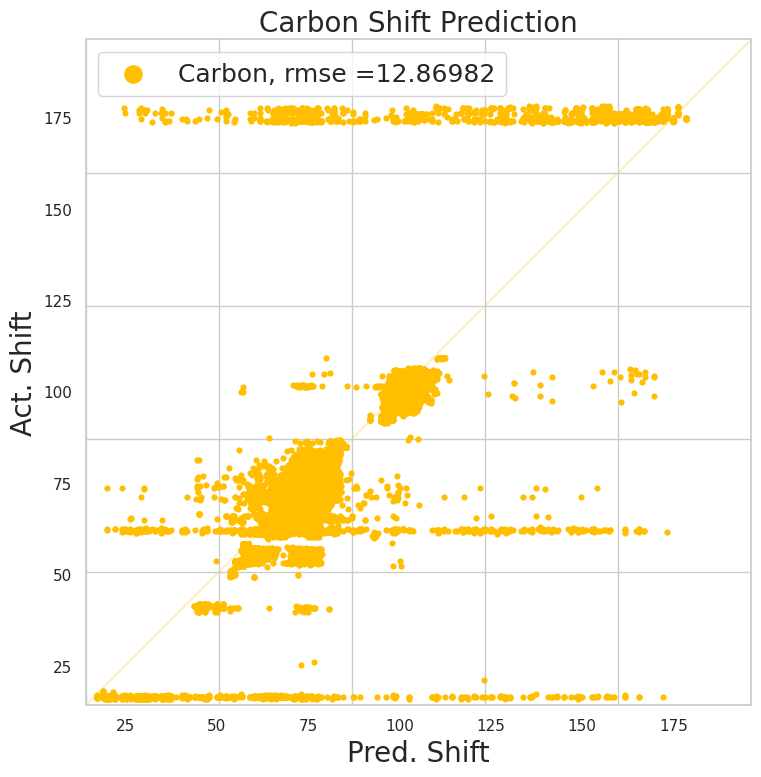

In [20]:
sns.set_theme(style="whitegrid", font_scale=1)

figure, axis = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=False)
# figure, axis = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=False)
# figure, axis = plt.subplots(3, 3, figsize=(8, 8))
figure.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad = 1, w_pad = 1)
##### For node features

plot_shift(df_visulize_v3, axis, i = 0, set_title_name = 'Carbon Shift Prediction', sep = 5, xlab_name = 'Pred. Shift', 
           ylab_name = 'Act. Shift', color = '#FFBF00', ms = 5)
# plot_shift(df_visulize_v2, axis, i = 0, set_title_name = 'Hydrogen shift prediction all type', sep = 5, xlab_name = 'Pred. Shift', 
#            ylab_name = 'Act. Shift', color = '#679399', ms = 5)

plt.show()

In [21]:
df_visulize_v3

,0,1
0,81.175180,83.2
1,74.486950,72.4
2,101.153420,99.7
3,78.713780,76.0
4,172.111860,175.5
...,...,...
48987,74.469536,74.6
48988,65.858580,62.2
48989,70.383600,68.0
48990,72.751110,71.4


In [ ]:
train_carbon_mask.to(device)
train_carbon_mask.get_device()

In [ ]:
train_carbon_mask.to(device)

In [ ]:
a = labels.cpu().numpy()
len(a)

In [ ]:
np.where(np.isnan(a))[0]

In [ ]:
np.where(a == np.nan)

In [ ]:
min(a)